In [1]:
!pip install pytorch-tabnet
!git clone https://github.com/alezakuskin/Stark_ML
!cd /usr/local/lib/python3.7/dist-packages/pytorch_tabnet && patch </content/Stark_ML/float64.patch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'Stark_ML'...
remote: Enumerating objects: 847, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 847 (delta 78), reused 78 (delta 53), pack-reused 737
Receiving objects: 100% (847/847), 32.84 MiB | 25.54 MiB/s, done.
Resolving deltas: 100% (502/502), done.
patching file abstract_model.py
patching file multitask.py
patching file pretraining.py
patching file tab_model.py
patching file tab_network.py
patching file utils.py


In [2]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
!pip install optuna

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import importlib
import json
import torch
#torch.autograd.set_detect_anomaly(False)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn import svm
from google.colab import output

from pytorch_tabnet.tab_model import  TabNetRegressor
np.random.seed(777)

output.clear()

In [3]:
if os.path.isdir('Stark_ML'):
    !rm -rf Stark_ML

!git clone -b Temperature-tuning https://github.com/alezakuskin/Stark_ML

import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting
import Stark_ML.models.tabnet


importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)
importlib.reload(Stark_ML.models.tabnet)


from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from Stark_ML.utils.plotting import *
from Stark_ML.models.tabnet import *
from Stark_ML.utils import *
output.clear()

# Data preprocessing

In [4]:
data = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BC'
                   )
data['Term'] = term_to_number(data['Term'])
data['Term.1'] = term_to_number(data['Term.1'])

In [5]:
#Step 1.
#Exclude elements for testing
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

In [6]:
#Step 2.
#Separating into data for width and shift prediction
data_width = data[np.isnan(data['w (A)']) == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

label_width = data_width.loc[:, ['Element', 'Wavelength']]
label_width_elements = data_width_elements.loc[:, ['Element', 'Wavelength']]
data_width = data_width.drop(columns = ['d (A)', 'w (A)'])
data_width_elements = data_width_elements.drop(columns = ['d (A)', 'w (A)'])

In [7]:
#Step 3.
#Split into train and test
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
  data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)
  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = 6)

print(target_test_q4[target_test_q4 > 70])

#Creating full train and test datasets
data_width_test, target_width_test = data_test_q1.append(data_test_q2), target_test_q1.append(target_test_q2)
data_width_test, target_width_test = data_width_test.append(data_test_q3), target_width_test.append(target_test_q3)
data_width_test, target_width_test = data_width_test.append(data_test_q4), target_width_test.append(target_test_q4)

data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

581    130.0
585    180.5
580     75.5
Name: w (A), dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [8]:
#Step 4.
factor = 1.05
data_width_train_extended = data_width_train
target_width_train_extended = target_width_train
for index, row in data_width_train.iterrows():
    row['T'] = row['T']*factor
    data_width_train_extended = data_width_train_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_train_extended = target_width_train_extended.append(pd.Series(target_width_train.loc[index]), ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_train_extended = data_width_train_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_train_extended = target_width_train_extended.append(pd.Series(target_width_train.loc[index]), ignore_index=True)

In [120]:
#Creating data, target and labels for shift prediction
data_shift = data[np.isnan(data['d (A)']) == False]
data_shift_elements = data_shift.loc[data_shift['Element'].isin(elements_to_exclude)]
data_shift = data_shift.drop(data_shift_elements.index)
data_shift = data_shift.sort_values(by=['Z number'])
target_shift = data_shift['d (A)']
label_shift = data_shift.loc[:, ['Element', 'Wavelength']]
data_shift = data_shift.drop(columns = ['w (A)', 'd (A)'])
target_shift_elements = data_shift_elements['w (A)']
label_shift_elements = data_shift_elements.loc[:, ['Element', 'Wavelength']]




#Selecting items for predicting both parameters simultaneously
data_both = data[(np.isnan(data['w (A)']) == False) & (np.isnan(data['d (A)']) == False)]
target_both = data_both.loc[:, ['w (A)', 'd (A)']]
label_both = data_both.loc[:, ['Element', 'Wavelength']]
data_both = data_both.drop(columns = ['w (A)', 'd (A)'])

print(f'Number of items with width: {data_width.shape[0]}')
print(f'Number of items with shift: {data_shift.shape[0]}')
print(f'Number of items with both parameters: {data_both.shape[0]}')
print()
print(f'Size of elements-exclusive test set: {data_width_elements.shape[0]}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


581    130.0
585    180.5
580     75.5
Name: w (A), dtype: float64
Number of items with width: 897
Number of items with shift: 331
Number of items with both parameters: 299

Size of elements-exclusive test set: 34


## Data visual description

In [121]:
data_width.describe()

,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,4p,...,8p,8d,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T
count,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,...,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,8.970000e+02,897.000000
mean,437.237659,14.851728,1.769231,1.612040,3.460424,0.858417,1.943144,2.469342,0.332219,0.749164,...,0.001115,0.002230,0.001115,0.001115,2.899666,1.544036,0.603122,1.827202,2.113072e+05,16462.332219
std,216.218894,15.978406,0.421560,0.737235,2.179154,0.905723,2.720643,3.995171,0.687093,1.679233,...,0.033389,0.047193,0.033389,0.033389,1.247752,1.312079,0.489523,1.432334,3.325359e+06,9439.627870
min,113.416500,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.173231e+04,2950.000000
25%,283.999000,6.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,5.387426e+04,10970.000000
50%,471.315614,7.000000,2.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.500000,8.848342e+04,12500.000000
75%,541.520000,26.000000,2.000000,2.000000,6.000000,2.000000,6.000000,7.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.000000,2.000000,1.184278e+05,20800.000000
max,2058.130000,82.000000,2.000000,2.000000,6.000000,2.000000,6.000000,10.000000,2.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,7.000000,5.000000,1.000000,7.000000,9.968131e+07,50000.000000


In [122]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    897.000000
mean       4.564198
std       12.780995
min        0.001500
25%        0.204444
50%        1.451247
75%        4.016393
max      180.500000
Name: w (A), dtype: float64


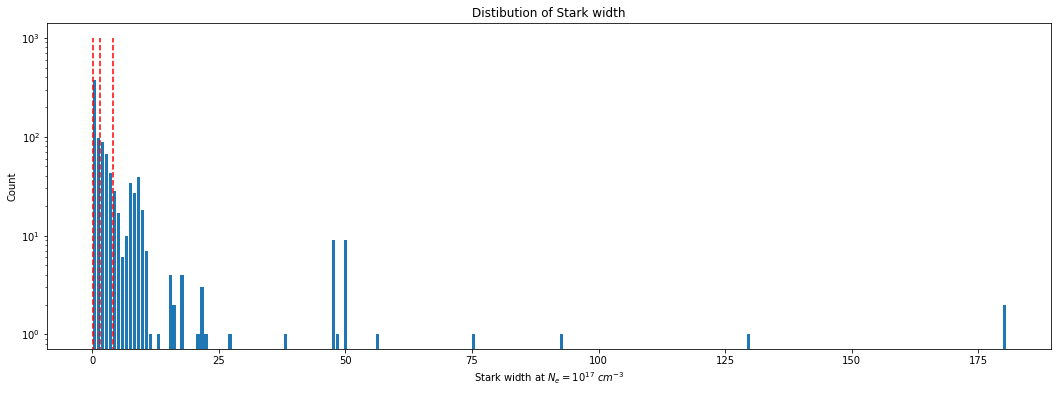

In [123]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

## Train - Test split

In [105]:
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
  data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)
  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = 6)

print(target_test_q4[target_test_q4 > 70])

584    92.5
Name: w (A), dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


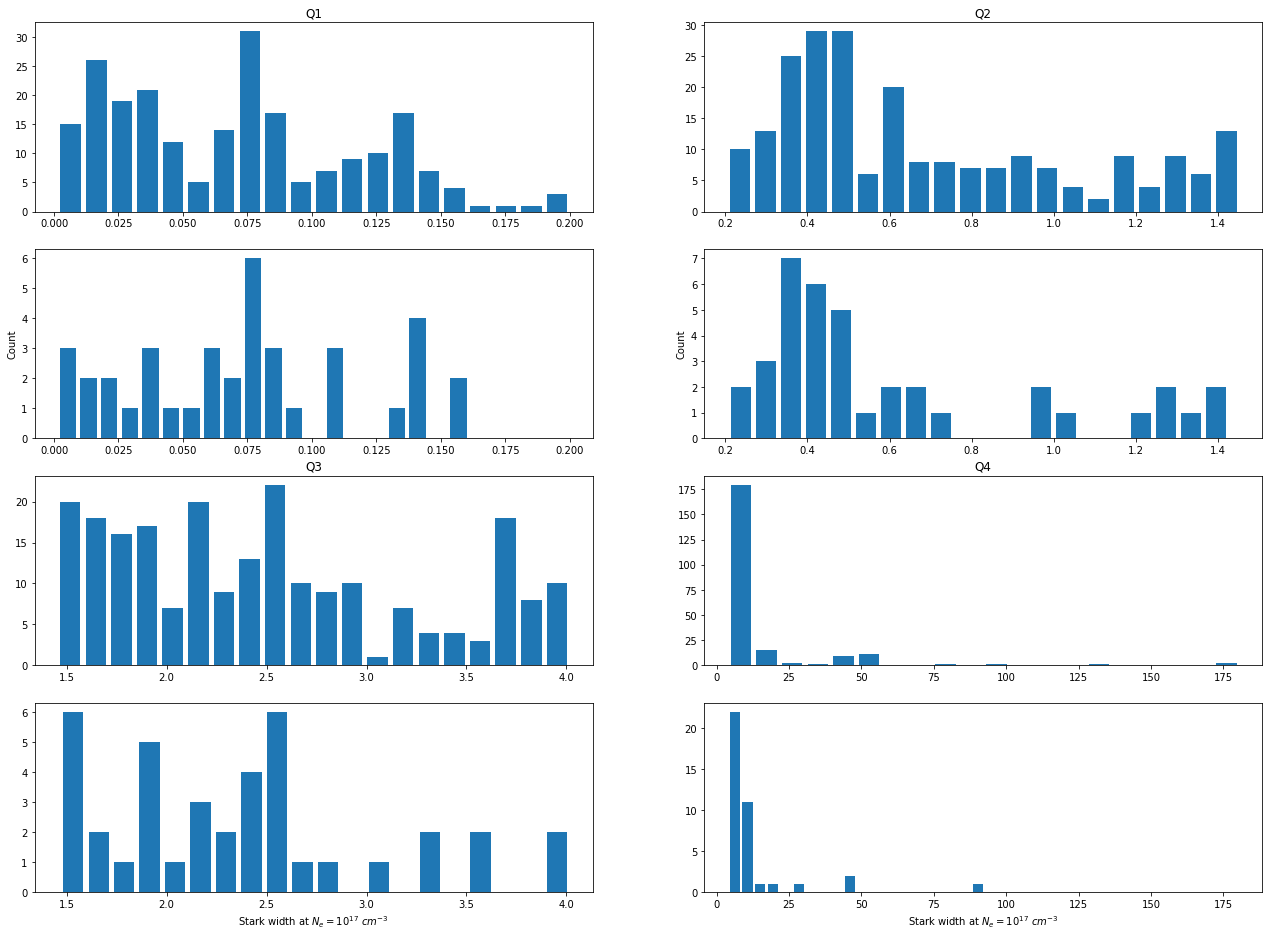

In [106]:
#Plotting train-test distributions
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

In [107]:
#Creating full train and test datasets
data_width_test, target_width_test = data_test_q1.append(data_test_q2), target_test_q1.append(target_test_q2)
data_width_test, target_width_test = data_width_test.append(data_test_q3), target_width_test.append(target_test_q3)
data_width_test, target_width_test = data_width_test.append(data_test_q4), target_width_test.append(target_test_q4)

data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

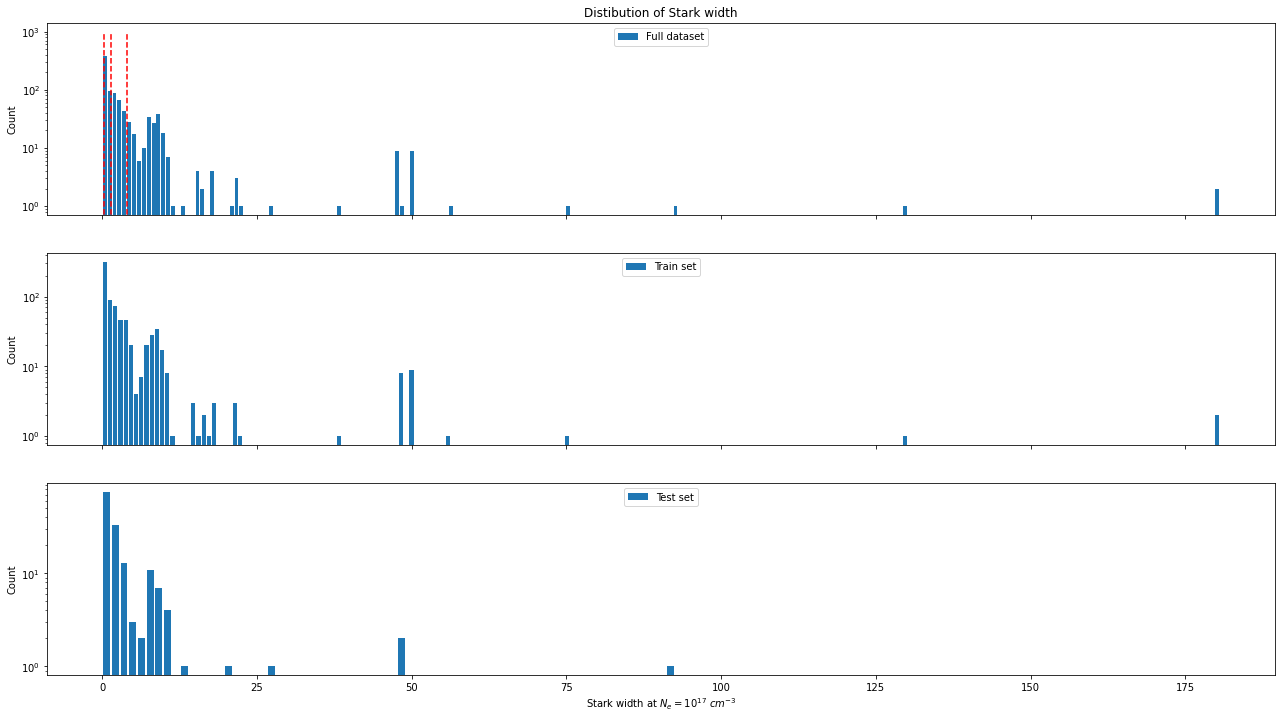

In [108]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')
'''axs[1].vlines(x = test_width_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

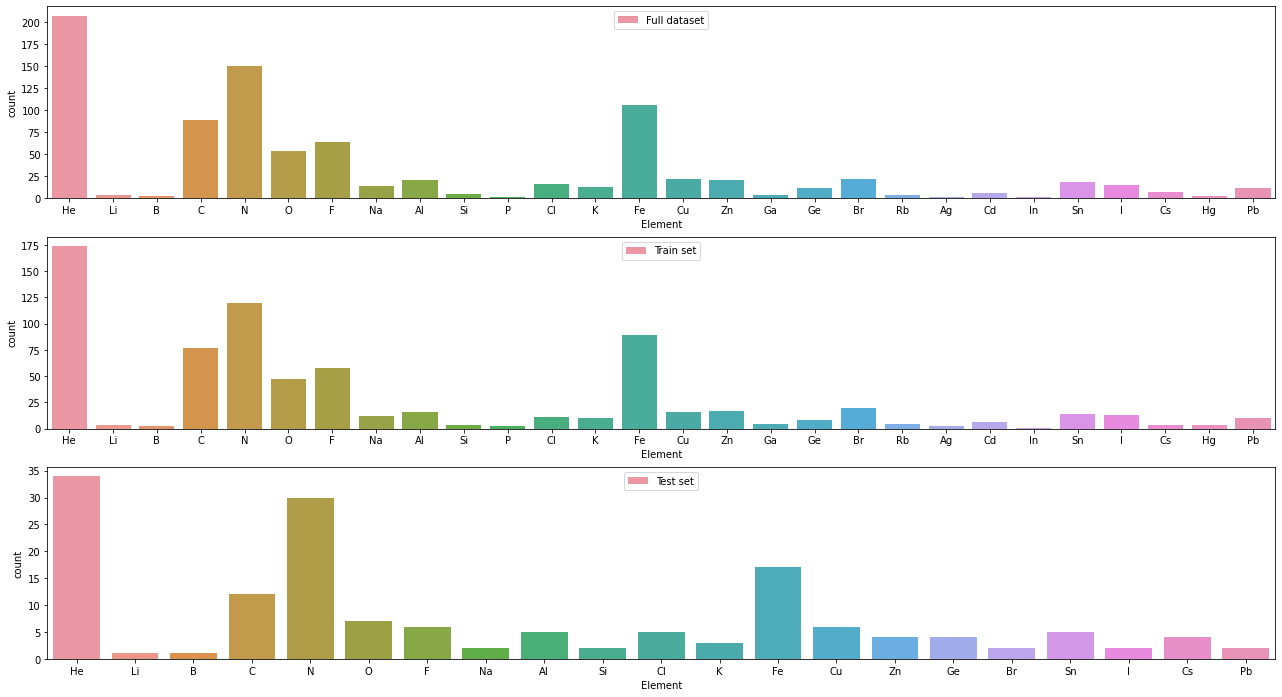

In [109]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

In [9]:
#@title Use extended train set?
extended_train_set = True#@param {type:"boolean"}

In [10]:
#Assigning proper variables
if extended_train_set:
    XW_train, YW_train = data_width_train_extended.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train_extended
    XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test
else:
    XW_train, YW_train = data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train
    XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test

print(XW_train.shape, YW_train.shape)
print(XW_test.shape, YW_test.shape)

XW_train = XW_train.sample(frac = 1, random_state = 777)
YW_train = YW_train.sample(frac = 1, random_state = 777)

print('\n', XW_train.shape, YW_train.shape)
print(XW_test.shape, YW_test.shape)
#XS_train, XS_test, YS_train, YS_test = train_test_split(data_shift, target_shift, test_size = 0.2, random_state = 7)
#XB_train, XB_test, YB_train, YB_test = train_test_split(data_both, target_both, test_size = 0.2, random_state = 7)

(2229, 50) (2229,)
(154, 50) (154,)

 (2229, 50) (2229,)
(154, 50) (154,)


In [11]:
XW_elem = data_width_elements.drop(columns=['Element', 'Wavelength', 'Z number'])
YW_elem = target_width_elements
LW_elem = label_width_elements

## Shift data preprocessing

In [ ]:
data_shift.describe()

,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,4p,...,8p,8d,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.0,331.0,331.0,331.000000,331.000000,331.000000,331.000000,3.310000e+02,331.000000
mean,479.888947,14.045317,1.740181,1.531722,3.308157,0.737160,1.435045,1.797583,0.314199,0.749245,...,0.003021,0.0,0.0,0.0,2.764350,1.187311,0.555891,1.480363,4.027146e+05,17826.404834
std,192.056662,17.933067,0.439199,0.802301,2.162047,0.853039,2.371135,3.775294,0.694837,1.845705,...,0.054965,0.0,0.0,0.0,1.114123,0.864075,0.497619,0.999428,5.473695e+06,9920.444183
min,119.955000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,1.173231e+04,3800.000000
25%,391.633000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,2.000000,1.000000,0.000000,1.000000,5.375643e+04,11000.000000
50%,501.568000,8.000000,2.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,3.000000,1.000000,1.000000,1.500000,9.966391e+04,15000.000000
75%,589.200750,13.000000,2.000000,2.000000,6.000000,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,3.000000,2.000000,1.000000,2.000000,1.832368e+05,22700.000000
max,852.112000,82.000000,2.000000,2.000000,6.000000,2.000000,6.000000,10.000000,2.000000,6.000000,...,1.000000,0.0,0.0,0.0,7.000000,5.000000,1.000000,7.000000,9.968131e+07,49000.000000


count    331.000000
mean       2.034925
std        3.704571
min       -7.485437
25%        0.037200
50%        0.290000
75%        2.881356
max       20.000000
Name: d (A), dtype: float64


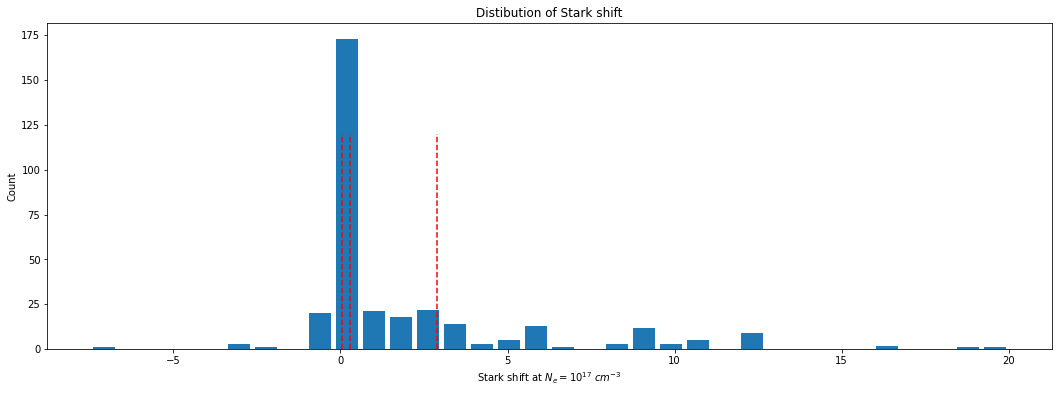

In [ ]:
data_shift_stats = target_shift.describe()
print(data_shift_stats)

fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_shift, bins='auto', log=False, rwidth = 0.8)
ax.vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 120, ls='--', colors='r')
ax.vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 120, ls='--', colors='r')
ax.vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 120, ls='--', colors='r')

ax.set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('Shift distribution.png', dpi = 300)

In [ ]:
#Q1
data_test_q1, target_test_q1 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 17.5]) < 1 or len(target_test_q4[(target_test_q4 > 11.5) & (target_test_q4 < 17.5)]) < 1:
  data_test_q4, target_test_q4 = test_selection(data_shift,
                                                target_shift,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


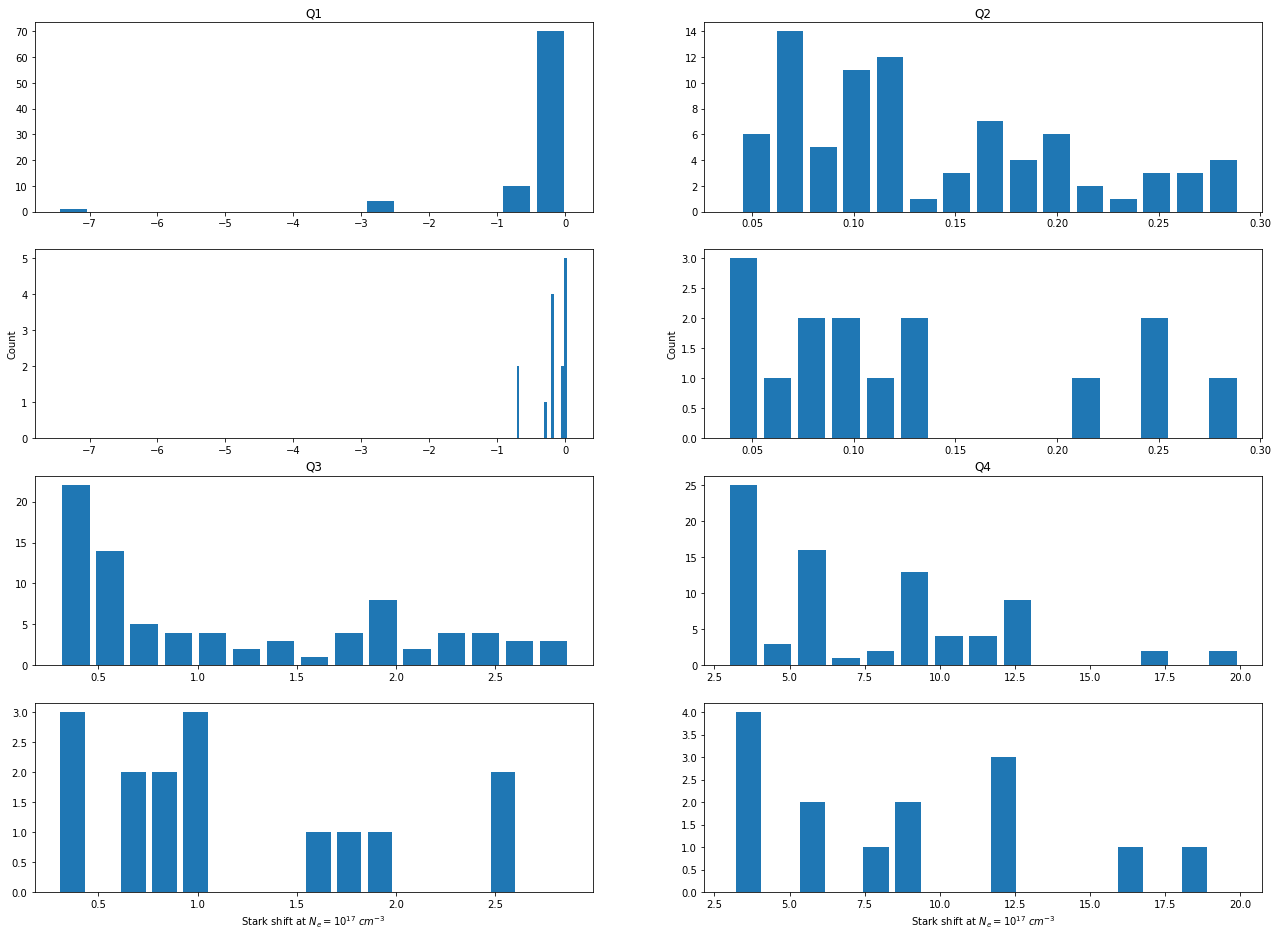

In [ ]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_shift[target_shift <= data_shift_stats['25%']], bins=15, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 15, rwidth = 0.8)

axs[0, 1].hist(target_shift[(target_shift > data_shift_stats['25%']) & (target_shift <= data_shift_stats['50%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 15, rwidth = 0.8)

axs[2, 0].hist(target_shift[(target_shift > data_shift_stats['50%']) & (target_shift <= data_shift_stats['75%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 15, rwidth = 0.8)

axs[2, 1].hist(target_shift[target_shift > data_shift_stats['75%']],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 15, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

In [ ]:
#Creating full train and test datasets
data_shift_test, target_shift_test = data_test_q1.append(data_test_q2), target_test_q1.append(target_test_q2)
data_shift_test, target_shift_test = data_shift_test.append(data_test_q3), target_shift_test.append(target_test_q3)
data_shift_test, target_shift_test = data_shift_test.append(data_test_q4), target_shift_test.append(target_test_q4)

data_shift_train, target_shift_train = data_shift.drop(data_shift_test.index), target_shift.drop(target_shift_test.index)

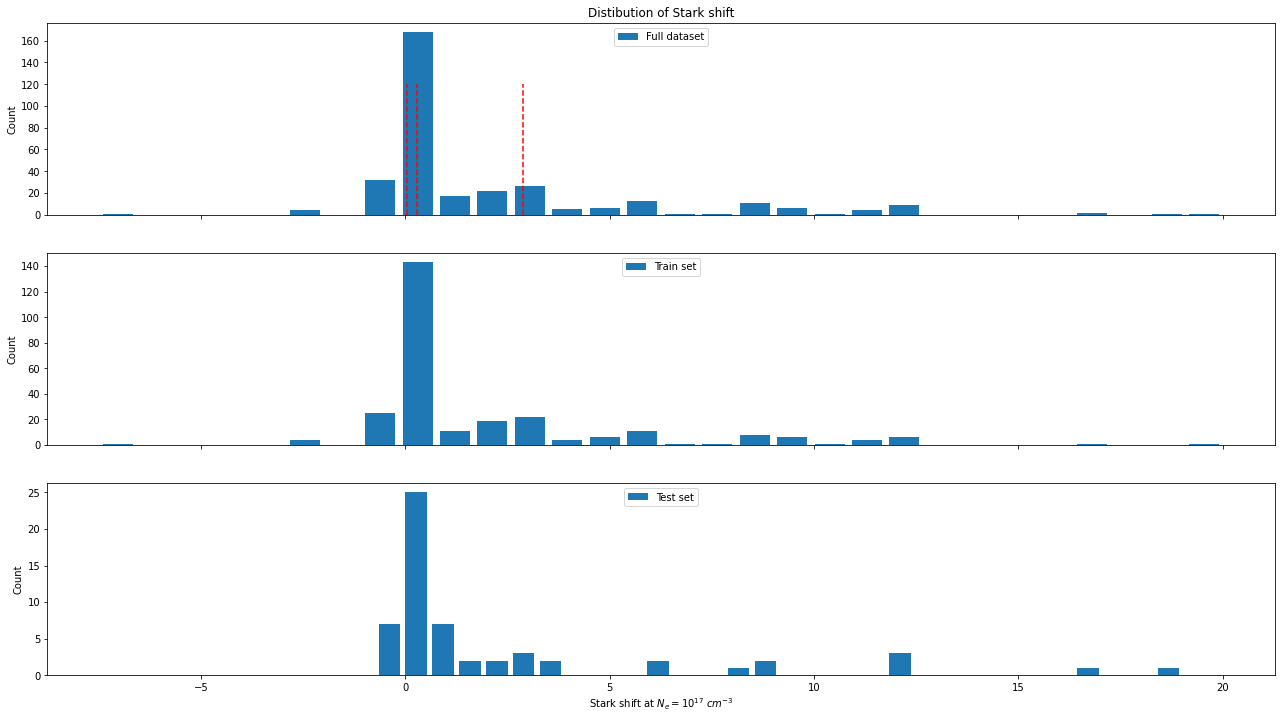

In [ ]:
test_shift_stats = target_shift_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_shift, bins=30, log=False, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_shift_train, bins = 30, log = False, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_shift_test, bins = 30, log = False, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 120, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 120, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 120, ls='--', colors='r')
'''axs[1].vlines(x = test_shift_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_shift_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_shift_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('shift distribution.png', dpi = 300)

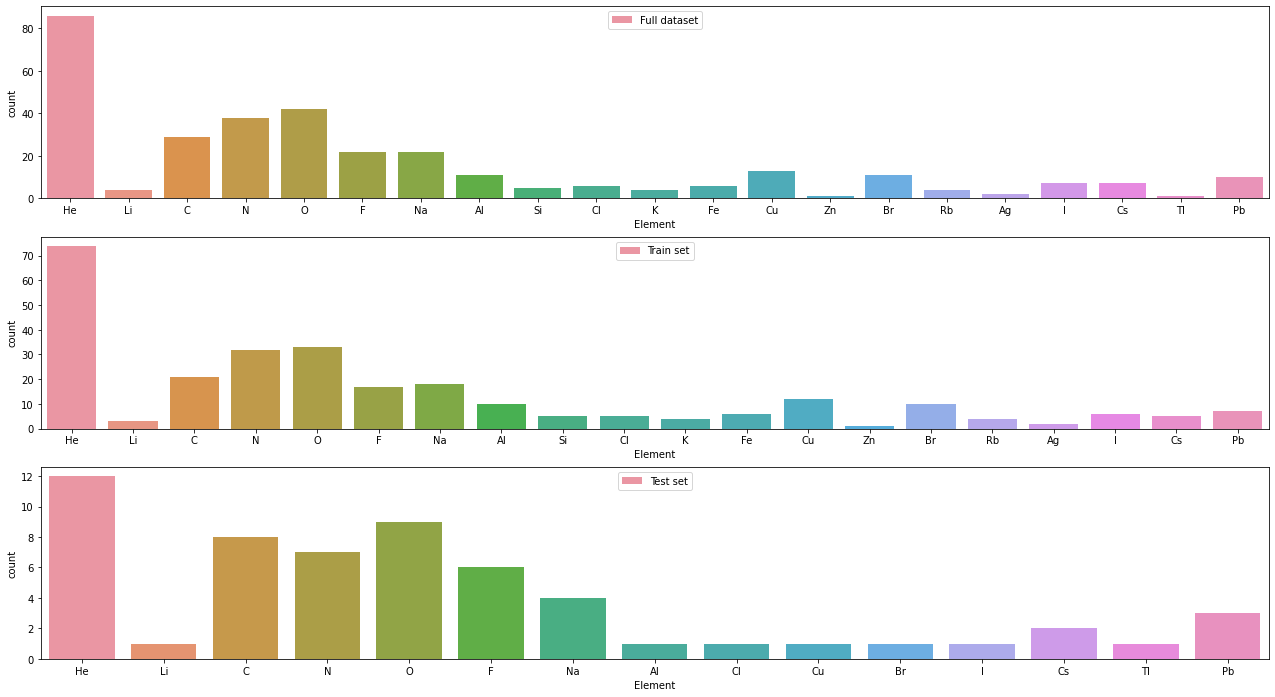

In [ ]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_shift, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_shift_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_shift_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

In [ ]:
#Assigning proper variables
XS_train, YS_train = data_shift_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_shift_train
XS_test, YS_test = data_shift_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_shift_test

print(XS_train.shape, YS_train.shape)
print(XS_test.shape, YS_test.shape)

XS_train = XS_train.sample(frac = 1, random_state = 777)
YS_train = YS_train.sample(frac = 1, random_state = 777)

print('\n', XS_train.shape, YS_train.shape)
print(XS_test.shape, YS_test.shape)

(275, 50) (275,)
(58, 50) (58,)

 (275, 50) (275,)
(58, 50) (58,)


In [ ]:
XS_elem = data_shift_elements.drop(columns=['Element', 'Wavelength', 'Z number', 'd (A)', 'w (A)'])
YS_elem = target_shift_elements
LS_elem = label_shift_elements

#Models optimization

In [12]:
#@title Max width value
#@markdown You can enter any reasonable value less than 180 Angstrom.
width_threshold =  200#@param {type:"number"}

#@markdown Scale target values by the formula: $y_{scaled} = ln(1 + \frac{y_{raw}}{\epsilon})$
scaled_target = True#@param {type:"boolean"}
epsilon = 1e-3#@param {type: "number"}

In [13]:
XW_train = XW_train.loc[YW_train.loc[YW_train < width_threshold].index]
YW_train = YW_train.loc[YW_train < width_threshold]
XW_test = XW_test.loc[YW_test.loc[YW_test < width_threshold].index]
YW_test = YW_test.loc[YW_test < width_threshold]
XW_elem = XW_elem.loc[YW_elem.loc[YW_elem < width_threshold].index]
YW_elem = YW_elem.loc[YW_elem < width_threshold]
LW_elem = LW_elem.loc[YW_elem.loc[YW_elem < width_threshold].index]

if scaled_target:
    YW_train = np.log(1 + YW_train / epsilon)
    YW_test = np.log(1 + YW_test / epsilon)
    YW_elem = np.log(1 + YW_elem / epsilon)

## KNN

In [324]:
KNN_params = {
    'n_neighbors' : [1, 150],
    'weights' : ['distance', 'uniform'],
    'leaf_size' : [1, 100],
    'p' : [1., 2.],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = KNN

KNN_res = main(X = XW_train, y = YW_train, model_name = model_name, params = KNN_params, n_trials = 250)

'''with open(f'KNN_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(KNN_res.best_params, fp)
'''
with open(f'KNN_Extended_optimal_parameters', 'w') as fp:
    json.dump(KNN_res.best_params, fp)

[I 2022-08-19 15:30:06,218] A new study created in memory with name: no-name-b0247c0f-89bf-4c25-8968-fceb4c38ed8b


Start hyperparameter optimization
{'n_neighbors': 23, 'weights': 'distance', 'leaf_size': 98, 'p': 1.7957892602566}
{'n_neighbors': 120, 'weights': 'uniform', 'leaf_size': 28, 'p': 1.4185483727787338}


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn("Progress bar only supports serial execution (`n_jobs=1`).")
[I 2022-08-19 15:30:22,906] Trial 1 finished with value: 0.8089373331908621 and parameters: {'n_neighbors': 120, 'weights': 'uniform', 'leaf_size': 28, 'p': 1.4185483727787338}. Best is trial 1 with value: 0.8089373331908621.
[I 2022-08-19 15:30:23,048] Trial 0 finished with value: 0.32649296791263915 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'leaf_size': 98, 'p': 1.7957892602566}. Best is trial 0 with value: 0.32649296791263915.


{'n_neighbors': 135, 'weights': 'uniform', 'leaf_size': 57, 'p': 1.2476543077704614}
{'n_neighbors': 87, 'weights': 'distance', 'leaf_size': 4, 'p': 1.728919153891048}


[I 2022-08-19 15:30:37,710] Trial 3 finished with value: 0.3858923938558774 and parameters: {'n_neighbors': 87, 'weights': 'distance', 'leaf_size': 4, 'p': 1.728919153891048}. Best is trial 0 with value: 0.32649296791263915.
[I 2022-08-19 15:30:37,715] Trial 2 finished with value: 0.8407512929466922 and parameters: {'n_neighbors': 135, 'weights': 'uniform', 'leaf_size': 57, 'p': 1.2476543077704614}. Best is trial 0 with value: 0.32649296791263915.


{'n_neighbors': 140, 'weights': 'distance', 'leaf_size': 9, 'p': 1.158710159060429}{'n_neighbors': 23, 'weights': 'distance', 'leaf_size': 42, 'p': 1.6941547109478305}



[I 2022-08-19 15:30:50,718] Trial 5 finished with value: 0.325549291113611 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'leaf_size': 42, 'p': 1.6941547109478305}. Best is trial 5 with value: 0.325549291113611.
[I 2022-08-19 15:30:50,877] Trial 4 finished with value: 0.38966968858427836 and parameters: {'n_neighbors': 140, 'weights': 'distance', 'leaf_size': 9, 'p': 1.158710159060429}. Best is trial 5 with value: 0.325549291113611.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 21, 'p': 1.7782472830919152}
{'n_neighbors': 51, 'weights': 'uniform', 'leaf_size': 39, 'p': 1.612110010319995}


[I 2022-08-19 15:31:01,597] Trial 6 finished with value: 0.24726834181998308 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 21, 'p': 1.7782472830919152}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 138, 'weights': 'uniform', 'leaf_size': 91, 'p': 1.6928222058398172}


[I 2022-08-19 15:31:02,442] Trial 7 finished with value: 0.6413587889148079 and parameters: {'n_neighbors': 51, 'weights': 'uniform', 'leaf_size': 39, 'p': 1.612110010319995}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 80, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1426639751147765}


[I 2022-08-19 15:31:13,157] Trial 8 finished with value: 0.8538780028856564 and parameters: {'n_neighbors': 138, 'weights': 'uniform', 'leaf_size': 91, 'p': 1.6928222058398172}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 127, 'weights': 'distance', 'leaf_size': 7, 'p': 1.5193860228491152}


[I 2022-08-19 15:31:13,604] Trial 9 finished with value: 0.7117548893263944 and parameters: {'n_neighbors': 80, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1426639751147765}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 61, 'p': 1.9796870577753696}


[I 2022-08-19 15:31:24,470] Trial 10 finished with value: 0.39741938050555625 and parameters: {'n_neighbors': 127, 'weights': 'distance', 'leaf_size': 7, 'p': 1.5193860228491152}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 60, 'p': 1.9602044296956527}


[I 2022-08-19 15:31:24,904] Trial 11 finished with value: 0.2809945877476938 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 61, 'p': 1.9796870577753696}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 66, 'p': 1.9773913899531832}


[I 2022-08-19 15:31:36,395] Trial 12 finished with value: 0.252465357805139 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 60, 'p': 1.9602044296956527}. Best is trial 6 with value: 0.24726834181998308.
[I 2022-08-19 15:31:36,608] Trial 13 finished with value: 0.3839775281999065 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 66, 'p': 1.9773913899531832}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 75, 'p': 1.9755268888802044}
{'n_neighbors': 49, 'weights': 'distance', 'leaf_size': 26, 'p': 1.8564970486587784}


[I 2022-08-19 15:31:47,578] Trial 14 finished with value: 0.26733644783111854 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 75, 'p': 1.9755268888802044}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 52, 'weights': 'distance', 'leaf_size': 24, 'p': 1.8390161597389834}


[I 2022-08-19 15:31:47,888] Trial 15 finished with value: 0.36362549864175203 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'leaf_size': 26, 'p': 1.8564970486587784}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 44, 'weights': 'distance', 'leaf_size': 21, 'p': 1.8487193853505361}


[I 2022-08-19 15:31:58,579] Trial 16 finished with value: 0.3670359315682019 and parameters: {'n_neighbors': 52, 'weights': 'distance', 'leaf_size': 24, 'p': 1.8390161597389834}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 35, 'weights': 'uniform', 'leaf_size': 47, 'p': 1.3723044537374613}


[I 2022-08-19 15:31:59,269] Trial 17 finished with value: 0.3583763457183262 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'leaf_size': 21, 'p': 1.8487193853505361}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 104, 'weights': 'uniform', 'leaf_size': 49, 'p': 1.425120954575263}


[I 2022-08-19 15:32:09,874] Trial 18 finished with value: 0.5632447434533663 and parameters: {'n_neighbors': 35, 'weights': 'uniform', 'leaf_size': 47, 'p': 1.3723044537374613}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 66, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.5818216829837632}


[I 2022-08-19 15:32:10,912] Trial 19 finished with value: 0.7702848501051418 and parameters: {'n_neighbors': 104, 'weights': 'uniform', 'leaf_size': 49, 'p': 1.425120954575263}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 70, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.5862182482150562}


[I 2022-08-19 15:32:21,277] Trial 20 finished with value: 0.6851883476545522 and parameters: {'n_neighbors': 66, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.5818216829837632}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 79, 'p': 1.9987832802013317}


[I 2022-08-19 15:32:22,184] Trial 21 finished with value: 0.6955858577269716 and parameters: {'n_neighbors': 70, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.5862182482150562}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 16, 'weights': 'distance', 'leaf_size': 79, 'p': 1.9316935676894482}


[I 2022-08-19 15:32:32,616] Trial 22 finished with value: 0.25246535780513907 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 79, 'p': 1.9987832802013317}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 22, 'weights': 'distance', 'leaf_size': 83, 'p': 1.9176447305778845}


[I 2022-08-19 15:32:33,522] Trial 23 finished with value: 0.3056778749930352 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'leaf_size': 79, 'p': 1.9316935676894482}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 27, 'weights': 'distance', 'leaf_size': 57, 'p': 1.9051203284140052}


[I 2022-08-19 15:32:44,011] Trial 24 finished with value: 0.32487448553969206 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'leaf_size': 83, 'p': 1.9176447305778845}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 34, 'weights': 'distance', 'leaf_size': 56, 'p': 1.7540274255323944}


[I 2022-08-19 15:32:44,869] Trial 25 finished with value: 0.3362444172206569 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'leaf_size': 57, 'p': 1.9051203284140052}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 36, 'p': 1.7775618484289202}


[I 2022-08-19 15:32:55,289] Trial 26 finished with value: 0.34517208134134786 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'leaf_size': 56, 'p': 1.7540274255323944}. Best is trial 6 with value: 0.24726834181998308.


{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 17, 'p': 1.7941776173082613}


[I 2022-08-19 15:32:56,073] Trial 27 finished with value: 0.23601069005881534 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 36, 'p': 1.7775618484289202}. Best is trial 27 with value: 0.23601069005881534.


{'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 16, 'p': 1.0459503603934417}


[I 2022-08-19 15:33:06,630] Trial 28 finished with value: 0.25336781857589247 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 17, 'p': 1.7941776173082613}. Best is trial 27 with value: 0.23601069005881534.


{'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 33, 'p': 1.6435726701645914}


[I 2022-08-19 15:33:07,238] Trial 29 finished with value: 0.2886195665309439 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 16, 'p': 1.0459503603934417}. Best is trial 27 with value: 0.23601069005881534.


{'n_neighbors': 35, 'weights': 'distance', 'leaf_size': 33, 'p': 1.6705706731913956}


[I 2022-08-19 15:33:17,927] Trial 30 finished with value: 0.3005783450882945 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 33, 'p': 1.6435726701645914}. Best is trial 27 with value: 0.23601069005881534.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 97, 'p': 1.8013563648008095}


[I 2022-08-19 15:33:18,417] Trial 31 finished with value: 0.34472764989242627 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'leaf_size': 33, 'p': 1.6705706731913956}. Best is trial 27 with value: 0.23601069005881534.


{'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 97, 'p': 1.7940023639236313}


[I 2022-08-19 15:33:29,898] Trial 32 finished with value: 0.2510408807747779 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 97, 'p': 1.8013563648008095}. Best is trial 27 with value: 0.23601069005881534.
[I 2022-08-19 15:33:30,021] Trial 33 finished with value: 0.2349903245701479 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 97, 'p': 1.7940023639236313}. Best is trial 33 with value: 0.2349903245701479.


{'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 96, 'p': 1.7725402654918212}
{'n_neighbors': 25, 'weights': 'distance', 'leaf_size': 92, 'p': 1.7928547444262561}


[I 2022-08-19 15:33:41,021] Trial 34 finished with value: 0.23493733624444474 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 96, 'p': 1.7725402654918212}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 26, 'weights': 'distance', 'leaf_size': 90, 'p': 1.7689959258638133}


[I 2022-08-19 15:33:41,303] Trial 35 finished with value: 0.3310382053197994 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'leaf_size': 92, 'p': 1.7928547444262561}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 102, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.7411178773583293}


[I 2022-08-19 15:33:51,888] Trial 36 finished with value: 0.33285958853448083 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'leaf_size': 90, 'p': 1.7689959258638133}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 16, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.5216208363865542}


[I 2022-08-19 15:33:52,615] Trial 37 finished with value: 0.7768061737400815 and parameters: {'n_neighbors': 102, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.7411178773583293}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 14, 'weights': 'uniform', 'leaf_size': 33, 'p': 1.5222224863557154}


[I 2022-08-19 15:34:03,054] Trial 38 finished with value: 0.4616431287125886 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.5216208363865542}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 60, 'weights': 'distance', 'leaf_size': 40, 'p': 1.890594299300175}


[I 2022-08-19 15:34:04,062] Trial 39 finished with value: 0.438139690045441 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'leaf_size': 33, 'p': 1.5222224863557154}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 60, 'weights': 'distance', 'leaf_size': 13, 'p': 1.7064450531248858}


[I 2022-08-19 15:34:15,347] Trial 40 finished with value: 0.3745036224770249 and parameters: {'n_neighbors': 60, 'weights': 'distance', 'leaf_size': 40, 'p': 1.890594299300175}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 96, 'p': 1.7051639891227919}


[I 2022-08-19 15:34:15,996] Trial 41 finished with value: 0.3716510749367436 and parameters: {'n_neighbors': 60, 'weights': 'distance', 'leaf_size': 13, 'p': 1.7064450531248858}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 147, 'weights': 'distance', 'leaf_size': 89, 'p': 1.8494074493411803}


[I 2022-08-19 15:34:26,340] Trial 42 finished with value: 0.27485289631469667 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 96, 'p': 1.7051639891227919}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.8372560728969942}


[I 2022-08-19 15:34:27,050] Trial 43 finished with value: 0.4150521814851108 and parameters: {'n_neighbors': 147, 'weights': 'distance', 'leaf_size': 89, 'p': 1.8494074493411803}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 84, 'p': 1.642290256303841}


[I 2022-08-19 15:34:37,617] Trial 44 finished with value: 0.2510408807747779 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.8372560728969942}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 21, 'weights': 'distance', 'leaf_size': 87, 'p': 1.6577567454984297}


[I 2022-08-19 15:34:38,174] Trial 45 finished with value: 0.2494184294375386 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 84, 'p': 1.642290256303841}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 20, 'weights': 'distance', 'leaf_size': 83, 'p': 1.6379565381697012}


[I 2022-08-19 15:34:48,562] Trial 46 finished with value: 0.3200087144087397 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'leaf_size': 87, 'p': 1.6577567454984297}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 45, 'p': 1.5956236004764266}


[I 2022-08-19 15:34:49,353] Trial 47 finished with value: 0.3167014576898596 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'leaf_size': 83, 'p': 1.6379565381697012}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 1, 'p': 1.5965301269191519}


[I 2022-08-19 15:34:59,537] Trial 48 finished with value: 0.3685467828890733 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 45, 'p': 1.5956236004764266}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 31, 'weights': 'distance', 'leaf_size': 94, 'p': 1.7614156208990976}


[I 2022-08-19 15:35:00,595] Trial 49 finished with value: 0.3841193019973454 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 1, 'p': 1.5965301269191519}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 41, 'weights': 'distance', 'leaf_size': 95, 'p': 1.718603092672477}


[I 2022-08-19 15:35:10,821] Trial 50 finished with value: 0.3407463157692281 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'leaf_size': 94, 'p': 1.7614156208990976}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 89, 'p': 1.8123506845994297}


[I 2022-08-19 15:35:11,777] Trial 51 finished with value: 0.35318284364068453 and parameters: {'n_neighbors': 41, 'weights': 'distance', 'leaf_size': 95, 'p': 1.718603092672477}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 85, 'p': 1.8350683075037144}


[I 2022-08-19 15:35:22,080] Trial 52 finished with value: 0.2594128443984169 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 89, 'p': 1.8123506845994297}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 100, 'p': 1.881318716367046}


[I 2022-08-19 15:35:23,072] Trial 53 finished with value: 0.2510408807747779 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 85, 'p': 1.8350683075037144}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 52, 'p': 1.8836046325128484}


[I 2022-08-19 15:35:33,405] Trial 54 finished with value: 0.23539526477299275 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 100, 'p': 1.881318716367046}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 100, 'p': 1.8722634320212725}


[I 2022-08-19 15:35:34,342] Trial 55 finished with value: 0.28462215299743165 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 52, 'p': 1.8836046325128484}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 90, 'weights': 'distance', 'leaf_size': 100, 'p': 1.4672562339448996}


[I 2022-08-19 15:35:44,355] Trial 56 finished with value: 0.2847810324061918 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 100, 'p': 1.8722634320212725}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 91, 'weights': 'uniform', 'leaf_size': 29, 'p': 1.2993647375674313}


[I 2022-08-19 15:35:45,779] Trial 57 finished with value: 0.3791490025692904 and parameters: {'n_neighbors': 90, 'weights': 'distance', 'leaf_size': 100, 'p': 1.4672562339448996}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 19, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.352757863876109}


[I 2022-08-19 15:35:55,438] Trial 58 finished with value: 0.7399533748955479 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'leaf_size': 29, 'p': 1.2993647375674313}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 20, 'weights': 'distance', 'leaf_size': 79, 'p': 1.9567067857916458}


[I 2022-08-19 15:35:56,721] Trial 59 finished with value: 0.4840594199460222 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.352757863876109}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 93, 'p': 1.9373593190644973}


[I 2022-08-19 15:36:06,830] Trial 60 finished with value: 0.3186092630537809 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'leaf_size': 79, 'p': 1.9567067857916458}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 85, 'p': 1.8234241744615747}


[I 2022-08-19 15:36:07,682] Trial 61 finished with value: 0.25469856260576756 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 93, 'p': 1.9373593190644973}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 97, 'p': 1.7383882825992587}


[I 2022-08-19 15:36:18,100] Trial 62 finished with value: 0.2536494396065391 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 85, 'p': 1.8234241744615747}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 65, 'p': 1.7776904508824602}


[I 2022-08-19 15:36:18,438] Trial 63 finished with value: 0.2510408807747779 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 97, 'p': 1.7383882825992587}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 37, 'p': 1.736926830000286}


[I 2022-08-19 15:36:29,360] Trial 64 finished with value: 0.23495019632463632 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 65, 'p': 1.7776904508824602}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 64, 'p': 1.7726857477964169}


[I 2022-08-19 15:36:29,657] Trial 65 finished with value: 0.2934742708951982 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 37, 'p': 1.736926830000286}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 129, 'weights': 'distance', 'leaf_size': 67, 'p': 1.7763757603770745}


[I 2022-08-19 15:36:40,640] Trial 66 finished with value: 0.29287802191039863 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 64, 'p': 1.7726857477964169}. Best is trial 34 with value: 0.23493733624444474.
[I 2022-08-19 15:36:40,843] Trial 67 finished with value: 0.4047032045644743 and parameters: {'n_neighbors': 129, 'weights': 'distance', 'leaf_size': 67, 'p': 1.7763757603770745}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 28, 'weights': 'distance', 'leaf_size': 72, 'p': 1.6864151605816762}
{'n_neighbors': 29, 'weights': 'distance', 'leaf_size': 72, 'p': 1.686449446432976}


[I 2022-08-19 15:36:51,727] Trial 68 finished with value: 0.33555921696626384 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'leaf_size': 72, 'p': 1.6864151605816762}. Best is trial 34 with value: 0.23493733624444474.
[I 2022-08-19 15:36:51,908] Trial 69 finished with value: 0.3367232448878851 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'leaf_size': 72, 'p': 1.686449446432976}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 22, 'p': 1.6241538725043534}
{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 23, 'p': 1.6214022633823981}


[I 2022-08-19 15:37:02,899] Trial 70 finished with value: 0.33632821462502266 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 22, 'p': 1.6241538725043534}. Best is trial 34 with value: 0.23493733624444474.
[I 2022-08-19 15:37:03,062] Trial 71 finished with value: 0.33625669795895224 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 23, 'p': 1.6214022633823981}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 84, 'p': 1.55417068054301}
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 83, 'p': 1.8666481072334484}


[I 2022-08-19 15:37:13,822] Trial 72 finished with value: 0.2494184294375386 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 84, 'p': 1.55417068054301}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 93, 'p': 1.79634479511521}


[I 2022-08-19 15:37:14,406] Trial 73 finished with value: 0.23676695654761545 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 83, 'p': 1.8666481072334484}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 77, 'p': 1.909309798307058}


[I 2022-08-19 15:37:24,683] Trial 74 finished with value: 0.30853249975220465 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 93, 'p': 1.79634479511521}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 60, 'p': 1.8635500368258324}


[I 2022-08-19 15:37:25,476] Trial 75 finished with value: 0.3089381668540746 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 77, 'p': 1.909309798307058}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 60, 'p': 1.5521787088302703}


[I 2022-08-19 15:37:35,840] Trial 76 finished with value: 0.2542829418022509 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 60, 'p': 1.8635500368258324}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 23, 'weights': 'distance', 'leaf_size': 8, 'p': 1.8164615431573794}


[I 2022-08-19 15:37:36,618] Trial 77 finished with value: 0.25052993986630867 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 60, 'p': 1.5521787088302703}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 23, 'weights': 'distance', 'leaf_size': 51, 'p': 1.8152819781139558}


[I 2022-08-19 15:37:46,721] Trial 78 finished with value: 0.3267707404380219 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'leaf_size': 8, 'p': 1.8164615431573794}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 52, 'p': 1.8748063371530608}


[I 2022-08-19 15:37:47,691] Trial 79 finished with value: 0.32676046041687434 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'leaf_size': 51, 'p': 1.8152819781139558}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 75, 'p': 1.8936521906021109}


[I 2022-08-19 15:37:57,895] Trial 80 finished with value: 0.28490107878332566 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 52, 'p': 1.8748063371530608}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 82, 'p': 1.464803699880901}


[I 2022-08-19 15:37:58,741] Trial 81 finished with value: 0.28116939476093006 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 75, 'p': 1.8936521906021109}. Best is trial 34 with value: 0.23493733624444474.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 81, 'p': 1.4893408063332663}


[I 2022-08-19 15:38:09,019] Trial 82 finished with value: 0.23398682240725002 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 82, 'p': 1.464803699880901}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 80, 'p': 1.9334933687397142}


[I 2022-08-19 15:38:09,950] Trial 83 finished with value: 0.2350323061418828 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 81, 'p': 1.4893408063332663}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 81, 'p': 1.4590389212548442}


[I 2022-08-19 15:38:19,727] Trial 84 finished with value: 0.23701799272675342 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 80, 'p': 1.9334933687397142}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 87, 'p': 1.9322901948940634}


[I 2022-08-19 15:38:21,228] Trial 85 finished with value: 0.2660984660434008 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 81, 'p': 1.4590389212548442}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 87, 'p': 1.9923426189792592}


[I 2022-08-19 15:38:30,900] Trial 86 finished with value: 0.27038942671682975 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 87, 'p': 1.9322901948940634}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 113, 'weights': 'distance', 'leaf_size': 81, 'p': 1.3903833463354738}


[I 2022-08-19 15:38:32,368] Trial 87 finished with value: 0.2979702700724216 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 87, 'p': 1.9923426189792592}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 68, 'p': 1.4868933841452183}


[I 2022-08-19 15:38:41,929] Trial 88 finished with value: 0.38702745177954856 and parameters: {'n_neighbors': 113, 'weights': 'distance', 'leaf_size': 81, 'p': 1.3903833463354738}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 75, 'p': 1.4949548848075103}


[I 2022-08-19 15:38:43,443] Trial 89 finished with value: 0.2408530811444008 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 68, 'p': 1.4868933841452183}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 75, 'p': 1.4331090389044783}


[I 2022-08-19 15:38:53,058] Trial 90 finished with value: 0.23500984835326205 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 75, 'p': 1.4949548848075103}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 74, 'p': 1.4162927141825223}


[I 2022-08-19 15:38:54,255] Trial 91 finished with value: 0.30547627303922054 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 75, 'p': 1.4331090389044783}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 63, 'p': 1.4942873943123103}


[I 2022-08-19 15:39:04,214] Trial 92 finished with value: 0.24861669416075882 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 74, 'p': 1.4162927141825223}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 91, 'p': 1.5550726629360245}


[I 2022-08-19 15:39:05,287] Trial 93 finished with value: 0.23500534672776335 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 63, 'p': 1.4942873943123103}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 63, 'p': 1.5010315712945879}


[I 2022-08-19 15:39:15,620] Trial 94 finished with value: 0.28756362257268203 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 91, 'p': 1.5550726629360245}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 63, 'p': 1.5165489846271325}


[I 2022-08-19 15:39:16,443] Trial 95 finished with value: 0.28688758976923034 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 63, 'p': 1.5010315712945879}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 56, 'p': 1.4539727860214375}


[I 2022-08-19 15:39:26,464] Trial 96 finished with value: 0.26727882712060624 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 63, 'p': 1.5165489846271325}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 69, 'p': 1.345533736061813}


[I 2022-08-19 15:39:27,711] Trial 97 finished with value: 0.2660597698155631 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 56, 'p': 1.4539727860214375}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 95, 'p': 1.189801364525715}


[I 2022-08-19 15:39:37,849] Trial 98 finished with value: 0.24811583369683246 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 69, 'p': 1.345533736061813}. Best is trial 82 with value: 0.23398682240725002.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 96, 'p': 1.48178326816313}


[I 2022-08-19 15:39:38,635] Trial 99 finished with value: 0.2313922915284854 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 95, 'p': 1.189801364525715}. Best is trial 99 with value: 0.2313922915284854.


{'n_neighbors': 19, 'weights': 'distance', 'leaf_size': 95, 'p': 1.154119346803862}


[I 2022-08-19 15:39:48,904] Trial 100 finished with value: 0.2349805019364088 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 96, 'p': 1.48178326816313}. Best is trial 99 with value: 0.2313922915284854.


{'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 96, 'p': 1.0036725823030883}


[I 2022-08-19 15:39:49,684] Trial 101 finished with value: 0.3045997384204844 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'leaf_size': 95, 'p': 1.154119346803862}. Best is trial 99 with value: 0.2313922915284854.


{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0019854864261337}


[I 2022-08-19 15:40:00,154] Trial 102 finished with value: 0.2824491434903353 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 96, 'p': 1.0036725823030883}. Best is trial 99 with value: 0.2313922915284854.


{'n_neighbors': 75, 'weights': 'distance', 'leaf_size': 92, 'p': 1.1818548185955187}


[I 2022-08-19 15:40:00,558] Trial 103 finished with value: 0.24049951908855852 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0019854864261337}. Best is trial 99 with value: 0.2313922915284854.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 92, 'p': 1.1913992374077138}


[I 2022-08-19 15:40:11,670] Trial 104 finished with value: 0.36174469654189545 and parameters: {'n_neighbors': 75, 'weights': 'distance', 'leaf_size': 92, 'p': 1.1818548185955187}. Best is trial 99 with value: 0.2313922915284854.
[I 2022-08-19 15:40:11,843] Trial 105 finished with value: 0.26759000758586293 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 92, 'p': 1.1913992374077138}. Best is trial 99 with value: 0.2313922915284854.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 100, 'p': 1.2746317299249583}
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 100, 'p': 1.0903436918450384}


[I 2022-08-19 15:40:22,894] Trial 106 finished with value: 0.26917802169560545 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 100, 'p': 1.2746317299249583}. Best is trial 99 with value: 0.2313922915284854.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 98, 'p': 1.11224547803926}


[I 2022-08-19 15:40:23,288] Trial 107 finished with value: 0.2303885514321991 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 100, 'p': 1.0903436918450384}. Best is trial 107 with value: 0.2303885514321991.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 94, 'p': 1.087831412614691}


[I 2022-08-19 15:40:34,227] Trial 108 finished with value: 0.23065813668144167 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 98, 'p': 1.11224547803926}. Best is trial 107 with value: 0.2303885514321991.


{'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 97, 'p': 1.109313279834766}


[I 2022-08-19 15:40:34,504] Trial 109 finished with value: 0.23035484649275578 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 94, 'p': 1.087831412614691}. Best is trial 109 with value: 0.23035484649275578.


{'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 98, 'p': 1.107910497586394}


[I 2022-08-19 15:40:45,750] Trial 110 finished with value: 0.2910994943931227 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 97, 'p': 1.109313279834766}. Best is trial 109 with value: 0.23035484649275578.
[I 2022-08-19 15:40:45,941] Trial 111 finished with value: 0.28670731419873496 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 98, 'p': 1.107910497586394}. Best is trial 109 with value: 0.23035484649275578.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 94, 'p': 1.0993187327398795}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 94, 'p': 1.134320083345779}


[I 2022-08-19 15:40:56,960] Trial 112 finished with value: 0.2304974500052356 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 94, 'p': 1.0993187327398795}. Best is trial 109 with value: 0.23035484649275578.
[I 2022-08-19 15:40:57,089] Trial 113 finished with value: 0.2361578365396791 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 94, 'p': 1.134320083345779}. Best is trial 109 with value: 0.23035484649275578.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 94, 'p': 1.0688096266949063}
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 89, 'p': 1.05327633529025}


[I 2022-08-19 15:41:08,427] Trial 114 finished with value: 0.2492503644350052 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 94, 'p': 1.0688096266949063}. Best is trial 109 with value: 0.23035484649275578.
[I 2022-08-19 15:41:08,561] Trial 115 finished with value: 0.2486342919958414 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 89, 'p': 1.05327633529025}. Best is trial 109 with value: 0.23035484649275578.


{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0840521073638372}
{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 90, 'p': 1.090974705353689}


[I 2022-08-19 15:41:19,584] Trial 116 finished with value: 0.2703655823057861 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0840521073638372}. Best is trial 109 with value: 0.23035484649275578.
[I 2022-08-19 15:41:19,684] Trial 117 finished with value: 0.27053476155781764 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 90, 'p': 1.090974705353689}. Best is trial 109 with value: 0.23035484649275578.


{'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 91, 'p': 1.194829156154042}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 96, 'p': 1.2008440942008376}


[I 2022-08-19 15:41:30,659] Trial 118 finished with value: 0.23029186436665144 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 91, 'p': 1.194829156154042}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 96, 'p': 1.2292118286955163}


[I 2022-08-19 15:41:30,949] Trial 119 finished with value: 0.24394753678247766 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 96, 'p': 1.2008440942008376}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 99, 'p': 1.1279935555666212}


[I 2022-08-19 15:41:41,636] Trial 120 finished with value: 0.24394753678247766 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 96, 'p': 1.2292118286955163}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 93, 'p': 1.1304672177204362}


[I 2022-08-19 15:41:42,228] Trial 121 finished with value: 0.2556777275575595 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 99, 'p': 1.1279935555666212}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 93, 'p': 1.0419776520215531}


[I 2022-08-19 15:41:52,917] Trial 122 finished with value: 0.23631012923670439 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 93, 'p': 1.1304672177204362}. Best is trial 118 with value: 0.23029186436665144.
[I 2022-08-19 15:41:53,170] Trial 123 finished with value: 0.23530892095211847 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 93, 'p': 1.0419776520215531}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 86, 'p': 1.0643382052758124}
{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0263903924611881}


[I 2022-08-19 15:42:04,209] Trial 124 finished with value: 0.27702515711324577 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 86, 'p': 1.0643382052758124}. Best is trial 118 with value: 0.23029186436665144.
[I 2022-08-19 15:42:04,355] Trial 125 finished with value: 0.2753440018645014 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0263903924611881}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1663356273098244}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 95, 'p': 1.2223437230131706}


[I 2022-08-19 15:42:15,241] Trial 126 finished with value: 0.24266142101831983 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1663356273098244}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0946642532227018}


[I 2022-08-19 15:42:15,759] Trial 127 finished with value: 0.24394753678247766 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 95, 'p': 1.2223437230131706}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0926530201931282}


[I 2022-08-19 15:42:26,402] Trial 128 finished with value: 0.2547378997002271 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0946642532227018}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 65, 'p': 1.536428528113898}


[I 2022-08-19 15:42:26,934] Trial 129 finished with value: 0.2974590695315074 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0926530201931282}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 66, 'p': 1.3247394617760848}


[I 2022-08-19 15:42:37,874] Trial 130 finished with value: 0.3070476383700925 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 65, 'p': 1.536428528113898}. Best is trial 118 with value: 0.23029186436665144.
[I 2022-08-19 15:42:38,016] Trial 131 finished with value: 0.23839071185779356 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 66, 'p': 1.3247394617760848}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 100, 'p': 1.4809453098154715}
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 89, 'p': 1.4988329455713891}


[I 2022-08-19 15:42:48,863] Trial 132 finished with value: 0.2400553392530138 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 100, 'p': 1.4809453098154715}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 82, 'p': 1.4036532490189222}


[I 2022-08-19 15:42:49,488] Trial 133 finished with value: 0.26117400251129474 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 89, 'p': 1.4988329455713891}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 95, 'p': 1.4081428608339626}


[I 2022-08-19 15:43:00,484] Trial 134 finished with value: 0.2652882515238283 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 82, 'p': 1.4036532490189222}. Best is trial 118 with value: 0.23029186436665144.
[I 2022-08-19 15:43:00,563] Trial 135 finished with value: 0.2765003213988117 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 95, 'p': 1.4081428608339626}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 85, 'p': 1.5739612137154113}
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 86, 'p': 1.4482006877803795}


[I 2022-08-19 15:43:12,323] Trial 136 finished with value: 0.2354268605816742 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 85, 'p': 1.5739612137154113}. Best is trial 118 with value: 0.23029186436665144.
[I 2022-08-19 15:43:12,348] Trial 137 finished with value: 0.2346204011681971 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 86, 'p': 1.4482006877803795}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.4388387200279493}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 77, 'p': 1.438581548181085}


[I 2022-08-19 15:43:23,765] Trial 139 finished with value: 0.2494184294375386 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 77, 'p': 1.438581548181085}. Best is trial 118 with value: 0.23029186436665144.
[I 2022-08-19 15:43:23,803] Trial 138 finished with value: 0.2494184294375386 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.4388387200279493}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 91, 'p': 1.445921684519077}
{'n_neighbors': 46, 'weights': 'distance', 'leaf_size': 88, 'p': 1.1610655614630683}


[I 2022-08-19 15:43:34,991] Trial 140 finished with value: 0.25555850728947865 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 91, 'p': 1.445921684519077}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 86, 'p': 1.4758661624447613}


[I 2022-08-19 15:43:35,294] Trial 141 finished with value: 0.3428173201273089 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'leaf_size': 88, 'p': 1.1610655614630683}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 55, 'p': 1.479322587359671}


[I 2022-08-19 15:43:46,000] Trial 142 finished with value: 0.24020463662413602 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 86, 'p': 1.4758661624447613}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 54, 'p': 1.526597922824704}


[I 2022-08-19 15:43:46,486] Trial 143 finished with value: 0.24000458558355123 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 55, 'p': 1.479322587359671}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 97, 'p': 1.509481333330935}


[I 2022-08-19 15:43:56,973] Trial 144 finished with value: 0.2828135817015415 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 54, 'p': 1.526597922824704}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 56, 'weights': 'distance', 'leaf_size': 58, 'p': 1.2511061356947522}


[I 2022-08-19 15:43:57,747] Trial 145 finished with value: 0.28253828677986553 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 97, 'p': 1.509481333330935}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 83, 'p': 1.4952275026904203}


[I 2022-08-19 15:44:08,139] Trial 146 finished with value: 0.3561378825176631 and parameters: {'n_neighbors': 56, 'weights': 'distance', 'leaf_size': 58, 'p': 1.2511061356947522}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.1159457852827417}


[I 2022-08-19 15:44:09,115] Trial 147 finished with value: 0.2611337723057582 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 83, 'p': 1.4952275026904203}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 14, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1096090511775785}


[I 2022-08-19 15:44:19,140] Trial 148 finished with value: 0.33668944714682114 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.1159457852827417}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 98, 'weights': 'distance', 'leaf_size': 80, 'p': 1.38323713606004}


[I 2022-08-19 15:44:20,292] Trial 149 finished with value: 0.4318349421338322 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1096090511775785}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 99, 'weights': 'distance', 'leaf_size': 78, 'p': 1.751172921246327}


[I 2022-08-19 15:44:30,475] Trial 150 finished with value: 0.3793888193334391 and parameters: {'n_neighbors': 98, 'weights': 'distance', 'leaf_size': 80, 'p': 1.38323713606004}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 93, 'p': 1.0204674148997885}


[I 2022-08-19 15:44:31,567] Trial 151 finished with value: 0.39087646443833746 and parameters: {'n_neighbors': 99, 'weights': 'distance', 'leaf_size': 78, 'p': 1.751172921246327}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 93, 'p': 1.038148530149937}


[I 2022-08-19 15:44:41,841] Trial 152 finished with value: 0.23448631796242175 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 93, 'p': 1.0204674148997885}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 96, 'p': 1.0156056216418667}


[I 2022-08-19 15:44:42,413] Trial 153 finished with value: 0.23522129020804225 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 93, 'p': 1.038148530149937}. Best is trial 118 with value: 0.23029186436665144.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 96, 'p': 1.0663037737356331}


[I 2022-08-19 15:44:52,979] Trial 154 finished with value: 0.22926892972257157 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 96, 'p': 1.0156056216418667}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 100, 'p': 1.0223264289469842}


[I 2022-08-19 15:44:53,371] Trial 155 finished with value: 0.24044736293168717 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 96, 'p': 1.0663037737356331}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 47, 'p': 1.008220129612322}


[I 2022-08-19 15:45:04,376] Trial 156 finished with value: 0.24031359414334968 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 100, 'p': 1.0223264289469842}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 47, 'p': 1.015366197761599}


[I 2022-08-19 15:45:04,676] Trial 157 finished with value: 0.25766896280735463 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 47, 'p': 1.008220129612322}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 97, 'p': 1.0765224584232826}


[I 2022-08-19 15:45:15,410] Trial 158 finished with value: 0.2634818107187619 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 47, 'p': 1.015366197761599}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 97, 'p': 1.717628864307079}


[I 2022-08-19 15:45:16,103] Trial 159 finished with value: 0.24941757093765568 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 97, 'p': 1.0765224584232826}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 94, 'p': 1.050434756578209}


[I 2022-08-19 15:45:26,577] Trial 160 finished with value: 0.25195297735332367 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 97, 'p': 1.717628864307079}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 94, 'p': 1.0476398771349296}


[I 2022-08-19 15:45:27,159] Trial 161 finished with value: 0.2350092742207488 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 94, 'p': 1.050434756578209}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 94, 'p': 1.050290012521858}


[I 2022-08-19 15:45:37,713] Trial 162 finished with value: 0.22975987074714954 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 94, 'p': 1.0476398771349296}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 94, 'p': 1.0351177490701269}


[I 2022-08-19 15:45:38,636] Trial 163 finished with value: 0.23500654801156928 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 94, 'p': 1.050290012521858}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0563365041806896}


[I 2022-08-19 15:45:48,752] Trial 164 finished with value: 0.2685413623910825 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 94, 'p': 1.0351177490701269}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0626586081897673}


[I 2022-08-19 15:45:49,922] Trial 165 finished with value: 0.2694253389036519 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0563365041806896}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 90, 'p': 1.03476997287895}


[I 2022-08-19 15:45:59,953] Trial 166 finished with value: 0.24044736293168717 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0626586081897673}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 90, 'p': 1.0288007529085474}


[I 2022-08-19 15:46:00,791] Trial 167 finished with value: 0.24031359414334968 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 90, 'p': 1.03476997287895}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 99, 'p': 1.1388254186174007}


[I 2022-08-19 15:46:11,254] Trial 168 finished with value: 0.27987706597214 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 90, 'p': 1.0288007529085474}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 100, 'p': 1.0843293090177115}


[I 2022-08-19 15:46:12,170] Trial 169 finished with value: 0.25065912763612136 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 99, 'p': 1.1388254186174007}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 96, 'p': 1.0961745573849233}


[I 2022-08-19 15:46:22,613] Trial 170 finished with value: 0.24962085345455742 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 100, 'p': 1.0843293090177115}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 93, 'p': 1.0730917623873406}


[I 2022-08-19 15:46:23,143] Trial 171 finished with value: 0.2547743416306851 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 96, 'p': 1.0961745573849233}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 93, 'p': 1.0611003000664394}


[I 2022-08-19 15:46:33,890] Trial 172 finished with value: 0.23525570462895215 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 93, 'p': 1.0730917623873406}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0490300734982583}


[I 2022-08-19 15:46:34,181] Trial 173 finished with value: 0.2302333123594725 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 93, 'p': 1.0611003000664394}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 98, 'p': 1.1180235464381625}


[I 2022-08-19 15:46:45,191] Trial 174 finished with value: 0.22978461281958334 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0490300734982583}. Best is trial 154 with value: 0.22926892972257157.
[I 2022-08-19 15:46:45,390] Trial 175 finished with value: 0.230716102315406 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 98, 'p': 1.1180235464381625}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 98, 'p': 1.7919387798763358}
{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 98, 'p': 1.1173191931318094}


[I 2022-08-19 15:46:56,163] Trial 176 finished with value: 0.2510408807747779 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 98, 'p': 1.7919387798763358}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 88, 'p': 1.122850631445165}


[I 2022-08-19 15:46:56,473] Trial 177 finished with value: 0.26663612475228576 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 98, 'p': 1.1173191931318094}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 96, 'p': 1.1478677934173191}


[I 2022-08-19 15:47:07,352] Trial 178 finished with value: 0.26127551582481384 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 88, 'p': 1.122850631445165}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 81, 'weights': 'distance', 'leaf_size': 96, 'p': 1.1637117603527642}


[I 2022-08-19 15:47:08,099] Trial 179 finished with value: 0.26201191146420505 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 96, 'p': 1.1478677934173191}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 82, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0809769209646714}


[I 2022-08-19 15:47:18,473] Trial 180 finished with value: 0.3635094610492272 and parameters: {'n_neighbors': 81, 'weights': 'distance', 'leaf_size': 96, 'p': 1.1637117603527642}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0972450972298216}


[I 2022-08-19 15:47:19,201] Trial 181 finished with value: 0.3597622282147282 and parameters: {'n_neighbors': 82, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0809769209646714}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0999381607769896}


[I 2022-08-19 15:47:29,811] Trial 182 finished with value: 0.2357408747304624 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0972450972298216}. Best is trial 154 with value: 0.22926892972257157.
[I 2022-08-19 15:47:30,044] Trial 183 finished with value: 0.23050559272293664 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0999381607769896}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 43, 'p': 1.003557689578282}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 98, 'p': 1.2099408716932907}


[I 2022-08-19 15:47:40,889] Trial 184 finished with value: 0.2391092556496958 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 43, 'p': 1.003557689578282}. Best is trial 154 with value: 0.22926892972257157.
[I 2022-08-19 15:47:41,044] Trial 185 finished with value: 0.24394753678247766 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 98, 'p': 1.2099408716932907}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0495347970664564}
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 100, 'p': 1.1852646363744257}


[I 2022-08-19 15:47:52,073] Trial 186 finished with value: 0.2484801005726271 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0495347970664564}. Best is trial 154 with value: 0.22926892972257157.
[I 2022-08-19 15:47:52,122] Trial 187 finished with value: 0.2515024710471468 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 100, 'p': 1.1852646363744257}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 100, 'p': 1.072688599913611}
{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 95, 'p': 1.1022966078916712}


[I 2022-08-19 15:48:03,168] Trial 188 finished with value: 0.23524847986239958 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 100, 'p': 1.072688599913611}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0230508188532093}


[I 2022-08-19 15:48:03,535] Trial 189 finished with value: 0.27848671858087876 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 95, 'p': 1.1022966078916712}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 94, 'p': 1.133096468553751}


[I 2022-08-19 15:48:14,246] Trial 190 finished with value: 0.27518598257051313 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0230508188532093}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 92, 'p': 1.1402504513574707}


[I 2022-08-19 15:48:14,779] Trial 191 finished with value: 0.2309876261870945 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 94, 'p': 1.133096468553751}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 93, 'p': 1.137738888227075}


[I 2022-08-19 15:48:25,397] Trial 192 finished with value: 0.2310792596696405 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 92, 'p': 1.1402504513574707}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 39, 'weights': 'distance', 'leaf_size': 89, 'p': 1.1447641912228528}


[I 2022-08-19 15:48:25,812] Trial 193 finished with value: 0.23104841156260006 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 93, 'p': 1.137738888227075}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1403252780210111}


[I 2022-08-19 15:48:36,502] Trial 194 finished with value: 0.33407813089712873 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'leaf_size': 89, 'p': 1.1447641912228528}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1221791279347038}


[I 2022-08-19 15:48:37,094] Trial 195 finished with value: 0.23658629655672817 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1403252780210111}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 93, 'p': 1.1240978703476676}


[I 2022-08-19 15:48:47,687] Trial 196 finished with value: 0.23632194810214574 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1221791279347038}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 149, 'weights': 'distance', 'leaf_size': 93, 'p': 1.175148467881466}


[I 2022-08-19 15:48:48,032] Trial 197 finished with value: 0.26130804624138404 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 93, 'p': 1.1240978703476676}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 93, 'p': 1.1744056778141516}


[I 2022-08-19 15:48:58,959] Trial 198 finished with value: 0.39459614551497035 and parameters: {'n_neighbors': 149, 'weights': 'distance', 'leaf_size': 93, 'p': 1.175148467881466}. Best is trial 154 with value: 0.22926892972257157.
[I 2022-08-19 15:48:59,166] Trial 199 finished with value: 0.2513693939285505 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 93, 'p': 1.1744056778141516}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.1046440748010335}
{'n_neighbors': 121, 'weights': 'uniform', 'leaf_size': 87, 'p': 1.105632728682604}


[I 2022-08-19 15:49:10,139] Trial 200 finished with value: 0.24164421654223184 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.1046440748010335}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 96, 'p': 1.1449926681355291}


[I 2022-08-19 15:49:10,750] Trial 201 finished with value: 0.8053958329216228 and parameters: {'n_neighbors': 121, 'weights': 'uniform', 'leaf_size': 87, 'p': 1.105632728682604}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 96, 'p': 1.0856569374904061}


[I 2022-08-19 15:49:21,205] Trial 202 finished with value: 0.24154831080598888 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 96, 'p': 1.1449926681355291}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0631939650886775}


[I 2022-08-19 15:49:21,813] Trial 203 finished with value: 0.23032552663282496 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 96, 'p': 1.0856569374904061}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0838344586752564}


[I 2022-08-19 15:49:32,407] Trial 204 finished with value: 0.23026296073896643 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0631939650886775}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 95, 'p': 1.07902918158821}


[I 2022-08-19 15:49:33,287] Trial 205 finished with value: 0.23557806814591675 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0838344586752564}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 94, 'p': 1.061695384274255}


[I 2022-08-19 15:49:43,143] Trial 206 finished with value: 0.2353999928422219 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 95, 'p': 1.07902918158821}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0550823923202488}


[I 2022-08-19 15:49:44,474] Trial 207 finished with value: 0.2651107089427676 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 94, 'p': 1.061695384274255}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0452791955623741}


[I 2022-08-19 15:49:54,485] Trial 208 finished with value: 0.26491089724434164 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0550823923202488}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 97, 'p': 1.0382491669375367}


[I 2022-08-19 15:49:55,283] Trial 209 finished with value: 0.2535433686885989 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0452791955623741}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0923489281749397}


[I 2022-08-19 15:50:05,735] Trial 210 finished with value: 0.24834743453321612 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 97, 'p': 1.0382491669375367}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0882835362051135}


[I 2022-08-19 15:50:06,411] Trial 211 finished with value: 0.2303418418216018 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0923489281749397}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 90, 'p': 1.0949480328087007}


[I 2022-08-19 15:50:16,903] Trial 212 finished with value: 0.24136732895052923 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0882835362051135}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 90, 'p': 1.1154548815759504}


[I 2022-08-19 15:50:17,539] Trial 213 finished with value: 0.24136732895052923 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 90, 'p': 1.0949480328087007}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 94, 'p': 1.1237301671997282}


[I 2022-08-19 15:50:27,953] Trial 214 finished with value: 0.23622338487564393 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 90, 'p': 1.1154548815759504}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 94, 'p': 1.1328303598617375}


[I 2022-08-19 15:50:28,841] Trial 215 finished with value: 0.23635207672173197 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 94, 'p': 1.1237301671997282}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 96, 'p': 1.156549486969136}


[I 2022-08-19 15:50:38,901] Trial 216 finished with value: 0.23635930233053734 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 94, 'p': 1.1328303598617375}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 96, 'p': 1.155872041367569}


[I 2022-08-19 15:50:40,222] Trial 217 finished with value: 0.25621661548047997 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 96, 'p': 1.156549486969136}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0701358997018842}


[I 2022-08-19 15:50:49,958] Trial 218 finished with value: 0.26220656001396403 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 96, 'p': 1.155872041367569}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0681140428453597}


[I 2022-08-19 15:50:50,965] Trial 219 finished with value: 0.24044736293168717 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0701358997018842}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 100, 'p': 1.0220303050615598}


[I 2022-08-19 15:51:01,219] Trial 220 finished with value: 0.24044736293168714 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0681140428453597}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 100, 'p': 1.1053093314951583}


[I 2022-08-19 15:51:02,158] Trial 221 finished with value: 0.27247146459656213 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 100, 'p': 1.0220303050615598}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 98, 'p': 1.1031293625901433}


[I 2022-08-19 15:51:12,471] Trial 222 finished with value: 0.23596445312173012 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 100, 'p': 1.1053093314951583}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 97, 'p': 1.086366931247058}


[I 2022-08-19 15:51:13,549] Trial 223 finished with value: 0.23586845141751853 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 98, 'p': 1.1031293625901433}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 87, 'p': 1.086263980055986}


[I 2022-08-19 15:51:23,739] Trial 224 finished with value: 0.24966429369800816 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 97, 'p': 1.086366931247058}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0588779104495147}


[I 2022-08-19 15:51:24,726] Trial 225 finished with value: 0.2496619367111131 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 87, 'p': 1.086263980055986}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 94, 'p': 1.0449378218995569}


[I 2022-08-19 15:51:35,061] Trial 226 finished with value: 0.23020169152245845 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0588779104495147}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 90, 'p': 1.0441209006484358}


[I 2022-08-19 15:51:35,984] Trial 227 finished with value: 0.22969520986626227 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 94, 'p': 1.0449378218995569}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 85, 'p': 1.0405302465496853}


[I 2022-08-19 15:51:46,079] Trial 228 finished with value: 0.22968330796282954 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 90, 'p': 1.0441209006484358}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 67, 'weights': 'distance', 'leaf_size': 90, 'p': 1.0008677363915752}


[I 2022-08-19 15:51:47,265] Trial 229 finished with value: 0.26439442748007225 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 85, 'p': 1.0405302465496853}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.0163849152047042}


[I 2022-08-19 15:51:57,361] Trial 230 finished with value: 0.34955092194397763 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'leaf_size': 90, 'p': 1.0008677363915752}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 89, 'p': 1.0572328332345418}


[I 2022-08-19 15:51:57,964] Trial 231 finished with value: 0.23969148733001705 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.0163849152047042}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 93, 'p': 1.0533459828812617}


[I 2022-08-19 15:52:08,607] Trial 232 finished with value: 0.23017818505893786 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 89, 'p': 1.0572328332345418}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 93, 'p': 1.0529619408997581}


[I 2022-08-19 15:52:09,172] Trial 233 finished with value: 0.23506398270798728 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 93, 'p': 1.0533459828812617}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0629052249700575}


[I 2022-08-19 15:52:19,801] Trial 234 finished with value: 0.2486264506135706 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 93, 'p': 1.0529619408997581}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0323677079141154}


[I 2022-08-19 15:52:20,166] Trial 235 finished with value: 0.24911999716023248 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0629052249700575}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0381334883306124}


[I 2022-08-19 15:52:31,048] Trial 236 finished with value: 0.22956015814592856 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0323677079141154}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0344780983470203}


[I 2022-08-19 15:52:31,390] Trial 237 finished with value: 0.22970598427540226 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0381334883306124}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 95, 'p': 1.040474231800962}


[I 2022-08-19 15:52:42,122] Trial 238 finished with value: 0.24031359414334977 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0344780983470203}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 95, 'p': 1.073670828727615}


[I 2022-08-19 15:52:42,548] Trial 239 finished with value: 0.2643920845809802 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 95, 'p': 1.040474231800962}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0715361699155652}


[I 2022-08-19 15:52:53,188] Trial 240 finished with value: 0.2701104965315454 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 95, 'p': 1.073670828727615}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 140, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0619478102981101}


[I 2022-08-19 15:52:53,601] Trial 241 finished with value: 0.22995189012754777 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0715361699155652}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0651736030953696}


[I 2022-08-19 15:53:04,581] Trial 242 finished with value: 0.38364597436614095 and parameters: {'n_neighbors': 140, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0619478102981101}. Best is trial 154 with value: 0.22926892972257157.
[I 2022-08-19 15:53:04,744] Trial 243 finished with value: 0.2302603011564502 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0651736030953696}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 97, 'p': 1.0738360875201445}
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 90, 'p': 1.0801329014355754}


[I 2022-08-19 15:53:15,681] Trial 244 finished with value: 0.22998373916876208 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 97, 'p': 1.0738360875201445}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 97, 'p': 1.0741165758529307}


[I 2022-08-19 15:53:16,116] Trial 245 finished with value: 0.23024182791746117 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 90, 'p': 1.0801329014355754}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.073654414133561}


[I 2022-08-19 15:53:27,051] Trial 246 finished with value: 0.24937068548656166 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 97, 'p': 1.0741165758529307}. Best is trial 154 with value: 0.22926892972257157.
[I 2022-08-19 15:53:27,199] Trial 247 finished with value: 0.3198289513844221 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.073654414133561}. Best is trial 154 with value: 0.22926892972257157.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 90, 'p': 1.030571566983372}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 90, 'p': 1.034513785372262}


[I 2022-08-19 15:53:38,066] Trial 248 finished with value: 0.24031359414334968 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 90, 'p': 1.030571566983372}. Best is trial 154 with value: 0.22926892972257157.
[I 2022-08-19 15:53:38,271] Trial 249 finished with value: 0.2403135941433497 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 90, 'p': 1.034513785372262}. Best is trial 154 with value: 0.22926892972257157.


Best parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 96, 'p': 1.0156056216418667}


Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


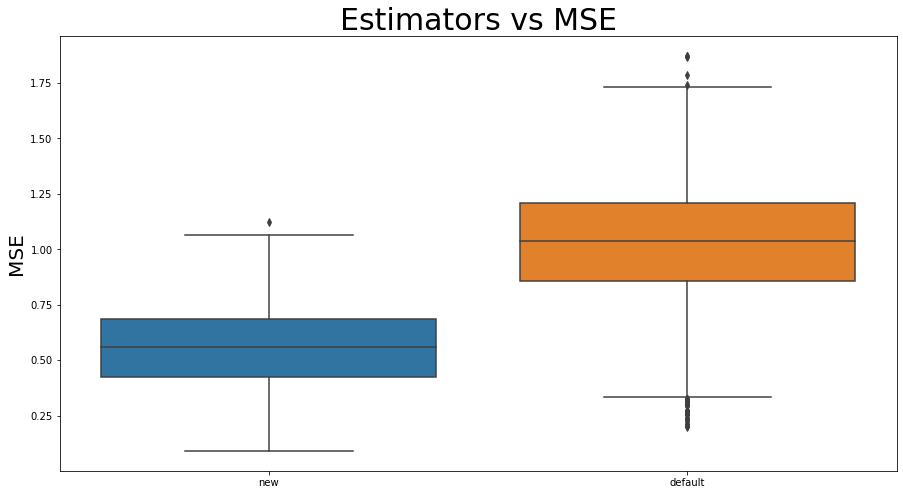

In [ ]:
KNN_params = KNN_res.best_params

models = {}
'''models['old'] = KNeighborsRegressor(weights='distance',
                                          n_neighbors = 70,
                                          n_jobs = -1)
'''
models['new'] = KNeighborsRegressor(**KNN_params)

models['default'] = KNeighborsRegressor(weights = 'uniform', n_neighbors = 3)

results = train_and_test_regressor(models, XS_train, YS_train, XS_test, YS_test)

plot_model_comparison(results)

In [ ]:
optuna.visualization.plot_param_importances(KNN_res)

In [ ]:
optuna.visualization.plot_slice(KNN_res, params = ['weights', 'n_neighbors'])

## Random Forest

In [ ]:
RF_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'min_samples_split' : [2, 10],
    'min_samples_leaf' : [1, 10],
    'criterion' : ['squared_error', 'absolute_error'],      #add 'poisson' for width tuning
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = RandomForest

RF_res = main(X = XS_train, y = YS_train, model_name = model_name, params = RF_params, n_trials = 500)

'''with open(f'RF_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(RF_res.best_params, fp)'''

with open(f'RF_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(RF_res.best_params, fp)

[I 2022-05-13 16:57:37,731] A new study created in memory with name: no-name-1187411e-6798-4377-b255-37738333fc28


Start hyperparameter optimization
{'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 5, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).

[I 2022-05-13 16:57:40,494] Trial 0 finished with value: 1.978368546587291 and parameters: {'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 5, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 16:57:42,567] Trial 1 finished with value: 2.524633726460023 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 9, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:45,186] Trial 3 finished with value: 2.301731583914008 and parameters: {'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 9, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 8, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:47,957] Trial 4 finished with value: 2.246228911059661 and parameters: {'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 8, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 46, 'min_samples_split': 10, 'min_samples_leaf': 9, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:48,231] Trial 2 finished with value: 2.0666749722056936 and parameters: {'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


[I 2022-05-13 16:57:50,709] Trial 5 finished with value: 2.2860011439159464 and parameters: {'max_depth': 46, 'min_samples_split': 10, 'min_samples_leaf': 9, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:57:54,220] Trial 6 finished with value: 2.4688858841147985 and parameters: {'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.
[I 2022-05-13 16:57:54,291] Trial 7 finished with value: 3.1138323487392845 and parameters: {'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:56,878] Trial 9 finished with value: 2.3006183013510686 and parameters: {'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 46, 'min_samples_split': 9, 'min_samples_leaf': 8, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:59,383] Trial 10 finished with value: 2.268754983537945 and parameters: {'max_depth': 46, 'min_samples_split': 9, 'min_samples_leaf': 8, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:00,126] Trial 8 finished with value: 2.4426706282633384 and parameters: {'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:02,250] Trial 11 finished with value: 1.8009006781658592 and parameters: {'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'squared_error'}. Best is trial 11 with value: 1.8009006781658592.


{'n_estimators': 100, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:05,076] Trial 13 finished with value: 1.788820836005253 and parameters: {'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'squared_error'}. Best is trial 13 with value: 1.788820836005253.


{'n_estimators': 100, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:07,944] Trial 14 finished with value: 1.628814589541451 and parameters: {'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 14 with value: 1.628814589541451.


{'n_estimators': 100, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:08,581] Trial 12 finished with value: 1.9218493335667333 and parameters: {'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 14 with value: 1.628814589541451.


{'n_estimators': 100, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:11,275] Trial 15 finished with value: 1.181194342480087 and parameters: {'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:11,964] Trial 16 finished with value: 1.2794064482403935 and parameters: {'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:14,555] Trial 17 finished with value: 1.2025569154064824 and parameters: {'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:15,129] Trial 18 finished with value: 1.2476423811030917 and parameters: {'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:17,589] Trial 19 finished with value: 1.2705580872771405 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 31, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:18,005] Trial 20 finished with value: 1.5476339200450908 and parameters: {'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:20,437] Trial 21 finished with value: 1.552288622445643 and parameters: {'max_depth': 31, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:21,051] Trial 22 finished with value: 1.4013725408868936 and parameters: {'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:23,727] Trial 23 finished with value: 1.254722941177184 and parameters: {'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:24,399] Trial 24 finished with value: 1.2580971536256444 and parameters: {'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:26,734] Trial 25 finished with value: 1.6796934049645613 and parameters: {'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:27,303] Trial 26 finished with value: 1.6564703172252646 and parameters: {'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:29,654] Trial 27 finished with value: 1.6690930182447068 and parameters: {'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:30,127] Trial 28 finished with value: 2.042782132315242 and parameters: {'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:32,338] Trial 29 finished with value: 2.052274794259465 and parameters: {'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:33,127] Trial 30 finished with value: 1.2733403337798295 and parameters: {'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:35,285] Trial 31 finished with value: 1.465713994539609 and parameters: {'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:35,959] Trial 32 finished with value: 1.1989978132865782 and parameters: {'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:38,430] Trial 33 finished with value: 1.4185927609951159 and parameters: {'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:39,106] Trial 34 finished with value: 1.4021863827726155 and parameters: {'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:49,065] Trial 35 finished with value: 1.5065327054715585 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 46, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:50,440] Trial 36 finished with value: 1.1824558161707857 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:51,998] Trial 37 finished with value: 1.33482855715851 and parameters: {'max_depth': 46, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:58,554] Trial 38 finished with value: 2.0633831660938275 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:00,227] Trial 39 finished with value: 2.044466039165648 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:05,935] Trial 40 finished with value: 2.2731113348034055 and parameters: {'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:09,972] Trial 41 finished with value: 1.7631593952074887 and parameters: {'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:17,276] Trial 42 finished with value: 1.143880852213801 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:21,422] Trial 43 finished with value: 1.2006291837729077 and parameters: {'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:27,885] Trial 44 finished with value: 1.472589411505871 and parameters: {'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:31,942] Trial 45 finished with value: 1.453064232337693 and parameters: {'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:38,596] Trial 46 finished with value: 1.511440962407839 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:43,323] Trial 47 finished with value: 1.4971755278198198 and parameters: {'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:50,507] Trial 48 finished with value: 1.2321637004235289 and parameters: {'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:55,239] Trial 49 finished with value: 1.1675067606166185 and parameters: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:00,142] Trial 50 finished with value: 1.758361536648616 and parameters: {'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:03,678] Trial 51 finished with value: 1.9651289174718571 and parameters: {'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:11,981] Trial 52 finished with value: 1.1691314496734755 and parameters: {'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:15,220] Trial 53 finished with value: 1.1888254362424457 and parameters: {'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:23,151] Trial 54 finished with value: 1.184641858552451 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:25,710] Trial 55 finished with value: 1.474479783571649 and parameters: {'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:31,186] Trial 56 finished with value: 1.572009376359254 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:35,761] Trial 57 finished with value: 1.4438284367543375 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:42,354] Trial 58 finished with value: 1.1585017385849004 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:47,563] Trial 59 finished with value: 1.1725085331581224 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:53,719] Trial 60 finished with value: 1.1710740664380104 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:56,662] Trial 61 finished with value: 1.7971376190934862 and parameters: {'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:05,329] Trial 62 finished with value: 1.1583668655943993 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:08,050] Trial 63 finished with value: 1.1716227291138157 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:17,376] Trial 64 finished with value: 1.214113792018897 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:18,841] Trial 65 finished with value: 1.4717943078353313 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:27,960] Trial 66 finished with value: 1.4841146427781857 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:30,365] Trial 67 finished with value: 1.2578273409600906 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:39,611] Trial 68 finished with value: 1.294100005405967 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:41,910] Trial 69 finished with value: 1.1847217257015188 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:51,154] Trial 70 finished with value: 1.1828220082111236 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:52,401] Trial 71 finished with value: 1.442860853259066 and parameters: {'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:02,432] Trial 72 finished with value: 1.1703309788788012 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:03,726] Trial 73 finished with value: 1.2014480827648308 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:10,545] Trial 75 finished with value: 2.3689401380023383 and parameters: {'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:12,904] Trial 74 finished with value: 1.2339150318197385 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:22,429] Trial 76 finished with value: 1.1936657943633364 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:23,412] Trial 77 finished with value: 1.4891132829790776 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:31,947] Trial 78 finished with value: 1.657966966316288 and parameters: {'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:34,967] Trial 79 finished with value: 1.2866260177704334 and parameters: {'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:38,254] Trial 80 finished with value: 2.463310157133228 and parameters: {'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:46,130] Trial 81 finished with value: 1.2368813920934305 and parameters: {'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:49,728] Trial 82 finished with value: 1.166750064638716 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:52,942] Trial 83 finished with value: 2.4366908301414396 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:00,663] Trial 84 finished with value: 1.2049248172156946 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:04,632] Trial 85 finished with value: 1.1912467187261413 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:12,590] Trial 86 finished with value: 1.1329921764216486 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:14,797] Trial 87 finished with value: 1.467898442422873 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:22,483] Trial 89 finished with value: 2.1712666280783672 and parameters: {'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:23,300] Trial 88 finished with value: 1.5274052514110992 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:34,149] Trial 90 finished with value: 1.1970777696157018 and parameters: {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:34,783] Trial 91 finished with value: 1.244115442895618 and parameters: {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:44,915] Trial 92 finished with value: 1.207081450285638 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:45,913] Trial 93 finished with value: 1.1489946840696157 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:56,575] Trial 95 finished with value: 1.505738548510688 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.
[I 2022-05-13 17:03:56,646] Trial 94 finished with value: 1.150032573166909 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:07,701] Trial 97 finished with value: 1.599711295443516 and parameters: {'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:08,104] Trial 96 finished with value: 1.1567977154133593 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:14,907] Trial 98 finished with value: 2.261164967751801 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:18,202] Trial 99 finished with value: 1.4916602203973295 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:23,462] Trial 100 finished with value: 1.5222855304770309 and parameters: {'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:26,282] Trial 101 finished with value: 1.3178743345611637 and parameters: {'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:35,164] Trial 102 finished with value: 1.12694489934444 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:37,620] Trial 103 finished with value: 1.221694970742751 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:46,650] Trial 104 finished with value: 1.1711071240981952 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:49,187] Trial 105 finished with value: 1.179083296267562 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:57,524] Trial 106 finished with value: 1.5216183839476982 and parameters: {'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:00,547] Trial 107 finished with value: 1.255542309209972 and parameters: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:09,008] Trial 108 finished with value: 1.2372806889763683 and parameters: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:11,935] Trial 109 finished with value: 1.231602387929209 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:19,635] Trial 110 finished with value: 1.4607157696552124 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:22,178] Trial 111 finished with value: 1.5302294525467393 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:31,054] Trial 112 finished with value: 1.2230523665762285 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:33,702] Trial 113 finished with value: 1.1241521310320777 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:42,026] Trial 114 finished with value: 1.1879829803391044 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:44,614] Trial 115 finished with value: 1.1740747970436012 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:54,204] Trial 116 finished with value: 1.223940982418635 and parameters: {'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:56,683] Trial 117 finished with value: 1.273936773188964 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:06,212] Trial 118 finished with value: 1.1838913226212546 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:08,369] Trial 119 finished with value: 1.2626673792155443 and parameters: {'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:17,196] Trial 120 finished with value: 1.474109743896052 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:18,907] Trial 121 finished with value: 1.514221131440808 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:28,647] Trial 122 finished with value: 1.1905583254421834 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:30,467] Trial 123 finished with value: 1.177967549656236 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:37,368] Trial 124 finished with value: 1.981414715545292 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:41,640] Trial 125 finished with value: 1.171316092211143 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:48,668] Trial 126 finished with value: 1.1473131919493347 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:53,419] Trial 127 finished with value: 1.1994887798828657 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:59,525] Trial 128 finished with value: 1.4618446332250343 and parameters: {'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:04,192] Trial 129 finished with value: 1.1953180616411176 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:10,547] Trial 130 finished with value: 1.483323273335404 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:15,253] Trial 131 finished with value: 1.4894986892150013 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:22,558] Trial 132 finished with value: 1.2161180110189531 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:27,454] Trial 133 finished with value: 1.2083308368315826 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:34,568] Trial 134 finished with value: 1.1659597667291153 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:39,555] Trial 135 finished with value: 1.160984088875773 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:46,670] Trial 136 finished with value: 1.132621252492637 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:51,596] Trial 137 finished with value: 1.1854621659340958 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:58,787] Trial 138 finished with value: 1.1822109816173385 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:03,574] Trial 139 finished with value: 1.1589917029045154 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:10,800] Trial 140 finished with value: 1.177554904436646 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:15,547] Trial 141 finished with value: 1.1705989486736699 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:22,393] Trial 142 finished with value: 1.1853498541294623 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:27,422] Trial 143 finished with value: 1.2048907346857778 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:34,489] Trial 144 finished with value: 1.169978870314926 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:38,485] Trial 145 finished with value: 1.1811761164748593 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:45,396] Trial 146 finished with value: 1.1289490861423797 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:50,190] Trial 147 finished with value: 1.200054663600225 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:56,388] Trial 148 finished with value: 1.213337165110906 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 17:08:59,342] Trial 150 finished with value: 1.529317758723462 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 113 with value: 1.1241521310320777.
[I 2022-05-13 17:08:59,474] Trial 149 finished with value: 1.2390927119846897 and parameters: {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:11,010] Trial 151 finished with value: 1.1929792221865618 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.
[I 2022-05-13 17:09:11,135] Trial 152 finished with value: 1.1134873161920606 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:22,645] Trial 154 finished with value: 1.2050186939383605 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.
[I 2022-05-13 17:09:22,719] Trial 153 finished with value: 1.1593228998987188 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:34,120] Trial 155 finished with value: 1.180093831423966 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:34,493] Trial 156 finished with value: 1.1604569847833832 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:44,828] Trial 157 finished with value: 1.2372772348707801 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:45,541] Trial 158 finished with value: 1.1721230157243248 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:56,088] Trial 160 finished with value: 1.477285953151706 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.
[I 2022-05-13 17:09:56,113] Trial 159 finished with value: 1.2140522034408263 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:07,816] Trial 161 finished with value: 1.1923569198838977 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:08,276] Trial 162 finished with value: 1.119077707096365 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:18,626] Trial 163 finished with value: 1.1879712059630267 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:19,495] Trial 164 finished with value: 1.2452058300434277 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:30,212] Trial 165 finished with value: 1.1710318016174226 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:31,008] Trial 166 finished with value: 1.1787299888497051 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:35,886] Trial 168 finished with value: 2.5213627758250476 and parameters: {'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:41,721] Trial 167 finished with value: 1.15703327232514 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:46,997] Trial 169 finished with value: 1.3752175153074844 and parameters: {'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:53,515] Trial 170 finished with value: 1.1720691673363643 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:57,449] Trial 171 finished with value: 1.4610939907332772 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:05,114] Trial 172 finished with value: 1.1682730543969568 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:08,940] Trial 173 finished with value: 1.1905605235753418 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:16,439] Trial 174 finished with value: 1.1779271712008301 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:19,478] Trial 175 finished with value: 1.2460556684185957 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:24,723] Trial 176 finished with value: 2.068274649184595 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:11:27,834] Trial 178 finished with value: 1.2456163478350564 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:31,148] Trial 177 finished with value: 1.1078248602789196 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:39,797] Trial 179 finished with value: 1.1506497539919505 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:42,890] Trial 180 finished with value: 1.202041345426748 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:51,578] Trial 181 finished with value: 1.198713739352784 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:54,732] Trial 182 finished with value: 1.1706423644036852 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:03,552] Trial 183 finished with value: 1.172951296215865 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:06,783] Trial 184 finished with value: 1.180412389515366 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:15,422] Trial 185 finished with value: 1.1382857937030884 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:18,637] Trial 186 finished with value: 1.2602397472243891 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:27,484] Trial 187 finished with value: 1.1729345435974994 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:30,885] Trial 188 finished with value: 1.185168783225151 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:39,452] Trial 189 finished with value: 1.1424013145140555 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:42,427] Trial 190 finished with value: 1.143376658799505 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:51,203] Trial 191 finished with value: 1.2108399219702757 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:54,498] Trial 192 finished with value: 1.1598494334885772 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:02,776] Trial 193 finished with value: 1.187442798246762 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:06,385] Trial 194 finished with value: 1.169000991900986 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:14,602] Trial 195 finished with value: 1.2491958408027894 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:17,940] Trial 196 finished with value: 1.199159414392242 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:26,148] Trial 197 finished with value: 1.2163372209524854 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:29,796] Trial 198 finished with value: 1.1307165790834675 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:37,781] Trial 199 finished with value: 1.1212676049759296 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:40,288] Trial 200 finished with value: 1.461979400284331 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:48,068] Trial 201 finished with value: 1.5839103935521048 and parameters: {'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:52,257] Trial 202 finished with value: 1.1446064595631036 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:59,620] Trial 203 finished with value: 1.2094328073347698 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:04,089] Trial 204 finished with value: 1.2110570069814368 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:11,389] Trial 205 finished with value: 1.1950799522127125 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:15,723] Trial 206 finished with value: 1.158329355161334 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:22,981] Trial 207 finished with value: 1.203581502448318 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:14:26,128] Trial 209 finished with value: 1.2435943935824805 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:27,142] Trial 208 finished with value: 1.1670328244712724 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:33,478] Trial 210 finished with value: 2.2574032892943214 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:38,152] Trial 211 finished with value: 1.4910141580765452 and parameters: {'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:41,992] Trial 212 finished with value: 1.954703504141803 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:49,571] Trial 213 finished with value: 1.1709041809353546 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:53,379] Trial 214 finished with value: 1.2101602446139204 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:01,108] Trial 215 finished with value: 1.1806348970538973 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:04,714] Trial 216 finished with value: 1.2380918080974765 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:12,401] Trial 217 finished with value: 1.1612065443754616 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:16,204] Trial 218 finished with value: 1.1191463727887314 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:23,732] Trial 219 finished with value: 1.1882805865566344 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:27,770] Trial 220 finished with value: 1.1511736922576348 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:34,710] Trial 221 finished with value: 1.5467764993641906 and parameters: {'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:39,381] Trial 222 finished with value: 1.2062206097189831 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:45,778] Trial 223 finished with value: 1.637053844952634 and parameters: {'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:50,910] Trial 224 finished with value: 1.1968802009072559 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:57,315] Trial 225 finished with value: 1.103028131397619 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:02,344] Trial 226 finished with value: 1.191127418457795 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:09,165] Trial 227 finished with value: 1.234530299319156 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:13,683] Trial 228 finished with value: 1.1777063682329987 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:20,833] Trial 229 finished with value: 1.210866009683394 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:25,427] Trial 230 finished with value: 1.1786881383700163 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:32,451] Trial 231 finished with value: 1.1959956482434682 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:36,957] Trial 232 finished with value: 1.1825549063663754 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:44,155] Trial 233 finished with value: 1.1852211041163991 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:48,148] Trial 234 finished with value: 1.1669335400195973 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:55,491] Trial 235 finished with value: 1.170925475264075 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:59,395] Trial 236 finished with value: 1.1594221013077501 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:06,585] Trial 237 finished with value: 1.2719641491514309 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:10,480] Trial 238 finished with value: 1.1153461238901545 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:17,772] Trial 239 finished with value: 1.1780116738544302 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:20,926] Trial 240 finished with value: 1.2243732231770044 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:28,501] Trial 241 finished with value: 1.1625119932483032 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:32,335] Trial 242 finished with value: 1.1753791942520566 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:39,388] Trial 243 finished with value: 1.2199728936097585 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:43,505] Trial 244 finished with value: 1.1380879797136763 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:50,646] Trial 245 finished with value: 1.1862385155935091 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:54,226] Trial 246 finished with value: 1.1609363594551931 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:17:57,026] Trial 248 finished with value: 1.240319171593791 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:01,492] Trial 247 finished with value: 1.1711331845358361 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:07,307] Trial 249 finished with value: 1.1738899565032397 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:13,083] Trial 250 finished with value: 1.157137783617969 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:18,417] Trial 251 finished with value: 1.2105293728557704 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:24,130] Trial 252 finished with value: 1.1660638022057075 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:29,757] Trial 253 finished with value: 1.2065985598873112 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:35,424] Trial 254 finished with value: 1.2039262337947254 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:41,024] Trial 255 finished with value: 1.1999996866843965 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:46,788] Trial 256 finished with value: 1.2618069736537696 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:52,479] Trial 257 finished with value: 1.1452974463366967 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:58,126] Trial 258 finished with value: 1.154375104830974 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:03,761] Trial 259 finished with value: 1.2545413076107557 and parameters: {'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:09,669] Trial 260 finished with value: 1.3093219604069677 and parameters: {'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:15,155] Trial 261 finished with value: 1.241167865618889 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:20,057] Trial 262 finished with value: 1.4551474216213707 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:27,114] Trial 263 finished with value: 1.251518289187708 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:31,995] Trial 264 finished with value: 1.2194066336305058 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:38,953] Trial 265 finished with value: 1.180474529402742 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:19:41,907] Trial 267 finished with value: 1.3702006887493554 and parameters: {'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:43,429] Trial 266 finished with value: 1.1517440904595984 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:50,972] Trial 269 finished with value: 2.2012820126378 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:53,427] Trial 268 finished with value: 1.1562991071724902 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:57,913] Trial 270 finished with value: 2.377475810684611 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:04,914] Trial 271 finished with value: 1.1191135051959908 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:09,644] Trial 272 finished with value: 1.156326199119772 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:16,180] Trial 273 finished with value: 1.1959121531616494 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:21,099] Trial 274 finished with value: 1.2473890333606206 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:27,480] Trial 275 finished with value: 1.1892808424030772 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:32,346] Trial 276 finished with value: 1.2040089255012696 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:38,619] Trial 277 finished with value: 1.1831039102308387 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:43,303] Trial 278 finished with value: 1.180991073043804 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:45,010] Trial 279 finished with value: 2.4208097908382955 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:53,662] Trial 280 finished with value: 1.435164114685236 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:54,912] Trial 281 finished with value: 1.4343023595604794 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:03,440] Trial 282 finished with value: 1.7627807071663337 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:06,206] Trial 283 finished with value: 1.1545629778530053 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:14,882] Trial 284 finished with value: 1.177440867283294 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:16,756] Trial 285 finished with value: 1.1760638777508539 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:21,368] Trial 286 finished with value: 2.4635000088705383 and parameters: {'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:21:24,361] Trial 288 finished with value: 1.1821697392176513 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:27,867] Trial 287 finished with value: 1.2229414330704178 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:35,773] Trial 289 finished with value: 1.226905951114108 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:39,225] Trial 290 finished with value: 1.18662267937147 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:46,523] Trial 292 finished with value: 2.30458249379243 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.
[I 2022-05-13 17:21:46,601] Trial 291 finished with value: 1.2509245323328293 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:57,171] Trial 294 finished with value: 1.4737638978914676 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:58,052] Trial 293 finished with value: 1.209528600266012 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:08,261] Trial 295 finished with value: 1.4469951481086052 and parameters: {'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:09,596] Trial 296 finished with value: 1.2473258775016354 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:19,544] Trial 297 finished with value: 1.1934273953963217 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:21,005] Trial 298 finished with value: 1.1989316635814296 and parameters: {'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:30,949] Trial 299 finished with value: 1.2935930565035911 and parameters: {'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:32,190] Trial 300 finished with value: 1.1925784663671652 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:41,881] Trial 301 finished with value: 1.21261758634139 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:43,616] Trial 302 finished with value: 1.1756821978609489 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:53,457] Trial 303 finished with value: 1.2597574178935889 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:53,885] Trial 304 finished with value: 1.4462936719286887 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:22:56,795] Trial 306 finished with value: 1.490769162550888 and parameters: {'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:01,968] Trial 305 finished with value: 1.9505538688259019 and parameters: {'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:08,483] Trial 307 finished with value: 1.1880265217704182 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:13,476] Trial 308 finished with value: 1.2083585999616657 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:19,926] Trial 309 finished with value: 1.1876141141735737 and parameters: {'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:24,679] Trial 310 finished with value: 1.1804717668903657 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:30,837] Trial 311 finished with value: 1.1494148279038068 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:36,299] Trial 312 finished with value: 1.1816225758767644 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:40,945] Trial 313 finished with value: 1.218201425730254 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:47,496] Trial 314 finished with value: 1.1979464978988723 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:50,300] Trial 315 finished with value: 1.175097345247784 and parameters: {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:57,536] Trial 316 finished with value: 1.4487880193583647 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:01,362] Trial 317 finished with value: 1.1704202694647399 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:08,670] Trial 318 finished with value: 1.2341147953952099 and parameters: {'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:12,843] Trial 319 finished with value: 1.1305560667713046 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:20,189] Trial 320 finished with value: 1.2005824747880751 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:24,373] Trial 321 finished with value: 1.2229337782696796 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:31,531] Trial 322 finished with value: 1.1915057628547796 and parameters: {'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:35,679] Trial 323 finished with value: 1.1877534032520276 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:41,942] Trial 324 finished with value: 1.49364971271097 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:24:43,436] Trial 325 finished with value: 2.1235687217965626 and parameters: {'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:44,996] Trial 326 finished with value: 1.2793676615358962 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:54,694] Trial 327 finished with value: 1.185641082138615 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:56,244] Trial 328 finished with value: 1.1958275978720967 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:05,878] Trial 329 finished with value: 1.204853717161622 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:07,656] Trial 330 finished with value: 1.189296699642409 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:17,230] Trial 331 finished with value: 1.1667751720734707 and parameters: {'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:18,749] Trial 332 finished with value: 1.2037164930204065 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:28,874] Trial 333 finished with value: 1.1875775010981893 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:29,223] Trial 334 finished with value: 1.1779964263095795 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:39,154] Trial 336 finished with value: 1.6480748051778877 and parameters: {'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:40,560] Trial 335 finished with value: 1.201768056414314 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:50,539] Trial 337 finished with value: 1.192717683902533 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.
[I 2022-05-13 17:25:50,603] Trial 338 finished with value: 1.1740793392891518 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:00,160] Trial 339 finished with value: 1.160265197141854 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:02,001] Trial 340 finished with value: 1.1660728680621133 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:11,415] Trial 341 finished with value: 1.178160406163767 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:13,040] Trial 342 finished with value: 1.193313995303436 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:22,825] Trial 343 finished with value: 1.1827258621360752 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:23,619] Trial 344 finished with value: 1.1865801798010391 and parameters: {'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:32,931] Trial 345 finished with value: 1.4625513885296448 and parameters: {'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:26:33,774] Trial 346 finished with value: 1.5229790105673047 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:35,921] Trial 347 finished with value: 1.262123583149154 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:45,248] Trial 348 finished with value: 1.1816127328877606 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:47,681] Trial 349 finished with value: 1.1899763323490495 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:56,220] Trial 350 finished with value: 1.1677775492546156 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:58,667] Trial 351 finished with value: 1.5138241509388373 and parameters: {'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:07,975] Trial 352 finished with value: 1.1879460802170954 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:10,195] Trial 353 finished with value: 1.253561278006912 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:19,807] Trial 354 finished with value: 1.1356649747817504 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:21,984] Trial 355 finished with value: 1.192239508890991 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:31,359] Trial 356 finished with value: 1.1543520108393819 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:33,844] Trial 357 finished with value: 1.1902407254222473 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:43,271] Trial 358 finished with value: 1.1604399608532543 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:45,645] Trial 359 finished with value: 1.1440975934824715 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:55,019] Trial 360 finished with value: 1.199106760639329 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:56,067] Trial 361 finished with value: 1.5144722125577939 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:06,281] Trial 362 finished with value: 1.2301484909431897 and parameters: {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:07,704] Trial 363 finished with value: 1.1795149878178168 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:28:10,682] Trial 365 finished with value: 1.197897679128975 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:17,672] Trial 364 finished with value: 1.1832851391855077 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:22,489] Trial 366 finished with value: 1.153505781853255 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:29,158] Trial 367 finished with value: 1.251821486763832 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:34,031] Trial 368 finished with value: 1.1316498788726874 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:40,652] Trial 369 finished with value: 1.1951120697470934 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:45,445] Trial 370 finished with value: 1.1973409866352231 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:52,428] Trial 371 finished with value: 1.181638725605285 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:55,750] Trial 372 finished with value: 1.4448723209861272 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:03,086] Trial 373 finished with value: 1.5644123413331203 and parameters: {'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:07,359] Trial 374 finished with value: 1.1878812910897525 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:14,462] Trial 375 finished with value: 1.2253928568065342 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:18,532] Trial 376 finished with value: 1.1787432174216443 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:26,034] Trial 377 finished with value: 1.1943939811426376 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:29,985] Trial 378 finished with value: 1.2128230888412068 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:37,177] Trial 379 finished with value: 1.20688908051913 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:41,455] Trial 380 finished with value: 1.1857217596939233 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:48,653] Trial 381 finished with value: 1.1786787418737295 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:52,885] Trial 382 finished with value: 1.1933356334092629 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:59,947] Trial 383 finished with value: 1.2623119198600588 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 17:30:02,950] Trial 385 finished with value: 1.6884972168051138 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.
[I 2022-05-13 17:30:03,106] Trial 384 finished with value: 1.5067569810501564 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:13,490] Trial 386 finished with value: 1.4227724250334997 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:14,499] Trial 387 finished with value: 1.2022624562986557 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:21,218] Trial 388 finished with value: 2.1249480647471026 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:25,460] Trial 389 finished with value: 1.211777180057242 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:27,964] Trial 390 finished with value: 1.4753530183428265 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:36,558] Trial 391 finished with value: 1.3781186861627313 and parameters: {'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:38,996] Trial 392 finished with value: 1.4254001519470418 and parameters: {'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:43,411] Trial 393 finished with value: 2.3337252802838515 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:50,366] Trial 394 finished with value: 1.1872276480598727 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:55,139] Trial 395 finished with value: 1.1873697720168186 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:01,790] Trial 396 finished with value: 1.275346793746476 and parameters: {'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:06,558] Trial 397 finished with value: 1.3067997287184032 and parameters: {'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:13,400] Trial 398 finished with value: 1.217292075734614 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:17,888] Trial 399 finished with value: 1.1371882501352102 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:24,952] Trial 400 finished with value: 1.209095124227062 and parameters: {'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:29,305] Trial 401 finished with value: 1.2136163031007552 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:36,652] Trial 402 finished with value: 1.1854576282324638 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:40,504] Trial 403 finished with value: 1.2441784012831438 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:31:43,381] Trial 405 finished with value: 1.147580699517016 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:47,742] Trial 404 finished with value: 1.2027746156362402 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:49,849] Trial 406 finished with value: 2.420379146743405 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:58,216] Trial 407 finished with value: 1.4528913535029244 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:00,603] Trial 408 finished with value: 1.4614378798599719 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:10,155] Trial 409 finished with value: 1.1857880559839535 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:12,184] Trial 410 finished with value: 1.1471472080077212 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:19,092] Trial 411 finished with value: 1.9035781682896886 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:23,803] Trial 412 finished with value: 1.1139391889584007 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:30,746] Trial 413 finished with value: 1.1806296002772605 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:35,637] Trial 414 finished with value: 1.225032509807484 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:42,155] Trial 415 finished with value: 1.165412739428246 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:43,958] Trial 416 finished with value: 2.077221528085837 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:53,379] Trial 417 finished with value: 1.181026452350457 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:55,394] Trial 418 finished with value: 1.145558170991512 and parameters: {'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:05,046] Trial 419 finished with value: 1.1862444716630645 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:06,253] Trial 420 finished with value: 1.4815794122566863 and parameters: {'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:16,573] Trial 421 finished with value: 1.1600518706847947 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:17,274] Trial 422 finished with value: 1.1749555875003121 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:33:20,224] Trial 424 finished with value: 1.169743924670645 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:27,819] Trial 423 finished with value: 1.1804293599129607 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:30,396] Trial 425 finished with value: 1.4872705438153522 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:39,717] Trial 426 finished with value: 1.2078786534517643 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:42,175] Trial 427 finished with value: 1.2026344698126525 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:51,436] Trial 428 finished with value: 1.1904188502025195 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:53,500] Trial 429 finished with value: 1.1897804591743533 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:03,181] Trial 430 finished with value: 1.2381507354788037 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:04,727] Trial 431 finished with value: 1.19458169764021 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:15,108] Trial 432 finished with value: 1.23092544247288 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:16,512] Trial 433 finished with value: 1.1662947900070284 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:26,379] Trial 434 finished with value: 1.1668415112178412 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:28,203] Trial 435 finished with value: 1.1852930350578823 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:37,963] Trial 436 finished with value: 1.207410161363788 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:38,374] Trial 437 finished with value: 1.487823975770247 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:48,224] Trial 438 finished with value: 1.4673422336453563 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:49,650] Trial 439 finished with value: 1.1806692814712174 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:59,810] Trial 440 finished with value: 1.1477544731736748 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:01,480] Trial 441 finished with value: 1.1940987798100002 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:10,683] Trial 442 finished with value: 1.6563940775265784 and parameters: {'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:35:12,974] Trial 443 finished with value: 1.1898507884921545 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:35:13,703] Trial 444 finished with value: 1.4934648694047448 and parameters: {'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:16,060] Trial 445 finished with value: 1.1683822463640088 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:25,517] Trial 446 finished with value: 1.1518980010334032 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:27,903] Trial 447 finished with value: 1.186047891962542 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:37,132] Trial 448 finished with value: 1.185435895609084 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:39,501] Trial 449 finished with value: 1.1784975495350005 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:48,702] Trial 450 finished with value: 1.2093423127024916 and parameters: {'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:51,091] Trial 451 finished with value: 1.1330160084821714 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:00,213] Trial 452 finished with value: 1.1470035991278995 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:02,664] Trial 453 finished with value: 1.1553234183145775 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:10,926] Trial 454 finished with value: 1.4813238367948962 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:13,191] Trial 455 finished with value: 1.4927124578836937 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:22,731] Trial 456 finished with value: 1.16414949184507 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:24,845] Trial 457 finished with value: 1.1879271389881954 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:34,297] Trial 458 finished with value: 1.213735292735305 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:36,267] Trial 459 finished with value: 1.1949092442379416 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:45,212] Trial 460 finished with value: 1.178124282075343 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:48,027] Trial 461 finished with value: 1.1962681497291203 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:56,659] Trial 462 finished with value: 1.1537243726462836 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:59,491] Trial 463 finished with value: 1.2114487068438264 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:07,897] Trial 464 finished with value: 1.1425876109217523 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:10,807] Trial 465 finished with value: 1.1609051504966195 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:19,346] Trial 466 finished with value: 1.1468823432131638 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:21,901] Trial 467 finished with value: 1.0956920694031769 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:30,479] Trial 468 finished with value: 1.1285914605688783 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:33,109] Trial 469 finished with value: 1.143212701499776 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:41,641] Trial 470 finished with value: 1.178571468434348 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:44,307] Trial 471 finished with value: 1.2729830156125765 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:52,964] Trial 472 finished with value: 1.2160798014448368 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:55,450] Trial 473 finished with value: 1.1884895214268503 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:04,240] Trial 474 finished with value: 1.1678661692161447 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:06,954] Trial 475 finished with value: 1.117026009054512 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:15,029] Trial 476 finished with value: 1.168480708284078 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:16,323] Trial 477 finished with value: 1.7634891172771923 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:25,067] Trial 478 finished with value: 1.4007115804155674 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:26,764] Trial 479 finished with value: 1.5275694772246204 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:36,263] Trial 480 finished with value: 1.1521136718252518 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:37,673] Trial 481 finished with value: 1.1525895143415514 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'squared_error'}


[I 2022-05-13 17:38:40,331] Trial 483 finished with value: 2.156694987848099 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'squared_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:43,274] Trial 482 finished with value: 2.24714338344459 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:50,838] Trial 484 finished with value: 1.1998012293248401 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:53,603] Trial 485 finished with value: 1.22926720505713 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:59,840] Trial 487 finished with value: 2.401576064957743 and parameters: {'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:02,072] Trial 486 finished with value: 1.1870324042094513 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:11,006] Trial 488 finished with value: 1.1858557629550408 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:13,621] Trial 489 finished with value: 1.176554591641216 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:22,324] Trial 490 finished with value: 1.174666242842349 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:24,454] Trial 491 finished with value: 1.134145750064165 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:33,519] Trial 492 finished with value: 1.2112604664444344 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:35,802] Trial 493 finished with value: 1.183947300960877 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:44,583] Trial 494 finished with value: 1.2145292020023537 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:46,581] Trial 495 finished with value: 1.545490531003715 and parameters: {'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:55,125] Trial 496 finished with value: 1.160897307986683 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:57,339] Trial 497 finished with value: 1.2014905875137585 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:40:05,426] Trial 498 finished with value: 1.6500821926088503 and parameters: {'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.
[I 2022-05-13 17:40:06,517] Trial 499 finished with value: 1.4986086273998311 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


Best parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


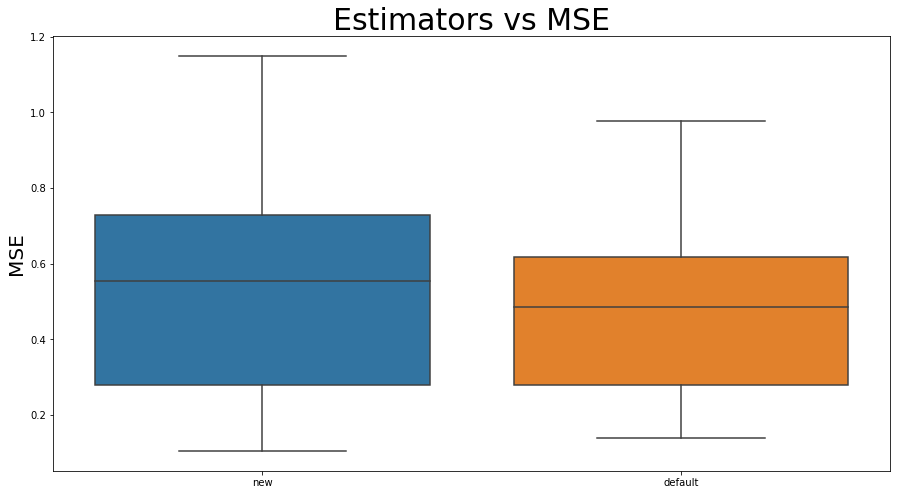

In [ ]:
RF_params = RF_res.best_params

models_RF = {}
'''models_RF['old'] = RandomForestRegressor(n_estimators = 500,
                                      max_depth = 25,
                                      min_samples_leaf = 2,
                                      min_samples_split = 2,
                                      n_jobs = -1)
'''
models_RF['new'] = RandomForestRegressor(**RF_params, n_estimators = 100)

models_RF['default'] = RandomForestRegressor()

results_RF = train_and_test_regressor(models_RF, XS_train, YS_train, XS_test, YS_test)
plot_model_comparison(results_RF)

In [ ]:
model = {}
for i in range(10, 201):
    model[f'{i}'] = RandomForestRegressor(**RF_params, n_estimators = i)

path = train_and_test_regressor(model, XW_train, YW_train, XW_test, YW_test)
plot_model_comparison(path)

In [ ]:
%matplotlib inline
plot_model_comparison(path)

In [ ]:
optuna.visualization.plot_param_importances(RF_res)

## Gradient Boosting

In [ ]:
GB_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'loss' : ['squared_error', 'absolute_error', 'quantile', 'huber'],
    'learning_rate' : [0.01, 0.1],
    'min_samples_leaf' : [1, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = Gradient_Boosting

GB_res = main(X = XW_train, y = YW_train, model_name = model_name, params = GB_params, n_trials = 500)

'''with open(f'GB_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(GB_res.best_params, fp)
'''
'''with open(f'GB_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(GB_res.best_params, fp)'''

with open(f'GB_Scaled_optimal_parameters', 'w') as fp:
    json.dump(GB_res.best_params, fp)

[I 2022-08-17 09:01:45,218] A new study created in memory with name: no-name-aa42611f-548b-43bf-9d42-2fef58cd724f


Start hyperparameter optimization
{'n_estimators': 100, 'learning_rate': 0.014115898801217563, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 2}
{'n_estimators': 100, 'learning_rate': 0.024067435870611324, 'loss': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 5}


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).

[I 2022-08-17 09:01:45,748] Trial 1 finished with value: 1.2996137238795085 and parameters: {'learning_rate': 0.024067435870611324, 'loss': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 5}. Best is trial 1 with value: 1.2996137238795085.


{'n_estimators': 100, 'learning_rate': 0.013849571083859398, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 2}


[I 2022-08-17 09:01:54,413] Trial 0 finished with value: 0.6317067369849496 and parameters: {'learning_rate': 0.014115898801217563, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6317067369849496.


{'n_estimators': 100, 'learning_rate': 0.07931283997962023, 'loss': 'absolute_error', 'max_depth': 1, 'min_samples_leaf': 2}


[I 2022-08-17 09:02:00,145] Trial 3 finished with value: 1.1575951589868512 and parameters: {'learning_rate': 0.07931283997962023, 'loss': 'absolute_error', 'max_depth': 1, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6317067369849496.


{'n_estimators': 100, 'learning_rate': 0.022171926903176355, 'loss': 'quantile', 'max_depth': 32, 'min_samples_leaf': 2}


[I 2022-08-17 09:02:36,702] Trial 4 finished with value: 2.181761184266022 and parameters: {'learning_rate': 0.022171926903176355, 'loss': 'quantile', 'max_depth': 32, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6317067369849496.


{'n_estimators': 100, 'learning_rate': 0.08657206808240872, 'loss': 'squared_error', 'max_depth': 19, 'min_samples_leaf': 7}


[I 2022-08-17 09:02:45,671] Trial 5 finished with value: 0.39167535964229483 and parameters: {'learning_rate': 0.08657206808240872, 'loss': 'squared_error', 'max_depth': 19, 'min_samples_leaf': 7}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.028097800162044856, 'loss': 'absolute_error', 'max_depth': 20, 'min_samples_leaf': 3}


[I 2022-08-17 09:03:07,624] Trial 2 finished with value: 0.6483222863714195 and parameters: {'learning_rate': 0.013849571083859398, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.07486993244226145, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 6}


[I 2022-08-17 09:03:40,513] Trial 7 finished with value: 0.4075015728036425 and parameters: {'learning_rate': 0.07486993244226145, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.017004688408452484, 'loss': 'huber', 'max_depth': 40, 'min_samples_leaf': 10}


[I 2022-08-17 09:03:47,846] Trial 6 finished with value: 0.49060797523156763 and parameters: {'learning_rate': 0.028097800162044856, 'loss': 'absolute_error', 'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.045277405941393095, 'loss': 'absolute_error', 'max_depth': 39, 'min_samples_leaf': 9}


[I 2022-08-17 09:04:01,741] Trial 8 finished with value: 0.615745610751784 and parameters: {'learning_rate': 0.017004688408452484, 'loss': 'huber', 'max_depth': 40, 'min_samples_leaf': 10}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.04376520485319037, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 3}


[I 2022-08-17 09:04:21,669] Trial 9 finished with value: 0.47588334349323524 and parameters: {'learning_rate': 0.045277405941393095, 'loss': 'absolute_error', 'max_depth': 39, 'min_samples_leaf': 9}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.09971425045170469, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 7}


[I 2022-08-17 09:04:29,646] Trial 11 finished with value: 0.39572302996887376 and parameters: {'learning_rate': 0.09971425045170469, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 7}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.09037411271617063, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 7}


[I 2022-08-17 09:04:37,690] Trial 12 finished with value: 0.39657413456723545 and parameters: {'learning_rate': 0.09037411271617063, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 7}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.0984425903960507, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 8}


[I 2022-08-17 09:04:44,794] Trial 13 finished with value: 0.4032838259000588 and parameters: {'learning_rate': 0.0984425903960507, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.06348952051973564, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 5}


[I 2022-08-17 09:04:51,726] Trial 10 finished with value: 0.38950779977251293 and parameters: {'learning_rate': 0.04376520485319037, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 3}. Best is trial 10 with value: 0.38950779977251293.


{'n_estimators': 100, 'learning_rate': 0.052275379246869515, 'loss': 'quantile', 'max_depth': 32, 'min_samples_leaf': 4}


[I 2022-08-17 09:04:52,361] Trial 14 finished with value: 0.37212699874781263 and parameters: {'learning_rate': 0.06348952051973564, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.37212699874781263.


{'n_estimators': 100, 'learning_rate': 0.058808748114369654, 'loss': 'quantile', 'max_depth': 47, 'min_samples_leaf': 4}


[I 2022-08-17 09:05:11,479] Trial 15 finished with value: 1.2192420813976081 and parameters: {'learning_rate': 0.052275379246869515, 'loss': 'quantile', 'max_depth': 32, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.37212699874781263.


{'n_estimators': 100, 'learning_rate': 0.06635531890533346, 'loss': 'huber', 'max_depth': 50, 'min_samples_leaf': 4}


[I 2022-08-17 09:05:15,044] Trial 16 finished with value: 1.0641726832398208 and parameters: {'learning_rate': 0.058808748114369654, 'loss': 'quantile', 'max_depth': 47, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.37212699874781263.


{'n_estimators': 100, 'learning_rate': 0.03782114383857137, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 09:06:08,551] Trial 18 finished with value: 0.39962826636347365 and parameters: {'learning_rate': 0.03782114383857137, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.37212699874781263.


{'n_estimators': 100, 'learning_rate': 0.06462308062005707, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-08-17 09:06:12,091] Trial 17 finished with value: 0.3661189300647801 and parameters: {'learning_rate': 0.06635531890533346, 'loss': 'huber', 'max_depth': 50, 'min_samples_leaf': 4}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.06507204940513377, 'loss': 'huber', 'max_depth': 50, 'min_samples_leaf': 1}


[I 2022-08-17 09:07:27,721] Trial 19 finished with value: 0.3975658084451391 and parameters: {'learning_rate': 0.06462308062005707, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.06929056650920458, 'loss': 'squared_error', 'max_depth': 43, 'min_samples_leaf': 6}


[I 2022-08-17 09:07:35,627] Trial 21 finished with value: 0.3949241834199285 and parameters: {'learning_rate': 0.06929056650920458, 'loss': 'squared_error', 'max_depth': 43, 'min_samples_leaf': 6}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.049668928308511114, 'loss': 'huber', 'max_depth': 50, 'min_samples_leaf': 4}


[I 2022-08-17 09:08:51,727] Trial 22 finished with value: 0.37462249865176545 and parameters: {'learning_rate': 0.049668928308511114, 'loss': 'huber', 'max_depth': 50, 'min_samples_leaf': 4}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.056689914696404164, 'loss': 'huber', 'max_depth': 49, 'min_samples_leaf': 4}


[I 2022-08-17 09:09:26,400] Trial 20 finished with value: 0.41568617530434776 and parameters: {'learning_rate': 0.06507204940513377, 'loss': 'huber', 'max_depth': 50, 'min_samples_leaf': 1}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.054658611961583, 'loss': 'huber', 'max_depth': 44, 'min_samples_leaf': 4}


[I 2022-08-17 09:10:01,786] Trial 23 finished with value: 0.3722964123052332 and parameters: {'learning_rate': 0.056689914696404164, 'loss': 'huber', 'max_depth': 49, 'min_samples_leaf': 4}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.05739352712701232, 'loss': 'huber', 'max_depth': 44, 'min_samples_leaf': 5}


[I 2022-08-17 09:10:29,050] Trial 24 finished with value: 0.3702353205408076 and parameters: {'learning_rate': 0.054658611961583, 'loss': 'huber', 'max_depth': 44, 'min_samples_leaf': 4}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.07430312942995754, 'loss': 'huber', 'max_depth': 37, 'min_samples_leaf': 5}


[I 2022-08-17 09:10:54,318] Trial 25 finished with value: 0.38699645691770185 and parameters: {'learning_rate': 0.05739352712701232, 'loss': 'huber', 'max_depth': 44, 'min_samples_leaf': 5}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.03487995700156798, 'loss': 'absolute_error', 'max_depth': 38, 'min_samples_leaf': 3}


[I 2022-08-17 09:11:14,400] Trial 26 finished with value: 0.38584106441774757 and parameters: {'learning_rate': 0.07430312942995754, 'loss': 'huber', 'max_depth': 37, 'min_samples_leaf': 5}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.03907126332417082, 'loss': 'quantile', 'max_depth': 36, 'min_samples_leaf': 3}


[I 2022-08-17 09:11:37,404] Trial 28 finished with value: 1.5739529489192041 and parameters: {'learning_rate': 0.03907126332417082, 'loss': 'quantile', 'max_depth': 36, 'min_samples_leaf': 3}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.06416410472745902, 'loss': 'absolute_error', 'max_depth': 27, 'min_samples_leaf': 6}


[I 2022-08-17 09:11:43,696] Trial 27 finished with value: 0.431202477043778 and parameters: {'learning_rate': 0.03487995700156798, 'loss': 'absolute_error', 'max_depth': 38, 'min_samples_leaf': 3}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.06374912559070561, 'loss': 'squared_error', 'max_depth': 43, 'min_samples_leaf': 6}


[I 2022-08-17 09:11:48,400] Trial 30 finished with value: 0.3936508186767835 and parameters: {'learning_rate': 0.06374912559070561, 'loss': 'squared_error', 'max_depth': 43, 'min_samples_leaf': 6}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.08173168806633004, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:11:53,677] Trial 31 finished with value: 0.3609546720399299 and parameters: {'learning_rate': 0.08173168806633004, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08445950457675272, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:11:57,911] Trial 29 finished with value: 0.40503199769681036 and parameters: {'learning_rate': 0.06416410472745902, 'loss': 'absolute_error', 'max_depth': 27, 'min_samples_leaf': 6}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08286699276875062, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4}


[I 2022-08-17 09:11:58,453] Trial 32 finished with value: 0.36712028658526696 and parameters: {'learning_rate': 0.08445950457675272, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08500761907431056, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:11:59,530] Trial 33 finished with value: 0.3658193577338505 and parameters: {'learning_rate': 0.08286699276875062, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08723885922767256, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 3}


[I 2022-08-17 09:12:00,528] Trial 35 finished with value: 0.42946209415167774 and parameters: {'learning_rate': 0.08723885922767256, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.0810966164125214, 'loss': 'squared_error', 'max_depth': 16, 'min_samples_leaf': 2}


[I 2022-08-17 09:12:01,322] Trial 34 finished with value: 0.36238691394780104 and parameters: {'learning_rate': 0.08500761907431056, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08167573236356823, 'loss': 'squared_error', 'max_depth': 17, 'min_samples_leaf': 2}


[I 2022-08-17 09:12:04,132] Trial 36 finished with value: 0.40450475537474107 and parameters: {'learning_rate': 0.0810966164125214, 'loss': 'squared_error', 'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.09229612085838265, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 2}


[I 2022-08-17 09:12:05,232] Trial 37 finished with value: 0.40953501008592097 and parameters: {'learning_rate': 0.08167573236356823, 'loss': 'squared_error', 'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.09284633751743576, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 09:12:05,824] Trial 38 finished with value: 0.393648075383991 and parameters: {'learning_rate': 0.09229612085838265, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.07383634976607037, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 5}


[I 2022-08-17 09:12:08,152] Trial 39 finished with value: 0.37453519463925883 and parameters: {'learning_rate': 0.09284633751743576, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.3609546720399299.
[I 2022-08-17 09:12:08,245] Trial 40 finished with value: 0.36816483135064304 and parameters: {'learning_rate': 0.07383634976607037, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 5}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.07425751603304565, 'loss': 'squared_error', 'max_depth': 34, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.08453507366178813, 'loss': 'squared_error', 'max_depth': 35, 'min_samples_leaf': 4}


[I 2022-08-17 09:12:10,694] Trial 41 finished with value: 0.3673514965955613 and parameters: {'learning_rate': 0.07425751603304565, 'loss': 'squared_error', 'max_depth': 34, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08442183390369057, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:12:11,022] Trial 42 finished with value: 0.36836889757200086 and parameters: {'learning_rate': 0.08453507366178813, 'loss': 'squared_error', 'max_depth': 35, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.07866149857720398, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 5}


[I 2022-08-17 09:12:13,422] Trial 43 finished with value: 0.36465312272727246 and parameters: {'learning_rate': 0.08442183390369057, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.
[I 2022-08-17 09:12:13,504] Trial 44 finished with value: 0.36749275208301163 and parameters: {'learning_rate': 0.07866149857720398, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 5}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.07686360033010688, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 3}
{'n_estimators': 100, 'learning_rate': 0.09473576624562663, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 3}


[I 2022-08-17 09:12:16,052] Trial 45 finished with value: 0.37799527052926596 and parameters: {'learning_rate': 0.07686360033010688, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.0960625134104451, 'loss': 'squared_error', 'max_depth': 19, 'min_samples_leaf': 3}


[I 2022-08-17 09:12:16,414] Trial 46 finished with value: 0.3730559117561824 and parameters: {'learning_rate': 0.09473576624562663, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.0705951768447366, 'loss': 'absolute_error', 'max_depth': 17, 'min_samples_leaf': 5}


[I 2022-08-17 09:12:21,254] Trial 47 finished with value: 0.3740062311105604 and parameters: {'learning_rate': 0.0960625134104451, 'loss': 'squared_error', 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.07066678539464409, 'loss': 'quantile', 'max_depth': 16, 'min_samples_leaf': 5}


[I 2022-08-17 09:12:42,372] Trial 49 finished with value: 0.9614604724034285 and parameters: {'learning_rate': 0.07066678539464409, 'loss': 'quantile', 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08766101167629195, 'loss': 'absolute_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:12:48,787] Trial 48 finished with value: 0.40689916852629704 and parameters: {'learning_rate': 0.0705951768447366, 'loss': 'absolute_error', 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08877747306484089, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:12:54,369] Trial 51 finished with value: 0.36286506025375653 and parameters: {'learning_rate': 0.08877747306484089, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08832441355830187, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}


[I 2022-08-17 09:12:59,804] Trial 52 finished with value: 0.36788500868974894 and parameters: {'learning_rate': 0.08832441355830187, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08360121541499735, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:13:05,267] Trial 53 finished with value: 0.3676657255073316 and parameters: {'learning_rate': 0.08360121541499735, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08972349424698156, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:13:10,773] Trial 54 finished with value: 0.36790568948353014 and parameters: {'learning_rate': 0.08972349424698156, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08042381174033277, 'loss': 'squared_error', 'max_depth': 40, 'min_samples_leaf': 6}


[I 2022-08-17 09:13:11,270] Trial 50 finished with value: 0.3828150857916716 and parameters: {'learning_rate': 0.08766101167629195, 'loss': 'absolute_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08029927764220442, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 6}


[I 2022-08-17 09:13:12,993] Trial 56 finished with value: 0.40194861339601234 and parameters: {'learning_rate': 0.08029927764220442, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 6}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.09877572476333614, 'loss': 'squared_error', 'max_depth': 14, 'min_samples_leaf': 3}


[I 2022-08-17 09:13:13,609] Trial 55 finished with value: 0.3912796051900782 and parameters: {'learning_rate': 0.08042381174033277, 'loss': 'squared_error', 'max_depth': 40, 'min_samples_leaf': 6}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.09651582488114094, 'loss': 'quantile', 'max_depth': 1, 'min_samples_leaf': 10}


[I 2022-08-17 09:13:14,696] Trial 58 finished with value: 2.132510655580464 and parameters: {'learning_rate': 0.09651582488114094, 'loss': 'quantile', 'max_depth': 1, 'min_samples_leaf': 10}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.09073120060098398, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 5}


[I 2022-08-17 09:13:15,924] Trial 57 finished with value: 0.37397416755764357 and parameters: {'learning_rate': 0.09877572476333614, 'loss': 'squared_error', 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.0673678711918393, 'loss': 'huber', 'max_depth': 33, 'min_samples_leaf': 5}


[I 2022-08-17 09:13:19,329] Trial 59 finished with value: 0.3678998185360804 and parameters: {'learning_rate': 0.09073120060098398, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 5}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.06799210962173474, 'loss': 'huber', 'max_depth': 34, 'min_samples_leaf': 7}


[I 2022-08-17 09:13:58,445] Trial 61 finished with value: 0.41602338111688414 and parameters: {'learning_rate': 0.06799210962173474, 'loss': 'huber', 'max_depth': 34, 'min_samples_leaf': 7}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08517870650523583, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:00,207] Trial 60 finished with value: 0.3789840089480817 and parameters: {'learning_rate': 0.0673678711918393, 'loss': 'huber', 'max_depth': 33, 'min_samples_leaf': 5}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.0850647531428992, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:02,317] Trial 62 finished with value: 0.3651817111869814 and parameters: {'learning_rate': 0.08517870650523583, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08508090196810947, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:02,924] Trial 63 finished with value: 0.3594967422330223 and parameters: {'learning_rate': 0.0850647531428992, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 63 with value: 0.3594967422330223.


{'n_estimators': 100, 'learning_rate': 0.08543313405922258, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:05,033] Trial 64 finished with value: 0.35794048657716104 and parameters: {'learning_rate': 0.08508090196810947, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08593014779598339, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:05,703] Trial 65 finished with value: 0.3701384572968186 and parameters: {'learning_rate': 0.08543313405922258, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0784554284834358, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 3}


[I 2022-08-17 09:14:07,814] Trial 66 finished with value: 0.36994772767156764 and parameters: {'learning_rate': 0.08593014779598339, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07631325182822193, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 09:14:08,407] Trial 67 finished with value: 0.37938232753981616 and parameters: {'learning_rate': 0.0784554284834358, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09262622580847472, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}


[I 2022-08-17 09:14:10,460] Trial 68 finished with value: 0.3727581033667167 and parameters: {'learning_rate': 0.07631325182822193, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.011564749754260154, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 09:14:11,365] Trial 69 finished with value: 0.3754863683575777 and parameters: {'learning_rate': 0.09262622580847472, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09011471185144328, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 5}


[I 2022-08-17 09:14:12,361] Trial 70 finished with value: 0.7573588053384814 and parameters: {'learning_rate': 0.011564749754260154, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08392356743588628, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:14,055] Trial 71 finished with value: 0.3707189792865976 and parameters: {'learning_rate': 0.09011471185144328, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0825963683016245, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:15,009] Trial 72 finished with value: 0.37371923729243467 and parameters: {'learning_rate': 0.08392356743588628, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08270208131428099, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:16,735] Trial 73 finished with value: 0.3643750432635482 and parameters: {'learning_rate': 0.0825963683016245, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08778391772686689, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:17,693] Trial 74 finished with value: 0.36694890912998357 and parameters: {'learning_rate': 0.08270208131428099, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0873941375224294, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:19,464] Trial 75 finished with value: 0.36690812577214016 and parameters: {'learning_rate': 0.08778391772686689, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.020178262510097564, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:20,464] Trial 76 finished with value: 0.36478598398552875 and parameters: {'learning_rate': 0.0873941375224294, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09392872751668284, 'loss': 'quantile', 'max_depth': 19, 'min_samples_leaf': 5}


[I 2022-08-17 09:14:22,583] Trial 77 finished with value: 0.4677425863542751 and parameters: {'learning_rate': 0.020178262510097564, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09367387051151568, 'loss': 'quantile', 'max_depth': 21, 'min_samples_leaf': 5}


[I 2022-08-17 09:14:40,493] Trial 78 finished with value: 0.8442575009975689 and parameters: {'learning_rate': 0.09392872751668284, 'loss': 'quantile', 'max_depth': 19, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07881737262422368, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 2}


[I 2022-08-17 09:14:42,602] Trial 79 finished with value: 0.8475567520074032 and parameters: {'learning_rate': 0.09367387051151568, 'loss': 'quantile', 'max_depth': 21, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.06123615436614093, 'loss': 'absolute_error', 'max_depth': 28, 'min_samples_leaf': 3}


[I 2022-08-17 09:14:46,193] Trial 80 finished with value: 0.4061188492135571 and parameters: {'learning_rate': 0.07881737262422368, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08947206242383615, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 09:14:51,986] Trial 82 finished with value: 0.37344132016616216 and parameters: {'learning_rate': 0.08947206242383615, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08537879492736748, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:57,404] Trial 83 finished with value: 0.368872515347057 and parameters: {'learning_rate': 0.08537879492736748, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07652423499549653, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:02,780] Trial 84 finished with value: 0.36826707640615264 and parameters: {'learning_rate': 0.07652423499549653, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07239455517081371, 'loss': 'absolute_error', 'max_depth': 23, 'min_samples_leaf': 3}


[I 2022-08-17 09:15:20,580] Trial 81 finished with value: 0.37607901703545343 and parameters: {'learning_rate': 0.06123615436614093, 'loss': 'absolute_error', 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07276710812776518, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:25,838] Trial 86 finished with value: 0.36692375227681895 and parameters: {'learning_rate': 0.07276710812776518, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08196060913454335, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:31,303] Trial 87 finished with value: 0.36676528829609184 and parameters: {'learning_rate': 0.08196060913454335, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.02824655291132565, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 3}


[I 2022-08-17 09:15:36,443] Trial 88 finished with value: 0.3991791501956214 and parameters: {'learning_rate': 0.02824655291132565, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09692312387094389, 'loss': 'squared_error', 'max_depth': 18, 'min_samples_leaf': 5}


[I 2022-08-17 09:15:41,598] Trial 89 finished with value: 0.3703980099137659 and parameters: {'learning_rate': 0.09692312387094389, 'loss': 'squared_error', 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08680449431003287, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:41,864] Trial 85 finished with value: 0.3676224346420878 and parameters: {'learning_rate': 0.07239455517081371, 'loss': 'absolute_error', 'max_depth': 23, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09131933367891033, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:44,493] Trial 90 finished with value: 0.36575267768183767 and parameters: {'learning_rate': 0.08680449431003287, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.
[I 2022-08-17 09:15:44,629] Trial 91 finished with value: 0.36526673791778946 and parameters: {'learning_rate': 0.09131933367891033, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08695425669124425, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.09150039357149951, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:47,252] Trial 92 finished with value: 0.36571862943001804 and parameters: {'learning_rate': 0.08695425669124425, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.
[I 2022-08-17 09:15:47,390] Trial 93 finished with value: 0.36426436898276426 and parameters: {'learning_rate': 0.09150039357149951, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09184269924575283, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.08914769127939251, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 5}


[I 2022-08-17 09:15:49,927] Trial 95 finished with value: 0.3694423698917877 and parameters: {'learning_rate': 0.08914769127939251, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.
[I 2022-08-17 09:15:50,088] Trial 94 finished with value: 0.36424802737369366 and parameters: {'learning_rate': 0.09184269924575283, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08172859341240366, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.09122564642526147, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:52,522] Trial 96 finished with value: 0.36593924437570413 and parameters: {'learning_rate': 0.08172859341240366, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09543042955192663, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 9}


[I 2022-08-17 09:15:52,884] Trial 97 finished with value: 0.3678216543302323 and parameters: {'learning_rate': 0.09122564642526147, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09582975040660748, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 09:15:54,864] Trial 98 finished with value: 0.3902441522953909 and parameters: {'learning_rate': 0.09543042955192663, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 9}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09922561528377083, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 09:15:55,591] Trial 99 finished with value: 0.3703587182167117 and parameters: {'learning_rate': 0.09582975040660748, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09827919845108272, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 3}


[I 2022-08-17 09:15:57,609] Trial 100 finished with value: 0.3610449257174405 and parameters: {'learning_rate': 0.09922561528377083, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09985379967397283, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:58,636] Trial 101 finished with value: 0.3754911397104906 and parameters: {'learning_rate': 0.09827919845108272, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09952758320515807, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:00,533] Trial 102 finished with value: 0.3636613808898369 and parameters: {'learning_rate': 0.09985379967397283, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09988829115722572, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}


[I 2022-08-17 09:16:01,589] Trial 103 finished with value: 0.36601360332215055 and parameters: {'learning_rate': 0.09952758320515807, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09987780960207275, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}


[I 2022-08-17 09:16:03,339] Trial 104 finished with value: 0.3695821202088537 and parameters: {'learning_rate': 0.09988829115722572, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0970587533132194, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}


[I 2022-08-17 09:16:04,349] Trial 105 finished with value: 0.37165563944744767 and parameters: {'learning_rate': 0.09987780960207275, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09725608552145, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:06,077] Trial 106 finished with value: 0.3669384919477867 and parameters: {'learning_rate': 0.0970587533132194, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09256467781976357, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:07,229] Trial 107 finished with value: 0.3611411037680194 and parameters: {'learning_rate': 0.09725608552145, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09237852326165637, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 3}


[I 2022-08-17 09:16:08,901] Trial 108 finished with value: 0.36662821460114153 and parameters: {'learning_rate': 0.09256467781976357, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09792050277216299, 'loss': 'squared_error', 'max_depth': 36, 'min_samples_leaf': 6}


[I 2022-08-17 09:16:10,214] Trial 109 finished with value: 0.37617398105495825 and parameters: {'learning_rate': 0.09237852326165637, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09376388182688271, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 6}


[I 2022-08-17 09:16:11,511] Trial 110 finished with value: 0.38701836143155177 and parameters: {'learning_rate': 0.09792050277216299, 'loss': 'squared_error', 'max_depth': 36, 'min_samples_leaf': 6}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0945849964769225, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:12,832] Trial 111 finished with value: 0.3796648652586507 and parameters: {'learning_rate': 0.09376388182688271, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 6}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09509276712398464, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:14,346] Trial 112 finished with value: 0.3674959087170513 and parameters: {'learning_rate': 0.0945849964769225, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08880425848950353, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:15,694] Trial 113 finished with value: 0.3669922079101276 and parameters: {'learning_rate': 0.09509276712398464, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08868186270274821, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:17,108] Trial 114 finished with value: 0.36551262838344734 and parameters: {'learning_rate': 0.08880425848950353, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08362867574278225, 'loss': 'quantile', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:19,608] Trial 115 finished with value: 0.36079701255239066 and parameters: {'learning_rate': 0.08868186270274821, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09108632262196323, 'loss': 'quantile', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:38,935] Trial 116 finished with value: 0.8928399966837273 and parameters: {'learning_rate': 0.08362867574278225, 'loss': 'quantile', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0908129027466919, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 09:16:41,824] Trial 117 finished with value: 0.8263577718378308 and parameters: {'learning_rate': 0.09108632262196323, 'loss': 'quantile', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09715124813559871, 'loss': 'absolute_error', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 09:16:44,538] Trial 118 finished with value: 0.3735746520005237 and parameters: {'learning_rate': 0.0908129027466919, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.047144809200999664, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:49,247] Trial 120 finished with value: 0.3728839557714094 and parameters: {'learning_rate': 0.047144809200999664, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08851187226025548, 'loss': 'absolute_error', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 09:17:15,468] Trial 119 finished with value: 0.4078870712308727 and parameters: {'learning_rate': 0.09715124813559871, 'loss': 'absolute_error', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08534226788235469, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}


[I 2022-08-17 09:17:20,755] Trial 122 finished with value: 0.36760358584869585 and parameters: {'learning_rate': 0.08534226788235469, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08011230298932767, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:17:22,790] Trial 121 finished with value: 0.3920043743513892 and parameters: {'learning_rate': 0.08851187226025548, 'loss': 'absolute_error', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08368489036819239, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:17:24,435] Trial 123 finished with value: 0.36568298328622867 and parameters: {'learning_rate': 0.08011230298932767, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08365550319750942, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:17:25,493] Trial 124 finished with value: 0.370996254776233 and parameters: {'learning_rate': 0.08368489036819239, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07791988714716926, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 3}


[I 2022-08-17 09:17:27,163] Trial 125 finished with value: 0.3644573277453183 and parameters: {'learning_rate': 0.08365550319750942, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07755229958038902, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 3}


[I 2022-08-17 09:17:28,168] Trial 126 finished with value: 0.3787241101185062 and parameters: {'learning_rate': 0.07791988714716926, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08666047726857742, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:17:33,320] Trial 127 finished with value: 0.37819054920447837 and parameters: {'learning_rate': 0.07755229958038902, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08150423644446868, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:18:27,190] Trial 128 finished with value: 0.36035794401394894 and parameters: {'learning_rate': 0.08666047726857742, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08923896910510747, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:18:36,014] Trial 129 finished with value: 0.3659534710319753 and parameters: {'learning_rate': 0.08150423644446868, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08629687816797046, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 4}


[I 2022-08-17 09:19:29,755] Trial 130 finished with value: 0.3629314073136932 and parameters: {'learning_rate': 0.08923896910510747, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08738634536262348, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:19:36,118] Trial 131 finished with value: 0.3664425275105748 and parameters: {'learning_rate': 0.08629687816797046, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08985959870785788, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:20:32,211] Trial 132 finished with value: 0.3662671316989224 and parameters: {'learning_rate': 0.08738634536262348, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08960355099443654, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:20:39,764] Trial 133 finished with value: 0.36754662058044285 and parameters: {'learning_rate': 0.08985959870785788, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0937991751655827, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:21:34,801] Trial 134 finished with value: 0.37027291987826116 and parameters: {'learning_rate': 0.08960355099443654, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09297713051334075, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-08-17 09:21:41,739] Trial 135 finished with value: 0.36640404470791793 and parameters: {'learning_rate': 0.0937991751655827, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09157919955063985, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 5}


[I 2022-08-17 09:22:32,366] Trial 136 finished with value: 0.3708435107785161 and parameters: {'learning_rate': 0.09297713051334075, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09589155579543873, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 5}


[I 2022-08-17 09:22:34,438] Trial 137 finished with value: 0.37956837550259304 and parameters: {'learning_rate': 0.09157919955063985, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09537111854480457, 'loss': 'huber', 'max_depth': 19, 'min_samples_leaf': 3}


[I 2022-08-17 09:23:26,677] Trial 138 finished with value: 0.3877775178047985 and parameters: {'learning_rate': 0.09589155579543873, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08553447038205991, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 09:23:34,779] Trial 140 finished with value: 0.37874286942103286 and parameters: {'learning_rate': 0.08553447038205991, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07992875830680604, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:37,627] Trial 139 finished with value: 0.3704765637956722 and parameters: {'learning_rate': 0.09537111854480457, 'loss': 'huber', 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07975727575809008, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:39,207] Trial 141 finished with value: 0.36314951793219347 and parameters: {'learning_rate': 0.07992875830680604, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08024208777896145, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:40,263] Trial 142 finished with value: 0.36625332926221005 and parameters: {'learning_rate': 0.07975727575809008, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08235032818133464, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:41,853] Trial 143 finished with value: 0.3676705602823637 and parameters: {'learning_rate': 0.08024208777896145, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08722638047674242, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:42,962] Trial 144 finished with value: 0.3650526164440338 and parameters: {'learning_rate': 0.08235032818133464, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08791372382799616, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:44,599] Trial 145 finished with value: 0.3649798540497341 and parameters: {'learning_rate': 0.08722638047674242, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07540471718490875, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:45,712] Trial 146 finished with value: 0.3677079735909755 and parameters: {'learning_rate': 0.08791372382799616, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0847768544157126, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 7}


[I 2022-08-17 09:23:47,225] Trial 147 finished with value: 0.3627123700101045 and parameters: {'learning_rate': 0.07540471718490875, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09823085638646177, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 7}


[I 2022-08-17 09:23:48,133] Trial 148 finished with value: 0.3933806733784974 and parameters: {'learning_rate': 0.0847768544157126, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 7}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09735471094792728, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 5}


[I 2022-08-17 09:23:49,790] Trial 149 finished with value: 0.3933188660468504 and parameters: {'learning_rate': 0.09823085638646177, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 7}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08980586687829012, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 5}


[I 2022-08-17 09:23:50,862] Trial 150 finished with value: 0.3696420315680289 and parameters: {'learning_rate': 0.09735471094792728, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0814536777521081, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:52,395] Trial 151 finished with value: 0.36630044429124214 and parameters: {'learning_rate': 0.08980586687829012, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07482233579258031, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:53,523] Trial 152 finished with value: 0.36096560553019247 and parameters: {'learning_rate': 0.0814536777521081, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07622722720415162, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:54,951] Trial 153 finished with value: 0.3660544335832154 and parameters: {'learning_rate': 0.07482233579258031, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07630267321609382, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:56,174] Trial 154 finished with value: 0.3647200094854301 and parameters: {'learning_rate': 0.07622722720415162, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08556403632809612, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:57,557] Trial 155 finished with value: 0.36543747460833614 and parameters: {'learning_rate': 0.07630267321609382, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08596102626245401, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:58,916] Trial 156 finished with value: 0.36818747623012016 and parameters: {'learning_rate': 0.08556403632809612, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08115251874119304, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:01,380] Trial 157 finished with value: 0.3648158047365594 and parameters: {'learning_rate': 0.08596102626245401, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08191647279178076, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:02,745] Trial 158 finished with value: 0.3721933530841936 and parameters: {'learning_rate': 0.08115251874119304, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09197491616280087, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:04,192] Trial 159 finished with value: 0.36218869904691775 and parameters: {'learning_rate': 0.08191647279178076, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08272464789738164, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 1}


[I 2022-08-17 09:24:05,565] Trial 160 finished with value: 0.36102071449228224 and parameters: {'learning_rate': 0.09197491616280087, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07875828511784673, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:06,920] Trial 161 finished with value: 0.43356248155305244 and parameters: {'learning_rate': 0.08272464789738164, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 1}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07971000856341975, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:08,213] Trial 162 finished with value: 0.363958088559242 and parameters: {'learning_rate': 0.07875828511784673, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07890120969152978, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:09,566] Trial 163 finished with value: 0.36826968915654523 and parameters: {'learning_rate': 0.07971000856341975, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07804347334799812, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:10,866] Trial 164 finished with value: 0.3671778983281294 and parameters: {'learning_rate': 0.07890120969152978, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08427153581258676, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:12,199] Trial 165 finished with value: 0.36441993069449374 and parameters: {'learning_rate': 0.07804347334799812, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08325529640184028, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}


[I 2022-08-17 09:24:13,630] Trial 166 finished with value: 0.3657388116657577 and parameters: {'learning_rate': 0.08427153581258676, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08255798180381999, 'loss': 'quantile', 'max_depth': 26, 'min_samples_leaf': 3}


[I 2022-08-17 09:24:16,217] Trial 167 finished with value: 0.37463194897548413 and parameters: {'learning_rate': 0.08325529640184028, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08076285164365596, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:52,604] Trial 168 finished with value: 0.8662931438265076 and parameters: {'learning_rate': 0.08255798180381999, 'loss': 'quantile', 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08835995957925906, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:07,484] Trial 169 finished with value: 0.3666168316582984 and parameters: {'learning_rate': 0.08076285164365596, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07130293218251467, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:14,516] Trial 171 finished with value: 0.3659391573523911 and parameters: {'learning_rate': 0.07130293218251467, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08791293841586471, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:21,778] Trial 172 finished with value: 0.3656264248503753 and parameters: {'learning_rate': 0.08791293841586471, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.05266094339329806, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:28,542] Trial 173 finished with value: 0.3720852144059947 and parameters: {'learning_rate': 0.05266094339329806, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08861594292824332, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:33,269] Trial 170 finished with value: 0.3664605320057754 and parameters: {'learning_rate': 0.08835995957925906, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.041757771121196746, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:34,371] Trial 174 finished with value: 0.36379092570764715 and parameters: {'learning_rate': 0.08861594292824332, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08646470603249318, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:35,335] Trial 175 finished with value: 0.37412985814257677 and parameters: {'learning_rate': 0.041757771121196746, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0861202990729882, 'loss': 'absolute_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:38,834] Trial 176 finished with value: 0.360004172041594 and parameters: {'learning_rate': 0.08646470603249318, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08678856396014109, 'loss': 'absolute_error', 'max_depth': 28, 'min_samples_leaf': 5}


[I 2022-08-17 09:26:19,329] Trial 177 finished with value: 0.3825361123848488 and parameters: {'learning_rate': 0.0861202990729882, 'loss': 'absolute_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.
[I 2022-08-17 09:26:19,434] Trial 178 finished with value: 0.39915648689503325 and parameters: {'learning_rate': 0.08678856396014109, 'loss': 'absolute_error', 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08943684422822035, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}
{'n_estimators': 100, 'learning_rate': 0.08967144319425455, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 8}


[I 2022-08-17 09:26:21,807] Trial 180 finished with value: 0.3993014211078215 and parameters: {'learning_rate': 0.08967144319425455, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 8}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08407240205234874, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:22,072] Trial 179 finished with value: 0.3698604105714567 and parameters: {'learning_rate': 0.08943684422822035, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0998975389311368, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:25,654] Trial 181 finished with value: 0.3696931359172659 and parameters: {'learning_rate': 0.08407240205234874, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08133047717220879, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:26,157] Trial 182 finished with value: 0.36319327032526616 and parameters: {'learning_rate': 0.0998975389311368, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0970178236084296, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:28,330] Trial 183 finished with value: 0.35986007491311406 and parameters: {'learning_rate': 0.08133047717220879, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09890536946745858, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:29,058] Trial 184 finished with value: 0.36560684352608275 and parameters: {'learning_rate': 0.0970178236084296, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09894302069205808, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:31,217] Trial 185 finished with value: 0.36327993866713004 and parameters: {'learning_rate': 0.09890536946745858, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08157368781333692, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:31,957] Trial 186 finished with value: 0.36372449384084293 and parameters: {'learning_rate': 0.09894302069205808, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09449297611805982, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:33,898] Trial 187 finished with value: 0.3646931176180672 and parameters: {'learning_rate': 0.08157368781333692, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09416178790585153, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:34,805] Trial 188 finished with value: 0.3654848166722835 and parameters: {'learning_rate': 0.09449297611805982, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08397018377988666, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}


[I 2022-08-17 09:26:36,721] Trial 189 finished with value: 0.365628090297498 and parameters: {'learning_rate': 0.09416178790585153, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08507189261020055, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:37,567] Trial 190 finished with value: 0.3746293822331914 and parameters: {'learning_rate': 0.08397018377988666, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09941113493325549, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:39,436] Trial 191 finished with value: 0.3632004738643838 and parameters: {'learning_rate': 0.08507189261020055, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08542250815587807, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:40,499] Trial 192 finished with value: 0.36347251594889507 and parameters: {'learning_rate': 0.09941113493325549, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08542321384196994, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:42,194] Trial 193 finished with value: 0.3706717705417968 and parameters: {'learning_rate': 0.08542250815587807, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08164332154681911, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:43,190] Trial 194 finished with value: 0.37138727210244826 and parameters: {'learning_rate': 0.08542321384196994, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08181251460567786, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:44,822] Trial 195 finished with value: 0.3646564538915366 and parameters: {'learning_rate': 0.08164332154681911, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08698700575280847, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:45,897] Trial 196 finished with value: 0.3632499959694892 and parameters: {'learning_rate': 0.08181251460567786, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08291620102226238, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:50,426] Trial 197 finished with value: 0.3607011875406656 and parameters: {'learning_rate': 0.08698700575280847, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08632406683798191, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:45,066] Trial 198 finished with value: 0.3697817466749335 and parameters: {'learning_rate': 0.08291620102226238, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08704136718667962, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:48,936] Trial 199 finished with value: 0.36359974284824365 and parameters: {'learning_rate': 0.08632406683798191, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08739668426849707, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:50,259] Trial 200 finished with value: 0.3627215759020895 and parameters: {'learning_rate': 0.08704136718667962, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0871873985388197, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:51,698] Trial 201 finished with value: 0.3667861334002904 and parameters: {'learning_rate': 0.08739668426849707, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0843727543135678, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:52,991] Trial 202 finished with value: 0.36673993034763774 and parameters: {'learning_rate': 0.0871873985388197, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09118138882153252, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:54,395] Trial 203 finished with value: 0.36335033132745614 and parameters: {'learning_rate': 0.0843727543135678, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08969332276935166, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:55,756] Trial 204 finished with value: 0.3671078469462723 and parameters: {'learning_rate': 0.09118138882153252, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08903044552226175, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:57,158] Trial 205 finished with value: 0.3650198595565052 and parameters: {'learning_rate': 0.08969332276935166, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08447905053349276, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:58,551] Trial 206 finished with value: 0.3648372656464587 and parameters: {'learning_rate': 0.08903044552226175, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08397888828904537, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:59,842] Trial 207 finished with value: 0.368463743955748 and parameters: {'learning_rate': 0.08447905053349276, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08015719385042776, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 09:28:01,224] Trial 208 finished with value: 0.36641530340135586 and parameters: {'learning_rate': 0.08397888828904537, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08004105801976456, 'loss': 'quantile', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 09:28:03,456] Trial 209 finished with value: 0.36642040815418037 and parameters: {'learning_rate': 0.08015719385042776, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09201752353134106, 'loss': 'quantile', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:20,512] Trial 210 finished with value: 0.9089553087014289 and parameters: {'learning_rate': 0.08004105801976456, 'loss': 'quantile', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0818272988878737, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:24,668] Trial 211 finished with value: 0.8426936716666468 and parameters: {'learning_rate': 0.09201752353134106, 'loss': 'quantile', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08285163618908704, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:25,168] Trial 212 finished with value: 0.363229129175613 and parameters: {'learning_rate': 0.0818272988878737, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08621898263852842, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:27,400] Trial 213 finished with value: 0.3675042123202325 and parameters: {'learning_rate': 0.08285163618908704, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08628966362423034, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:27,895] Trial 214 finished with value: 0.3669493252887213 and parameters: {'learning_rate': 0.08621898263852842, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08747724810035375, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:30,173] Trial 215 finished with value: 0.364968878836084 and parameters: {'learning_rate': 0.08628966362423034, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08827196775746404, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 3}


[I 2022-08-17 09:28:30,682] Trial 216 finished with value: 0.3649908640814453 and parameters: {'learning_rate': 0.08747724810035375, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08313976828696541, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:33,067] Trial 217 finished with value: 0.37573285882935803 and parameters: {'learning_rate': 0.08827196775746404, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0816269361058914, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:33,450] Trial 218 finished with value: 0.3664484898943139 and parameters: {'learning_rate': 0.08313976828696541, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0810127793095757, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:35,747] Trial 219 finished with value: 0.36795578186932193 and parameters: {'learning_rate': 0.0816269361058914, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07883569690147348, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:36,125] Trial 220 finished with value: 0.3678170045680062 and parameters: {'learning_rate': 0.0810127793095757, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0781320501413688, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:38,398] Trial 221 finished with value: 0.3632821669490601 and parameters: {'learning_rate': 0.07883569690147348, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.03382244370955571, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:38,776] Trial 222 finished with value: 0.3660235605439744 and parameters: {'learning_rate': 0.0781320501413688, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08461970240706257, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:40,477] Trial 223 finished with value: 0.38433447345212085 and parameters: {'learning_rate': 0.03382244370955571, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08456530580902939, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:41,508] Trial 224 finished with value: 0.3662797487312935 and parameters: {'learning_rate': 0.08461970240706257, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08080882065875683, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:43,206] Trial 225 finished with value: 0.37134064433980307 and parameters: {'learning_rate': 0.08456530580902939, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08199770925729231, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:44,166] Trial 226 finished with value: 0.3693994225865706 and parameters: {'learning_rate': 0.08080882065875683, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08228498995491888, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:46,072] Trial 227 finished with value: 0.35861302846368803 and parameters: {'learning_rate': 0.08199770925729231, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08298061097255771, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:47,770] Trial 228 finished with value: 0.36486408107648566 and parameters: {'learning_rate': 0.08228498995491888, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08615526509637698, 'loss': 'huber', 'max_depth': 33, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:49,118] Trial 229 finished with value: 0.36717478494330447 and parameters: {'learning_rate': 0.08298061097255771, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07608835072904402, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:50,787] Trial 230 finished with value: 0.36999819005645035 and parameters: {'learning_rate': 0.08615526509637698, 'loss': 'huber', 'max_depth': 33, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08173608307098021, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:52,766] Trial 231 finished with value: 0.3675055283609406 and parameters: {'learning_rate': 0.07608835072904402, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08140382161368254, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:53,501] Trial 232 finished with value: 0.36313291435460954 and parameters: {'learning_rate': 0.08173608307098021, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08522506837143366, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:55,432] Trial 233 finished with value: 0.36406951304683716 and parameters: {'learning_rate': 0.08140382161368254, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08505859317447914, 'loss': 'squared_error', 'max_depth': 47, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:56,252] Trial 234 finished with value: 0.3641946297719726 and parameters: {'learning_rate': 0.08522506837143366, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08819279117900644, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:58,150] Trial 235 finished with value: 0.35731874137253483 and parameters: {'learning_rate': 0.08505859317447914, 'loss': 'squared_error', 'max_depth': 47, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08891446390328725, 'loss': 'squared_error', 'max_depth': 50, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:59,020] Trial 236 finished with value: 0.36894029090252906 and parameters: {'learning_rate': 0.08819279117900644, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08666266019989755, 'loss': 'squared_error', 'max_depth': 42, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:00,967] Trial 237 finished with value: 0.3664889709609459 and parameters: {'learning_rate': 0.08891446390328725, 'loss': 'squared_error', 'max_depth': 50, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.06179821592136879, 'loss': 'squared_error', 'max_depth': 39, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:01,829] Trial 238 finished with value: 0.3635555498348143 and parameters: {'learning_rate': 0.08666266019989755, 'loss': 'squared_error', 'max_depth': 42, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09045387552616357, 'loss': 'squared_error', 'max_depth': 47, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:03,293] Trial 239 finished with value: 0.3720526052237787 and parameters: {'learning_rate': 0.06179821592136879, 'loss': 'squared_error', 'max_depth': 39, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09097258503202955, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:04,657] Trial 240 finished with value: 0.36688480726894557 and parameters: {'learning_rate': 0.09045387552616357, 'loss': 'squared_error', 'max_depth': 47, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08373828421009206, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:06,065] Trial 241 finished with value: 0.36454730849882416 and parameters: {'learning_rate': 0.09097258503202955, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08370103124723713, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:07,420] Trial 242 finished with value: 0.36809541594794404 and parameters: {'learning_rate': 0.08373828421009206, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07994190338887784, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:08,747] Trial 243 finished with value: 0.3699365533097183 and parameters: {'learning_rate': 0.08370103124723713, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07975470709740749, 'loss': 'squared_error', 'max_depth': 45, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:10,075] Trial 244 finished with value: 0.3714156919517629 and parameters: {'learning_rate': 0.07994190338887784, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08549434447163144, 'loss': 'squared_error', 'max_depth': 47, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:11,422] Trial 245 finished with value: 0.36646844188762373 and parameters: {'learning_rate': 0.07975470709740749, 'loss': 'squared_error', 'max_depth': 45, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08555314150026441, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:12,832] Trial 246 finished with value: 0.37001733108238266 and parameters: {'learning_rate': 0.08549434447163144, 'loss': 'squared_error', 'max_depth': 47, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08735172582636572, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:14,147] Trial 247 finished with value: 0.3706329918501895 and parameters: {'learning_rate': 0.08555314150026441, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08237231534945602, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:15,568] Trial 248 finished with value: 0.3644712717314357 and parameters: {'learning_rate': 0.08735172582636572, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08193874114993825, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:16,873] Trial 249 finished with value: 0.3667763192629231 and parameters: {'learning_rate': 0.08237231534945602, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09638787645716203, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:19,540] Trial 250 finished with value: 0.36322020953134987 and parameters: {'learning_rate': 0.08193874114993825, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08425943959642712, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:03,552] Trial 251 finished with value: 0.3761821772825183 and parameters: {'learning_rate': 0.09638787645716203, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0849440090533955, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 3}


[I 2022-08-17 09:31:05,662] Trial 252 finished with value: 0.36791593304151526 and parameters: {'learning_rate': 0.08425943959642712, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07790638577738278, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 3}


[I 2022-08-17 09:31:07,422] Trial 253 finished with value: 0.37859079265990053 and parameters: {'learning_rate': 0.0849440090533955, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08785615376422734, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:08,360] Trial 254 finished with value: 0.37668979350613957 and parameters: {'learning_rate': 0.07790638577738278, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08764166554130226, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:10,753] Trial 255 finished with value: 0.36784531944147403 and parameters: {'learning_rate': 0.08785615376422734, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09299652741427177, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:13,392] Trial 256 finished with value: 0.3623663717022957 and parameters: {'learning_rate': 0.08764166554130226, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08884828388663611, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 5}


[I 2022-08-17 09:31:45,863] Trial 258 finished with value: 0.3733319129155145 and parameters: {'learning_rate': 0.08884828388663611, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08661386249785905, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:48,500] Trial 257 finished with value: 0.3699127454425418 and parameters: {'learning_rate': 0.09299652741427177, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08691680255195469, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:50,210] Trial 259 finished with value: 0.3638371130890723 and parameters: {'learning_rate': 0.08661386249785905, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0999432146445343, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:51,241] Trial 260 finished with value: 0.36751922191265274 and parameters: {'learning_rate': 0.08691680255195469, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08826645072725417, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:53,117] Trial 261 finished with value: 0.36475810125887065 and parameters: {'learning_rate': 0.0999432146445343, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0901759597292185, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 09:31:53,984] Trial 262 finished with value: 0.36864431065745107 and parameters: {'learning_rate': 0.08826645072725417, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09000478090682998, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 5}


[I 2022-08-17 09:31:55,757] Trial 263 finished with value: 0.3702402810998088 and parameters: {'learning_rate': 0.0901759597292185, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08404072857902029, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:56,598] Trial 264 finished with value: 0.3695132401962192 and parameters: {'learning_rate': 0.09000478090682998, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08369062685099235, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:58,438] Trial 265 finished with value: 0.3665821893124739 and parameters: {'learning_rate': 0.08404072857902029, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09779086471658197, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:59,314] Trial 266 finished with value: 0.36817497966201784 and parameters: {'learning_rate': 0.08369062685099235, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09744203432796217, 'loss': 'squared_error', 'max_depth': 37, 'min_samples_leaf': 4}


[I 2022-08-17 09:32:01,384] Trial 267 finished with value: 0.3676908198934816 and parameters: {'learning_rate': 0.09779086471658197, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08614254198570209, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:32:02,196] Trial 268 finished with value: 0.36703650525255027 and parameters: {'learning_rate': 0.09744203432796217, 'loss': 'squared_error', 'max_depth': 37, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0861077500360045, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 6}


[I 2022-08-17 09:32:04,174] Trial 269 finished with value: 0.36350820369354525 and parameters: {'learning_rate': 0.08614254198570209, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08782340552704758, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:32:04,779] Trial 270 finished with value: 0.3859996760256541 and parameters: {'learning_rate': 0.0861077500360045, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 6}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0916013600688746, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}


[I 2022-08-17 09:32:06,941] Trial 271 finished with value: 0.3674352454544293 and parameters: {'learning_rate': 0.08782340552704758, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09126360041676698, 'loss': 'huber', 'max_depth': 22, 'min_samples_leaf': 3}


[I 2022-08-17 09:32:08,833] Trial 272 finished with value: 0.37410126663769405 and parameters: {'learning_rate': 0.0916013600688746, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08306636242047738, 'loss': 'quantile', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:32:48,224] Trial 274 finished with value: 0.8659503750540315 and parameters: {'learning_rate': 0.08306636242047738, 'loss': 'quantile', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0801174724209547, 'loss': 'huber', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:09,092] Trial 273 finished with value: 0.3776789969773753 and parameters: {'learning_rate': 0.09126360041676698, 'loss': 'huber', 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0799427040184254, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:16,423] Trial 276 finished with value: 0.3686972349489265 and parameters: {'learning_rate': 0.0799427040184254, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09530689686090535, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:24,465] Trial 277 finished with value: 0.3655572552375821 and parameters: {'learning_rate': 0.09530689686090535, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08509787008799365, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:30,876] Trial 275 finished with value: 0.36378645956347333 and parameters: {'learning_rate': 0.0801174724209547, 'loss': 'huber', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0848493402197982, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:31,342] Trial 278 finished with value: 0.3624314780122728 and parameters: {'learning_rate': 0.08509787008799365, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.076847733532002, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:34,795] Trial 279 finished with value: 0.36511884663555644 and parameters: {'learning_rate': 0.0848493402197982, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07377823526780622, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 10}


[I 2022-08-17 09:33:35,097] Trial 280 finished with value: 0.3683984768448762 and parameters: {'learning_rate': 0.076847733532002, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.05635709815223471, 'loss': 'squared_error', 'max_depth': 35, 'min_samples_leaf': 5}


[I 2022-08-17 09:33:36,932] Trial 281 finished with value: 0.40176035620330397 and parameters: {'learning_rate': 0.07377823526780622, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 10}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08860211501839704, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}


[I 2022-08-17 09:33:37,279] Trial 282 finished with value: 0.3705911285423558 and parameters: {'learning_rate': 0.05635709815223471, 'loss': 'squared_error', 'max_depth': 35, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09307573200750902, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:39,567] Trial 283 finished with value: 0.3679987870831757 and parameters: {'learning_rate': 0.08860211501839704, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08301678315228132, 'loss': 'squared_error', 'max_depth': 42, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:40,156] Trial 284 finished with value: 0.36550103333947703 and parameters: {'learning_rate': 0.09307573200750902, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08232712332608677, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:42,318] Trial 285 finished with value: 0.36390762037300933 and parameters: {'learning_rate': 0.08301678315228132, 'loss': 'squared_error', 'max_depth': 42, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08148775461208477, 'loss': 'squared_error', 'max_depth': 2, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:42,888] Trial 286 finished with value: 0.36764598056106246 and parameters: {'learning_rate': 0.08232712332608677, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.
[I 2022-08-17 09:33:43,110] Trial 287 finished with value: 0.548774045484641 and parameters: {'learning_rate': 0.08148775461208477, 'loss': 'squared_error', 'max_depth': 2, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08712208054993104, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.08728478647124017, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:45,635] Trial 288 finished with value: 0.3655913924264248 and parameters: {'learning_rate': 0.08712208054993104, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.
[I 2022-08-17 09:33:45,864] Trial 289 finished with value: 0.36436676111628236 and parameters: {'learning_rate': 0.08728478647124017, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0891356782631983, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.08960797670419886, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:52,360] Trial 290 finished with value: 0.36586646171507387 and parameters: {'learning_rate': 0.0891356782631983, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08498881734381825, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 4}


[I 2022-08-17 09:34:43,660] Trial 291 finished with value: 0.36225285464143187 and parameters: {'learning_rate': 0.08960797670419886, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08998342844843696, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2}


[I 2022-08-17 09:34:52,441] Trial 292 finished with value: 0.3668978942715543 and parameters: {'learning_rate': 0.08498881734381825, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09076924383464052, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 3}


[I 2022-08-17 09:36:18,300] Trial 294 finished with value: 0.3895944054426644 and parameters: {'learning_rate': 0.09076924383464052, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08928799527226026, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:36:30,832] Trial 293 finished with value: 0.41779977100318905 and parameters: {'learning_rate': 0.08998342844843696, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07876313676623407, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:37:22,687] Trial 295 finished with value: 0.36286889273125167 and parameters: {'learning_rate': 0.08928799527226026, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08924258144704891, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:37:34,927] Trial 296 finished with value: 0.37155041438393216 and parameters: {'learning_rate': 0.07876313676623407, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09212072654506405, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:38:26,048] Trial 297 finished with value: 0.3641872801367498 and parameters: {'learning_rate': 0.08924258144704891, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09274641083386755, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:38:38,809] Trial 298 finished with value: 0.36723447038460677 and parameters: {'learning_rate': 0.09212072654506405, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08751681380640128, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 3}


[I 2022-08-17 09:39:31,839] Trial 299 finished with value: 0.3731199119496922 and parameters: {'learning_rate': 0.09274641083386755, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08762731078679864, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:40:00,619] Trial 300 finished with value: 0.3819080134736166 and parameters: {'learning_rate': 0.08751681380640128, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0859259766027459, 'loss': 'huber', 'max_depth': 32, 'min_samples_leaf': 4}


[I 2022-08-17 09:40:34,802] Trial 301 finished with value: 0.36300419489541885 and parameters: {'learning_rate': 0.08762731078679864, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08929027366934214, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:41:03,295] Trial 302 finished with value: 0.36771379596672515 and parameters: {'learning_rate': 0.0859259766027459, 'loss': 'huber', 'max_depth': 32, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08971712837004239, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 5}


[I 2022-08-17 09:41:36,116] Trial 303 finished with value: 0.36622455666174514 and parameters: {'learning_rate': 0.08929027366934214, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09032038424312884, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 5}


[I 2022-08-17 09:41:49,846] Trial 304 finished with value: 0.3778044819188956 and parameters: {'learning_rate': 0.08971712837004239, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08775222344269697, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:41:52,177] Trial 305 finished with value: 0.4187494563277282 and parameters: {'learning_rate': 0.09032038424312884, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.06656763985545575, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:42:51,737] Trial 306 finished with value: 0.3638907299149331 and parameters: {'learning_rate': 0.08775222344269697, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.01742704955039473, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:42:54,544] Trial 307 finished with value: 0.3700814693529733 and parameters: {'learning_rate': 0.06656763985545575, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08581227208871753, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:43:53,663] Trial 308 finished with value: 0.5321834988091394 and parameters: {'learning_rate': 0.01742704955039473, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08555777820384695, 'loss': 'huber', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:43:58,271] Trial 309 finished with value: 0.3672311465204218 and parameters: {'learning_rate': 0.08581227208871753, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08757003405220033, 'loss': 'absolute_error', 'max_depth': 27, 'min_samples_leaf': 9}


[I 2022-08-17 09:44:33,620] Trial 311 finished with value: 0.4332992441904332 and parameters: {'learning_rate': 0.08757003405220033, 'loss': 'absolute_error', 'max_depth': 27, 'min_samples_leaf': 9}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09227750762121036, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:44:42,926] Trial 310 finished with value: 0.3606938709991539 and parameters: {'learning_rate': 0.08555777820384695, 'loss': 'huber', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09398190900308465, 'loss': 'quantile', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:45:20,776] Trial 313 finished with value: 0.8093355076179929 and parameters: {'learning_rate': 0.09398190900308465, 'loss': 'quantile', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08483995361493116, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-08-17 09:45:23,598] Trial 312 finished with value: 0.367024400546037 and parameters: {'learning_rate': 0.09227750762121036, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08454325094830298, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-08-17 09:46:20,814] Trial 314 finished with value: 0.367463510710483 and parameters: {'learning_rate': 0.08483995361493116, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08575221128705886, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-08-17 09:46:22,446] Trial 315 finished with value: 0.36820974470330015 and parameters: {'learning_rate': 0.08454325094830298, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08656243102157844, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 3}


[I 2022-08-17 09:46:24,518] Trial 316 finished with value: 0.3679736677460473 and parameters: {'learning_rate': 0.08575221128705886, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08858851461150652, 'loss': 'squared_error', 'max_depth': 19, 'min_samples_leaf': 3}


[I 2022-08-17 09:46:25,315] Trial 317 finished with value: 0.3744941399667705 and parameters: {'learning_rate': 0.08656243102157844, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08892992847394844, 'loss': 'squared_error', 'max_depth': 48, 'min_samples_leaf': 4}


[I 2022-08-17 09:46:27,287] Trial 318 finished with value: 0.3719912022776605 and parameters: {'learning_rate': 0.08858851461150652, 'loss': 'squared_error', 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09125691653120271, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 8}


[I 2022-08-17 09:46:28,088] Trial 319 finished with value: 0.36665270999278665 and parameters: {'learning_rate': 0.08892992847394844, 'loss': 'squared_error', 'max_depth': 48, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08314053105421731, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:46:30,989] Trial 320 finished with value: 0.39824584298474647 and parameters: {'learning_rate': 0.09125691653120271, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 8}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08403186536887869, 'loss': 'quantile', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:46:50,109] Trial 321 finished with value: 0.8542438092572585 and parameters: {'learning_rate': 0.08314053105421731, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08396854990509905, 'loss': 'absolute_error', 'max_depth': 22, 'min_samples_leaf': 5}


[I 2022-08-17 09:46:55,249] Trial 322 finished with value: 0.8742820326602297 and parameters: {'learning_rate': 0.08403186536887869, 'loss': 'quantile', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.047922973888426076, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 5}


[I 2022-08-17 09:47:29,292] Trial 323 finished with value: 0.4079985101214317 and parameters: {'learning_rate': 0.08396854990509905, 'loss': 'absolute_error', 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08634746452358584, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:47:30,002] Trial 324 finished with value: 0.42368801810104983 and parameters: {'learning_rate': 0.047922973888426076, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0858258218631438, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 4}


[I 2022-08-17 09:47:32,408] Trial 325 finished with value: 0.36333929630803563 and parameters: {'learning_rate': 0.08634746452358584, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.06929394390050966, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:47:32,755] Trial 326 finished with value: 0.3687106160117917 and parameters: {'learning_rate': 0.0858258218631438, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09054291713052846, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:47:38,913] Trial 327 finished with value: 0.3671561318582001 and parameters: {'learning_rate': 0.06929394390050966, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09010278334697465, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:29,162] Trial 328 finished with value: 0.35965366464896575 and parameters: {'learning_rate': 0.09054291713052846, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09481564278067979, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:35,349] Trial 329 finished with value: 0.36859159668402286 and parameters: {'learning_rate': 0.09010278334697465, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09105311013832607, 'loss': 'squared_error', 'max_depth': 45, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:35,940] Trial 330 finished with value: 0.3628549908382917 and parameters: {'learning_rate': 0.09481564278067979, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09405471583636152, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:38,169] Trial 331 finished with value: 0.3666788119646146 and parameters: {'learning_rate': 0.09105311013832607, 'loss': 'squared_error', 'max_depth': 45, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09570138620755757, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:38,814] Trial 332 finished with value: 0.3637546604442319 and parameters: {'learning_rate': 0.09405471583636152, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09512255263004828, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:41,042] Trial 333 finished with value: 0.36688569693618867 and parameters: {'learning_rate': 0.09570138620755757, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09732710862273315, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:41,705] Trial 334 finished with value: 0.36844772672738485 and parameters: {'learning_rate': 0.09512255263004828, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09633514038930292, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:43,944] Trial 335 finished with value: 0.36444771609065807 and parameters: {'learning_rate': 0.09732710862273315, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09579609864219832, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:44,542] Trial 336 finished with value: 0.3622570386554835 and parameters: {'learning_rate': 0.09633514038930292, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09730330481724174, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:46,808] Trial 337 finished with value: 0.36555158640995566 and parameters: {'learning_rate': 0.09579609864219832, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09787884576607139, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 3}


[I 2022-08-17 09:48:47,472] Trial 338 finished with value: 0.3615263629073568 and parameters: {'learning_rate': 0.09730330481724174, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09808191947793003, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 3}


[I 2022-08-17 09:48:49,850] Trial 339 finished with value: 0.37473277493935403 and parameters: {'learning_rate': 0.09787884576607139, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09830104483832477, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:50,536] Trial 340 finished with value: 0.37093380944141885 and parameters: {'learning_rate': 0.09808191947793003, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0960038188324345, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:52,754] Trial 341 finished with value: 0.36575267961852803 and parameters: {'learning_rate': 0.09830104483832477, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09596316466764175, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 6}


[I 2022-08-17 09:48:53,455] Trial 342 finished with value: 0.3623617562717293 and parameters: {'learning_rate': 0.0960038188324345, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09663282791518926, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:55,409] Trial 343 finished with value: 0.3873039925576471 and parameters: {'learning_rate': 0.09596316466764175, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 6}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09659833512109212, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:56,338] Trial 344 finished with value: 0.365682312122659 and parameters: {'learning_rate': 0.09663282791518926, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09352898036708202, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 5}


[I 2022-08-17 09:48:58,297] Trial 345 finished with value: 0.36558884326610785 and parameters: {'learning_rate': 0.09659833512109212, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09302613003220392, 'loss': 'squared_error', 'max_depth': 40, 'min_samples_leaf': 5}


[I 2022-08-17 09:48:59,049] Trial 346 finished with value: 0.36498142348710627 and parameters: {'learning_rate': 0.09352898036708202, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09488931325178802, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:01,031] Trial 347 finished with value: 0.3674876784090729 and parameters: {'learning_rate': 0.09302613003220392, 'loss': 'squared_error', 'max_depth': 40, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09936140532838035, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:01,957] Trial 348 finished with value: 0.36538063879487537 and parameters: {'learning_rate': 0.09488931325178802, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09785517530730044, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:03,982] Trial 349 finished with value: 0.36479097993594334 and parameters: {'learning_rate': 0.09936140532838035, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08183626893624003, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:04,861] Trial 350 finished with value: 0.367088250301681 and parameters: {'learning_rate': 0.09785517530730044, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09998791353919269, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:06,658] Trial 351 finished with value: 0.36147260688496696 and parameters: {'learning_rate': 0.08183626893624003, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.025656190651725145, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:07,834] Trial 352 finished with value: 0.3637400428090919 and parameters: {'learning_rate': 0.09998791353919269, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0824921838472679, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:08,714] Trial 353 finished with value: 0.4113803150073766 and parameters: {'learning_rate': 0.025656190651725145, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08132896798251064, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:10,556] Trial 354 finished with value: 0.3652415998947633 and parameters: {'learning_rate': 0.0824921838472679, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08090219114374536, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}


[I 2022-08-17 09:49:11,397] Trial 355 finished with value: 0.36496514400944335 and parameters: {'learning_rate': 0.08132896798251064, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08294250953343864, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:13,299] Trial 356 finished with value: 0.37898537573750063 and parameters: {'learning_rate': 0.08090219114374536, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.010048823608376896, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 7}


[I 2022-08-17 09:49:14,145] Trial 357 finished with value: 0.364592868738255 and parameters: {'learning_rate': 0.08294250953343864, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09345739338539708, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:15,050] Trial 358 finished with value: 0.8814929056150328 and parameters: {'learning_rate': 0.010048823608376896, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0932864425583523, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:17,013] Trial 359 finished with value: 0.3669774248557439 and parameters: {'learning_rate': 0.09345739338539708, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08428738464481102, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:17,878] Trial 360 finished with value: 0.36423669668817843 and parameters: {'learning_rate': 0.0932864425583523, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08429848052317186, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:19,772] Trial 361 finished with value: 0.36453123537451315 and parameters: {'learning_rate': 0.08428738464481102, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07974225203776766, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:20,669] Trial 362 finished with value: 0.3659239320833427 and parameters: {'learning_rate': 0.08429848052317186, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07979231334176036, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:22,450] Trial 363 finished with value: 0.3664799983148475 and parameters: {'learning_rate': 0.07974225203776766, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09591218348451684, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 1}


[I 2022-08-17 09:49:23,309] Trial 364 finished with value: 0.3697576043311646 and parameters: {'learning_rate': 0.07979231334176036, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09580917048678092, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}


[I 2022-08-17 09:49:25,153] Trial 365 finished with value: 0.4358001430492505 and parameters: {'learning_rate': 0.09591218348451684, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 1}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09176345626848278, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}


[I 2022-08-17 09:49:26,052] Trial 366 finished with value: 0.372316872126113 and parameters: {'learning_rate': 0.09580917048678092, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.03347654275806246, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:27,856] Trial 367 finished with value: 0.3661982436039089 and parameters: {'learning_rate': 0.09176345626848278, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08319046839051182, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:28,623] Trial 368 finished with value: 0.38748400757471174 and parameters: {'learning_rate': 0.03347654275806246, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08239397209968924, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:50:24,295] Trial 369 finished with value: 0.3639359500649668 and parameters: {'learning_rate': 0.08319046839051182, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08588638180860968, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:50:29,131] Trial 370 finished with value: 0.3654802773286569 and parameters: {'learning_rate': 0.08239397209968924, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08589001702854572, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:50:34,161] Trial 372 finished with value: 0.36620016107304393 and parameters: {'learning_rate': 0.08589001702854572, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09826176248776836, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:50:46,958] Trial 371 finished with value: 0.8508743279850985 and parameters: {'learning_rate': 0.08588638180860968, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09807418172705094, 'loss': 'absolute_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:51:22,749] Trial 373 finished with value: 0.3795435917822533 and parameters: {'learning_rate': 0.09826176248776836, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08748192085190626, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}


[I 2022-08-17 09:51:28,352] Trial 375 finished with value: 0.37465153053071815 and parameters: {'learning_rate': 0.08748192085190626, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08167745721602461, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:51:30,044] Trial 374 finished with value: 0.37937444906450923 and parameters: {'learning_rate': 0.09807418172705094, 'loss': 'absolute_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07737191257817293, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:51:31,952] Trial 376 finished with value: 0.36795417427163346 and parameters: {'learning_rate': 0.08167745721602461, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07779901314732483, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:51:32,624] Trial 377 finished with value: 0.36279606626327304 and parameters: {'learning_rate': 0.07737191257817293, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08503344680543806, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:51:34,579] Trial 378 finished with value: 0.3692942138382206 and parameters: {'learning_rate': 0.07779901314732483, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08444341910565589, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 5}


[I 2022-08-17 09:51:35,362] Trial 379 finished with value: 0.36111412985777797 and parameters: {'learning_rate': 0.08503344680543806, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.051657390465293766, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:51:37,218] Trial 380 finished with value: 0.36775234530235484 and parameters: {'learning_rate': 0.08444341910565589, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09126310839253686, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:51:38,065] Trial 381 finished with value: 0.3693968855880878 and parameters: {'learning_rate': 0.051657390465293766, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09164128783831951, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:52:39,205] Trial 382 finished with value: 0.3647775460098151 and parameters: {'learning_rate': 0.09126310839253686, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09429570065748112, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:52:40,176] Trial 383 finished with value: 0.3674545749344853 and parameters: {'learning_rate': 0.09164128783831951, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09458634582727013, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 3}


[I 2022-08-17 09:52:42,646] Trial 384 finished with value: 0.3710534556941595 and parameters: {'learning_rate': 0.09429570065748112, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08783170948125277, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}


[I 2022-08-17 09:52:43,136] Trial 385 finished with value: 0.37232320989959733 and parameters: {'learning_rate': 0.09458634582727013, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08710642792802734, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:52:45,492] Trial 386 finished with value: 0.37218631802442953 and parameters: {'learning_rate': 0.08783170948125277, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08300607085159835, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:52:45,894] Trial 387 finished with value: 0.36768911543888044 and parameters: {'learning_rate': 0.08710642792802734, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08101632987108397, 'loss': 'squared_error', 'max_depth': 38, 'min_samples_leaf': 5}


[I 2022-08-17 09:52:48,226] Trial 388 finished with value: 0.3648577960314166 and parameters: {'learning_rate': 0.08300607085159835, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.
[I 2022-08-17 09:52:48,467] Trial 389 finished with value: 0.3703085477393394 and parameters: {'learning_rate': 0.08101632987108397, 'loss': 'squared_error', 'max_depth': 38, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08073171584826273, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 6}
{'n_estimators': 100, 'learning_rate': 0.08865365316846315, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:52:50,689] Trial 390 finished with value: 0.389717644326302 and parameters: {'learning_rate': 0.08073171584826273, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08915253744679198, 'loss': 'squared_error', 'max_depth': 49, 'min_samples_leaf': 4}


[I 2022-08-17 09:52:51,267] Trial 391 finished with value: 0.36487693505634267 and parameters: {'learning_rate': 0.08865365316846315, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08508274763937192, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:52:57,301] Trial 392 finished with value: 0.3668719047824799 and parameters: {'learning_rate': 0.08915253744679198, 'loss': 'squared_error', 'max_depth': 49, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.04209981122981328, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:53:49,742] Trial 393 finished with value: 0.36039458677062297 and parameters: {'learning_rate': 0.08508274763937192, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08503066410176306, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:54:00,316] Trial 394 finished with value: 0.3748170910003762 and parameters: {'learning_rate': 0.04209981122981328, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08492666233810761, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:54:53,950] Trial 395 finished with value: 0.3640570307032519 and parameters: {'learning_rate': 0.08503066410176306, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09677377012709999, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:55:03,128] Trial 396 finished with value: 0.36395750095653645 and parameters: {'learning_rate': 0.08492666233810761, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09725807984921289, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:55:57,524] Trial 397 finished with value: 0.3641847852400475 and parameters: {'learning_rate': 0.09677377012709999, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08350160572426764, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:56:05,621] Trial 398 finished with value: 0.3620228117986346 and parameters: {'learning_rate': 0.09725807984921289, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09636541667061617, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:57:01,165] Trial 399 finished with value: 0.3655609436723182 and parameters: {'learning_rate': 0.08350160572426764, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09723544018317426, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 5}


[I 2022-08-17 09:57:07,736] Trial 400 finished with value: 0.3607985232410527 and parameters: {'learning_rate': 0.09636541667061617, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0976171289769762, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:57:53,596] Trial 401 finished with value: 0.3840008445059964 and parameters: {'learning_rate': 0.09723544018317426, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09882122266773834, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:58:08,622] Trial 402 finished with value: 0.36309178847378265 and parameters: {'learning_rate': 0.0976171289769762, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09911583235012875, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:58:57,352] Trial 403 finished with value: 0.3676597988316545 and parameters: {'learning_rate': 0.09882122266773834, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09389563416819821, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:59:11,960] Trial 404 finished with value: 0.36343282749636197 and parameters: {'learning_rate': 0.09911583235012875, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0999640060331434, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 3}


[I 2022-08-17 10:00:03,081] Trial 405 finished with value: 0.3693238943833389 and parameters: {'learning_rate': 0.09389563416819821, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09598582828205104, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 3}


[I 2022-08-17 10:00:32,450] Trial 406 finished with value: 0.3809184684482325 and parameters: {'learning_rate': 0.0999640060331434, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09655097615329963, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:01:06,653] Trial 407 finished with value: 0.3733635862479202 and parameters: {'learning_rate': 0.09598582828205104, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09329771365573954, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:01:34,832] Trial 408 finished with value: 0.3637342885201026 and parameters: {'learning_rate': 0.09655097615329963, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0825395183595025, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:02:09,536] Trial 409 finished with value: 0.3665287801332975 and parameters: {'learning_rate': 0.09329771365573954, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08229837841593715, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 10:02:36,941] Trial 410 finished with value: 0.36231608038859775 and parameters: {'learning_rate': 0.0825395183595025, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07872515092297327, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 10:03:01,566] Trial 411 finished with value: 0.3796501175197417 and parameters: {'learning_rate': 0.08229837841593715, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08625099990174594, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:03:28,511] Trial 412 finished with value: 0.37981719191580954 and parameters: {'learning_rate': 0.07872515092297327, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09237128768547745, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:04:03,578] Trial 413 finished with value: 0.36091864791543676 and parameters: {'learning_rate': 0.08625099990174594, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08638895878354887, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 8}


[I 2022-08-17 10:04:28,818] Trial 414 finished with value: 0.3647858528739246 and parameters: {'learning_rate': 0.09237128768547745, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08641370400302785, 'loss': 'huber', 'max_depth': 44, 'min_samples_leaf': 4}


[I 2022-08-17 10:04:38,761] Trial 415 finished with value: 0.42187969561766714 and parameters: {'learning_rate': 0.08638895878354887, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 8}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08548691564736913, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:05:31,811] Trial 416 finished with value: 0.3633229419770327 and parameters: {'learning_rate': 0.08641370400302785, 'loss': 'huber', 'max_depth': 44, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08425731258182223, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:05:41,726] Trial 417 finished with value: 0.36174347146799074 and parameters: {'learning_rate': 0.08548691564736913, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08374360488644253, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:06:35,283] Trial 418 finished with value: 0.3647773173530136 and parameters: {'learning_rate': 0.08425731258182223, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08374782033038301, 'loss': 'huber', 'max_depth': 35, 'min_samples_leaf': 4}


[I 2022-08-17 10:06:44,549] Trial 419 finished with value: 0.3646580844773495 and parameters: {'learning_rate': 0.08374360488644253, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08569278584254354, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 10:07:38,801] Trial 420 finished with value: 0.36642032391572277 and parameters: {'learning_rate': 0.08374782033038301, 'loss': 'huber', 'max_depth': 35, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08061020876889269, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 10:07:47,000] Trial 421 finished with value: 0.36569269773869445 and parameters: {'learning_rate': 0.08569278584254354, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08089217152068626, 'loss': 'huber', 'max_depth': 41, 'min_samples_leaf': 4}


[I 2022-08-17 10:08:41,827] Trial 422 finished with value: 0.36834009403767215 and parameters: {'learning_rate': 0.08061020876889269, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08185797548583224, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:08:50,167] Trial 423 finished with value: 0.3658336905699989 and parameters: {'learning_rate': 0.08089217152068626, 'loss': 'huber', 'max_depth': 41, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08584969968690975, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 3}


[I 2022-08-17 10:09:31,650] Trial 424 finished with value: 0.3667825588106936 and parameters: {'learning_rate': 0.08185797548583224, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08657108552655111, 'loss': 'quantile', 'max_depth': 26, 'min_samples_leaf': 3}


[I 2022-08-17 10:09:32,414] Trial 425 finished with value: 0.8377253677824559 and parameters: {'learning_rate': 0.08584969968690975, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08755996813147818, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:10:15,079] Trial 426 finished with value: 0.8338672207066349 and parameters: {'learning_rate': 0.08657108552655111, 'loss': 'quantile', 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.079384178827533, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:10:21,425] Trial 427 finished with value: 0.3643510549887029 and parameters: {'learning_rate': 0.08755996813147818, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07915378764296617, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:11:18,582] Trial 428 finished with value: 0.3705171496103624 and parameters: {'learning_rate': 0.079384178827533, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08294505376763935, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 10:11:24,799] Trial 429 finished with value: 0.3638776878732465 and parameters: {'learning_rate': 0.07915378764296617, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08337801512218157, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 10:12:21,639] Trial 430 finished with value: 0.3664584297315264 and parameters: {'learning_rate': 0.08294505376763935, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08484089906465195, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:12:28,126] Trial 431 finished with value: 0.36944676999729664 and parameters: {'learning_rate': 0.08337801512218157, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08528687635002778, 'loss': 'absolute_error', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 10:13:11,893] Trial 432 finished with value: 0.3652981157974068 and parameters: {'learning_rate': 0.08484089906465195, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08836518944246319, 'loss': 'absolute_error', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 10:13:20,876] Trial 433 finished with value: 0.40151759188793845 and parameters: {'learning_rate': 0.08528687635002778, 'loss': 'absolute_error', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08747689018798266, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:14:04,478] Trial 434 finished with value: 0.3919568653593092 and parameters: {'learning_rate': 0.08836518944246319, 'loss': 'absolute_error', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09043703490703085, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:14:10,818] Trial 435 finished with value: 0.3626101538596585 and parameters: {'learning_rate': 0.08747689018798266, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08996609619964978, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:15:08,113] Trial 436 finished with value: 0.36625086292516207 and parameters: {'learning_rate': 0.09043703490703085, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08229969835353505, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:15:13,455] Trial 437 finished with value: 0.3712757777130604 and parameters: {'learning_rate': 0.08996609619964978, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.081371417969913, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:16:11,933] Trial 438 finished with value: 0.3616780708101629 and parameters: {'learning_rate': 0.08229969835353505, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0848660435802571, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:16:15,715] Trial 439 finished with value: 0.36672671974461496 and parameters: {'learning_rate': 0.081371417969913, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08470434509343204, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:17:15,458] Trial 440 finished with value: 0.3634351674891363 and parameters: {'learning_rate': 0.0848660435802571, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08631858954631795, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 6}


[I 2022-08-17 10:17:17,032] Trial 441 finished with value: 0.3652344217193003 and parameters: {'learning_rate': 0.08470434509343204, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07522387602277596, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:18:01,755] Trial 442 finished with value: 0.40232331499242796 and parameters: {'learning_rate': 0.08631858954631795, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08313125856629013, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 10:18:16,545] Trial 443 finished with value: 0.3669847849140566 and parameters: {'learning_rate': 0.07522387602277596, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08256759182412193, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 4}


[I 2022-08-17 10:18:44,372] Trial 445 finished with value: 0.36734414913418295 and parameters: {'learning_rate': 0.08256759182412193, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0874185741564655, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 4}


[I 2022-08-17 10:19:00,673] Trial 444 finished with value: 0.36627190799283377 and parameters: {'learning_rate': 0.08313125856629013, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08624208613896879, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:19:44,303] Trial 446 finished with value: 0.36705450974516163 and parameters: {'learning_rate': 0.0874185741564655, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.06435971962411516, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 10:20:04,585] Trial 447 finished with value: 0.3641661466793084 and parameters: {'learning_rate': 0.08624208613896879, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.061520741133644474, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 10:21:06,336] Trial 448 finished with value: 0.3782088819691694 and parameters: {'learning_rate': 0.06435971962411516, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09824156277094187, 'loss': 'huber', 'max_depth': 32, 'min_samples_leaf': 5}


[I 2022-08-17 10:21:10,337] Trial 449 finished with value: 0.369371113044601 and parameters: {'learning_rate': 0.061520741133644474, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08810714627818292, 'loss': 'quantile', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 10:21:41,627] Trial 451 finished with value: 0.8543572958227055 and parameters: {'learning_rate': 0.08810714627818292, 'loss': 'quantile', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09886841371975513, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:21:47,696] Trial 450 finished with value: 0.377937224427987 and parameters: {'learning_rate': 0.09824156277094187, 'loss': 'huber', 'max_depth': 32, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09975617059338027, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:22:44,277] Trial 452 finished with value: 0.3704141920698 and parameters: {'learning_rate': 0.09886841371975513, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0778245230420086, 'loss': 'squared_error', 'max_depth': 18, 'min_samples_leaf': 4}


[I 2022-08-17 10:22:50,204] Trial 453 finished with value: 0.36582713478876955 and parameters: {'learning_rate': 0.09975617059338027, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0843798430102915, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:22:50,780] Trial 454 finished with value: 0.36635690256151726 and parameters: {'learning_rate': 0.0778245230420086, 'loss': 'squared_error', 'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08451640164792647, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:22:55,251] Trial 455 finished with value: 0.366490218060292 and parameters: {'learning_rate': 0.0843798430102915, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08104348795432965, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:22:56,228] Trial 456 finished with value: 0.36487565775453545 and parameters: {'learning_rate': 0.08451640164792647, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08114631847952626, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:22:59,989] Trial 457 finished with value: 0.3695893023349138 and parameters: {'learning_rate': 0.08104348795432965, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08920339167260155, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:23:01,230] Trial 458 finished with value: 0.3670833288418275 and parameters: {'learning_rate': 0.08114631847952626, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09005133733099954, 'loss': 'huber', 'max_depth': 46, 'min_samples_leaf': 3}


[I 2022-08-17 10:24:05,692] Trial 459 finished with value: 0.3632315749532893 and parameters: {'learning_rate': 0.08920339167260155, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0949714841946308, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:24:14,071] Trial 461 finished with value: 0.36925189224223265 and parameters: {'learning_rate': 0.0949714841946308, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09109437206143314, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 10:24:15,988] Trial 460 finished with value: 0.3782666308282402 and parameters: {'learning_rate': 0.09005133733099954, 'loss': 'huber', 'max_depth': 46, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08278608670136163, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 10:24:24,427] Trial 463 finished with value: 0.37425438854798965 and parameters: {'learning_rate': 0.08278608670136163, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09190802210125862, 'loss': 'squared_error', 'max_depth': 37, 'min_samples_leaf': 4}


[I 2022-08-17 10:24:32,379] Trial 464 finished with value: 0.3628065209975291 and parameters: {'learning_rate': 0.09190802210125862, 'loss': 'squared_error', 'max_depth': 37, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08647404053128238, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 10:25:19,025] Trial 462 finished with value: 0.38338749857172905 and parameters: {'learning_rate': 0.09109437206143314, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.03582820324694386, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:25:25,546] Trial 466 finished with value: 0.3802785059930281 and parameters: {'learning_rate': 0.03582820324694386, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08666496518009753, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 9}


[I 2022-08-17 10:25:30,253] Trial 465 finished with value: 0.35921958010037536 and parameters: {'learning_rate': 0.08647404053128238, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08714974407520923, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 10:25:36,424] Trial 468 finished with value: 0.36564200376180017 and parameters: {'learning_rate': 0.08714974407520923, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08595734595326672, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 10:25:42,746] Trial 469 finished with value: 0.36206879411049375 and parameters: {'learning_rate': 0.08595734595326672, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08814052445459941, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 10:25:44,744] Trial 467 finished with value: 0.43566218843388915 and parameters: {'learning_rate': 0.08666496518009753, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 9}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08812035749920803, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 10:25:52,266] Trial 471 finished with value: 0.3674457554496004 and parameters: {'learning_rate': 0.08812035749920803, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08384679201651338, 'loss': 'absolute_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 10:26:27,759] Trial 470 finished with value: 0.3737387220208722 and parameters: {'learning_rate': 0.08814052445459941, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08362468105186013, 'loss': 'absolute_error', 'max_depth': 11, 'min_samples_leaf': 4}


[I 2022-08-17 10:26:49,651] Trial 472 finished with value: 0.38597288402524127 and parameters: {'learning_rate': 0.08384679201651338, 'loss': 'absolute_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08573566404220422, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:26:54,688] Trial 474 finished with value: 0.369180017460413 and parameters: {'learning_rate': 0.08573566404220422, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.05941327211187913, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:26:55,581] Trial 473 finished with value: 0.3859867496974864 and parameters: {'learning_rate': 0.08362468105186013, 'loss': 'absolute_error', 'max_depth': 11, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0802599734456075, 'loss': 'quantile', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:27:15,946] Trial 475 finished with value: 1.0836645506322182 and parameters: {'learning_rate': 0.05941327211187913, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08614745775522076, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 10:27:17,623] Trial 476 finished with value: 0.8799283717884216 and parameters: {'learning_rate': 0.0802599734456075, 'loss': 'quantile', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08527348356798173, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}


[I 2022-08-17 10:27:19,521] Trial 477 finished with value: 0.3650427953585767 and parameters: {'learning_rate': 0.08614745775522076, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08906558041067456, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 5}


[I 2022-08-17 10:27:20,240] Trial 478 finished with value: 0.36981716165555534 and parameters: {'learning_rate': 0.08527348356798173, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08898194870758683, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:27:25,634] Trial 479 finished with value: 0.3670183715015464 and parameters: {'learning_rate': 0.08906558041067456, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08199863231315546, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 10:28:18,441] Trial 480 finished with value: 0.36280977085604305 and parameters: {'learning_rate': 0.08898194870758683, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.03101969243112329, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:28:28,202] Trial 481 finished with value: 0.36308044360862185 and parameters: {'learning_rate': 0.08199863231315546, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.078457805837394, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:28:35,989] Trial 483 finished with value: 0.3666565231634301 and parameters: {'learning_rate': 0.078457805837394, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08320945603481673, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:28:43,658] Trial 484 finished with value: 0.3697777234438024 and parameters: {'learning_rate': 0.08320945603481673, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08423170795234954, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 2}


[I 2022-08-17 10:29:08,958] Trial 482 finished with value: 0.3922157253605376 and parameters: {'learning_rate': 0.03101969243112329, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0871872367079893, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 10:29:17,266] Trial 486 finished with value: 0.36382563058413775 and parameters: {'learning_rate': 0.0871872367079893, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08426674238916952, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 4}


[I 2022-08-17 10:29:25,831] Trial 487 finished with value: 0.36751977825217963 and parameters: {'learning_rate': 0.08426674238916952, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07966114130140237, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:30,638] Trial 485 finished with value: 0.4147890388800324 and parameters: {'learning_rate': 0.08423170795234954, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07964500175440041, 'loss': 'squared_error', 'max_depth': 34, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:33,012] Trial 488 finished with value: 0.3709968464580511 and parameters: {'learning_rate': 0.07966114130140237, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08197520434098092, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:34,886] Trial 489 finished with value: 0.37068464906446563 and parameters: {'learning_rate': 0.07964500175440041, 'loss': 'squared_error', 'max_depth': 34, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09070736844686048, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:35,764] Trial 490 finished with value: 0.3602387400246881 and parameters: {'learning_rate': 0.08197520434098092, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08221621517322888, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 3}


[I 2022-08-17 10:30:37,697] Trial 491 finished with value: 0.37095151781595964 and parameters: {'learning_rate': 0.09070736844686048, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.014442455202947478, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:38,577] Trial 492 finished with value: 0.37646732860577253 and parameters: {'learning_rate': 0.08221621517322888, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08138992944898885, 'loss': 'squared_error', 'max_depth': 43, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:39,694] Trial 493 finished with value: 0.6129582434001155 and parameters: {'learning_rate': 0.014442455202947478, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08115165655546684, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 6}


[I 2022-08-17 10:30:41,324] Trial 494 finished with value: 0.36406329060779463 and parameters: {'learning_rate': 0.08138992944898885, 'loss': 'squared_error', 'max_depth': 43, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08124739838284664, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 10:30:42,254] Trial 495 finished with value: 0.39017029276355875 and parameters: {'learning_rate': 0.08115165655546684, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 6}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07640577308764582, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:43,929] Trial 496 finished with value: 0.37120778699148393 and parameters: {'learning_rate': 0.08124739838284664, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07783849512455794, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:44,898] Trial 497 finished with value: 0.36625547665992025 and parameters: {'learning_rate': 0.07640577308764582, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0787423627087679, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:46,615] Trial 498 finished with value: 0.3685764731999377 and parameters: {'learning_rate': 0.07783849512455794, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.
[I 2022-08-17 10:30:47,225] Trial 499 finished with value: 0.36172760872704635 and parameters: {'learning_rate': 0.0787423627087679, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


Best parameters: {'learning_rate': 0.08505859317447914, 'loss': 'squared_error', 'max_depth': 47, 'min_samples_leaf': 4}


In [ ]:
YW_train.describe()

count    743.000000
mean       6.827546
std        2.064939
min        0.916291
25%        5.293254
50%        7.280867
75%        8.298389
max       12.103492
Name: w (A), dtype: float64

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


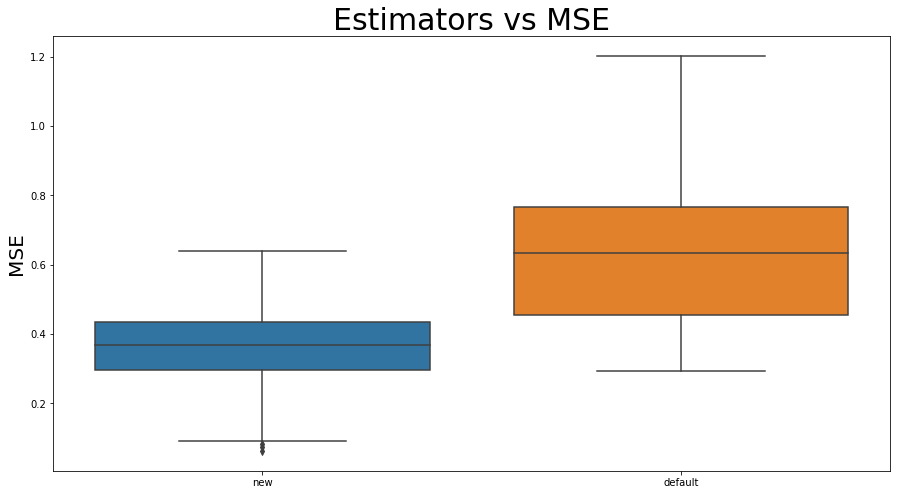

In [ ]:
GB_params = GB_res.best_params

models_GB = {}
'''models_GB['old'] = GradientBoostingRegressor(n_estimators = 200,
                                      learning_rate = 0.5,
                                      max_depth = 15,
                                      min_samples_leaf = 1,
                                      min_samples_split = 3)
'''
models_GB['new'] = GradientBoostingRegressor(**GB_params, n_estimators = 500)

models_GB['default'] = GradientBoostingRegressor()

results_GB = train_and_test_regressor(models_GB, XS_train, YS_train, XS_test, YS_test)
plot_model_comparison(results_GB)

In [ ]:
optuna.visualization.plot_param_importances(GB_res)

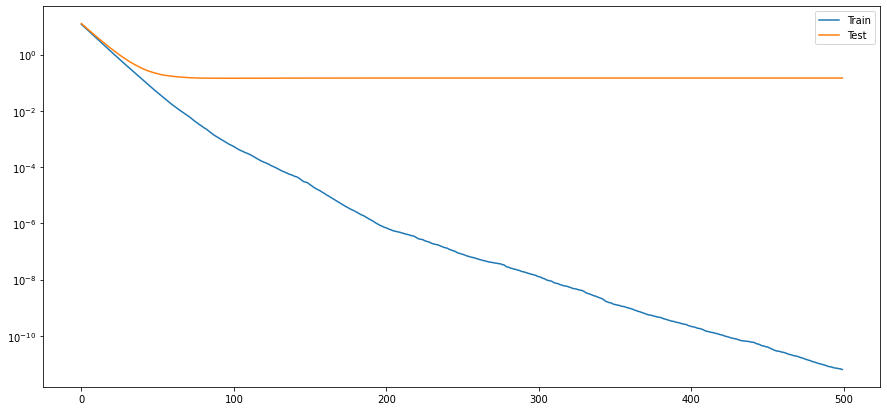

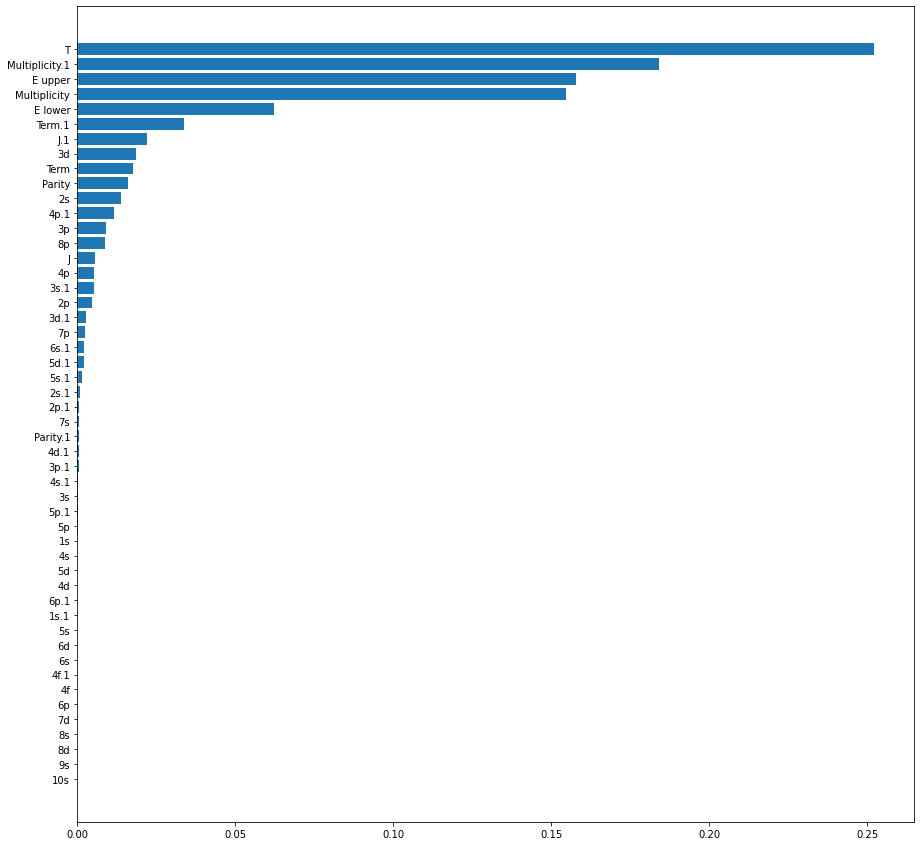

In [ ]:
test_score = np.zeros((500))
for i, y_pred in enumerate(models_GB['new'].staged_predict(XS_test)):
    test_score[i] = models_GB['new'].loss_(YS_test, y_pred)
plt.figure(figsize = (15, 7))
plt.plot(models_GB['new'].train_score_, label = 'Train')
plt.plot(test_score, label = 'Test')
plt.semilogy()
plt.legend()
plt.show()

feature_importance = models_GB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XS_train.columns)[sorted])
plt.show()

## XGBoost

In [325]:
XGB_params = {
    'n_estimators' : 500,
    'learning_rate' : [0.01, 0.5],
    'max_depth' : [1, 15],
    'min_child_weight' : [1, 15],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = XGBoost

XGB_res = main(X = XW_train, y = YW_train, model_name = model_name, params = XGB_params, n_trials = 250)

'''with open(f'XGB_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(XGB_res.best_params, fp)
'''
with open(f'XGB_Extended_optimal_parameters', 'w') as fp:
    json.dump(XGB_res.best_params, fp)

[I 2022-08-19 15:53:38,305] A new study created in memory with name: no-name-a8676e51-e9af-4a95-aefd-3b3874b16faf
/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn("Progress bar only supports serial execution (`n_jobs=1`).")


Start hyperparameter optimization
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3390645627477159, 'min_child_weight': 5, 'reg_alpha': 0.21501844772388168, 'reg_lambda': 1.592635868786273e-08}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.18400616691787353, 'min_child_weight': 6, 'reg_alpha': 1.1977253538120678e-05, 'reg_lambda': 0.025252338096965206}


[I 2022-08-19 15:53:47,533] Trial 0 finished with value: 0.1536883934073116 and parameters: {'max_depth': 6, 'learning_rate': 0.3390645627477159, 'min_child_weight': 5, 'reg_alpha': 0.21501844772388168, 'reg_lambda': 1.592635868786273e-08}. Best is trial 0 with value: 0.1536883934073116.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.19872879285263384, 'min_child_weight': 11, 'reg_alpha': 6.812694871038861, 'reg_lambda': 2.7339258914767277}


[I 2022-08-19 15:53:48,228] Trial 1 finished with value: 0.17627500691069636 and parameters: {'max_depth': 3, 'learning_rate': 0.18400616691787353, 'min_child_weight': 6, 'reg_alpha': 1.1977253538120678e-05, 'reg_lambda': 0.025252338096965206}. Best is trial 0 with value: 0.1536883934073116.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.17683744474069923, 'min_child_weight': 5, 'reg_alpha': 0.17888453498719187, 'reg_lambda': 0.023956520407971513}


[I 2022-08-19 15:53:53,263] Trial 2 finished with value: 0.36168101465153557 and parameters: {'max_depth': 2, 'learning_rate': 0.19872879285263384, 'min_child_weight': 11, 'reg_alpha': 6.812694871038861, 'reg_lambda': 2.7339258914767277}. Best is trial 0 with value: 0.1536883934073116.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.20024737586079158, 'min_child_weight': 4, 'reg_alpha': 2.3829195601647275e-08, 'reg_lambda': 5.213621739300794e-08}


[I 2022-08-19 15:54:00,763] Trial 3 finished with value: 0.15339391427103638 and parameters: {'max_depth': 6, 'learning_rate': 0.17683744474069923, 'min_child_weight': 5, 'reg_alpha': 0.17888453498719187, 'reg_lambda': 0.023956520407971513}. Best is trial 3 with value: 0.15339391427103638.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.2852555335304226, 'min_child_weight': 7, 'reg_alpha': 0.00332818391947603, 'reg_lambda': 6.310412383528455e-05}


[I 2022-08-19 15:54:05,669] Trial 5 finished with value: 0.42922975396670837 and parameters: {'max_depth': 1, 'learning_rate': 0.2852555335304226, 'min_child_weight': 7, 'reg_alpha': 0.00332818391947603, 'reg_lambda': 6.310412383528455e-05}. Best is trial 3 with value: 0.15339391427103638.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1058369202565661, 'min_child_weight': 8, 'reg_alpha': 0.03918051072515826, 'reg_lambda': 9.334055224983879e-08}


[I 2022-08-19 15:54:08,726] Trial 4 finished with value: 0.15249582445674367 and parameters: {'max_depth': 5, 'learning_rate': 0.20024737586079158, 'min_child_weight': 4, 'reg_alpha': 2.3829195601647275e-08, 'reg_lambda': 5.213621739300794e-08}. Best is trial 4 with value: 0.15249582445674367.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.3430811549207656, 'min_child_weight': 3, 'reg_alpha': 1.5217831540381423e-07, 'reg_lambda': 4.428111701031197}


[I 2022-08-19 15:54:33,094] Trial 7 finished with value: 0.1614638064024575 and parameters: {'max_depth': 12, 'learning_rate': 0.3430811549207656, 'min_child_weight': 3, 'reg_alpha': 1.5217831540381423e-07, 'reg_lambda': 4.428111701031197}. Best is trial 4 with value: 0.15249582445674367.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.23047978844643605, 'min_child_weight': 2, 'reg_alpha': 0.0011964817470576108, 'reg_lambda': 1.3414654511166635e-06}


[I 2022-08-19 15:54:36,229] Trial 6 finished with value: 0.15694982980761774 and parameters: {'max_depth': 10, 'learning_rate': 0.1058369202565661, 'min_child_weight': 8, 'reg_alpha': 0.03918051072515826, 'reg_lambda': 9.334055224983879e-08}. Best is trial 4 with value: 0.15249582445674367.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.203864590501133, 'min_child_weight': 4, 'reg_alpha': 3.0916877243937214e-07, 'reg_lambda': 3.4355128692586283}


[I 2022-08-19 15:54:48,514] Trial 8 finished with value: 0.1815168965936107 and parameters: {'max_depth': 9, 'learning_rate': 0.23047978844643605, 'min_child_weight': 2, 'reg_alpha': 0.0011964817470576108, 'reg_lambda': 1.3414654511166635e-06}. Best is trial 4 with value: 0.15249582445674367.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.2936801845075019, 'min_child_weight': 9, 'reg_alpha': 0.004225209966964041, 'reg_lambda': 0.002788389080185969}


[I 2022-08-19 15:54:51,601] Trial 9 finished with value: 0.15007643333502402 and parameters: {'max_depth': 5, 'learning_rate': 0.203864590501133, 'min_child_weight': 4, 'reg_alpha': 3.0916877243937214e-07, 'reg_lambda': 3.4355128692586283}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.47086196524109214, 'min_child_weight': 15, 'reg_alpha': 7.070714656163175e-06, 'reg_lambda': 0.026273312240800935}


[I 2022-08-19 15:54:55,956] Trial 10 finished with value: 0.21814403813678931 and parameters: {'max_depth': 2, 'learning_rate': 0.2936801845075019, 'min_child_weight': 9, 'reg_alpha': 0.004225209966964041, 'reg_lambda': 0.002788389080185969}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.42661330159941985, 'min_child_weight': 15, 'reg_alpha': 1.1514492737749906e-08, 'reg_lambda': 1.9405671069916163e-05}


[I 2022-08-19 15:55:11,583] Trial 12 finished with value: 0.15454874552116996 and parameters: {'max_depth': 5, 'learning_rate': 0.42661330159941985, 'min_child_weight': 15, 'reg_alpha': 1.1514492737749906e-08, 'reg_lambda': 1.9405671069916163e-05}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.03432605512464265, 'min_child_weight': 2, 'reg_alpha': 4.717104251295286e-06, 'reg_lambda': 2.093274301812803e-06}


[I 2022-08-19 15:55:27,996] Trial 13 finished with value: 0.16995800843937958 and parameters: {'max_depth': 5, 'learning_rate': 0.03432605512464265, 'min_child_weight': 2, 'reg_alpha': 4.717104251295286e-06, 'reg_lambda': 2.093274301812803e-06}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.1360504980410286, 'min_child_weight': 1, 'reg_alpha': 1.0887577731034112e-06, 'reg_lambda': 0.1787871333317869}


[I 2022-08-19 15:55:30,029] Trial 11 finished with value: 0.16488705394017894 and parameters: {'max_depth': 13, 'learning_rate': 0.47086196524109214, 'min_child_weight': 15, 'reg_alpha': 7.070714656163175e-06, 'reg_lambda': 0.026273312240800935}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.12386150672578475, 'min_child_weight': 4, 'reg_alpha': 1.391167813774543e-07, 'reg_lambda': 0.33673272955134154}


[I 2022-08-19 15:55:41,552] Trial 14 finished with value: 0.1654772919595942 and parameters: {'max_depth': 15, 'learning_rate': 0.1360504980410286, 'min_child_weight': 1, 'reg_alpha': 1.0887577731034112e-06, 'reg_lambda': 0.1787871333317869}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.0723340520591039, 'min_child_weight': 4, 'reg_alpha': 1.883710593685266e-08, 'reg_lambda': 0.00029005192829912923}


[I 2022-08-19 15:55:54,354] Trial 15 finished with value: 0.1565029303472924 and parameters: {'max_depth': 8, 'learning_rate': 0.12386150672578475, 'min_child_weight': 4, 'reg_alpha': 1.391167813774543e-07, 'reg_lambda': 0.33673272955134154}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.07936900275982756, 'min_child_weight': 11, 'reg_alpha': 0.00011802701876233535, 'reg_lambda': 0.000764145594823926}


[I 2022-08-19 15:56:06,209] Trial 16 finished with value: 0.15437607129333905 and parameters: {'max_depth': 8, 'learning_rate': 0.0723340520591039, 'min_child_weight': 4, 'reg_alpha': 1.883710593685266e-08, 'reg_lambda': 0.00029005192829912923}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2556724460871331, 'min_child_weight': 10, 'reg_alpha': 7.351391522516056e-05, 'reg_lambda': 1.4341299215989672e-06}


[I 2022-08-19 15:56:15,167] Trial 17 finished with value: 0.1608227703484788 and parameters: {'max_depth': 7, 'learning_rate': 0.07936900275982756, 'min_child_weight': 11, 'reg_alpha': 0.00011802701876233535, 'reg_lambda': 0.000764145594823926}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.23851408531492937, 'min_child_weight': 9, 'reg_alpha': 3.0667613680737397e-07, 'reg_lambda': 6.068841612494012e-07}


[I 2022-08-19 15:56:18,754] Trial 18 finished with value: 0.1568706520065053 and parameters: {'max_depth': 4, 'learning_rate': 0.2556724460871331, 'min_child_weight': 10, 'reg_alpha': 7.351391522516056e-05, 'reg_lambda': 1.4341299215989672e-06}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.36465657300322757, 'min_child_weight': 7, 'reg_alpha': 2.2885690395664636e-07, 'reg_lambda': 1.0594348276781271e-07}


[I 2022-08-19 15:56:27,751] Trial 19 finished with value: 0.15545047517639876 and parameters: {'max_depth': 4, 'learning_rate': 0.23851408531492937, 'min_child_weight': 9, 'reg_alpha': 3.0667613680737397e-07, 'reg_lambda': 6.068841612494012e-07}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.37173252133983786, 'min_child_weight': 1, 'reg_alpha': 3.93864441079437e-08, 'reg_lambda': 1.6441126593788643e-08}


[I 2022-08-19 15:56:31,372] Trial 20 finished with value: 0.15306824403846553 and parameters: {'max_depth': 4, 'learning_rate': 0.36465657300322757, 'min_child_weight': 7, 'reg_alpha': 2.2885690395664636e-07, 'reg_lambda': 1.0594348276781271e-07}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.3919404509006752, 'min_child_weight': 6, 'reg_alpha': 6.516696063470183e-08, 'reg_lambda': 1.626902156906643e-08}


[I 2022-08-19 15:56:35,549] Trial 21 finished with value: 0.1795845393649982 and parameters: {'max_depth': 10, 'learning_rate': 0.37173252133983786, 'min_child_weight': 1, 'reg_alpha': 3.93864441079437e-08, 'reg_lambda': 1.6441126593788643e-08}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.40878026425354513, 'min_child_weight': 6, 'reg_alpha': 1.4715252144644618e-06, 'reg_lambda': 1.2698344090600076e-07}


[I 2022-08-19 15:56:43,904] Trial 22 finished with value: 0.15178866250984982 and parameters: {'max_depth': 4, 'learning_rate': 0.3919404509006752, 'min_child_weight': 6, 'reg_alpha': 6.516696063470183e-08, 'reg_lambda': 1.626902156906643e-08}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.49206299528154496, 'min_child_weight': 5, 'reg_alpha': 9.754983828689263e-07, 'reg_lambda': 1.0148912613959766e-07}


[I 2022-08-19 15:56:48,099] Trial 23 finished with value: 0.15228667614842126 and parameters: {'max_depth': 4, 'learning_rate': 0.40878026425354513, 'min_child_weight': 6, 'reg_alpha': 1.4715252144644618e-06, 'reg_lambda': 1.2698344090600076e-07}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.4999108359414378, 'min_child_weight': 6, 'reg_alpha': 3.01711408186787e-06, 'reg_lambda': 7.064709204283172e-06}


[I 2022-08-19 15:56:53,009] Trial 25 finished with value: 0.3896593939801266 and parameters: {'max_depth': 1, 'learning_rate': 0.4999108359414378, 'min_child_weight': 6, 'reg_alpha': 3.01711408186787e-06, 'reg_lambda': 7.064709204283172e-06}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.4162429923801883, 'min_child_weight': 6, 'reg_alpha': 7.579886957696157e-07, 'reg_lambda': 2.868303408059435e-07}


[I 2022-08-19 15:57:02,052] Trial 24 finished with value: 0.15964890296119472 and parameters: {'max_depth': 6, 'learning_rate': 0.49206299528154496, 'min_child_weight': 5, 'reg_alpha': 9.754983828689263e-07, 'reg_lambda': 1.0148912613959766e-07}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.4298305574226216, 'min_child_weight': 7, 'reg_alpha': 2.4854867102097287e-05, 'reg_lambda': 3.409577372921824e-07}


[I 2022-08-19 15:57:02,872] Trial 26 finished with value: 0.16001026668458526 and parameters: {'max_depth': 3, 'learning_rate': 0.4162429923801883, 'min_child_weight': 6, 'reg_alpha': 7.579886957696157e-07, 'reg_lambda': 2.868303408059435e-07}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.42339438062551377, 'min_child_weight': 8, 'reg_alpha': 3.892896894816317e-05, 'reg_lambda': 6.160069681623551e-05}


[I 2022-08-19 15:57:12,037] Trial 27 finished with value: 0.16308224256936257 and parameters: {'max_depth': 3, 'learning_rate': 0.4298305574226216, 'min_child_weight': 7, 'reg_alpha': 2.4854867102097287e-05, 'reg_lambda': 3.409577372921824e-07}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.40193975031019363, 'min_child_weight': 13, 'reg_alpha': 7.272166463059712e-08, 'reg_lambda': 1.2603336002937456e-08}


[I 2022-08-19 15:57:12,922] Trial 28 finished with value: 0.16401764082219666 and parameters: {'max_depth': 3, 'learning_rate': 0.42339438062551377, 'min_child_weight': 8, 'reg_alpha': 3.892896894816317e-05, 'reg_lambda': 6.160069681623551e-05}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.3123268375108664, 'min_child_weight': 5, 'reg_alpha': 5.442906008424476e-08, 'reg_lambda': 1.644813993007559e-08}


[I 2022-08-19 15:57:32,783] Trial 29 finished with value: 0.15883019657450612 and parameters: {'max_depth': 7, 'learning_rate': 0.40193975031019363, 'min_child_weight': 13, 'reg_alpha': 7.272166463059712e-08, 'reg_lambda': 1.2603336002937456e-08}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.30495672677174, 'min_child_weight': 3, 'reg_alpha': 0.0006329856114248503, 'reg_lambda': 1.1100476491042734e-08}


[I 2022-08-19 15:57:34,218] Trial 30 finished with value: 0.16353915816549863 and parameters: {'max_depth': 7, 'learning_rate': 0.3123268375108664, 'min_child_weight': 5, 'reg_alpha': 5.442906008424476e-08, 'reg_lambda': 1.644813993007559e-08}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.15722381148467127, 'min_child_weight': 3, 'reg_alpha': 1.051497486070786e-08, 'reg_lambda': 5.230250858652889e-08}


[I 2022-08-19 15:57:49,698] Trial 32 finished with value: 0.15352554635812593 and parameters: {'max_depth': 5, 'learning_rate': 0.15722381148467127, 'min_child_weight': 3, 'reg_alpha': 1.051497486070786e-08, 'reg_lambda': 5.230250858652889e-08}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2152565159479131, 'min_child_weight': 4, 'reg_alpha': 5.064223584117881e-07, 'reg_lambda': 4.1121606487258214e-08}


[I 2022-08-19 15:57:51,768] Trial 31 finished with value: 0.16335220337459408 and parameters: {'max_depth': 7, 'learning_rate': 0.30495672677174, 'min_child_weight': 3, 'reg_alpha': 0.0006329856114248503, 'reg_lambda': 1.1100476491042734e-08}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.20771953512316157, 'min_child_weight': 4, 'reg_alpha': 8.637800357769525e-07, 'reg_lambda': 6.270607055200806e-06}


[I 2022-08-19 15:58:05,132] Trial 33 finished with value: 0.15258080666557944 and parameters: {'max_depth': 5, 'learning_rate': 0.2152565159479131, 'min_child_weight': 4, 'reg_alpha': 5.064223584117881e-07, 'reg_lambda': 4.1121606487258214e-08}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.2669007226679273, 'min_child_weight': 6, 'reg_alpha': 2.2739222506623437e-06, 'reg_lambda': 5.084575809630843e-06}


[I 2022-08-19 15:58:07,210] Trial 34 finished with value: 0.15187505798404718 and parameters: {'max_depth': 5, 'learning_rate': 0.20771953512316157, 'min_child_weight': 4, 'reg_alpha': 8.637800357769525e-07, 'reg_lambda': 6.270607055200806e-06}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.26694204351352835, 'min_child_weight': 6, 'reg_alpha': 1.8481589876597965e-06, 'reg_lambda': 9.240852588679447e-06}


[I 2022-08-19 15:58:12,600] Trial 35 finished with value: 0.21931507949479698 and parameters: {'max_depth': 2, 'learning_rate': 0.2669007226679273, 'min_child_weight': 6, 'reg_alpha': 2.2739222506623437e-06, 'reg_lambda': 5.084575809630843e-06}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.45146392627619275, 'min_child_weight': 5, 'reg_alpha': 7.1562861268609, 'reg_lambda': 1.7952065124408985e-05}


[I 2022-08-19 15:58:14,691] Trial 36 finished with value: 0.2189443660311025 and parameters: {'max_depth': 2, 'learning_rate': 0.26694204351352835, 'min_child_weight': 6, 'reg_alpha': 1.8481589876597965e-06, 'reg_lambda': 9.240852588679447e-06}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.16806595474409522, 'min_child_weight': 5, 'reg_alpha': 1.2617001980082281e-05, 'reg_lambda': 0.6037553385884812}


[I 2022-08-19 15:58:18,062] Trial 37 finished with value: 0.28112336678720923 and parameters: {'max_depth': 6, 'learning_rate': 0.45146392627619275, 'min_child_weight': 5, 'reg_alpha': 7.1562861268609, 'reg_lambda': 1.7952065124408985e-05}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.18590825129209523, 'min_child_weight': 2, 'reg_alpha': 1.1972973472505845e-05, 'reg_lambda': 0.5985229947296018}


[I 2022-08-19 15:58:27,233] Trial 38 finished with value: 0.15612649956441146 and parameters: {'max_depth': 4, 'learning_rate': 0.16806595474409522, 'min_child_weight': 5, 'reg_alpha': 1.2617001980082281e-05, 'reg_lambda': 0.6037553385884812}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.19509598538432488, 'min_child_weight': 3, 'reg_alpha': 1.037492167506055, 'reg_lambda': 0.005735791142544285}


[I 2022-08-19 15:58:30,709] Trial 39 finished with value: 0.15351069328571504 and parameters: {'max_depth': 4, 'learning_rate': 0.18590825129209523, 'min_child_weight': 2, 'reg_alpha': 1.1972973472505845e-05, 'reg_lambda': 0.5985229947296018}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.33280964620432507, 'min_child_weight': 7, 'reg_alpha': 1.3087108858099725e-07, 'reg_lambda': 0.0030126940900816945}


[I 2022-08-19 15:58:35,093] Trial 40 finished with value: 0.17739364558825693 and parameters: {'max_depth': 6, 'learning_rate': 0.19509598538432488, 'min_child_weight': 3, 'reg_alpha': 1.037492167506055, 'reg_lambda': 0.005735791142544285}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2166709565291573, 'min_child_weight': 7, 'reg_alpha': 3.064841019607328e-08, 'reg_lambda': 1.9623434967145107e-07}


[I 2022-08-19 15:58:48,730] Trial 41 finished with value: 0.15409994179204042 and parameters: {'max_depth': 6, 'learning_rate': 0.33280964620432507, 'min_child_weight': 7, 'reg_alpha': 1.3087108858099725e-07, 'reg_lambda': 0.0030126940900816945}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.15034583339498014, 'min_child_weight': 4, 'reg_alpha': 4.0326996037856086e-08, 'reg_lambda': 2.5207371104389274e-07}


[I 2022-08-19 15:58:50,425] Trial 42 finished with value: 0.1505472862796739 and parameters: {'max_depth': 5, 'learning_rate': 0.2166709565291573, 'min_child_weight': 7, 'reg_alpha': 3.064841019607328e-08, 'reg_lambda': 1.9623434967145107e-07}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.21805369540642527, 'min_child_weight': 8, 'reg_alpha': 4.312485063782217e-08, 'reg_lambda': 2.1266420771265714e-07}


[I 2022-08-19 15:59:00,229] Trial 44 finished with value: 0.1747495260509818 and parameters: {'max_depth': 3, 'learning_rate': 0.21805369540642527, 'min_child_weight': 8, 'reg_alpha': 4.312485063782217e-08, 'reg_lambda': 2.1266420771265714e-07}. Best is trial 9 with value: 0.15007643333502402.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.38740420072953785, 'min_child_weight': 9, 'reg_alpha': 2.734014669928257e-07, 'reg_lambda': 7.479837340807568e-07}


[I 2022-08-19 15:59:04,145] Trial 43 finished with value: 0.14705891215315398 and parameters: {'max_depth': 5, 'learning_rate': 0.15034583339498014, 'min_child_weight': 4, 'reg_alpha': 4.0326996037856086e-08, 'reg_lambda': 2.5207371104389274e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.13927752193978538, 'min_child_weight': 4, 'reg_alpha': 2.6674259032776798e-08, 'reg_lambda': 7.565103642621264}


[I 2022-08-19 15:59:15,529] Trial 45 finished with value: 0.15279214177568315 and parameters: {'max_depth': 5, 'learning_rate': 0.38740420072953785, 'min_child_weight': 9, 'reg_alpha': 2.734014669928257e-07, 'reg_lambda': 7.479837340807568e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.15203644196340638, 'min_child_weight': 4, 'reg_alpha': 2.700129930963251e-08, 'reg_lambda': 2.2506347606428556e-06}


[I 2022-08-19 15:59:31,816] Trial 46 finished with value: 0.15556586213089918 and parameters: {'max_depth': 9, 'learning_rate': 0.13927752193978538, 'min_child_weight': 4, 'reg_alpha': 2.6674259032776798e-08, 'reg_lambda': 7.565103642621264}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.24081251101139747, 'min_child_weight': 5, 'reg_alpha': 8.698075216003435e-08, 'reg_lambda': 7.119765325554519e-05}


[I 2022-08-19 15:59:42,935] Trial 47 finished with value: 0.16103516074020302 and parameters: {'max_depth': 9, 'learning_rate': 0.15203644196340638, 'min_child_weight': 4, 'reg_alpha': 2.700129930963251e-08, 'reg_lambda': 2.2506347606428556e-06}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.24116148805617996, 'min_child_weight': 2, 'reg_alpha': 8.961984477580141e-08, 'reg_lambda': 3.976202737128237e-08}


[I 2022-08-19 15:59:50,119] Trial 48 finished with value: 0.1565810657658631 and parameters: {'max_depth': 6, 'learning_rate': 0.24081251101139747, 'min_child_weight': 5, 'reg_alpha': 8.698075216003435e-08, 'reg_lambda': 7.119765325554519e-05}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.09784284734246484, 'min_child_weight': 2, 'reg_alpha': 4.274646987522191e-07, 'reg_lambda': 4.4532628894426816e-08}


[I 2022-08-19 16:00:01,325] Trial 49 finished with value: 0.1622448614665942 and parameters: {'max_depth': 6, 'learning_rate': 0.24116148805617996, 'min_child_weight': 2, 'reg_alpha': 8.961984477580141e-08, 'reg_lambda': 3.976202737128237e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.08310407713156151, 'min_child_weight': 7, 'reg_alpha': 0.04469604556828809, 'reg_lambda': 0.07790578135513672}


[I 2022-08-19 16:00:06,112] Trial 50 finished with value: 0.15182132842587986 and parameters: {'max_depth': 5, 'learning_rate': 0.09784284734246484, 'min_child_weight': 2, 'reg_alpha': 4.274646987522191e-07, 'reg_lambda': 4.4532628894426816e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.11072099030999273, 'min_child_weight': 3, 'reg_alpha': 3.8236902809143744e-07, 'reg_lambda': 6.596650082352163e-07}


[I 2022-08-19 16:00:06,622] Trial 51 finished with value: 0.5379203309688161 and parameters: {'max_depth': 1, 'learning_rate': 0.08310407713156151, 'min_child_weight': 7, 'reg_alpha': 0.04469604556828809, 'reg_lambda': 0.07790578135513672}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.10771639406535587, 'min_child_weight': 1, 'reg_alpha': 3.987499710556299e-07, 'reg_lambda': 3.35897620307874e-08}


[I 2022-08-19 16:00:21,785] Trial 52 finished with value: 0.15185757036622682 and parameters: {'max_depth': 5, 'learning_rate': 0.11072099030999273, 'min_child_weight': 3, 'reg_alpha': 3.8236902809143744e-07, 'reg_lambda': 6.596650082352163e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.10506995632645863, 'min_child_weight': 1, 'reg_alpha': 3.5942496429982746e-07, 'reg_lambda': 7.051861347081981e-07}


[I 2022-08-19 16:00:22,350] Trial 53 finished with value: 0.15268970808398355 and parameters: {'max_depth': 5, 'learning_rate': 0.10771639406535587, 'min_child_weight': 1, 'reg_alpha': 3.987499710556299e-07, 'reg_lambda': 3.35897620307874e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.10471532262834805, 'min_child_weight': 2, 'reg_alpha': 1.6559934933480167e-08, 'reg_lambda': 6.69110742515776e-07}


[I 2022-08-19 16:00:32,335] Trial 55 finished with value: 0.19146950009278657 and parameters: {'max_depth': 3, 'learning_rate': 0.10471532262834805, 'min_child_weight': 2, 'reg_alpha': 1.6559934933480167e-08, 'reg_lambda': 6.69110742515776e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.04057231531382392, 'min_child_weight': 3, 'reg_alpha': 1.43320090936049e-07, 'reg_lambda': 1.9915461538543238e-07}


[I 2022-08-19 16:00:37,721] Trial 54 finished with value: 0.1529022955868525 and parameters: {'max_depth': 5, 'learning_rate': 0.10506995632645863, 'min_child_weight': 1, 'reg_alpha': 3.5942496429982746e-07, 'reg_lambda': 7.051861347081981e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.04908205749519429, 'min_child_weight': 2, 'reg_alpha': 1.5318962916644816e-07, 'reg_lambda': 1.803202963241899e-07}


[I 2022-08-19 16:00:45,203] Trial 56 finished with value: 0.19786270453503058 and parameters: {'max_depth': 4, 'learning_rate': 0.04057231531382392, 'min_child_weight': 3, 'reg_alpha': 1.43320090936049e-07, 'reg_lambda': 1.9915461538543238e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01740810687476542, 'min_child_weight': 3, 'reg_alpha': 5.115200441798156e-06, 'reg_lambda': 1.725324986724831}


[I 2022-08-19 16:00:50,678] Trial 57 finished with value: 0.18300091011359274 and parameters: {'max_depth': 4, 'learning_rate': 0.04908205749519429, 'min_child_weight': 2, 'reg_alpha': 1.5318962916644816e-07, 'reg_lambda': 1.803202963241899e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.06118662889889884, 'min_child_weight': 3, 'reg_alpha': 1.1260316938533823e-08, 'reg_lambda': 5.804856556501009e-08}


[I 2022-08-19 16:01:07,517] Trial 58 finished with value: 0.18599669596427432 and parameters: {'max_depth': 7, 'learning_rate': 0.01740810687476542, 'min_child_weight': 3, 'reg_alpha': 5.115200441798156e-06, 'reg_lambda': 1.725324986724831}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.12373835357780887, 'min_child_weight': 3, 'reg_alpha': 4.3537437584104264e-08, 'reg_lambda': 6.304066969405969e-08}


[I 2022-08-19 16:01:12,978] Trial 59 finished with value: 0.15293104329291465 and parameters: {'max_depth': 7, 'learning_rate': 0.06118662889889884, 'min_child_weight': 3, 'reg_alpha': 1.1260316938533823e-08, 'reg_lambda': 5.804856556501009e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.13420429456153843, 'min_child_weight': 9, 'reg_alpha': 5.122245912140282e-08, 'reg_lambda': 2.3767106016285817e-08}


[I 2022-08-19 16:01:42,213] Trial 60 finished with value: 0.17488065691705573 and parameters: {'max_depth': 15, 'learning_rate': 0.12373835357780887, 'min_child_weight': 3, 'reg_alpha': 4.3537437584104264e-08, 'reg_lambda': 6.304066969405969e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.17480965447674746, 'min_child_weight': 4, 'reg_alpha': 6.827956711371168e-07, 'reg_lambda': 2.536291632259208e-06}


[I 2022-08-19 16:01:48,754] Trial 61 finished with value: 0.15791658579455328 and parameters: {'max_depth': 12, 'learning_rate': 0.13420429456153843, 'min_child_weight': 9, 'reg_alpha': 5.122245912140282e-08, 'reg_lambda': 2.3767106016285817e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.20877017966059783, 'min_child_weight': 4, 'reg_alpha': 7.554022424773065e-07, 'reg_lambda': 2.6762853107535167e-06}


[I 2022-08-19 16:01:57,639] Trial 62 finished with value: 0.1506128750292127 and parameters: {'max_depth': 5, 'learning_rate': 0.17480965447674746, 'min_child_weight': 4, 'reg_alpha': 6.827956711371168e-07, 'reg_lambda': 2.536291632259208e-06}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.18399680706379626, 'min_child_weight': 4, 'reg_alpha': 6.051949362031035e-07, 'reg_lambda': 2.7984754029542973e-06}


[I 2022-08-19 16:02:04,141] Trial 63 finished with value: 0.15230500502378608 and parameters: {'max_depth': 5, 'learning_rate': 0.20877017966059783, 'min_child_weight': 4, 'reg_alpha': 7.554022424773065e-07, 'reg_lambda': 2.6762853107535167e-06}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.17498671491880524, 'min_child_weight': 8, 'reg_alpha': 1.7167819021924115e-07, 'reg_lambda': 4.2243428430752927e-07}


[I 2022-08-19 16:02:05,115] Trial 64 finished with value: 0.23100110282176659 and parameters: {'max_depth': 2, 'learning_rate': 0.18399680706379626, 'min_child_weight': 4, 'reg_alpha': 6.051949362031035e-07, 'reg_lambda': 2.7984754029542973e-06}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.17318688223872766, 'min_child_weight': 5, 'reg_alpha': 2.1057305156515305e-07, 'reg_lambda': 1.211178704355386e-06}


[I 2022-08-19 16:02:17,855] Trial 66 finished with value: 0.1514977293855678 and parameters: {'max_depth': 4, 'learning_rate': 0.17318688223872766, 'min_child_weight': 5, 'reg_alpha': 2.1057305156515305e-07, 'reg_lambda': 1.211178704355386e-06}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.17412401881086523, 'min_child_weight': 5, 'reg_alpha': 1.985301038458661e-08, 'reg_lambda': 0.00016813730774957873}


[I 2022-08-19 16:02:27,852] Trial 67 finished with value: 0.17741459987289598 and parameters: {'max_depth': 3, 'learning_rate': 0.17412401881086523, 'min_child_weight': 5, 'reg_alpha': 1.985301038458661e-08, 'reg_lambda': 0.00016813730774957873}. Best is trial 43 with value: 0.14705891215315398.
[I 2022-08-19 16:02:28,011] Trial 65 finished with value: 0.15541209828183028 and parameters: {'max_depth': 8, 'learning_rate': 0.17498671491880524, 'min_child_weight': 8, 'reg_alpha': 1.7167819021924115e-07, 'reg_lambda': 4.2243428430752927e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1616732420109229, 'min_child_weight': 6, 'reg_alpha': 1.9768547501491042e-07, 'reg_lambda': 2.7833769617057957e-07}
{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.15936523049265866, 'min_child_weight': 6, 'reg_alpha': 1.3034837897975686e-06, 'reg_lambda': 8.673261900170866e-08}


[I 2022-08-19 16:02:40,719] Trial 69 finished with value: 0.15445433528305386 and parameters: {'max_depth': 4, 'learning_rate': 0.15936523049265866, 'min_child_weight': 6, 'reg_alpha': 1.3034837897975686e-06, 'reg_lambda': 8.673261900170866e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.19466607118524995, 'min_child_weight': 6, 'reg_alpha': 2.6563602916071843e-06, 'reg_lambda': 1.0015861043326068e-08}


[I 2022-08-19 16:02:51,985] Trial 68 finished with value: 0.15625910394882428 and parameters: {'max_depth': 8, 'learning_rate': 0.1616732420109229, 'min_child_weight': 6, 'reg_alpha': 1.9768547501491042e-07, 'reg_lambda': 2.7833769617057957e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.19064461851443726, 'min_child_weight': 5, 'reg_alpha': 2.7097410909952767e-06, 'reg_lambda': 1.1655234326807114e-06}


[I 2022-08-19 16:02:58,951] Trial 70 finished with value: 0.15479167811486397 and parameters: {'max_depth': 6, 'learning_rate': 0.19466607118524995, 'min_child_weight': 6, 'reg_alpha': 2.6563602916071843e-06, 'reg_lambda': 1.0015861043326068e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.0897021410254604, 'min_child_weight': 5, 'reg_alpha': 7.712412894872554e-08, 'reg_lambda': 1.1727794095102903e-06}


[I 2022-08-19 16:03:09,018] Trial 72 finished with value: 0.20288633399903383 and parameters: {'max_depth': 3, 'learning_rate': 0.0897021410254604, 'min_child_weight': 5, 'reg_alpha': 7.712412894872554e-08, 'reg_lambda': 1.1727794095102903e-06}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1430556491513364, 'min_child_weight': 2, 'reg_alpha': 0.003028627100582251, 'reg_lambda': 1.1861841055187708e-06}


[I 2022-08-19 16:03:10,280] Trial 71 finished with value: 0.15445650260897156 and parameters: {'max_depth': 6, 'learning_rate': 0.19064461851443726, 'min_child_weight': 5, 'reg_alpha': 2.7097410909952767e-06, 'reg_lambda': 1.1655234326807114e-06}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.22395619033995226, 'min_child_weight': 4, 'reg_alpha': 3.2626765867389396e-07, 'reg_lambda': 1.356689094032253e-07}


[I 2022-08-19 16:03:24,654] Trial 73 finished with value: 0.152315990712688 and parameters: {'max_depth': 5, 'learning_rate': 0.1430556491513364, 'min_child_weight': 2, 'reg_alpha': 0.003028627100582251, 'reg_lambda': 1.1861841055187708e-06}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.22492295440861435, 'min_child_weight': 4, 'reg_alpha': 3.13304622207892e-07, 'reg_lambda': 1.2397199248019647e-07}


[I 2022-08-19 16:03:25,720] Trial 74 finished with value: 0.15210452695378013 and parameters: {'max_depth': 5, 'learning_rate': 0.22395619033995226, 'min_child_weight': 4, 'reg_alpha': 3.2626765867389396e-07, 'reg_lambda': 1.356689094032253e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.11260520605877014, 'min_child_weight': 7, 'reg_alpha': 3.5915548114939026e-08, 'reg_lambda': 4.1597183982711416e-07}


[I 2022-08-19 16:03:37,396] Trial 75 finished with value: 0.1515886230860138 and parameters: {'max_depth': 4, 'learning_rate': 0.22492295440861435, 'min_child_weight': 4, 'reg_alpha': 3.13304622207892e-07, 'reg_lambda': 1.2397199248019647e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2906766109512863, 'min_child_weight': 7, 'reg_alpha': 0.00024059354997087255, 'reg_lambda': 2.7228607858026173e-08}


[I 2022-08-19 16:03:38,342] Trial 76 finished with value: 0.16857516174663859 and parameters: {'max_depth': 4, 'learning_rate': 0.11260520605877014, 'min_child_weight': 7, 'reg_alpha': 3.5915548114939026e-08, 'reg_lambda': 4.1597183982711416e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.28702909817451505, 'min_child_weight': 5, 'reg_alpha': 1.0176898486928916e-07, 'reg_lambda': 2.2283919525360923e-08}


[I 2022-08-19 16:03:49,982] Trial 77 finished with value: 0.15313989678457374 and parameters: {'max_depth': 4, 'learning_rate': 0.2906766109512863, 'min_child_weight': 7, 'reg_alpha': 0.00024059354997087255, 'reg_lambda': 2.7228607858026173e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.22774948768350872, 'min_child_weight': 13, 'reg_alpha': 9.426375918841156e-08, 'reg_lambda': 9.009505393211428e-08}


[I 2022-08-19 16:03:50,811] Trial 78 finished with value: 0.15046511635466503 and parameters: {'max_depth': 4, 'learning_rate': 0.28702909817451505, 'min_child_weight': 5, 'reg_alpha': 1.0176898486928916e-07, 'reg_lambda': 2.2283919525360923e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.25443339703569434, 'min_child_weight': 5, 'reg_alpha': 7.320946533481765e-08, 'reg_lambda': 0.0007547460389996782}


[I 2022-08-19 16:03:57,268] Trial 79 finished with value: 0.24379460964277472 and parameters: {'max_depth': 2, 'learning_rate': 0.22774948768350872, 'min_child_weight': 13, 'reg_alpha': 9.426375918841156e-08, 'reg_lambda': 9.009505393211428e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2704760257328569, 'min_child_weight': 5, 'reg_alpha': 2.8467090367525202e-08, 'reg_lambda': 2.037967580779834e-08}


[I 2022-08-19 16:04:00,642] Trial 80 finished with value: 0.16464807519360164 and parameters: {'max_depth': 3, 'learning_rate': 0.25443339703569434, 'min_child_weight': 5, 'reg_alpha': 7.320946533481765e-08, 'reg_lambda': 0.0007547460389996782}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.27691444337199694, 'min_child_weight': 4, 'reg_alpha': 2.3686211049530863e-07, 'reg_lambda': 2.2882229465222284e-08}


[I 2022-08-19 16:04:09,894] Trial 81 finished with value: 0.15175760481367528 and parameters: {'max_depth': 4, 'learning_rate': 0.2704760257328569, 'min_child_weight': 5, 'reg_alpha': 2.8467090367525202e-08, 'reg_lambda': 2.037967580779834e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.27858640818503394, 'min_child_weight': 6, 'reg_alpha': 2.334139006533829e-08, 'reg_lambda': 2.370728610378891e-08}


[I 2022-08-19 16:04:13,257] Trial 82 finished with value: 0.15058420003309775 and parameters: {'max_depth': 4, 'learning_rate': 0.27691444337199694, 'min_child_weight': 4, 'reg_alpha': 2.3686211049530863e-07, 'reg_lambda': 2.2882229465222284e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2780132289595211, 'min_child_weight': 4, 'reg_alpha': 1.6255211199541183e-08, 'reg_lambda': 2.670595450737321e-08}


[I 2022-08-19 16:04:22,431] Trial 83 finished with value: 0.1509058313453881 and parameters: {'max_depth': 4, 'learning_rate': 0.27858640818503394, 'min_child_weight': 6, 'reg_alpha': 2.334139006533829e-08, 'reg_lambda': 2.370728610378891e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.3107585846282565, 'min_child_weight': 4, 'reg_alpha': 2.2388514750161982e-07, 'reg_lambda': 0.016560948955382786}


[I 2022-08-19 16:04:25,866] Trial 84 finished with value: 0.15057321716026706 and parameters: {'max_depth': 4, 'learning_rate': 0.2780132289595211, 'min_child_weight': 4, 'reg_alpha': 1.6255211199541183e-08, 'reg_lambda': 2.670595450737321e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.32283029881780334, 'min_child_weight': 6, 'reg_alpha': 2.134291843270212e-08, 'reg_lambda': 1.965127818033817e-08}


[I 2022-08-19 16:04:35,076] Trial 85 finished with value: 0.15145258481874152 and parameters: {'max_depth': 4, 'learning_rate': 0.3107585846282565, 'min_child_weight': 4, 'reg_alpha': 2.2388514750161982e-07, 'reg_lambda': 0.016560948955382786}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.32210617278499715, 'min_child_weight': 4, 'reg_alpha': 2.01230413221317e-08, 'reg_lambda': 1.798500477976085e-08}


[I 2022-08-19 16:04:35,749] Trial 86 finished with value: 0.16116914334385307 and parameters: {'max_depth': 3, 'learning_rate': 0.32283029881780334, 'min_child_weight': 6, 'reg_alpha': 2.134291843270212e-08, 'reg_lambda': 1.965127818033817e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.34714479232259776, 'min_child_weight': 4, 'reg_alpha': 1.3705458320371984e-08, 'reg_lambda': 0.012736904968092528}


[I 2022-08-19 16:04:45,047] Trial 87 finished with value: 0.16086580502253306 and parameters: {'max_depth': 3, 'learning_rate': 0.32210617278499715, 'min_child_weight': 4, 'reg_alpha': 2.01230413221317e-08, 'reg_lambda': 1.798500477976085e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.3542115949046058, 'min_child_weight': 4, 'reg_alpha': 1.2244478900168398e-08, 'reg_lambda': 0.009315344957482753}


[I 2022-08-19 16:04:45,700] Trial 88 finished with value: 0.15823928683884397 and parameters: {'max_depth': 3, 'learning_rate': 0.34714479232259776, 'min_child_weight': 4, 'reg_alpha': 1.3705458320371984e-08, 'reg_lambda': 0.012736904968092528}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.2772550454897062, 'min_child_weight': 4, 'reg_alpha': 1.0718265789676582e-08, 'reg_lambda': 0.14070189599660773}


[I 2022-08-19 16:05:00,348] Trial 89 finished with value: 0.1585397176435482 and parameters: {'max_depth': 5, 'learning_rate': 0.3542115949046058, 'min_child_weight': 4, 'reg_alpha': 1.2244478900168398e-08, 'reg_lambda': 0.009315344957482753}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.30572350904242845, 'min_child_weight': 5, 'reg_alpha': 1.1017690694075238e-07, 'reg_lambda': 0.060262525522418925}


[I 2022-08-19 16:05:03,978] Trial 90 finished with value: 0.15808457207187243 and parameters: {'max_depth': 6, 'learning_rate': 0.2772550454897062, 'min_child_weight': 4, 'reg_alpha': 1.0718265789676582e-08, 'reg_lambda': 0.14070189599660773}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.25096959330131563, 'min_child_weight': 5, 'reg_alpha': 1.1507241565787569e-07, 'reg_lambda': 0.001360595889211626}


[I 2022-08-19 16:05:16,636] Trial 92 finished with value: 0.15408699401029113 and parameters: {'max_depth': 4, 'learning_rate': 0.25096959330131563, 'min_child_weight': 5, 'reg_alpha': 1.1507241565787569e-07, 'reg_lambda': 0.001360595889211626}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.3021549663005578, 'min_child_weight': 3, 'reg_alpha': 5.097808635059716e-08, 'reg_lambda': 3.2724143660463803}


[I 2022-08-19 16:05:18,788] Trial 91 finished with value: 0.16222218478864414 and parameters: {'max_depth': 6, 'learning_rate': 0.30572350904242845, 'min_child_weight': 5, 'reg_alpha': 1.1017690694075238e-07, 'reg_lambda': 0.060262525522418925}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2919171581218253, 'min_child_weight': 3, 'reg_alpha': 5.26882155029644e-08, 'reg_lambda': 2.7763478549954814}


[I 2022-08-19 16:05:29,278] Trial 93 finished with value: 0.15303624894901482 and parameters: {'max_depth': 4, 'learning_rate': 0.3021549663005578, 'min_child_weight': 3, 'reg_alpha': 5.097808635059716e-08, 'reg_lambda': 3.2724143660463803}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.27714454246653025, 'min_child_weight': 5, 'reg_alpha': 2.088352043709194e-07, 'reg_lambda': 1.6009493102796075e-05}


[I 2022-08-19 16:05:31,646] Trial 94 finished with value: 0.15268680883544133 and parameters: {'max_depth': 4, 'learning_rate': 0.2919171581218253, 'min_child_weight': 3, 'reg_alpha': 5.26882155029644e-08, 'reg_lambda': 2.7763478549954814}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.28161682050521125, 'min_child_weight': 5, 'reg_alpha': 2.1051103048876776e-07, 'reg_lambda': 1.563118417310149e-05}


[I 2022-08-19 16:05:47,086] Trial 96 finished with value: 0.15476467053122478 and parameters: {'max_depth': 5, 'learning_rate': 0.28161682050521125, 'min_child_weight': 5, 'reg_alpha': 2.1051103048876776e-07, 'reg_lambda': 1.563118417310149e-05}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.23900558568807562, 'min_child_weight': 6, 'reg_alpha': 8.957527484876221e-07, 'reg_lambda': 7.08032188425625e-08}


[I 2022-08-19 16:05:56,431] Trial 95 finished with value: 0.1651991914877038 and parameters: {'max_depth': 14, 'learning_rate': 0.27714454246653025, 'min_child_weight': 5, 'reg_alpha': 2.088352043709194e-07, 'reg_lambda': 1.6009493102796075e-05}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.24668421214431208, 'min_child_weight': 6, 'reg_alpha': 6.687562217262999e-07, 'reg_lambda': 7.054062527818219e-08}


[I 2022-08-19 16:06:02,622] Trial 97 finished with value: 0.1518395265969061 and parameters: {'max_depth': 5, 'learning_rate': 0.23900558568807562, 'min_child_weight': 6, 'reg_alpha': 8.957527484876221e-07, 'reg_lambda': 7.08032188425625e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.25270875739173465, 'min_child_weight': 4, 'reg_alpha': 3.288773366109016e-08, 'reg_lambda': 2.9624454393976527e-08}


[I 2022-08-19 16:06:11,961] Trial 98 finished with value: 0.15370146874496102 and parameters: {'max_depth': 5, 'learning_rate': 0.24668421214431208, 'min_child_weight': 6, 'reg_alpha': 6.687562217262999e-07, 'reg_lambda': 7.054062527818219e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.2632994559302536, 'min_child_weight': 8, 'reg_alpha': 3.126160409595188e-08, 'reg_lambda': 3.318040049976381e-08}


[I 2022-08-19 16:06:15,346] Trial 99 finished with value: 0.1477916752111392 and parameters: {'max_depth': 4, 'learning_rate': 0.25270875739173465, 'min_child_weight': 4, 'reg_alpha': 3.288773366109016e-08, 'reg_lambda': 2.9624454393976527e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.26210146334379425, 'min_child_weight': 3, 'reg_alpha': 3.2263227255636104e-08, 'reg_lambda': 2.9084209695237898e-08}


[I 2022-08-19 16:06:19,494] Trial 100 finished with value: 0.2272037666372281 and parameters: {'max_depth': 2, 'learning_rate': 0.2632994559302536, 'min_child_weight': 8, 'reg_alpha': 3.126160409595188e-08, 'reg_lambda': 3.318040049976381e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.20455690512722577, 'min_child_weight': 4, 'reg_alpha': 3.7638543715681616e-08, 'reg_lambda': 4.1649528848790725e-06}


[I 2022-08-19 16:06:22,933] Trial 101 finished with value: 0.20907507845319678 and parameters: {'max_depth': 2, 'learning_rate': 0.26210146334379425, 'min_child_weight': 3, 'reg_alpha': 3.2263227255636104e-08, 'reg_lambda': 2.9084209695237898e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.211765109759156, 'min_child_weight': 4, 'reg_alpha': 5.79368704891981e-08, 'reg_lambda': 1.306367746549386e-08}


[I 2022-08-19 16:06:32,531] Trial 102 finished with value: 0.15452503316936628 and parameters: {'max_depth': 4, 'learning_rate': 0.20455690512722577, 'min_child_weight': 4, 'reg_alpha': 3.7638543715681616e-08, 'reg_lambda': 4.1649528848790725e-06}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.29729837686531857, 'min_child_weight': 4, 'reg_alpha': 6.343255961354425e-08, 'reg_lambda': 1.1573787620241733e-08}


[I 2022-08-19 16:06:35,866] Trial 103 finished with value: 0.15122990392708216 and parameters: {'max_depth': 4, 'learning_rate': 0.211765109759156, 'min_child_weight': 4, 'reg_alpha': 5.79368704891981e-08, 'reg_lambda': 1.306367746549386e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.29783914546361046, 'min_child_weight': 4, 'reg_alpha': 6.068434457562578e-08, 'reg_lambda': 1.1391843587717357e-08}


[I 2022-08-19 16:06:45,196] Trial 104 finished with value: 0.15120709949654512 and parameters: {'max_depth': 4, 'learning_rate': 0.29729837686531857, 'min_child_weight': 4, 'reg_alpha': 6.343255961354425e-08, 'reg_lambda': 1.1573787620241733e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.21628049296627475, 'min_child_weight': 3, 'reg_alpha': 5.983460917298042e-08, 'reg_lambda': 1.4430117946901361e-08}


[I 2022-08-19 16:06:45,888] Trial 105 finished with value: 0.16601887635176404 and parameters: {'max_depth': 3, 'learning_rate': 0.29783914546361046, 'min_child_weight': 4, 'reg_alpha': 6.068434457562578e-08, 'reg_lambda': 1.1391843587717357e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.21278001419353468, 'min_child_weight': 3, 'reg_alpha': 1.7029490855543386e-08, 'reg_lambda': 1.5279457967283175e-08}


[I 2022-08-19 16:06:55,207] Trial 106 finished with value: 0.16651435710606885 and parameters: {'max_depth': 3, 'learning_rate': 0.21628049296627475, 'min_child_weight': 3, 'reg_alpha': 5.983460917298042e-08, 'reg_lambda': 1.4430117946901361e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.23500340404505632, 'min_child_weight': 7, 'reg_alpha': 1.696978639645304e-08, 'reg_lambda': 4.380467530454586e-08}


[I 2022-08-19 16:07:01,277] Trial 107 finished with value: 0.1530433620356606 and parameters: {'max_depth': 5, 'learning_rate': 0.21278001419353468, 'min_child_weight': 3, 'reg_alpha': 1.7029490855543386e-08, 'reg_lambda': 1.5279457967283175e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.3190954724634419, 'min_child_weight': 4, 'reg_alpha': 1.148802623897623e-07, 'reg_lambda': 4.682361052085401e-08}


[I 2022-08-19 16:07:10,743] Trial 108 finished with value: 0.15072903437815138 and parameters: {'max_depth': 5, 'learning_rate': 0.23500340404505632, 'min_child_weight': 7, 'reg_alpha': 1.696978639645304e-08, 'reg_lambda': 4.380467530454586e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.2855391422253936, 'min_child_weight': 7, 'reg_alpha': 2.336784878898803e-08, 'reg_lambda': 5.2759719410206625e-08}


[I 2022-08-19 16:07:16,814] Trial 109 finished with value: 0.15477059794217704 and parameters: {'max_depth': 5, 'learning_rate': 0.3190954724634419, 'min_child_weight': 4, 'reg_alpha': 1.148802623897623e-07, 'reg_lambda': 4.682361052085401e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3320932234368539, 'min_child_weight': 7, 'reg_alpha': 2.2306631377470612e-08, 'reg_lambda': 1.6976288762550617e-07}


[I 2022-08-19 16:07:29,007] Trial 110 finished with value: 0.1566921425740209 and parameters: {'max_depth': 6, 'learning_rate': 0.2855391422253936, 'min_child_weight': 7, 'reg_alpha': 2.336784878898803e-08, 'reg_lambda': 5.2759719410206625e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2564415183448248, 'min_child_weight': 7, 'reg_alpha': 1.777767994788865e-08, 'reg_lambda': 2.680970153386541e-08}


[I 2022-08-19 16:07:34,997] Trial 111 finished with value: 0.15474485226860848 and parameters: {'max_depth': 6, 'learning_rate': 0.3320932234368539, 'min_child_weight': 7, 'reg_alpha': 2.2306631377470612e-08, 'reg_lambda': 1.6976288762550617e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.23340235271625462, 'min_child_weight': 4, 'reg_alpha': 1.5540350599780322e-08, 'reg_lambda': 2.5994124491408478e-08}


[I 2022-08-19 16:07:41,712] Trial 112 finished with value: 0.15442675025627695 and parameters: {'max_depth': 4, 'learning_rate': 0.2564415183448248, 'min_child_weight': 7, 'reg_alpha': 1.777767994788865e-08, 'reg_lambda': 2.680970153386541e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.23423536260137498, 'min_child_weight': 4, 'reg_alpha': 3.697292814870518e-08, 'reg_lambda': 3.6927729891064805e-08}


[I 2022-08-19 16:07:47,734] Trial 113 finished with value: 0.1526293428618213 and parameters: {'max_depth': 4, 'learning_rate': 0.23340235271625462, 'min_child_weight': 4, 'reg_alpha': 1.5540350599780322e-08, 'reg_lambda': 2.5994124491408478e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.24551167654981793, 'min_child_weight': 5, 'reg_alpha': 3.961853101321451, 'reg_lambda': 1.0408123853257032e-08}


[I 2022-08-19 16:07:53,907] Trial 115 finished with value: 0.24832671391803146 and parameters: {'max_depth': 5, 'learning_rate': 0.24551167654981793, 'min_child_weight': 5, 'reg_alpha': 3.961853101321451, 'reg_lambda': 1.0408123853257032e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.20190663069336584, 'min_child_weight': 8, 'reg_alpha': 8.396497356209618e-08, 'reg_lambda': 4.219028747498708e-08}


[I 2022-08-19 16:07:57,075] Trial 114 finished with value: 0.1568172079068928 and parameters: {'max_depth': 5, 'learning_rate': 0.23423536260137498, 'min_child_weight': 4, 'reg_alpha': 3.697292814870518e-08, 'reg_lambda': 3.6927729891064805e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1831829607533301, 'min_child_weight': 8, 'reg_alpha': 7.704052746721881e-08, 'reg_lambda': 2.692179958213597e-07}


[I 2022-08-19 16:08:09,198] Trial 116 finished with value: 0.15041554364218324 and parameters: {'max_depth': 5, 'learning_rate': 0.20190663069336584, 'min_child_weight': 8, 'reg_alpha': 8.396497356209618e-08, 'reg_lambda': 4.219028747498708e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1962417650671529, 'min_child_weight': 8, 'reg_alpha': 9.150271910128618e-08, 'reg_lambda': 8.473516848350405e-08}


[I 2022-08-19 16:08:09,771] Trial 117 finished with value: 0.1615101869115152 and parameters: {'max_depth': 4, 'learning_rate': 0.1831829607533301, 'min_child_weight': 8, 'reg_alpha': 7.704052746721881e-08, 'reg_lambda': 2.692179958213597e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2742611906972219, 'min_child_weight': 7, 'reg_alpha': 1.0290013233398586e-08, 'reg_lambda': 9.854963062043264e-08}


[I 2022-08-19 16:08:24,483] Trial 118 finished with value: 0.15030465980776256 and parameters: {'max_depth': 5, 'learning_rate': 0.1962417650671529, 'min_child_weight': 8, 'reg_alpha': 9.150271910128618e-08, 'reg_lambda': 8.473516848350405e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1973573160141975, 'min_child_weight': 9, 'reg_alpha': 1.409596647575495e-07, 'reg_lambda': 1.279253398418349e-07}


[I 2022-08-19 16:08:25,058] Trial 119 finished with value: 0.15285166944652576 and parameters: {'max_depth': 5, 'learning_rate': 0.2742611906972219, 'min_child_weight': 7, 'reg_alpha': 1.0290013233398586e-08, 'reg_lambda': 9.854963062043264e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.15132907405580068, 'min_child_weight': 8, 'reg_alpha': 0.020085143325468867, 'reg_lambda': 1.876874556111066e-07}


[I 2022-08-19 16:08:39,769] Trial 120 finished with value: 0.15264190195847613 and parameters: {'max_depth': 5, 'learning_rate': 0.1973573160141975, 'min_child_weight': 9, 'reg_alpha': 1.409596647575495e-07, 'reg_lambda': 1.279253398418349e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1505861097806378, 'min_child_weight': 8, 'reg_alpha': 4.81228500189767e-07, 'reg_lambda': 5.142633641578968e-08}


[I 2022-08-19 16:08:46,137] Trial 121 finished with value: 0.1534852499832514 and parameters: {'max_depth': 7, 'learning_rate': 0.15132907405580068, 'min_child_weight': 8, 'reg_alpha': 0.020085143325468867, 'reg_lambda': 1.876874556111066e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.20215488773753834, 'min_child_weight': 9, 'reg_alpha': 9.873081487741717e-08, 'reg_lambda': 4.7160609017139016e-08}


[I 2022-08-19 16:08:57,774] Trial 122 finished with value: 0.1522225846378781 and parameters: {'max_depth': 6, 'learning_rate': 0.1505861097806378, 'min_child_weight': 8, 'reg_alpha': 4.81228500189767e-07, 'reg_lambda': 5.142633641578968e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.20104843694054308, 'min_child_weight': 10, 'reg_alpha': 8.52654705080161e-08, 'reg_lambda': 7.850370331073414e-08}


[I 2022-08-19 16:09:03,992] Trial 123 finished with value: 0.15586014326103587 and parameters: {'max_depth': 6, 'learning_rate': 0.20215488773753834, 'min_child_weight': 9, 'reg_alpha': 9.873081487741717e-08, 'reg_lambda': 4.7160609017139016e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.18791539883327193, 'min_child_weight': 8, 'reg_alpha': 4.188358915988642e-08, 'reg_lambda': 8.281466154950571e-08}


[I 2022-08-19 16:09:12,942] Trial 124 finished with value: 0.15519928324431415 and parameters: {'max_depth': 5, 'learning_rate': 0.20104843694054308, 'min_child_weight': 10, 'reg_alpha': 8.52654705080161e-08, 'reg_lambda': 7.850370331073414e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.16477723081136925, 'min_child_weight': 8, 'reg_alpha': 4.156200412670593e-08, 'reg_lambda': 2.1535941495172678e-08}


[I 2022-08-19 16:09:19,141] Trial 125 finished with value: 0.1483128128671344 and parameters: {'max_depth': 5, 'learning_rate': 0.18791539883327193, 'min_child_weight': 8, 'reg_alpha': 4.188358915988642e-08, 'reg_lambda': 8.281466154950571e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.16605151348752306, 'min_child_weight': 8, 'reg_alpha': 3.581194275173782e-08, 'reg_lambda': 3.505445959633093e-07}


[I 2022-08-19 16:09:25,543] Trial 126 finished with value: 0.15952793187199465 and parameters: {'max_depth': 4, 'learning_rate': 0.16477723081136925, 'min_child_weight': 8, 'reg_alpha': 4.156200412670593e-08, 'reg_lambda': 2.1535941495172678e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.18335426502948793, 'min_child_weight': 8, 'reg_alpha': 2.77111254939433e-08, 'reg_lambda': 2.6478979345064823e-07}


[I 2022-08-19 16:09:34,290] Trial 127 finished with value: 0.1517395892527051 and parameters: {'max_depth': 5, 'learning_rate': 0.16605151348752306, 'min_child_weight': 8, 'reg_alpha': 3.581194275173782e-08, 'reg_lambda': 3.505445959633093e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.18434738276640403, 'min_child_weight': 7, 'reg_alpha': 1.478970823990232e-07, 'reg_lambda': 1.02029536797606e-07}


[I 2022-08-19 16:09:40,692] Trial 128 finished with value: 0.15228367391977712 and parameters: {'max_depth': 5, 'learning_rate': 0.18335426502948793, 'min_child_weight': 8, 'reg_alpha': 2.77111254939433e-08, 'reg_lambda': 2.6478979345064823e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.22304822149133186, 'min_child_weight': 9, 'reg_alpha': 2.7900537635673604e-07, 'reg_lambda': 1.2585948144758196e-07}


[I 2022-08-19 16:09:49,604] Trial 129 finished with value: 0.15119062285724544 and parameters: {'max_depth': 5, 'learning_rate': 0.18434738276640403, 'min_child_weight': 7, 'reg_alpha': 1.478970823990232e-07, 'reg_lambda': 1.02029536797606e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.23023125416935167, 'min_child_weight': 9, 'reg_alpha': 2.898475171938997e-07, 'reg_lambda': 1.5822864058939207e-07}


[I 2022-08-19 16:10:07,583] Trial 131 finished with value: 0.15463032676847419 and parameters: {'max_depth': 6, 'learning_rate': 0.23023125416935167, 'min_child_weight': 9, 'reg_alpha': 2.898475171938997e-07, 'reg_lambda': 1.5822864058939207e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.19076768341757674, 'min_child_weight': 7, 'reg_alpha': 1.328951055354996e-07, 'reg_lambda': 9.647662147290408e-08}


[I 2022-08-19 16:10:10,472] Trial 130 finished with value: 0.15864650023705662 and parameters: {'max_depth': 10, 'learning_rate': 0.22304822149133186, 'min_child_weight': 9, 'reg_alpha': 2.7900537635673604e-07, 'reg_lambda': 1.2585948144758196e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1890337621746296, 'min_child_weight': 7, 'reg_alpha': 1.2989919161145034e-07, 'reg_lambda': 4.882303848714826e-07}


[I 2022-08-19 16:10:25,820] Trial 133 finished with value: 0.15129557249168563 and parameters: {'max_depth': 5, 'learning_rate': 0.1890337621746296, 'min_child_weight': 7, 'reg_alpha': 1.2989919161145034e-07, 'reg_lambda': 4.882303848714826e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.13166012557663503, 'min_child_weight': 7, 'reg_alpha': 1.4910062008356226e-06, 'reg_lambda': 3.6825756342657686e-08}


[I 2022-08-19 16:10:37,613] Trial 132 finished with value: 0.15745347297061135 and parameters: {'max_depth': 10, 'learning_rate': 0.19076768341757674, 'min_child_weight': 7, 'reg_alpha': 1.328951055354996e-07, 'reg_lambda': 9.647662147290408e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.17945832494067565, 'min_child_weight': 6, 'reg_alpha': 2.4354718476735975e-08, 'reg_lambda': 3.716782778981328e-08}


[I 2022-08-19 16:10:41,342] Trial 134 finished with value: 0.15245860696054123 and parameters: {'max_depth': 5, 'learning_rate': 0.13166012557663503, 'min_child_weight': 7, 'reg_alpha': 1.4910062008356226e-06, 'reg_lambda': 3.6825756342657686e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.17632579739070905, 'min_child_weight': 6, 'reg_alpha': 1.5619818620992397e-08, 'reg_lambda': 7.184143306551295e-08}


[I 2022-08-19 16:10:52,961] Trial 135 finished with value: 0.15152993726843805 and parameters: {'max_depth': 5, 'learning_rate': 0.17945832494067565, 'min_child_weight': 6, 'reg_alpha': 2.4354718476735975e-08, 'reg_lambda': 3.716782778981328e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.26371137091547736, 'min_child_weight': 8, 'reg_alpha': 1.8879082741769775e-07, 'reg_lambda': 6.694112230191451e-08}


[I 2022-08-19 16:10:53,988] Trial 136 finished with value: 0.15593544632329998 and parameters: {'max_depth': 4, 'learning_rate': 0.17632579739070905, 'min_child_weight': 6, 'reg_alpha': 1.5619818620992397e-08, 'reg_lambda': 7.184143306551295e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.2615173897464816, 'min_child_weight': 8, 'reg_alpha': 1.8516128330380467e-07, 'reg_lambda': 2.5592013984123727e-08}


[I 2022-08-19 16:11:05,576] Trial 137 finished with value: 0.15414497818774744 and parameters: {'max_depth': 4, 'learning_rate': 0.26371137091547736, 'min_child_weight': 8, 'reg_alpha': 1.8879082741769775e-07, 'reg_lambda': 6.694112230191451e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.21829011786772923, 'min_child_weight': 7, 'reg_alpha': 8.306375485385996e-08, 'reg_lambda': 2.3301223498119148e-08}


[I 2022-08-19 16:11:12,102] Trial 138 finished with value: 0.15403069841323208 and parameters: {'max_depth': 6, 'learning_rate': 0.2615173897464816, 'min_child_weight': 8, 'reg_alpha': 1.8516128330380467e-07, 'reg_lambda': 2.5592013984123727e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.20537709565978654, 'min_child_weight': 10, 'reg_alpha': 4.889430147487733e-08, 'reg_lambda': 5.3528145012037904e-08}


[I 2022-08-19 16:11:23,588] Trial 139 finished with value: 0.15231026645666518 and parameters: {'max_depth': 6, 'learning_rate': 0.21829011786772923, 'min_child_weight': 7, 'reg_alpha': 8.306375485385996e-08, 'reg_lambda': 2.3301223498119148e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2073268569020039, 'min_child_weight': 6, 'reg_alpha': 5.094200088794661e-08, 'reg_lambda': 2.1700470213491507e-07}


[I 2022-08-19 16:11:27,407] Trial 140 finished with value: 0.1523570538502593 and parameters: {'max_depth': 5, 'learning_rate': 0.20537709565978654, 'min_child_weight': 10, 'reg_alpha': 4.889430147487733e-08, 'reg_lambda': 5.3528145012037904e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2864420869755424, 'min_child_weight': 5, 'reg_alpha': 5.963602991889813e-08, 'reg_lambda': 1.2869232539078069e-08}


[I 2022-08-19 16:11:37,534] Trial 142 finished with value: 0.1669497813391761 and parameters: {'max_depth': 3, 'learning_rate': 0.2864420869755424, 'min_child_weight': 5, 'reg_alpha': 5.963602991889813e-08, 'reg_lambda': 1.2869232539078069e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.24804095806161125, 'min_child_weight': 5, 'reg_alpha': 3.086651816809785e-08, 'reg_lambda': 1.7437494958849235e-08}


[I 2022-08-19 16:11:38,992] Trial 141 finished with value: 0.15269193751076018 and parameters: {'max_depth': 5, 'learning_rate': 0.2073268569020039, 'min_child_weight': 6, 'reg_alpha': 5.094200088794661e-08, 'reg_lambda': 2.1700470213491507e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2954154215714363, 'min_child_weight': 4, 'reg_alpha': 3.275760893105646e-08, 'reg_lambda': 2.0600659891094848e-08}


[I 2022-08-19 16:11:50,259] Trial 143 finished with value: 0.15076497748850481 and parameters: {'max_depth': 4, 'learning_rate': 0.24804095806161125, 'min_child_weight': 5, 'reg_alpha': 3.086651816809785e-08, 'reg_lambda': 1.7437494958849235e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.25185777480156446, 'min_child_weight': 5, 'reg_alpha': 1.0523796931384538e-08, 'reg_lambda': 1.8790926087579632e-08}


[I 2022-08-19 16:11:51,669] Trial 144 finished with value: 0.15228841248617941 and parameters: {'max_depth': 4, 'learning_rate': 0.2954154215714363, 'min_child_weight': 4, 'reg_alpha': 3.275760893105646e-08, 'reg_lambda': 2.0600659891094848e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2464826056043798, 'min_child_weight': 5, 'reg_alpha': 1.4503419896992001e-08, 'reg_lambda': 8.159270614239463e-05}


[I 2022-08-19 16:12:03,064] Trial 145 finished with value: 0.1511376072265463 and parameters: {'max_depth': 4, 'learning_rate': 0.25185777480156446, 'min_child_weight': 5, 'reg_alpha': 1.0523796931384538e-08, 'reg_lambda': 1.8790926087579632e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.250836773998285, 'min_child_weight': 5, 'reg_alpha': 1.0750731910702065e-08, 'reg_lambda': 2.0187569780052136e-08}


[I 2022-08-19 16:12:04,386] Trial 146 finished with value: 0.15288959380104347 and parameters: {'max_depth': 4, 'learning_rate': 0.2464826056043798, 'min_child_weight': 5, 'reg_alpha': 1.4503419896992001e-08, 'reg_lambda': 8.159270614239463e-05}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.25344254879770794, 'min_child_weight': 5, 'reg_alpha': 1.0093374085337479e-08, 'reg_lambda': 1.757877275359781e-08}


[I 2022-08-19 16:12:15,830] Trial 147 finished with value: 0.15079486650968948 and parameters: {'max_depth': 4, 'learning_rate': 0.250836773998285, 'min_child_weight': 5, 'reg_alpha': 1.0750731910702065e-08, 'reg_lambda': 2.0187569780052136e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2381366396357942, 'min_child_weight': 5, 'reg_alpha': 1.6962457740718057e-08, 'reg_lambda': 3.7581767197510806e-08}


[I 2022-08-19 16:12:17,112] Trial 148 finished with value: 0.15272642018054064 and parameters: {'max_depth': 4, 'learning_rate': 0.25344254879770794, 'min_child_weight': 5, 'reg_alpha': 1.0093374085337479e-08, 'reg_lambda': 1.757877275359781e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.27150907465828106, 'min_child_weight': 6, 'reg_alpha': 2.2760534740095797e-08, 'reg_lambda': 3.683237160466715e-08}


[I 2022-08-19 16:12:25,901] Trial 149 finished with value: 0.1685689552562545 and parameters: {'max_depth': 3, 'learning_rate': 0.2381366396357942, 'min_child_weight': 5, 'reg_alpha': 1.6962457740718057e-08, 'reg_lambda': 3.7581767197510806e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.27308905664013167, 'min_child_weight': 6, 'reg_alpha': 2.4737302284370026e-08, 'reg_lambda': 2.9457407370599486e-05}


[I 2022-08-19 16:12:27,094] Trial 150 finished with value: 0.16487353728472748 and parameters: {'max_depth': 3, 'learning_rate': 0.27150907465828106, 'min_child_weight': 6, 'reg_alpha': 2.2760534740095797e-08, 'reg_lambda': 3.683237160466715e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2277117589805882, 'min_child_weight': 4, 'reg_alpha': 2.7085116663709932e-08, 'reg_lambda': 1.8344723039724367e-08}


[I 2022-08-19 16:12:38,581] Trial 151 finished with value: 0.15237141516299127 and parameters: {'max_depth': 4, 'learning_rate': 0.27308905664013167, 'min_child_weight': 6, 'reg_alpha': 2.4737302284370026e-08, 'reg_lambda': 2.9457407370599486e-05}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.250888367575709, 'min_child_weight': 4, 'reg_alpha': 1.4093014202710468e-08, 'reg_lambda': 1.6594438685585662e-08}


[I 2022-08-19 16:12:39,863] Trial 152 finished with value: 0.15201668073607694 and parameters: {'max_depth': 4, 'learning_rate': 0.2277117589805882, 'min_child_weight': 4, 'reg_alpha': 2.7085116663709932e-08, 'reg_lambda': 1.8344723039724367e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.25321545924278577, 'min_child_weight': 5, 'reg_alpha': 1.0674856183062882e-08, 'reg_lambda': 3.110114756583539e-08}


[I 2022-08-19 16:12:51,344] Trial 153 finished with value: 0.15069368508167505 and parameters: {'max_depth': 4, 'learning_rate': 0.250888367575709, 'min_child_weight': 4, 'reg_alpha': 1.4093014202710468e-08, 'reg_lambda': 1.6594438685585662e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.24306005681090131, 'min_child_weight': 4, 'reg_alpha': 4.213059416318716e-08, 'reg_lambda': 5.868561148336181e-08}


[I 2022-08-19 16:12:52,548] Trial 154 finished with value: 0.15220005052403868 and parameters: {'max_depth': 4, 'learning_rate': 0.25321545924278577, 'min_child_weight': 5, 'reg_alpha': 1.0674856183062882e-08, 'reg_lambda': 3.110114756583539e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.28049590554678, 'min_child_weight': 4, 'reg_alpha': 1.709152853216475e-08, 'reg_lambda': 6.717969185041346e-08}


[I 2022-08-19 16:13:01,641] Trial 155 finished with value: 0.16872559542405713 and parameters: {'max_depth': 3, 'learning_rate': 0.24306005681090131, 'min_child_weight': 4, 'reg_alpha': 4.213059416318716e-08, 'reg_lambda': 5.868561148336181e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2836915485804329, 'min_child_weight': 3, 'reg_alpha': 1.7611308235508005e-08, 'reg_lambda': 1.0626927079818541e-08}


[I 2022-08-19 16:13:02,760] Trial 156 finished with value: 0.16100855542657455 and parameters: {'max_depth': 3, 'learning_rate': 0.28049590554678, 'min_child_weight': 4, 'reg_alpha': 1.709152853216475e-08, 'reg_lambda': 6.717969185041346e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.21781328695322347, 'min_child_weight': 3, 'reg_alpha': 8.116630822538924e-08, 'reg_lambda': 1.009915118112508e-08}


[I 2022-08-19 16:13:17,358] Trial 157 finished with value: 0.154362094042088 and parameters: {'max_depth': 5, 'learning_rate': 0.2836915485804329, 'min_child_weight': 3, 'reg_alpha': 1.7611308235508005e-08, 'reg_lambda': 1.0626927079818541e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.21880077627894234, 'min_child_weight': 4, 'reg_alpha': 7.662879866154177e-08, 'reg_lambda': 2.8604761993334745e-08}


[I 2022-08-19 16:13:18,405] Trial 158 finished with value: 0.153638452139187 and parameters: {'max_depth': 5, 'learning_rate': 0.21781328695322347, 'min_child_weight': 3, 'reg_alpha': 8.116630822538924e-08, 'reg_lambda': 1.009915118112508e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.26847487193933867, 'min_child_weight': 4, 'reg_alpha': 3.612336526758322e-08, 'reg_lambda': 2.848985101718837e-08}


[I 2022-08-19 16:13:30,997] Trial 160 finished with value: 0.15351461188431115 and parameters: {'max_depth': 4, 'learning_rate': 0.26847487193933867, 'min_child_weight': 4, 'reg_alpha': 3.612336526758322e-08, 'reg_lambda': 2.848985101718837e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.23761787994722866, 'min_child_weight': 5, 'reg_alpha': 4.076100126950103e-08, 'reg_lambda': 1.5801714689884602e-08}


[I 2022-08-19 16:13:32,887] Trial 159 finished with value: 0.15262841933992827 and parameters: {'max_depth': 5, 'learning_rate': 0.21880077627894234, 'min_child_weight': 4, 'reg_alpha': 7.662879866154177e-08, 'reg_lambda': 2.8604761993334745e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2553406542470594, 'min_child_weight': 5, 'reg_alpha': 1.3049079482844706e-08, 'reg_lambda': 1.7140250234457678e-08}


[I 2022-08-19 16:13:45,483] Trial 162 finished with value: 0.15369925690404096 and parameters: {'max_depth': 4, 'learning_rate': 0.2553406542470594, 'min_child_weight': 5, 'reg_alpha': 1.3049079482844706e-08, 'reg_lambda': 1.7140250234457678e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2332217901448616, 'min_child_weight': 5, 'reg_alpha': 1.0027471649642282e-08, 'reg_lambda': 1.7132481503117485e-08}


[I 2022-08-19 16:13:46,278] Trial 161 finished with value: 0.1537788086985718 and parameters: {'max_depth': 5, 'learning_rate': 0.23761787994722866, 'min_child_weight': 5, 'reg_alpha': 4.076100126950103e-08, 'reg_lambda': 1.5801714689884602e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.26286137263107545, 'min_child_weight': 5, 'reg_alpha': 3.072657400267794e-08, 'reg_lambda': 4.7633497557263595e-08}


[I 2022-08-19 16:13:58,170] Trial 163 finished with value: 0.1544467112458448 and parameters: {'max_depth': 4, 'learning_rate': 0.2332217901448616, 'min_child_weight': 5, 'reg_alpha': 1.0027471649642282e-08, 'reg_lambda': 1.7132481503117485e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.1959202356934651, 'min_child_weight': 5, 'reg_alpha': 2.3839242220840925e-08, 'reg_lambda': 4.776001099304816e-08}


[I 2022-08-19 16:13:58,905] Trial 164 finished with value: 0.15411965052132368 and parameters: {'max_depth': 4, 'learning_rate': 0.26286137263107545, 'min_child_weight': 5, 'reg_alpha': 3.072657400267794e-08, 'reg_lambda': 4.7633497557263595e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.24402568374757305, 'min_child_weight': 4, 'reg_alpha': 2.2594260493496166e-08, 'reg_lambda': 1.0401312198270187e-07}


[I 2022-08-19 16:14:11,697] Trial 166 finished with value: 0.15340068356592523 and parameters: {'max_depth': 4, 'learning_rate': 0.24402568374757305, 'min_child_weight': 4, 'reg_alpha': 2.2594260493496166e-08, 'reg_lambda': 1.0401312198270187e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.19707320464579955, 'min_child_weight': 3, 'reg_alpha': 1.6858808989064276e-08, 'reg_lambda': 4.318943176043344e-08}


[I 2022-08-19 16:14:24,525] Trial 167 finished with value: 0.1553422112634905 and parameters: {'max_depth': 4, 'learning_rate': 0.19707320464579955, 'min_child_weight': 3, 'reg_alpha': 1.6858808989064276e-08, 'reg_lambda': 4.318943176043344e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.22737807385561937, 'min_child_weight': 5, 'reg_alpha': 5.3181522825677e-08, 'reg_lambda': 2.28548907823031e-08}


[I 2022-08-19 16:14:31,693] Trial 165 finished with value: 0.1641624372455251 and parameters: {'max_depth': 11, 'learning_rate': 0.1959202356934651, 'min_child_weight': 5, 'reg_alpha': 2.3839242220840925e-08, 'reg_lambda': 4.776001099304816e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.254577793595363, 'min_child_weight': 13, 'reg_alpha': 4.7478730103659625e-08, 'reg_lambda': 2.3084674102018117e-08}


[I 2022-08-19 16:14:40,034] Trial 168 finished with value: 0.15120296756182378 and parameters: {'max_depth': 5, 'learning_rate': 0.22737807385561937, 'min_child_weight': 5, 'reg_alpha': 5.3181522825677e-08, 'reg_lambda': 2.28548907823031e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2581034206588223, 'min_child_weight': 4, 'reg_alpha': 4.619584154424139e-07, 'reg_lambda': 8.584634610898842e-08}


[I 2022-08-19 16:14:46,736] Trial 169 finished with value: 0.15420084790457153 and parameters: {'max_depth': 5, 'learning_rate': 0.254577793595363, 'min_child_weight': 13, 'reg_alpha': 4.7478730103659625e-08, 'reg_lambda': 2.3084674102018117e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.27402523896738795, 'min_child_weight': 6, 'reg_alpha': 1.0745353019254604e-07, 'reg_lambda': 7.931927507224393e-08}


[I 2022-08-19 16:14:49,905] Trial 170 finished with value: 0.16751136480349588 and parameters: {'max_depth': 3, 'learning_rate': 0.2581034206588223, 'min_child_weight': 4, 'reg_alpha': 4.619584154424139e-07, 'reg_lambda': 8.584634610898842e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.14550225845533074, 'min_child_weight': 7, 'reg_alpha': 1.3049641905987797e-07, 'reg_lambda': 1.3024967250063326e-07}


[I 2022-08-19 16:14:56,614] Trial 171 finished with value: 0.16409791702564464 and parameters: {'max_depth': 3, 'learning_rate': 0.27402523896738795, 'min_child_weight': 6, 'reg_alpha': 1.0745353019254604e-07, 'reg_lambda': 7.931927507224393e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.16528562127725527, 'min_child_weight': 7, 'reg_alpha': 1.4666119111578435e-07, 'reg_lambda': 3.2899709092814694e-08}


[I 2022-08-19 16:15:05,201] Trial 172 finished with value: 0.15260634882953955 and parameters: {'max_depth': 5, 'learning_rate': 0.14550225845533074, 'min_child_weight': 7, 'reg_alpha': 1.3049641905987797e-07, 'reg_lambda': 1.3024967250063326e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.16024865202765368, 'min_child_weight': 7, 'reg_alpha': 0.0005981549122070721, 'reg_lambda': 0.00035867372351674115}


[I 2022-08-19 16:15:09,248] Trial 173 finished with value: 0.15814642662001974 and parameters: {'max_depth': 4, 'learning_rate': 0.16528562127725527, 'min_child_weight': 7, 'reg_alpha': 1.4666119111578435e-07, 'reg_lambda': 3.2899709092814694e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.17591176558312702, 'min_child_weight': 8, 'reg_alpha': 6.710460399443552e-05, 'reg_lambda': 1.547972439346602e-07}


[I 2022-08-19 16:15:17,878] Trial 174 finished with value: 0.1586315405623679 and parameters: {'max_depth': 4, 'learning_rate': 0.16024865202765368, 'min_child_weight': 7, 'reg_alpha': 0.0005981549122070721, 'reg_lambda': 0.00035867372351674115}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.18641332456013218, 'min_child_weight': 8, 'reg_alpha': 1.5607320958175632e-08, 'reg_lambda': 1.4752080708767797e-07}


[I 2022-08-19 16:15:24,587] Trial 175 finished with value: 0.15168933654651554 and parameters: {'max_depth': 5, 'learning_rate': 0.17591176558312702, 'min_child_weight': 8, 'reg_alpha': 6.710460399443552e-05, 'reg_lambda': 1.547972439346602e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.18652763397142857, 'min_child_weight': 4, 'reg_alpha': 3.072578260802482e-08, 'reg_lambda': 9.803494471931963}


[I 2022-08-19 16:15:33,195] Trial 176 finished with value: 0.15169779606777645 and parameters: {'max_depth': 5, 'learning_rate': 0.18641332456013218, 'min_child_weight': 8, 'reg_alpha': 1.5607320958175632e-08, 'reg_lambda': 1.4752080708767797e-07}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.20916485666210324, 'min_child_weight': 6, 'reg_alpha': 2.795745167605715e-07, 'reg_lambda': 6.639973184997279e-08}


[I 2022-08-19 16:15:40,149] Trial 177 finished with value: 0.155055239863346 and parameters: {'max_depth': 5, 'learning_rate': 0.18652763397142857, 'min_child_weight': 4, 'reg_alpha': 3.072578260802482e-08, 'reg_lambda': 9.803494471931963}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.2105576309465057, 'min_child_weight': 6, 'reg_alpha': 6.49985421733935e-08, 'reg_lambda': 5.5820913158883955e-08}


[I 2022-08-19 16:15:51,320] Trial 178 finished with value: 0.15675087447514274 and parameters: {'max_depth': 6, 'learning_rate': 0.20916485666210324, 'min_child_weight': 6, 'reg_alpha': 2.795745167605715e-07, 'reg_lambda': 6.639973184997279e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.24643334308187614, 'min_child_weight': 4, 'reg_alpha': 8.761538891604736e-08, 'reg_lambda': 2.0986840080298088e-08}


[I 2022-08-19 16:15:58,294] Trial 179 finished with value: 0.15456048520547522 and parameters: {'max_depth': 6, 'learning_rate': 0.2105576309465057, 'min_child_weight': 6, 'reg_alpha': 6.49985421733935e-08, 'reg_lambda': 5.5820913158883955e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.24806907082233354, 'min_child_weight': 4, 'reg_alpha': 1.0452567199313545e-08, 'reg_lambda': 1.4611912650937044}


[I 2022-08-19 16:16:04,013] Trial 180 finished with value: 0.15015524393661678 and parameters: {'max_depth': 4, 'learning_rate': 0.24643334308187614, 'min_child_weight': 4, 'reg_alpha': 8.761538891604736e-08, 'reg_lambda': 2.0986840080298088e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.24920376360094218, 'min_child_weight': 4, 'reg_alpha': 8.312665587631823e-08, 'reg_lambda': 1.5510011721670233e-08}


[I 2022-08-19 16:16:11,133] Trial 181 finished with value: 0.1487984690718132 and parameters: {'max_depth': 4, 'learning_rate': 0.24806907082233354, 'min_child_weight': 4, 'reg_alpha': 1.0452567199313545e-08, 'reg_lambda': 1.4611912650937044}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.24792343975346162, 'min_child_weight': 4, 'reg_alpha': 1.2645997432112833e-08, 'reg_lambda': 1.9483813155434944}


[I 2022-08-19 16:16:16,673] Trial 182 finished with value: 0.14980387869507308 and parameters: {'max_depth': 4, 'learning_rate': 0.24920376360094218, 'min_child_weight': 4, 'reg_alpha': 8.312665587631823e-08, 'reg_lambda': 1.5510011721670233e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.24008345517590574, 'min_child_weight': 4, 'reg_alpha': 3.710022448287302e-08, 'reg_lambda': 1.40962271878795e-08}


[I 2022-08-19 16:16:23,756] Trial 183 finished with value: 0.15011726227057243 and parameters: {'max_depth': 4, 'learning_rate': 0.24792343975346162, 'min_child_weight': 4, 'reg_alpha': 1.2645997432112833e-08, 'reg_lambda': 1.9483813155434944}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.24061742484890686, 'min_child_weight': 4, 'reg_alpha': 9.240618826388121e-08, 'reg_lambda': 0.8240131468678764}


[I 2022-08-19 16:16:29,375] Trial 184 finished with value: 0.15176768238781904 and parameters: {'max_depth': 4, 'learning_rate': 0.24008345517590574, 'min_child_weight': 4, 'reg_alpha': 3.710022448287302e-08, 'reg_lambda': 1.40962271878795e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.23197541192255372, 'min_child_weight': 4, 'reg_alpha': 7.975699161701944e-08, 'reg_lambda': 1.0075108592824302}


[I 2022-08-19 16:16:36,584] Trial 185 finished with value: 0.1477564740861168 and parameters: {'max_depth': 4, 'learning_rate': 0.24061742484890686, 'min_child_weight': 4, 'reg_alpha': 9.240618826388121e-08, 'reg_lambda': 0.8240131468678764}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.23528431537383793, 'min_child_weight': 4, 'reg_alpha': 9.433191447095901e-08, 'reg_lambda': 0.9203107011565688}


[I 2022-08-19 16:16:42,185] Trial 186 finished with value: 0.1504179860537173 and parameters: {'max_depth': 4, 'learning_rate': 0.23197541192255372, 'min_child_weight': 4, 'reg_alpha': 7.975699161701944e-08, 'reg_lambda': 1.0075108592824302}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.22665165340609558, 'min_child_weight': 3, 'reg_alpha': 7.28604538168533e-08, 'reg_lambda': 1.696864540927367}


[I 2022-08-19 16:16:49,255] Trial 187 finished with value: 0.15196237367823887 and parameters: {'max_depth': 4, 'learning_rate': 0.23528431537383793, 'min_child_weight': 4, 'reg_alpha': 9.433191447095901e-08, 'reg_lambda': 0.9203107011565688}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.22307941366535328, 'min_child_weight': 3, 'reg_alpha': 2.3363220207468118e-07, 'reg_lambda': 1.8128485449141598}


[I 2022-08-19 16:16:54,903] Trial 188 finished with value: 0.150690921503202 and parameters: {'max_depth': 4, 'learning_rate': 0.22665165340609558, 'min_child_weight': 3, 'reg_alpha': 7.28604538168533e-08, 'reg_lambda': 1.696864540927367}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.22320241969486007, 'min_child_weight': 3, 'reg_alpha': 8.310691436708462e-08, 'reg_lambda': 1.4062815371453858}


[I 2022-08-19 16:17:02,046] Trial 189 finished with value: 0.15440303645704725 and parameters: {'max_depth': 4, 'learning_rate': 0.22307941366535328, 'min_child_weight': 3, 'reg_alpha': 2.3363220207468118e-07, 'reg_lambda': 1.8128485449141598}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.22383451877803529, 'min_child_weight': 3, 'reg_alpha': 8.917563988992208e-08, 'reg_lambda': 5.237635177792825}


[I 2022-08-19 16:17:05,024] Trial 190 finished with value: 0.16720830275160364 and parameters: {'max_depth': 3, 'learning_rate': 0.22320241969486007, 'min_child_weight': 3, 'reg_alpha': 8.310691436708462e-08, 'reg_lambda': 1.4062815371453858}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.23483860376341223, 'min_child_weight': 3, 'reg_alpha': 5.940111482021708e-08, 'reg_lambda': 5.822738476155425}


[I 2022-08-19 16:17:12,146] Trial 191 finished with value: 0.1746295528421085 and parameters: {'max_depth': 3, 'learning_rate': 0.22383451877803529, 'min_child_weight': 3, 'reg_alpha': 8.917563988992208e-08, 'reg_lambda': 5.237635177792825}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2344317153822949, 'min_child_weight': 4, 'reg_alpha': 1.5992678750038622e-07, 'reg_lambda': 0.6872617727340945}


[I 2022-08-19 16:17:17,702] Trial 192 finished with value: 0.15705896845787032 and parameters: {'max_depth': 4, 'learning_rate': 0.23483860376341223, 'min_child_weight': 3, 'reg_alpha': 5.940111482021708e-08, 'reg_lambda': 5.822738476155425}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.26527467094470775, 'min_child_weight': 4, 'reg_alpha': 1.8391894360102734e-07, 'reg_lambda': 0.3441727838894146}


[I 2022-08-19 16:17:24,824] Trial 193 finished with value: 0.15134620682845776 and parameters: {'max_depth': 4, 'learning_rate': 0.2344317153822949, 'min_child_weight': 4, 'reg_alpha': 1.5992678750038622e-07, 'reg_lambda': 0.6872617727340945}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.20178444485853245, 'min_child_weight': 4, 'reg_alpha': 3.865606834985586e-07, 'reg_lambda': 3.298099694091157}


[I 2022-08-19 16:17:30,420] Trial 194 finished with value: 0.15195165434559868 and parameters: {'max_depth': 4, 'learning_rate': 0.26527467094470775, 'min_child_weight': 4, 'reg_alpha': 1.8391894360102734e-07, 'reg_lambda': 0.3441727838894146}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2008235783061884, 'min_child_weight': 4, 'reg_alpha': 3.484780534463123e-07, 'reg_lambda': 2.207184097800212}


[I 2022-08-19 16:17:40,444] Trial 195 finished with value: 0.1518517875041891 and parameters: {'max_depth': 5, 'learning_rate': 0.20178444485853245, 'min_child_weight': 4, 'reg_alpha': 3.865606834985586e-07, 'reg_lambda': 3.298099694091157}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.24680053303829907, 'min_child_weight': 4, 'reg_alpha': 6.415928943104964e-08, 'reg_lambda': 1.4750714112543843}


[I 2022-08-19 16:17:45,826] Trial 196 finished with value: 0.1517086970496744 and parameters: {'max_depth': 5, 'learning_rate': 0.2008235783061884, 'min_child_weight': 4, 'reg_alpha': 3.484780534463123e-07, 'reg_lambda': 2.207184097800212}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2439766766735597, 'min_child_weight': 2, 'reg_alpha': 4.6473629732732065e-08, 'reg_lambda': 1.1805740832444749}


[I 2022-08-19 16:17:55,908] Trial 197 finished with value: 0.15083352456004082 and parameters: {'max_depth': 5, 'learning_rate': 0.24680053303829907, 'min_child_weight': 4, 'reg_alpha': 6.415928943104964e-08, 'reg_lambda': 1.4750714112543843}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.21421946004410963, 'min_child_weight': 2, 'reg_alpha': 1.1456106643141436e-07, 'reg_lambda': 1.0094523817796064}


[I 2022-08-19 16:17:58,506] Trial 198 finished with value: 0.15102341671536346 and parameters: {'max_depth': 4, 'learning_rate': 0.2439766766735597, 'min_child_weight': 2, 'reg_alpha': 4.6473629732732065e-08, 'reg_lambda': 1.1805740832444749}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.21603715519416025, 'min_child_weight': 3, 'reg_alpha': 1.1234260479618262e-07, 'reg_lambda': 3.250822866695452}


[I 2022-08-19 16:18:08,867] Trial 199 finished with value: 0.1543479081762515 and parameters: {'max_depth': 4, 'learning_rate': 0.21421946004410963, 'min_child_weight': 2, 'reg_alpha': 1.1456106643141436e-07, 'reg_lambda': 1.0094523817796064}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.21708988281634045, 'min_child_weight': 3, 'reg_alpha': 2.188399978705798e-05, 'reg_lambda': 0.7682595018394526}


[I 2022-08-19 16:18:11,553] Trial 200 finished with value: 0.15415313015135795 and parameters: {'max_depth': 4, 'learning_rate': 0.21603715519416025, 'min_child_weight': 3, 'reg_alpha': 1.1234260479618262e-07, 'reg_lambda': 3.250822866695452}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.26095570143467467, 'min_child_weight': 4, 'reg_alpha': 2.5962946841840577e-08, 'reg_lambda': 0.5851329171514749}


[I 2022-08-19 16:18:24,267] Trial 202 finished with value: 0.15188117305437088 and parameters: {'max_depth': 4, 'learning_rate': 0.26095570143467467, 'min_child_weight': 4, 'reg_alpha': 2.5962946841840577e-08, 'reg_lambda': 0.5851329171514749}. Best is trial 43 with value: 0.14705891215315398.
[I 2022-08-19 16:18:24,514] Trial 201 finished with value: 0.1527650720030412 and parameters: {'max_depth': 5, 'learning_rate': 0.21708988281634045, 'min_child_weight': 3, 'reg_alpha': 2.188399978705798e-05, 'reg_lambda': 0.7682595018394526}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.24708595679107354, 'min_child_weight': 4, 'reg_alpha': 4.5145407946467e-08, 'reg_lambda': 0.7722300440724513}
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.24440599458768564, 'min_child_weight': 4, 'reg_alpha': 4.1675262667332544e-08, 'reg_lambda': 0.3972701687335004}


[I 2022-08-19 16:18:34,630] Trial 204 finished with value: 0.16966572333325763 and parameters: {'max_depth': 3, 'learning_rate': 0.24440599458768564, 'min_child_weight': 4, 'reg_alpha': 4.1675262667332544e-08, 'reg_lambda': 0.3972701687335004}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2293630673977306, 'min_child_weight': 4, 'reg_alpha': 1.947601949250718e-08, 'reg_lambda': 1.5078394134269288}


[I 2022-08-19 16:18:37,008] Trial 203 finished with value: 0.15050027276155337 and parameters: {'max_depth': 4, 'learning_rate': 0.24708595679107354, 'min_child_weight': 4, 'reg_alpha': 4.5145407946467e-08, 'reg_lambda': 0.7722300440724513}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.22781017544277216, 'min_child_weight': 4, 'reg_alpha': 6.416168232012083e-08, 'reg_lambda': 2.086832515643833}


[I 2022-08-19 16:18:47,385] Trial 205 finished with value: 0.15330974387312624 and parameters: {'max_depth': 4, 'learning_rate': 0.2293630673977306, 'min_child_weight': 4, 'reg_alpha': 1.947601949250718e-08, 'reg_lambda': 1.5078394134269288}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.267929382527156, 'min_child_weight': 4, 'reg_alpha': 7.86839125516044e-08, 'reg_lambda': 0.22898288765575694}


[I 2022-08-19 16:18:49,595] Trial 206 finished with value: 0.15665770012652971 and parameters: {'max_depth': 4, 'learning_rate': 0.22781017544277216, 'min_child_weight': 4, 'reg_alpha': 6.416168232012083e-08, 'reg_lambda': 2.086832515643833}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.265908493672845, 'min_child_weight': 4, 'reg_alpha': 7.767966389633985e-08, 'reg_lambda': 3.653277011565941}


[I 2022-08-19 16:19:00,108] Trial 207 finished with value: 0.14920197065367832 and parameters: {'max_depth': 4, 'learning_rate': 0.267929382527156, 'min_child_weight': 4, 'reg_alpha': 7.86839125516044e-08, 'reg_lambda': 0.22898288765575694}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.27247166010970164, 'min_child_weight': 4, 'reg_alpha': 8.894531451942945e-08, 'reg_lambda': 0.17437893425736148}


[I 2022-08-19 16:19:05,092] Trial 208 finished with value: 0.1519241178557166 and parameters: {'max_depth': 5, 'learning_rate': 0.265908493672845, 'min_child_weight': 4, 'reg_alpha': 7.767966389633985e-08, 'reg_lambda': 3.653277011565941}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2865985202465219, 'min_child_weight': 4, 'reg_alpha': 2.062924812112717e-07, 'reg_lambda': 0.5496002682057475}


[I 2022-08-19 16:19:12,980] Trial 209 finished with value: 0.15178401824434823 and parameters: {'max_depth': 4, 'learning_rate': 0.27247166010970164, 'min_child_weight': 4, 'reg_alpha': 8.894531451942945e-08, 'reg_lambda': 0.17437893425736148}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2921217233906688, 'min_child_weight': 4, 'reg_alpha': 0.4020678369672824, 'reg_lambda': 0.5100372855144304}


[I 2022-08-19 16:19:17,768] Trial 210 finished with value: 0.1513291780245771 and parameters: {'max_depth': 4, 'learning_rate': 0.2865985202465219, 'min_child_weight': 4, 'reg_alpha': 2.062924812112717e-07, 'reg_lambda': 0.5496002682057475}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.253101936855859, 'min_child_weight': 4, 'reg_alpha': 4.181202945267055e-08, 'reg_lambda': 1.1427753909299685}


[I 2022-08-19 16:19:22,958] Trial 211 finished with value: 0.1705404174121944 and parameters: {'max_depth': 3, 'learning_rate': 0.2921217233906688, 'min_child_weight': 4, 'reg_alpha': 0.4020678369672824, 'reg_lambda': 0.5100372855144304}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.25629539642870186, 'min_child_weight': 4, 'reg_alpha': 4.68319501561557e-08, 'reg_lambda': 0.2657153828144939}


[I 2022-08-19 16:19:30,479] Trial 212 finished with value: 0.15189619433270582 and parameters: {'max_depth': 4, 'learning_rate': 0.253101936855859, 'min_child_weight': 4, 'reg_alpha': 4.181202945267055e-08, 'reg_lambda': 1.1427753909299685}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.26124593301912946, 'min_child_weight': 3, 'reg_alpha': 5.592557721830073e-08, 'reg_lambda': 2.45104198430915}


[I 2022-08-19 16:19:38,578] Trial 213 finished with value: 0.15334397054677446 and parameters: {'max_depth': 5, 'learning_rate': 0.25629539642870186, 'min_child_weight': 4, 'reg_alpha': 4.68319501561557e-08, 'reg_lambda': 0.2657153828144939}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2395150958345844, 'min_child_weight': 3, 'reg_alpha': 1.3943073715527194e-07, 'reg_lambda': 1.825625964692492}


[I 2022-08-19 16:19:45,982] Trial 214 finished with value: 0.1532702650929702 and parameters: {'max_depth': 5, 'learning_rate': 0.26124593301912946, 'min_child_weight': 3, 'reg_alpha': 5.592557721830073e-08, 'reg_lambda': 2.45104198430915}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2460655398600308, 'min_child_weight': 4, 'reg_alpha': 1.2708916495444868e-07, 'reg_lambda': 0.9820226508554369}


[I 2022-08-19 16:19:51,280] Trial 215 finished with value: 0.1531789006069962 and parameters: {'max_depth': 4, 'learning_rate': 0.2395150958345844, 'min_child_weight': 3, 'reg_alpha': 1.3943073715527194e-07, 'reg_lambda': 1.825625964692492}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.24506296383593534, 'min_child_weight': 4, 'reg_alpha': 2.817223056755515e-08, 'reg_lambda': 4.323937634404144}


[I 2022-08-19 16:19:55,859] Trial 216 finished with value: 0.16860637246620183 and parameters: {'max_depth': 3, 'learning_rate': 0.2460655398600308, 'min_child_weight': 4, 'reg_alpha': 1.2708916495444868e-07, 'reg_lambda': 0.9820226508554369}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.27500686378426603, 'min_child_weight': 4, 'reg_alpha': 2.672393018761183e-08, 'reg_lambda': 0.09869277788219931}


[I 2022-08-19 16:20:03,971] Trial 217 finished with value: 0.1552489735207407 and parameters: {'max_depth': 4, 'learning_rate': 0.24506296383593534, 'min_child_weight': 4, 'reg_alpha': 2.817223056755515e-08, 'reg_lambda': 4.323937634404144}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2791768207551603, 'min_child_weight': 14, 'reg_alpha': 1.6655491365145637e-08, 'reg_lambda': 0.04134605110315132}


[I 2022-08-19 16:20:08,615] Trial 218 finished with value: 0.1500248757975397 and parameters: {'max_depth': 4, 'learning_rate': 0.27500686378426603, 'min_child_weight': 4, 'reg_alpha': 2.672393018761183e-08, 'reg_lambda': 0.09869277788219931}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2770957981920257, 'min_child_weight': 4, 'reg_alpha': 7.468512170008922e-08, 'reg_lambda': 0.2520125431445714}


[I 2022-08-19 16:20:19,150] Trial 219 finished with value: 0.15686523400932403 and parameters: {'max_depth': 5, 'learning_rate': 0.2791768207551603, 'min_child_weight': 14, 'reg_alpha': 1.6655491365145637e-08, 'reg_lambda': 0.04134605110315132}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.27326598545935077, 'min_child_weight': 4, 'reg_alpha': 6.866174192869772e-08, 'reg_lambda': 0.13777917942906323}


[I 2022-08-19 16:20:21,270] Trial 220 finished with value: 0.15522039502990054 and parameters: {'max_depth': 4, 'learning_rate': 0.2770957981920257, 'min_child_weight': 4, 'reg_alpha': 7.468512170008922e-08, 'reg_lambda': 0.2520125431445714}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2682033171173295, 'min_child_weight': 4, 'reg_alpha': 2.058311085479238e-08, 'reg_lambda': 2.6707624556362544}


[I 2022-08-19 16:20:31,935] Trial 221 finished with value: 0.1509365575313149 and parameters: {'max_depth': 4, 'learning_rate': 0.27326598545935077, 'min_child_weight': 4, 'reg_alpha': 6.866174192869772e-08, 'reg_lambda': 0.13777917942906323}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.30251622426587643, 'min_child_weight': 4, 'reg_alpha': 2.1959373021346588e-08, 'reg_lambda': 0.849930613707469}


[I 2022-08-19 16:20:34,078] Trial 222 finished with value: 0.1531927743846227 and parameters: {'max_depth': 4, 'learning_rate': 0.2682033171173295, 'min_child_weight': 4, 'reg_alpha': 2.058311085479238e-08, 'reg_lambda': 2.6707624556362544}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2341110477569222, 'min_child_weight': 8, 'reg_alpha': 3.272135368602969e-08, 'reg_lambda': 0.9581692624028234}


[I 2022-08-19 16:20:44,696] Trial 223 finished with value: 0.15250929569841784 and parameters: {'max_depth': 4, 'learning_rate': 0.30251622426587643, 'min_child_weight': 4, 'reg_alpha': 2.1959373021346588e-08, 'reg_lambda': 0.849930613707469}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.23147508780460757, 'min_child_weight': 9, 'reg_alpha': 3.5794672003256456e-08, 'reg_lambda': 7.283776928864935}


[I 2022-08-19 16:20:46,714] Trial 224 finished with value: 0.15632898722352348 and parameters: {'max_depth': 4, 'learning_rate': 0.2341110477569222, 'min_child_weight': 8, 'reg_alpha': 3.272135368602969e-08, 'reg_lambda': 0.9581692624028234}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.25762072388894836, 'min_child_weight': 3, 'reg_alpha': 1.3558451827727997e-08, 'reg_lambda': 5.486474765858028}


[I 2022-08-19 16:20:59,951] Trial 225 finished with value: 0.15525197904929583 and parameters: {'max_depth': 5, 'learning_rate': 0.23147508780460757, 'min_child_weight': 9, 'reg_alpha': 3.5794672003256456e-08, 'reg_lambda': 7.283776928864935}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2554014298286886, 'min_child_weight': 3, 'reg_alpha': 1.32434837994677e-08, 'reg_lambda': 0.06821452053295234}


[I 2022-08-19 16:21:02,212] Trial 226 finished with value: 0.1540605359814517 and parameters: {'max_depth': 5, 'learning_rate': 0.25762072388894836, 'min_child_weight': 3, 'reg_alpha': 1.3558451827727997e-08, 'reg_lambda': 5.486474765858028}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.19360262369777653, 'min_child_weight': 3, 'reg_alpha': 4.7813366520076585e-08, 'reg_lambda': 0.4286557163772746}


[I 2022-08-19 16:21:10,013] Trial 227 finished with value: 0.16135988462177286 and parameters: {'max_depth': 3, 'learning_rate': 0.2554014298286886, 'min_child_weight': 3, 'reg_alpha': 1.32434837994677e-08, 'reg_lambda': 0.06821452053295234}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.20735760344561055, 'min_child_weight': 4, 'reg_alpha': 1.0224430907930303e-07, 'reg_lambda': 0.40761552069165097}


[I 2022-08-19 16:21:14,923] Trial 228 finished with value: 0.15088723962503098 and parameters: {'max_depth': 4, 'learning_rate': 0.19360262369777653, 'min_child_weight': 3, 'reg_alpha': 4.7813366520076585e-08, 'reg_lambda': 0.4286557163772746}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.207052760136659, 'min_child_weight': 4, 'reg_alpha': 2.723468203623178e-08, 'reg_lambda': 0.0036137123725379187}


[I 2022-08-19 16:21:22,682] Trial 229 finished with value: 0.154969085788409 and parameters: {'max_depth': 4, 'learning_rate': 0.20735760344561055, 'min_child_weight': 4, 'reg_alpha': 1.0224430907930303e-07, 'reg_lambda': 0.40761552069165097}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2823699788367838, 'min_child_weight': 4, 'reg_alpha': 2.7727625550354302e-08, 'reg_lambda': 1.5141192644399362}


[I 2022-08-19 16:21:30,340] Trial 230 finished with value: 0.15082297447283577 and parameters: {'max_depth': 5, 'learning_rate': 0.207052760136659, 'min_child_weight': 4, 'reg_alpha': 2.723468203623178e-08, 'reg_lambda': 0.0036137123725379187}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2482578483667778, 'min_child_weight': 4, 'reg_alpha': 3.651101342982901e-08, 'reg_lambda': 3.224414572129699e-08}


[I 2022-08-19 16:21:38,206] Trial 231 finished with value: 0.154034379636739 and parameters: {'max_depth': 5, 'learning_rate': 0.2823699788367838, 'min_child_weight': 4, 'reg_alpha': 2.7727625550354302e-08, 'reg_lambda': 1.5141192644399362}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.24972002837454846, 'min_child_weight': 4, 'reg_alpha': 0.007337161513490292, 'reg_lambda': 4.141147495890316e-08}


[I 2022-08-19 16:21:42,960] Trial 232 finished with value: 0.1526363763338015 and parameters: {'max_depth': 4, 'learning_rate': 0.2482578483667778, 'min_child_weight': 4, 'reg_alpha': 3.651101342982901e-08, 'reg_lambda': 3.224414572129699e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2402233239039251, 'min_child_weight': 5, 'reg_alpha': 6.326174394649629e-08, 'reg_lambda': 2.5853364046894424e-08}


[I 2022-08-19 16:21:50,890] Trial 233 finished with value: 0.15202653157237986 and parameters: {'max_depth': 4, 'learning_rate': 0.24972002837454846, 'min_child_weight': 4, 'reg_alpha': 0.007337161513490292, 'reg_lambda': 4.141147495890316e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.23963821321846546, 'min_child_weight': 5, 'reg_alpha': 5.397181516947079e-08, 'reg_lambda': 1.4732108826377606e-08}


[I 2022-08-19 16:21:55,554] Trial 234 finished with value: 0.15441533560796225 and parameters: {'max_depth': 4, 'learning_rate': 0.2402233239039251, 'min_child_weight': 5, 'reg_alpha': 6.326174394649629e-08, 'reg_lambda': 2.5853364046894424e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.26504531099135237, 'min_child_weight': 8, 'reg_alpha': 1.8438894756042656e-08, 'reg_lambda': 3.524418700237384e-08}


[I 2022-08-19 16:22:03,575] Trial 235 finished with value: 0.1535646664194707 and parameters: {'max_depth': 4, 'learning_rate': 0.23963821321846546, 'min_child_weight': 5, 'reg_alpha': 5.397181516947079e-08, 'reg_lambda': 1.4732108826377606e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2629124253296577, 'min_child_weight': 4, 'reg_alpha': 1.7439389370409476e-08, 'reg_lambda': 1.0640747274751104e-08}


[I 2022-08-19 16:22:08,182] Trial 236 finished with value: 0.15226656767521765 and parameters: {'max_depth': 4, 'learning_rate': 0.26504531099135237, 'min_child_weight': 8, 'reg_alpha': 1.8438894756042656e-08, 'reg_lambda': 3.524418700237384e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2252287574359638, 'min_child_weight': 11, 'reg_alpha': 1.0021146664578776e-08, 'reg_lambda': 0.10159165815924365}


[I 2022-08-19 16:22:16,305] Trial 237 finished with value: 0.15232781496299386 and parameters: {'max_depth': 4, 'learning_rate': 0.2629124253296577, 'min_child_weight': 4, 'reg_alpha': 1.7439389370409476e-08, 'reg_lambda': 1.0640747274751104e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.12144904483112448, 'min_child_weight': 5, 'reg_alpha': 1.843929046370844e-07, 'reg_lambda': 8.432958585999589e-06}


[I 2022-08-19 16:22:23,312] Trial 238 finished with value: 0.15475478440330398 and parameters: {'max_depth': 5, 'learning_rate': 0.2252287574359638, 'min_child_weight': 11, 'reg_alpha': 1.0021146664578776e-08, 'reg_lambda': 0.10159165815924365}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.17471550383713444, 'min_child_weight': 4, 'reg_alpha': 1.6952725327687747e-07, 'reg_lambda': 2.0681502866128153e-08}


[I 2022-08-19 16:22:31,872] Trial 239 finished with value: 0.15265430281784642 and parameters: {'max_depth': 5, 'learning_rate': 0.12144904483112448, 'min_child_weight': 5, 'reg_alpha': 1.843929046370844e-07, 'reg_lambda': 8.432958585999589e-06}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2923776539703914, 'min_child_weight': 4, 'reg_alpha': 1.03636715956995e-07, 'reg_lambda': 2.1532365746194278e-08}


[I 2022-08-19 16:22:35,993] Trial 240 finished with value: 0.15348743889166502 and parameters: {'max_depth': 4, 'learning_rate': 0.17471550383713444, 'min_child_weight': 4, 'reg_alpha': 1.6952725327687747e-07, 'reg_lambda': 2.0681502866128153e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2477854099062171, 'min_child_weight': 5, 'reg_alpha': 1.0401405787593347e-08, 'reg_lambda': 1.658518406615721e-08}


[I 2022-08-19 16:22:41,772] Trial 241 finished with value: 0.16454234289087347 and parameters: {'max_depth': 3, 'learning_rate': 0.2923776539703914, 'min_child_weight': 4, 'reg_alpha': 1.03636715956995e-07, 'reg_lambda': 2.1532365746194278e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2448118427810845, 'min_child_weight': 5, 'reg_alpha': 1.2859483070782817e-08, 'reg_lambda': 1.5046092842330522e-08}


[I 2022-08-19 16:22:48,559] Trial 242 finished with value: 0.14738735968493183 and parameters: {'max_depth': 4, 'learning_rate': 0.2477854099062171, 'min_child_weight': 5, 'reg_alpha': 1.0401405787593347e-08, 'reg_lambda': 1.658518406615721e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.25162790070077146, 'min_child_weight': 5, 'reg_alpha': 1.4571601247759892e-08, 'reg_lambda': 1.6360271863079754e-08}


[I 2022-08-19 16:22:54,372] Trial 243 finished with value: 0.1511095011511753 and parameters: {'max_depth': 4, 'learning_rate': 0.2448118427810845, 'min_child_weight': 5, 'reg_alpha': 1.2859483070782817e-08, 'reg_lambda': 1.5046092842330522e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.25196043595255496, 'min_child_weight': 5, 'reg_alpha': 3.13176771341346e-08, 'reg_lambda': 3.538757535281466e-08}


[I 2022-08-19 16:23:01,133] Trial 244 finished with value: 0.15091694708774228 and parameters: {'max_depth': 4, 'learning_rate': 0.25162790070077146, 'min_child_weight': 5, 'reg_alpha': 1.4571601247759892e-08, 'reg_lambda': 1.6360271863079754e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.22982988503699597, 'min_child_weight': 4, 'reg_alpha': 3.1345823839460944e-08, 'reg_lambda': 3.050332935872318e-08}


[I 2022-08-19 16:23:07,123] Trial 245 finished with value: 0.15297750034968421 and parameters: {'max_depth': 4, 'learning_rate': 0.25196043595255496, 'min_child_weight': 5, 'reg_alpha': 3.13176771341346e-08, 'reg_lambda': 3.538757535281466e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2334340012696217, 'min_child_weight': 4, 'reg_alpha': 2.0287715643492748e-08, 'reg_lambda': 1.760638222085493}


[I 2022-08-19 16:23:13,836] Trial 246 finished with value: 0.14876378346421215 and parameters: {'max_depth': 4, 'learning_rate': 0.22982988503699597, 'min_child_weight': 4, 'reg_alpha': 3.1345823839460944e-08, 'reg_lambda': 3.050332935872318e-08}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.22056013696344148, 'min_child_weight': 4, 'reg_alpha': 1.997405818169594e-08, 'reg_lambda': 5.544981904121404e-08}


[I 2022-08-19 16:23:19,799] Trial 247 finished with value: 0.15208957614758067 and parameters: {'max_depth': 4, 'learning_rate': 0.2334340012696217, 'min_child_weight': 4, 'reg_alpha': 2.0287715643492748e-08, 'reg_lambda': 1.760638222085493}. Best is trial 43 with value: 0.14705891215315398.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2229955548278668, 'min_child_weight': 4, 'reg_alpha': 4.431886010186899e-08, 'reg_lambda': 0.6819672874149175}


[I 2022-08-19 16:23:23,734] Trial 248 finished with value: 0.16763763195793324 and parameters: {'max_depth': 3, 'learning_rate': 0.22056013696344148, 'min_child_weight': 4, 'reg_alpha': 1.997405818169594e-08, 'reg_lambda': 5.544981904121404e-08}. Best is trial 43 with value: 0.14705891215315398.
[I 2022-08-19 16:23:29,391] Trial 249 finished with value: 0.15250377158719547 and parameters: {'max_depth': 5, 'learning_rate': 0.2229955548278668, 'min_child_weight': 4, 'reg_alpha': 4.431886010186899e-08, 'reg_lambda': 0.6819672874149175}. Best is trial 43 with value: 0.14705891215315398.


Best parameters: {'max_depth': 5, 'learning_rate': 0.15034583339498014, 'min_child_weight': 4, 'reg_alpha': 4.0326996037856086e-08, 'reg_lambda': 2.5207371104389274e-07}


{'new': XGBRegressor(learning_rate=0.1804499513898679, n_estimators=500,
             reg_alpha=0.00018928943519000644,
             reg_lambda=0.0006616392120704494), 'default': XGBRegressor()}
Fitting new
[20:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting default
[20:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Calculating bootstrap score for new
Calculating bootstrap score for default


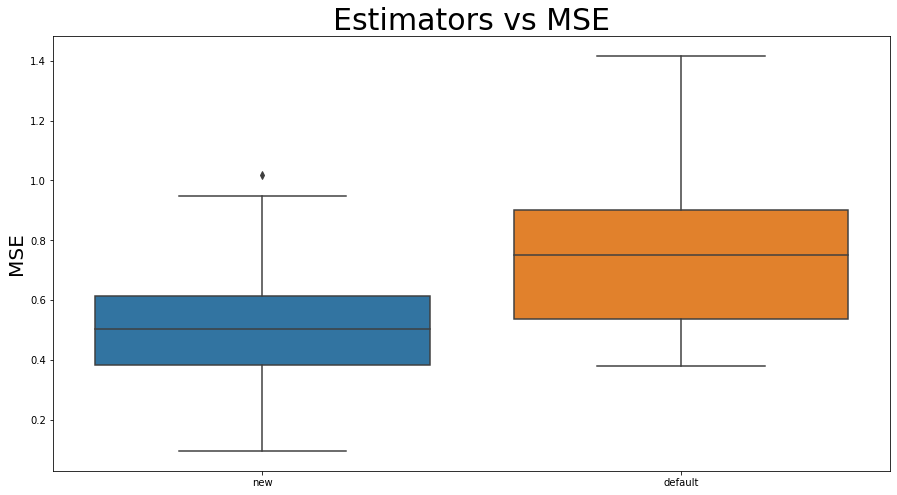

In [ ]:
XGB_params = XGB_res.best_params

models_XGB = {}
'''models_XGB['old'] = xgboost.XGBRegressor(n_estimators = 500,
                                        learning_rate = 0.1,
                                        max_depth = 5,
                                        min_child_weight = 3,
                                        n_jobs=-1)
'''
models_XGB['new'] = xgboost.XGBRegressor(**XGB_params, n_estimators = 500)

models_XGB['default'] = xgboost.XGBRegressor()

print(models_XGB)
results_XGB = train_and_test_regressor(models_XGB, XS_train, YS_train, XS_test, YS_test)
plot_model_comparison(results_XGB)

In [ ]:
optuna.visualization.plot_param_importances(XGB_res)

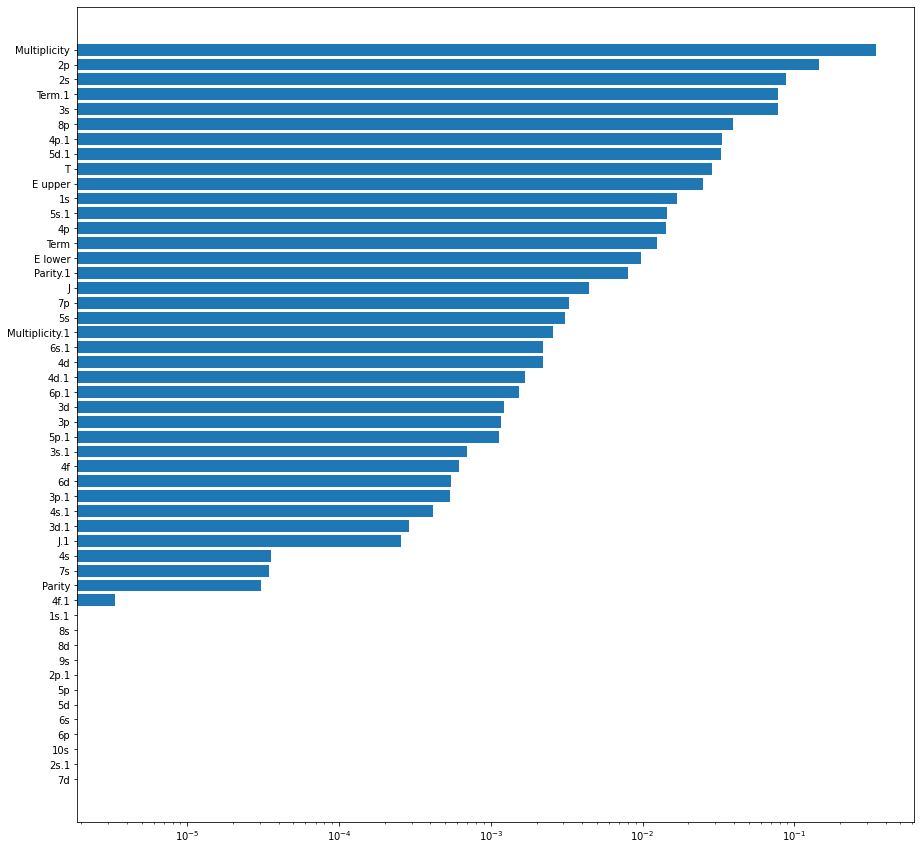

In [ ]:
'''test_score = np.zeros((500))
for i, y_pred in enumerate(models_XGB['new'].staged_predict(XW_test)):
    test_score[i] = models_XGB['new'].loss_(YW_test, y_pred)
plt.figure(figsize = (15, 7))
plt.plot(models_XGB['new'].train_score_, label = 'Train')
plt.plot(test_score, label = 'Test')
plt.semilogy()
plt.legend()
plt.show()
'''
feature_importance = models_XGB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XS_train.columns)[sorted])
plt.semilogx()
plt.show()

## TabNet

In [17]:
print(torch.cuda.is_available())

True


In [18]:
TabNet_params = {
    'n_d' : [1, 64],
    'n_steps' : [1, 25],
    'gamma' : [1., 2.],
    'n_independent' : [1, 20],
    'n_shared' : [1, 20],
    'momentum' : [1e-3, 0.4],
    'mask_type' : ['sparsemax', 'entmax'],
    'nfold' : 5,
    'squared_metrics' : False,
    'device_name' : 'cuda',
    'n_jobs' : -1
    }

model_name = TabNet

TabNet_res = main(X = XW_train, y = YW_train, model_name = model_name, params = TabNet_params, n_trials = 250)

'''with open(f'TabNet_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)
'''
'''with open(f'TabNet_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)'''

with open(f'TabNet_Extended_optimal_parameters', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)

[I 2022-08-19 17:47:07,119] A new study created in memory with name: no-name-5bfcef42-1157-4086-8f05-4ed7cd2fd0e0


Start hyperparameter optimization
{'device_name': 'cuda', 'n_d': 64, 'n_steps': 15, 'gamma': 1.6291347651687293, 'n_independent': 6, 'n_shared': 19, 'momentum': 0.008939550107880062, 'mask_type': 'sparsemax'}
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 25, 'gamma': 1.3728760219320277, 'n_independent': 2, 'n_shared': 20, 'momentum': 0.0015338734390627402, 'mask_type': 'sparsemax'}
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 23, 'gamma': 1.7388289838111084, 'n_independent': 5, 'n_shared': 7, 'momentum': 0.003755307378133042, 'mask_type': 'entmax'}
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 11, 'gamma': 1.7938488157472454, 'n_independent': 15, 'n_shared': 8, 'momentum': 0.0010642202095771272, 'mask_type': 'entmax'}
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 4, 'gamma': 1.512695922279994, 'n_independent': 13, 'n_shared': 13, 'momentum': 0.216560139114792, 'mask_type': 'entmax'}
{'device_name': 'cuda', 'n_d': 14, 'n_steps': 23, 'gamma': 1.9146032789509158, 'n_independent': 6, 'n_s

/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn("Progress bar only supports serial execution (`n_jobs=1`).")



Early stopping occurred at epoch 244 with best_epoch = 224 and best_eval_mse = 0.06539
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 113.74174
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 864.89641
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 129.1999
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 208 with best_epoch = 188 and best_eval_mse = 0.10865
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 439.08354
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 5.71706
Best weights from best epoch are automatically used!

Early stopping

[I 2022-08-19 18:20:14,138] Trial 10 finished with value: 8.706409931586398 and parameters: {'n_d': 57, 'n_steps': 22, 'gamma': 1.0314198377481247, 'n_independent': 2, 'n_shared': 13, 'momentum': 0.004632061760269788, 'mask_type': 'entmax'}. Best is trial 10 with value: 8.706409931586398.



Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 0.17882
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 47.48297
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 102 with best_epoch = 82 and best_eval_mse = 3.22706
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 121.49204
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 66.27465
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 5.06027
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 46.65131
Best weights from best epoch are automatically used!

Early stopping occur

[I 2022-08-19 18:42:19,219] Trial 3 finished with value: 18.148473372035298 and parameters: {'n_d': 60, 'n_steps': 25, 'gamma': 1.2109751253147296, 'n_independent': 20, 'n_shared': 18, 'momentum': 0.16165932409317496, 'mask_type': 'sparsemax'}. Best is trial 10 with value: 8.706409931586398.



Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 5.76085
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 135 with best_epoch = 115 and best_eval_mse = 1.30505
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 48.47294
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 101.13787
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 169 with best_epoch = 149 and best_eval_mse = 0.15136
Best weights from best epoch are automatically used!


[I 2022-08-19 18:50:08,227] Trial 8 finished with value: 0.3483118822824681 and parameters: {'n_d': 45, 'n_steps': 3, 'gamma': 1.5815622838650762, 'n_independent': 4, 'n_shared': 8, 'momentum': 0.044372823360583596, 'mask_type': 'entmax'}. Best is trial 8 with value: 0.3483118822824681.



Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 4.05117
Best weights from best epoch are automatically used!


[I 2022-08-19 18:52:18,441] Trial 6 finished with value: 2.16997422726142 and parameters: {'n_d': 1, 'n_steps': 24, 'gamma': 1.241660135555912, 'n_independent': 17, 'n_shared': 4, 'momentum': 0.0022410732967948445, 'mask_type': 'sparsemax'}. Best is trial 8 with value: 0.3483118822824681.



Early stopping occurred at epoch 195 with best_epoch = 175 and best_eval_mse = 1.34409
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 1.32345
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 46.00978
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 47.68725
Best weights from best epoch are automatically used!


[I 2022-08-19 18:57:13,320] Trial 7 finished with value: 11.248457990099187 and parameters: {'n_d': 9, 'n_steps': 14, 'gamma': 1.5047471216595583, 'n_independent': 15, 'n_shared': 20, 'momentum': 0.004448743718091094, 'mask_type': 'entmax'}. Best is trial 8 with value: 0.3483118822824681.



Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 47.04762
Best weights from best epoch are automatically used!


[I 2022-08-19 19:00:44,883] Trial 1 finished with value: 6.865078764298945 and parameters: {'n_d': 2, 'n_steps': 19, 'gamma': 1.0907542444272078, 'n_independent': 7, 'n_shared': 8, 'momentum': 0.005715734615832386, 'mask_type': 'sparsemax'}. Best is trial 8 with value: 0.3483118822824681.



Early stopping occurred at epoch 146 with best_epoch = 126 and best_eval_mse = 2.10039
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 147 with best_epoch = 127 and best_eval_mse = 12.92754
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 102 with best_epoch = 82 and best_eval_mse = 5.38735
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 80.23697
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 419.26313
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 94.966
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 163 with best_epoch = 143 and best_eval_mse = 0.23328
Best weights from best epoch are automatically used!

Early stopping o

[I 2022-08-19 19:18:00,082] Trial 4 finished with value: 4.728370000241576 and parameters: {'n_d': 22, 'n_steps': 16, 'gamma': 1.398104628312148, 'n_independent': 4, 'n_shared': 9, 'momentum': 0.2924168715794707, 'mask_type': 'sparsemax'}. Best is trial 8 with value: 0.3483118822824681.



Early stopping occurred at epoch 107 with best_epoch = 87 and best_eval_mse = 3.24492
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 123 with best_epoch = 103 and best_eval_mse = 40.46026
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 173 with best_epoch = 153 and best_eval_mse = 0.21706
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 108 with best_epoch = 88 and best_eval_mse = 82.81809
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 114 with best_epoch = 94 and best_eval_mse = 0.41255
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 3.10546
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 107 with best_epoch = 87 and best_eval_mse = 3.04775
Best weights from best epoch are automatically used!

Early stopping

[I 2022-08-19 19:30:26,552] Trial 0 finished with value: 5.322943875921747 and parameters: {'n_d': 42, 'n_steps': 22, 'gamma': 1.8130662799815083, 'n_independent': 8, 'n_shared': 14, 'momentum': 0.056019800535420584, 'mask_type': 'entmax'}. Best is trial 8 with value: 0.3483118822824681.



Early stopping occurred at epoch 137 with best_epoch = 117 and best_eval_mse = 0.46182
Best weights from best epoch are automatically used!


[I 2022-08-19 19:32:37,957] Trial 2 finished with value: 0.6842358849360807 and parameters: {'n_d': 39, 'n_steps': 6, 'gamma': 1.0548690934658675, 'n_independent': 4, 'n_shared': 10, 'momentum': 0.019464598482330425, 'mask_type': 'entmax'}. Best is trial 8 with value: 0.3483118822824681.



Early stopping occurred at epoch 165 with best_epoch = 145 and best_eval_mse = 3.90861
Best weights from best epoch are automatically used!


[I 2022-08-19 19:32:55,819] Trial 9 finished with value: 5.760351321263133 and parameters: {'n_d': 44, 'n_steps': 7, 'gamma': 1.6363838332028826, 'n_independent': 12, 'n_shared': 8, 'momentum': 0.001334086788651531, 'mask_type': 'sparsemax'}. Best is trial 8 with value: 0.3483118822824681.



Early stopping occurred at epoch 122 with best_epoch = 102 and best_eval_mse = 31.60316
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 241143.96495
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 185 with best_epoch = 165 and best_eval_mse = 1.18616
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 1828.75549
Best weights from best epoch are automatically used!


[I 2022-08-19 19:43:10,284] Trial 11 finished with value: 10.504168933806742 and parameters: {'n_d': 51, 'n_steps': 5, 'gamma': 1.0297398599811636, 'n_independent': 16, 'n_shared': 8, 'momentum': 0.0014848795072233112, 'mask_type': 'entmax'}. Best is trial 8 with value: 0.3483118822824681.



Early stopping occurred at epoch 264 with best_epoch = 244 and best_eval_mse = 0.19663
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 145 with best_epoch = 125 and best_eval_mse = 0.20636
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 179876.11728
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 511.36873
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 145 with best_epoch = 125 and best_eval_mse = 0.74595
Best weights from best epoch are automatically used!


[I 2022-08-19 19:52:51,615] Trial 5 finished with value: 0.8938576899326305 and parameters: {'n_d': 53, 'n_steps': 7, 'gamma': 1.161224463840882, 'n_independent': 5, 'n_shared': 6, 'momentum': 0.0015769423485793286, 'mask_type': 'entmax'}. Best is trial 8 with value: 0.3483118822824681.



Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 4.73345
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 163927.57011
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 863285.97598
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 143 with best_epoch = 123 and best_eval_mse = 55.98631
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 123 with best_epoch = 103 and best_eval_mse = 2.53502
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 31.86258
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 885994.4136
Best weights from best epoch are automatically used!


[I 2022-08-19 20:22:57,461] Trial 9 finished with value: 638.093292429652 and parameters: {'n_d': 34, 'n_steps': 23, 'gamma': 1.0940724660895311, 'n_independent': 19, 'n_shared': 19, 'momentum': 0.0025452348914761654, 'mask_type': 'entmax'}. Best is trial 9 with value: 638.093292429652.


{'device_name': 'cuda', 'n_d': 35, 'n_steps': 12, 'gamma': 1.4837848858964695, 'n_independent': 5, 'n_shared': 20, 'momentum': 0.05194519358195947, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 171 with best_epoch = 151 and best_eval_mse = 2.51254
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 64.24857
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 5.17374
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 63.61757
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 46.9038
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 17.63371
Best weights from best epoch are automat

[I 2022-08-19 20:45:06,665] Trial 12 finished with value: 5.643663793891589 and parameters: {'n_d': 35, 'n_steps': 12, 'gamma': 1.4837848858964695, 'n_independent': 5, 'n_shared': 20, 'momentum': 0.05194519358195947, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 5.643663793891589.


{'device_name': 'cuda', 'n_d': 42, 'n_steps': 6, 'gamma': 1.5011351351075102, 'n_independent': 5, 'n_shared': 7, 'momentum': 0.08465426820428462, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 41.30115
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 1.41979
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 143 with best_epoch = 123 and best_eval_mse = 0.53628
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 133 with best_epoch = 113 and best_eval_mse = 1.14518
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 122 with best_epoch = 102 and best_eval_mse = 72.13753
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 2.65338
Best weights from best epoch are automat

[I 2022-08-19 20:57:21,113] Trial 13 finished with value: 1.0412822241497388 and parameters: {'n_d': 42, 'n_steps': 6, 'gamma': 1.5011351351075102, 'n_independent': 5, 'n_shared': 7, 'momentum': 0.08465426820428462, 'mask_type': 'sparsemax'}. Best is trial 13 with value: 1.0412822241497388.


{'device_name': 'cuda', 'n_d': 33, 'n_steps': 15, 'gamma': 1.3969455190055755, 'n_independent': 1, 'n_shared': 14, 'momentum': 0.003096772586155564, 'mask_type': 'entmax'}

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 2.48519
Best weights from best epoch are automatically used!


[I 2022-08-19 20:58:22,717] Trial 0 finished with value: 3.617686391149031 and parameters: {'n_d': 64, 'n_steps': 15, 'gamma': 1.6291347651687293, 'n_independent': 6, 'n_shared': 19, 'momentum': 0.008939550107880062, 'mask_type': 'sparsemax'}. Best is trial 13 with value: 1.0412822241497388.


{'device_name': 'cuda', 'n_d': 21, 'n_steps': 21, 'gamma': 1.0372795267747044, 'n_independent': 12, 'n_shared': 9, 'momentum': 0.001542718732532241, 'mask_type': 'entmax'}

Early stopping occurred at epoch 102 with best_epoch = 82 and best_eval_mse = 3.79422
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 41.56631
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 10.177
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 120 with best_epoch = 100 and best_eval_mse = 230.28694
Best weights from best epoch are automatically used!


[I 2022-08-19 21:08:59,040] Trial 1 finished with value: 11.685613935755656 and parameters: {'n_d': 52, 'n_steps': 25, 'gamma': 1.3728760219320277, 'n_independent': 2, 'n_shared': 20, 'momentum': 0.0015338734390627402, 'mask_type': 'sparsemax'}. Best is trial 13 with value: 1.0412822241497388.


{'device_name': 'cuda', 'n_d': 5, 'n_steps': 4, 'gamma': 1.1773965261079118, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.05517059451375035, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 38234.16699
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 3.83725
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 6.59652
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 3.73234
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 40.16833
Best weights from best epoch are automatically used!


[I 2022-08-19 21:15:06,900] Trial 6 finished with value: 6.383724652548139 and parameters: {'n_d': 3, 'n_steps': 10, 'gamma': 1.8668721870837888, 'n_independent': 20, 'n_shared': 14, 'momentum': 0.0031708796096451045, 'mask_type': 'entmax'}. Best is trial 13 with value: 1.0412822241497388.


{'device_name': 'cuda', 'n_d': 26, 'n_steps': 9, 'gamma': 1.6207590388375608, 'n_independent': 6, 'n_shared': 8, 'momentum': 0.2848269982553246, 'mask_type': 'entmax'}

Early stopping occurred at epoch 23 with best_epoch = 3 and best_eval_mse = 41.20317
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 47.02931
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 4.27379
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 6442.99556
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 42.04867
Best weights from best epoch are automatically used!


[I 2022-08-19 21:19:00,644] Trial 16 finished with value: 3.7723190431914597 and parameters: {'n_d': 5, 'n_steps': 4, 'gamma': 1.1773965261079118, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.05517059451375035, 'mask_type': 'sparsemax'}. Best is trial 13 with value: 1.0412822241497388.


{'device_name': 'cuda', 'n_d': 4, 'n_steps': 15, 'gamma': 1.7451075832797698, 'n_independent': 10, 'n_shared': 14, 'momentum': 0.001344870657099554, 'mask_type': 'entmax'}

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 25.52631
Best weights from best epoch are automatically used!


[I 2022-08-19 21:21:04,705] Trial 14 finished with value: 4.823170535363117 and parameters: {'n_d': 33, 'n_steps': 15, 'gamma': 1.3969455190055755, 'n_independent': 1, 'n_shared': 14, 'momentum': 0.003096772586155564, 'mask_type': 'entmax'}. Best is trial 13 with value: 1.0412822241497388.


{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.2134529768469349, 'n_independent': 9, 'n_shared': 10, 'momentum': 0.009930811747155845, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 3271.35754
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 149 with best_epoch = 129 and best_eval_mse = 0.19028
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 179 with best_epoch = 159 and best_eval_mse = 0.16441
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 171 with best_epoch = 151 and best_eval_mse = 0.10698
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 176 with best_epoch = 156 and best_eval_mse = 0.0973
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 1.33756
Best weights from best epoch are au

[I 2022-08-19 21:28:39,930] Trial 19 finished with value: 0.527444181145186 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.2134529768469349, 'n_independent': 9, 'n_shared': 10, 'momentum': 0.009930811747155845, 'mask_type': 'sparsemax'}. Best is trial 19 with value: 0.527444181145186.


{'device_name': 'cuda', 'n_d': 39, 'n_steps': 15, 'gamma': 1.3196088378122546, 'n_independent': 11, 'n_shared': 6, 'momentum': 0.0034927441514296573, 'mask_type': 'entmax'}

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 157.77503
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 14946.77911
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 144 with best_epoch = 124 and best_eval_mse = 1.7498
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 3618.84896
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 123.08682
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 2.75424
Best weights from best epoch are a

[I 2022-08-19 21:42:51,965] Trial 5 finished with value: 3.510028813957143 and parameters: {'n_d': 14, 'n_steps': 23, 'gamma': 1.9146032789509158, 'n_independent': 6, 'n_shared': 9, 'momentum': 0.004551547197809031, 'mask_type': 'entmax'}. Best is trial 19 with value: 0.527444181145186.


{'device_name': 'cuda', 'n_d': 19, 'n_steps': 2, 'gamma': 1.0287945487487922, 'n_independent': 14, 'n_shared': 1, 'momentum': 0.33225980387884835, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 3651.52407
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 31495.11227
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 14155.3795
Best weights from best epoch are automatically used!


[I 2022-08-19 21:47:13,960] Trial 20 finished with value: 71.42714043395716 and parameters: {'n_d': 39, 'n_steps': 15, 'gamma': 1.3196088378122546, 'n_independent': 11, 'n_shared': 6, 'momentum': 0.0034927441514296573, 'mask_type': 'entmax'}. Best is trial 19 with value: 0.527444181145186.


{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.644506099537803, 'n_independent': 13, 'n_shared': 1, 'momentum': 0.33458920919023244, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 178 with best_epoch = 158 and best_eval_mse = 0.68961
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 4.50138
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 0.34014
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 68.34517
Best weights from best epoch are automatically used!


[I 2022-08-19 21:49:07,694] Trial 18 finished with value: 20.329634804437408 and parameters: {'n_d': 4, 'n_steps': 15, 'gamma': 1.7451075832797698, 'n_independent': 10, 'n_shared': 14, 'momentum': 0.001344870657099554, 'mask_type': 'entmax'}. Best is trial 19 with value: 0.527444181145186.


{'device_name': 'cuda', 'n_d': 48, 'n_steps': 1, 'gamma': 1.020591856380909, 'n_independent': 14, 'n_shared': 2, 'momentum': 0.2213205193378101, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 127 with best_epoch = 107 and best_eval_mse = 0.20288
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 295 with best_epoch = 275 and best_eval_mse = 0.0499
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 180 with best_epoch = 160 and best_eval_mse = 0.17225
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 125 with best_epoch = 105 and best_eval_mse = 0.15139
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 194 with best_epoch = 174 and best_eval_mse = 0.18409
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 5.65878
Best weights from best epoch are automa

[I 2022-08-19 21:58:27,861] Trial 22 finished with value: 0.3253651258261446 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.644506099537803, 'n_independent': 13, 'n_shared': 1, 'momentum': 0.33458920919023244, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.



Early stopping occurred at epoch 335 with best_epoch = 315 and best_eval_mse = 0.05488
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.652048882334782, 'n_independent': 15, 'n_shared': 1, 'momentum': 0.34626860914379104, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 273 with best_epoch = 253 and best_eval_mse = 0.05809
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 8929.5412
Best weights from best epoch are automatically used!


[I 2022-08-19 22:00:22,280] Trial 15 finished with value: 134.00515124110137 and parameters: {'n_d': 21, 'n_steps': 21, 'gamma': 1.0372795267747044, 'n_independent': 12, 'n_shared': 9, 'momentum': 0.001542718732532241, 'mask_type': 'entmax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.6782213872914546, 'n_independent': 15, 'n_shared': 1, 'momentum': 0.17632216254680153, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 177 with best_epoch = 157 and best_eval_mse = 0.07799
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 2.26492
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 182 with best_epoch = 162 and best_eval_mse = 0.10027
Best weights from best epoch are automatically used!


[I 2022-08-19 22:01:18,774] Trial 23 finished with value: 0.351338642769952 and parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.020591856380909, 'n_independent': 14, 'n_shared': 2, 'momentum': 0.2213205193378101, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 58, 'n_steps': 1, 'gamma': 1.6668099526022475, 'n_independent': 15, 'n_shared': 1, 'momentum': 0.3313565270640169, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 135 with best_epoch = 115 and best_eval_mse = 0.29672
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 1.27718
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 163 with best_epoch = 143 and best_eval_mse = 0.17509
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 4.15038
Best weights from best epoch are automatically used!


[I 2022-08-19 22:03:49,126] Trial 21 finished with value: 1.0161844846131598 and parameters: {'n_d': 19, 'n_steps': 2, 'gamma': 1.0287945487487922, 'n_independent': 14, 'n_shared': 1, 'momentum': 0.33225980387884835, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 57, 'n_steps': 8, 'gamma': 1.6992206245416575, 'n_independent': 16, 'n_shared': 1, 'momentum': 0.3472722663409857, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 230 with best_epoch = 210 and best_eval_mse = 0.05595
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 191 with best_epoch = 171 and best_eval_mse = 0.1173
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 5.76625
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 173 with best_epoch = 153 and best_eval_mse = 0.11808
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 105.45244
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 113 with best_epoch = 93 and best_eval_mse = 0.46168
Best weights from best epoch are automati

[I 2022-08-19 22:07:41,989] Trial 24 finished with value: 0.523727880293093 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.652048882334782, 'n_independent': 15, 'n_shared': 1, 'momentum': 0.34626860914379104, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 63, 'n_steps': 7, 'gamma': 1.7678914134935657, 'n_independent': 15, 'n_shared': 4, 'momentum': 0.16498905994822746, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 3.15099
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 136 with best_epoch = 116 and best_eval_mse = 0.15247
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 144 with best_epoch = 124 and best_eval_mse = 0.25557
Best weights from best epoch are automatically used!


[I 2022-08-19 22:09:47,756] Trial 26 finished with value: 1.036298352425971 and parameters: {'n_d': 58, 'n_steps': 1, 'gamma': 1.6668099526022475, 'n_independent': 15, 'n_shared': 1, 'momentum': 0.3313565270640169, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 26, 'n_steps': 7, 'gamma': 1.9921991674362671, 'n_independent': 17, 'n_shared': 4, 'momentum': 0.13120102381151602, 'mask_type': 'sparsemax'}


[I 2022-08-19 22:11:29,873] Trial 25 finished with value: 0.6577571988973262 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.6782213872914546, 'n_independent': 15, 'n_shared': 1, 'momentum': 0.17632216254680153, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.



Early stopping occurred at epoch 172 with best_epoch = 152 and best_eval_mse = 0.13793
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 7, 'gamma': 1.7870366661797035, 'n_independent': 18, 'n_shared': 4, 'momentum': 0.13520968512441128, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 1.03853
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 4.77614
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 3.37385
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 2.64991
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 180 with best_epoch = 160 and best_eval_mse = 0.33237
Best weights from best epoch are automat

[I 2022-08-19 22:26:29,872] Trial 17 finished with value: 1.7808905604606575 and parameters: {'n_d': 26, 'n_steps': 9, 'gamma': 1.6207590388375608, 'n_independent': 6, 'n_shared': 8, 'momentum': 0.2848269982553246, 'mask_type': 'entmax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 44, 'n_steps': 6, 'gamma': 1.7810670070733687, 'n_independent': 18, 'n_shared': 4, 'momentum': 0.13413623294340912, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 251 with best_epoch = 231 and best_eval_mse = 0.31877
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 3.56812
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 2.85119
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 201.56042
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 3.15692
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 2.88068
Best weights from best epoch are automatica

[I 2022-08-19 22:32:50,912] Trial 28 finished with value: 1.1268447086816944 and parameters: {'n_d': 63, 'n_steps': 7, 'gamma': 1.7678914134935657, 'n_independent': 15, 'n_shared': 4, 'momentum': 0.16498905994822746, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 46, 'n_steps': 4, 'gamma': 1.513579023150989, 'n_independent': 18, 'n_shared': 4, 'momentum': 0.1271796060981672, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 2.17932
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 138 with best_epoch = 118 and best_eval_mse = 1.77813
Best weights from best epoch are automatically used!


[I 2022-08-19 22:33:31,022] Trial 29 finished with value: 1.580299302893079 and parameters: {'n_d': 26, 'n_steps': 7, 'gamma': 1.9921991674362671, 'n_independent': 17, 'n_shared': 4, 'momentum': 0.13120102381151602, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 46, 'n_steps': 4, 'gamma': 1.545037295227086, 'n_independent': 13, 'n_shared': 4, 'momentum': 0.035255156318123655, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 2.1007
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 1.02695
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 2.39072
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 2.57396
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 3.3001
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 2.64482
Best weights from best epoch are automatically u

[I 2022-08-19 22:40:42,822] Trial 30 finished with value: 4.082982595829318 and parameters: {'n_d': 44, 'n_steps': 7, 'gamma': 1.7870366661797035, 'n_independent': 18, 'n_shared': 4, 'momentum': 0.13520968512441128, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 55, 'n_steps': 4, 'gamma': 1.5406509847710959, 'n_independent': 13, 'n_shared': 3, 'momentum': 0.03103240648790382, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 2.34934
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 179 with best_epoch = 159 and best_eval_mse = 0.393
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 1.35697
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 0.71957
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 196 with best_epoch = 176 and best_eval_mse = 0.14418
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 234 with best_epoch = 214 and best_eval_mse = 0.25945
Best weights from best epoch are automatic

[I 2022-08-19 22:47:54,608] Trial 32 finished with value: 1.3526046110589895 and parameters: {'n_d': 46, 'n_steps': 4, 'gamma': 1.513579023150989, 'n_independent': 18, 'n_shared': 4, 'momentum': 0.1271796060981672, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 54, 'n_steps': 4, 'gamma': 1.2573277554502755, 'n_independent': 13, 'n_shared': 2, 'momentum': 0.03175253292604464, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 4.0565
Best weights from best epoch are automatically used!


[I 2022-08-19 22:48:14,077] Trial 33 finished with value: 1.1160527490103767 and parameters: {'n_d': 46, 'n_steps': 4, 'gamma': 1.545037295227086, 'n_independent': 13, 'n_shared': 4, 'momentum': 0.035255156318123655, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 56, 'n_steps': 3, 'gamma': 1.5702641226242586, 'n_independent': 16, 'n_shared': 2, 'momentum': 0.230863814180423, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 1.46256
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 2.87882
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 1.0165
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 148 with best_epoch = 128 and best_eval_mse = 0.66468
Best weights from best epoch are automatically used!


[I 2022-08-19 22:51:18,118] Trial 27 finished with value: 2.9732630173084886 and parameters: {'n_d': 57, 'n_steps': 8, 'gamma': 1.6992206245416575, 'n_independent': 16, 'n_shared': 1, 'momentum': 0.3472722663409857, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 55, 'n_steps': 3, 'gamma': 1.567645752600719, 'n_independent': 12, 'n_shared': 3, 'momentum': 0.20120734921573472, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 3.61522
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 2.77753
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 169 with best_epoch = 149 and best_eval_mse = 0.40872
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 211 with best_epoch = 191 and best_eval_mse = 0.25269
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 3.14212
Best weights from best epoch are automatically used!


[I 2022-08-19 22:54:14,856] Trial 34 finished with value: 1.2921154588904566 and parameters: {'n_d': 55, 'n_steps': 4, 'gamma': 1.5406509847710959, 'n_independent': 13, 'n_shared': 3, 'momentum': 0.03103240648790382, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 50, 'n_steps': 3, 'gamma': 1.2512166921398, 'n_independent': 12, 'n_shared': 6, 'momentum': 0.2226277583242247, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 0.68259
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 130 with best_epoch = 110 and best_eval_mse = 0.44921
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 154 with best_epoch = 134 and best_eval_mse = 0.25794
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 1.24309
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 2.53678
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 0.18038
Best weights from best epoch are automatica

[I 2022-08-19 23:00:11,552] Trial 35 finished with value: 0.8100543935788022 and parameters: {'n_d': 54, 'n_steps': 4, 'gamma': 1.2573277554502755, 'n_independent': 13, 'n_shared': 2, 'momentum': 0.03175253292604464, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 38, 'n_steps': 19, 'gamma': 1.415696211941549, 'n_independent': 11, 'n_shared': 6, 'momentum': 0.22432663662817287, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 4.00392
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 137 with best_epoch = 117 and best_eval_mse = 0.23075
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 166 with best_epoch = 146 and best_eval_mse = 0.87636
Best weights from best epoch are automatically used!


[I 2022-08-19 23:01:55,694] Trial 36 finished with value: 1.0472279651625316 and parameters: {'n_d': 56, 'n_steps': 3, 'gamma': 1.5702641226242586, 'n_independent': 16, 'n_shared': 2, 'momentum': 0.230863814180423, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 64, 'n_steps': 17, 'gamma': 1.4291743412111073, 'n_independent': 11, 'n_shared': 6, 'momentum': 0.010749912337719577, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 0.21275
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 258 with best_epoch = 238 and best_eval_mse = 0.17579
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 162 with best_epoch = 142 and best_eval_mse = 0.28236
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 149 with best_epoch = 129 and best_eval_mse = 2.11309
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 144 with best_epoch = 124 and best_eval_mse = 1.88854
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 155 with best_epoch = 135 and best_eval_mse = 0.55071
Best weights from best epoch are

[I 2022-08-19 23:19:18,960] Trial 38 finished with value: 0.8469185424428016 and parameters: {'n_d': 50, 'n_steps': 3, 'gamma': 1.2512166921398, 'n_independent': 12, 'n_shared': 6, 'momentum': 0.2226277583242247, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 63, 'n_steps': 18, 'gamma': 1.4322919499382376, 'n_independent': 9, 'n_shared': 6, 'momentum': 0.07254998438799172, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 2.89762
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 324.17227
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 121 with best_epoch = 101 and best_eval_mse = 3.18885
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 185 with best_epoch = 165 and best_eval_mse = 0.29775
Best weights from best epoch are automatically used!


[I 2022-08-19 23:29:04,985] Trial 37 finished with value: 0.5653673831102803 and parameters: {'n_d': 55, 'n_steps': 3, 'gamma': 1.567645752600719, 'n_independent': 12, 'n_shared': 3, 'momentum': 0.20120734921573472, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 62, 'n_steps': 1, 'gamma': 1.1443857172988336, 'n_independent': 8, 'n_shared': 11, 'momentum': 0.012370523420299522, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 212 with best_epoch = 192 and best_eval_mse = 0.44659
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 118 with best_epoch = 98 and best_eval_mse = 4.55263
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 113 with best_epoch = 93 and best_eval_mse = 0.15885
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 99.81681
Best weights from best epoch are automatically used!


[I 2022-08-19 23:35:55,262] Trial 40 finished with value: 10.525606396514515 and parameters: {'n_d': 64, 'n_steps': 17, 'gamma': 1.4291743412111073, 'n_independent': 11, 'n_shared': 6, 'momentum': 0.010749912337719577, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 40, 'n_steps': 1, 'gamma': 1.0043111547343806, 'n_independent': 8, 'n_shared': 11, 'momentum': 0.010532783598721462, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 0.81079
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 5.61656
Best weights from best epoch are automatically used!


[I 2022-08-19 23:37:14,395] Trial 31 finished with value: 1.751434653428267 and parameters: {'n_d': 44, 'n_steps': 6, 'gamma': 1.7810670070733687, 'n_independent': 18, 'n_shared': 4, 'momentum': 0.13413623294340912, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 39, 'n_steps': 1, 'gamma': 1.1374395563699948, 'n_independent': 8, 'n_shared': 11, 'momentum': 0.011775322654648025, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 134 with best_epoch = 114 and best_eval_mse = 0.16396
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 0.72685
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 160 with best_epoch = 140 and best_eval_mse = 0.18135
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 41.99846
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 207 with best_epoch = 187 and best_eval_mse = 0.10141
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 41.46061
Best weights from best epoch are auto

[I 2022-08-19 23:45:41,493] Trial 43 finished with value: 0.671513260929738 and parameters: {'n_d': 40, 'n_steps': 1, 'gamma': 1.0043111547343806, 'n_independent': 8, 'n_shared': 11, 'momentum': 0.010532783598721462, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.1572020289073004, 'n_independent': 9, 'n_shared': 11, 'momentum': 0.01688605396105987, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 2.47085
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 119 with best_epoch = 99 and best_eval_mse = 0.25633
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 53.77542
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 1.67354
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 206 with best_epoch = 186 and best_eval_mse = 0.10108
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 0.90905
Best weights from best epoch are automatic

[I 2022-08-19 23:52:18,459] Trial 44 finished with value: 1.420660711384187 and parameters: {'n_d': 39, 'n_steps': 1, 'gamma': 1.1374395563699948, 'n_independent': 8, 'n_shared': 11, 'momentum': 0.011775322654648025, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 49, 'n_steps': 5, 'gamma': 1.2018459077383554, 'n_independent': 10, 'n_shared': 12, 'momentum': 0.019232371217558906, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 73.82986
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 0.14423
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 165 with best_epoch = 145 and best_eval_mse = 0.13249
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 1.99719
Best weights from best epoch are automatically used!


[I 2022-08-19 23:54:36,081] Trial 45 finished with value: 0.7591673957182886 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.1572020289073004, 'n_independent': 9, 'n_shared': 11, 'momentum': 0.01688605396105987, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 49, 'n_steps': 5, 'gamma': 1.8379211550433208, 'n_independent': 14, 'n_shared': 16, 'momentum': 0.006744462991917881, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 145 with best_epoch = 125 and best_eval_mse = 1.67762
Best weights from best epoch are automatically used!


[I 2022-08-19 23:57:22,291] Trial 39 finished with value: 1.456247115720344 and parameters: {'n_d': 38, 'n_steps': 19, 'gamma': 1.415696211941549, 'n_independent': 11, 'n_shared': 6, 'momentum': 0.22432663662817287, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 59, 'n_steps': 11, 'gamma': 1.8732450247968606, 'n_independent': 14, 'n_shared': 16, 'momentum': 0.007185257755786636, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 7.01102
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 0.2168
Best weights from best epoch are automatically used!


[I 2022-08-19 23:59:50,385] Trial 42 finished with value: 0.39439231204923286 and parameters: {'n_d': 62, 'n_steps': 1, 'gamma': 1.1443857172988336, 'n_independent': 8, 'n_shared': 11, 'momentum': 0.012370523420299522, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 61, 'n_steps': 10, 'gamma': 1.8421405243903357, 'n_independent': 3, 'n_shared': 13, 'momentum': 0.004768025113326555, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 117 with best_epoch = 97 and best_eval_mse = 2.20275
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 117 with best_epoch = 97 and best_eval_mse = 2.49803
Best weights from best epoch are automatically used!


[I 2022-08-20 00:05:01,128] Trial 41 finished with value: 4.9691095520734425 and parameters: {'n_d': 63, 'n_steps': 18, 'gamma': 1.4322919499382376, 'n_independent': 9, 'n_shared': 6, 'momentum': 0.07254998438799172, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 60, 'n_steps': 11, 'gamma': 1.092672152315997, 'n_independent': 3, 'n_shared': 13, 'momentum': 0.02157986388873747, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 118 with best_epoch = 98 and best_eval_mse = 2.98627
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 121 with best_epoch = 101 and best_eval_mse = 2.15126
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 8.83577
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 3.69647
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 124 with best_epoch = 104 and best_eval_mse = 0.72752
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 83.7276
Best weights from best epoch are automati

[I 2022-08-20 00:14:50,972] Trial 47 finished with value: 4.562750963186038 and parameters: {'n_d': 49, 'n_steps': 5, 'gamma': 1.8379211550433208, 'n_independent': 14, 'n_shared': 16, 'momentum': 0.006744462991917881, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 59, 'n_steps': 10, 'gamma': 1.3375616502884498, 'n_independent': 7, 'n_shared': 13, 'momentum': 0.006356556255790294, 'mask_type': 'entmax'}

Early stopping occurred at epoch 128 with best_epoch = 108 and best_eval_mse = 3.13049
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 16.61999
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 10.0535
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 106 with best_epoch = 86 and best_eval_mse = 2.1363
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 200 with best_epoch = 180 and best_eval_mse = 1.36468
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 125 with best_epoch = 105 and best_eval_mse = 2.0228
Best weights from best epoch are automati

[I 2022-08-20 00:29:49,582] Trial 50 finished with value: 2.852776738504127 and parameters: {'n_d': 60, 'n_steps': 11, 'gamma': 1.092672152315997, 'n_independent': 3, 'n_shared': 13, 'momentum': 0.02157986388873747, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 59, 'n_steps': 2, 'gamma': 1.083407903053142, 'n_independent': 7, 'n_shared': 10, 'momentum': 0.0063429835051059605, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 656.08483
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 148 with best_epoch = 128 and best_eval_mse = 1.89478
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 5.54313
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 123 with best_epoch = 103 and best_eval_mse = 0.38722
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 5.05291
Best weights from best epoch are automatically used!


[I 2022-08-20 00:38:05,935] Trial 48 finished with value: 6.704122023916827 and parameters: {'n_d': 59, 'n_steps': 11, 'gamma': 1.8732450247968606, 'n_independent': 14, 'n_shared': 16, 'momentum': 0.007185257755786636, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 47, 'n_steps': 2, 'gamma': 1.086886542150246, 'n_independent': 7, 'n_shared': 10, 'momentum': 0.005433597496510882, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 200 with best_epoch = 180 and best_eval_mse = 0.3694
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 102 with best_epoch = 82 and best_eval_mse = 0.28833
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 218 with best_epoch = 198 and best_eval_mse = 0.1812
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 12.72555
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 0.56358
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 1.2324
Best weights from best epoch are automatic

[I 2022-08-20 00:46:24,527] Trial 53 finished with value: 0.6781405925610938 and parameters: {'n_d': 47, 'n_steps': 2, 'gamma': 1.086886542150246, 'n_independent': 7, 'n_shared': 10, 'momentum': 0.005433597496510882, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 52, 'n_steps': 2, 'gamma': 1.1971288914307106, 'n_independent': 4, 'n_shared': 13, 'momentum': 0.09291369584410733, 'mask_type': 'entmax'}

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 1.39808
Best weights from best epoch are automatically used!


[I 2022-08-20 00:46:55,957] Trial 52 finished with value: 0.7529001303396304 and parameters: {'n_d': 59, 'n_steps': 2, 'gamma': 1.083407903053142, 'n_independent': 7, 'n_shared': 10, 'momentum': 0.0063429835051059605, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 52, 'n_steps': 5, 'gamma': 1.1993133690936078, 'n_independent': 10, 'n_shared': 13, 'momentum': 0.01543586382460426, 'mask_type': 'entmax'}

Early stopping occurred at epoch 215 with best_epoch = 195 and best_eval_mse = 0.124
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 1.17477
Best weights from best epoch are automatically used!


[I 2022-08-20 00:49:35,776] Trial 51 finished with value: 2.319703132216037 and parameters: {'n_d': 59, 'n_steps': 10, 'gamma': 1.3375616502884498, 'n_independent': 7, 'n_shared': 13, 'momentum': 0.006356556255790294, 'mask_type': 'entmax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 52, 'n_steps': 5, 'gamma': 1.1701519269369423, 'n_independent': 10, 'n_shared': 8, 'momentum': 0.014344144385984612, 'mask_type': 'entmax'}

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 1.01905
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 2.09287
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 142 with best_epoch = 122 and best_eval_mse = 0.22282
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 4.37481
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 219 with best_epoch = 199 and best_eval_mse = 0.48849
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 274 with best_epoch = 254 and best_eval_mse = 0.06334
Best weights from best epoch are automatica

[I 2022-08-20 00:55:50,243] Trial 54 finished with value: 0.8353893025345218 and parameters: {'n_d': 52, 'n_steps': 2, 'gamma': 1.1971288914307106, 'n_independent': 4, 'n_shared': 13, 'momentum': 0.09291369584410733, 'mask_type': 'entmax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 36, 'n_steps': 5, 'gamma': 1.220292454327849, 'n_independent': 10, 'n_shared': 8, 'momentum': 0.0160351759259177, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 3.82768
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 220 with best_epoch = 200 and best_eval_mse = 0.18628
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 260 with best_epoch = 240 and best_eval_mse = 0.14714
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 15.07589
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 114 with best_epoch = 94 and best_eval_mse = 0.91326
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 2.1433
Best weights from best epoch are automatica

[I 2022-08-20 01:07:42,050] Trial 56 finished with value: 0.8815406930516076 and parameters: {'n_d': 52, 'n_steps': 5, 'gamma': 1.1701519269369423, 'n_independent': 10, 'n_shared': 8, 'momentum': 0.014344144385984612, 'mask_type': 'entmax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 30, 'n_steps': 3, 'gamma': 1.6277601123416472, 'n_independent': 10, 'n_shared': 18, 'momentum': 0.3810479852539194, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 165 with best_epoch = 145 and best_eval_mse = 0.3513
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 5.26633
Best weights from best epoch are automatically used!


[I 2022-08-20 01:08:04,530] Trial 49 finished with value: 2.004473415512998 and parameters: {'n_d': 61, 'n_steps': 10, 'gamma': 1.8421405243903357, 'n_independent': 3, 'n_shared': 13, 'momentum': 0.004768025113326555, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 35, 'n_steps': 13, 'gamma': 1.6316978201835992, 'n_independent': 16, 'n_shared': 2, 'momentum': 0.37063828329211473, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 180 with best_epoch = 160 and best_eval_mse = 0.58486
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 3.1219
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 176 with best_epoch = 156 and best_eval_mse = 0.35181
Best weights from best epoch are automatically used!


[I 2022-08-20 01:09:44,980] Trial 57 finished with value: 1.1649856432065218 and parameters: {'n_d': 36, 'n_steps': 5, 'gamma': 1.220292454327849, 'n_independent': 10, 'n_shared': 8, 'momentum': 0.0160351759259177, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 31, 'n_steps': 13, 'gamma': 1.6256166760308755, 'n_independent': 5, 'n_shared': 18, 'momentum': 0.37554541373413014, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 107 with best_epoch = 87 and best_eval_mse = 0.82919
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 4.1765
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 1.32449
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 255 with best_epoch = 235 and best_eval_mse = 0.23413
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 4.97238
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 92.04222
Best weights from best epoch are automati

[I 2022-08-20 01:22:42,043] Trial 55 finished with value: 0.7485844967605647 and parameters: {'n_d': 52, 'n_steps': 5, 'gamma': 1.1993133690936078, 'n_independent': 10, 'n_shared': 13, 'momentum': 0.01543586382460426, 'mask_type': 'entmax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 43, 'n_steps': 13, 'gamma': 1.717794560664501, 'n_independent': 16, 'n_shared': 2, 'momentum': 0.39717792571722177, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 53.77211
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 1.31223
Best weights from best epoch are automatically used!


[I 2022-08-20 01:24:56,226] Trial 58 finished with value: 1.419378422670723 and parameters: {'n_d': 30, 'n_steps': 3, 'gamma': 1.6277601123416472, 'n_independent': 10, 'n_shared': 18, 'momentum': 0.3810479852539194, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 54, 'n_steps': 3, 'gamma': 1.7195383684088859, 'n_independent': 12, 'n_shared': 2, 'momentum': 0.276069186238267, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 196 with best_epoch = 176 and best_eval_mse = 0.12159
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 4.91097
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 162 with best_epoch = 142 and best_eval_mse = 2.07808
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 3.87927
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 317 with best_epoch = 297 and best_eval_mse = 0.15728
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 3.49832
Best weights from best epoch are automati

[I 2022-08-20 01:38:24,142] Trial 62 finished with value: 1.078325248821042 and parameters: {'n_d': 54, 'n_steps': 3, 'gamma': 1.7195383684088859, 'n_independent': 12, 'n_shared': 2, 'momentum': 0.276069186238267, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 43, 'n_steps': 25, 'gamma': 1.5890378887347296, 'n_independent': 16, 'n_shared': 3, 'momentum': 0.002014032921056329, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 135 with best_epoch = 115 and best_eval_mse = 1.96357
Best weights from best epoch are automatically used!


[I 2022-08-20 01:41:07,451] Trial 60 finished with value: 4.468263595485295 and parameters: {'n_d': 31, 'n_steps': 13, 'gamma': 1.6256166760308755, 'n_independent': 5, 'n_shared': 18, 'momentum': 0.37554541373413014, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 42, 'n_steps': 2, 'gamma': 1.4777065540523526, 'n_independent': 16, 'n_shared': 3, 'momentum': 0.204032960604944, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 4.23397
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 171 with best_epoch = 151 and best_eval_mse = 0.11504
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 3.2191
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 4.63672
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 4.52998
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 28943.88895
Best weights from best epoch are automatica

[I 2022-08-20 01:48:37,086] Trial 64 finished with value: 1.3641643590307626 and parameters: {'n_d': 42, 'n_steps': 2, 'gamma': 1.4777065540523526, 'n_independent': 16, 'n_shared': 3, 'momentum': 0.204032960604944, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 48, 'n_steps': 1, 'gamma': 1.5815199636162163, 'n_independent': 20, 'n_shared': 3, 'momentum': 0.0019562796088629544, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 2.90973
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 7.97207
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 194 with best_epoch = 174 and best_eval_mse = 0.15703
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 1.9451
Best weights from best epoch are automatically used!


[I 2022-08-20 01:53:10,587] Trial 46 finished with value: 0.8784645937492386 and parameters: {'n_d': 49, 'n_steps': 5, 'gamma': 1.2018459077383554, 'n_independent': 10, 'n_shared': 12, 'momentum': 0.019232371217558906, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 56, 'n_steps': 1, 'gamma': 1.582420363315532, 'n_independent': 12, 'n_shared': 3, 'momentum': 0.2901542657064561, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 171 with best_epoch = 151 and best_eval_mse = 0.14523
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 101077.02625
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 16.13435
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 114 with best_epoch = 94 and best_eval_mse = 2.79488
Best weights from best epoch are automatically used!


[I 2022-08-20 01:56:32,759] Trial 65 finished with value: 1.6343425956275515 and parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.5815199636162163, 'n_independent': 20, 'n_shared': 3, 'momentum': 0.0019562796088629544, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 12, 'n_steps': 3, 'gamma': 1.6712518103138785, 'n_independent': 12, 'n_shared': 1, 'momentum': 0.2926036747833994, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 2.60421
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 189 with best_epoch = 169 and best_eval_mse = 0.2447
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 172 with best_epoch = 152 and best_eval_mse = 0.52428
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 0.59638
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 40.78363
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 205 with best_epoch = 185 and best_eval_mse = 0.43292
Best weights from best epoch are automa

[I 2022-08-20 02:05:01,051] Trial 61 finished with value: 2.6855199945700448 and parameters: {'n_d': 43, 'n_steps': 13, 'gamma': 1.717794560664501, 'n_independent': 16, 'n_shared': 2, 'momentum': 0.39717792571722177, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 56, 'n_steps': 25, 'gamma': 1.041174140946755, 'n_independent': 12, 'n_shared': 5, 'momentum': 0.10267286968586381, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 3.51204
Best weights from best epoch are automatically used!


[I 2022-08-20 02:05:18,172] Trial 67 finished with value: 1.0622676412059726 and parameters: {'n_d': 12, 'n_steps': 3, 'gamma': 1.6712518103138785, 'n_independent': 12, 'n_shared': 1, 'momentum': 0.2926036747833994, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 55, 'n_steps': 24, 'gamma': 1.0499044810526814, 'n_independent': 13, 'n_shared': 1, 'momentum': 0.10666818808716944, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 192 with best_epoch = 172 and best_eval_mse = 0.09636
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 124.5174
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 137 with best_epoch = 117 and best_eval_mse = 1.97083
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 50.23427
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 72.33065
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 391.67492
Best weights from best epoch are aut

[I 2022-08-20 02:31:41,950] Trial 63 finished with value: 268.1622031621024 and parameters: {'n_d': 43, 'n_steps': 25, 'gamma': 1.5890378887347296, 'n_independent': 16, 'n_shared': 3, 'momentum': 0.002014032921056329, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 55, 'n_steps': 2, 'gamma': 1.0516832569337502, 'n_independent': 13, 'n_shared': 5, 'momentum': 0.00859282608853749, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 0.80567
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 10.36562
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 174 with best_epoch = 154 and best_eval_mse = 0.11843
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 46.7641
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 209 with best_epoch = 189 and best_eval_mse = 0.51988
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 119 with best_epoch = 99 and best_eval_mse = 0.39682
Best weights from best epoch are automat

[I 2022-08-20 02:37:38,318] Trial 66 finished with value: 1.0126276726007952 and parameters: {'n_d': 56, 'n_steps': 1, 'gamma': 1.582420363315532, 'n_independent': 12, 'n_shared': 3, 'momentum': 0.2901542657064561, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 62, 'n_steps': 2, 'gamma': 1.0542977057474612, 'n_independent': 14, 'n_shared': 5, 'momentum': 0.1738701585968876, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 99.03696
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 2.30716
Best weights from best epoch are automatically used!


[I 2022-08-20 02:41:13,181] Trial 7 finished with value: 1.0432296354707984 and parameters: {'n_d': 41, 'n_steps': 24, 'gamma': 1.9026894783241186, 'n_independent': 12, 'n_shared': 1, 'momentum': 0.034380565345542305, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 52, 'n_steps': 2, 'gamma': 1.6705282221311457, 'n_independent': 15, 'n_shared': 1, 'momentum': 0.17190039108575592, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 0.12334
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 205.8213
Best weights from best epoch are automatically used!


[I 2022-08-20 02:41:46,391] Trial 69 finished with value: 10.620925464761479 and parameters: {'n_d': 55, 'n_steps': 24, 'gamma': 1.0499044810526814, 'n_independent': 13, 'n_shared': 1, 'momentum': 0.10666818808716944, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 52, 'n_steps': 2, 'gamma': 1.677651462266433, 'n_independent': 14, 'n_shared': 5, 'momentum': 0.17780514575962866, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 0.5031
Best weights from best epoch are automatically used!


[I 2022-08-20 02:42:59,431] Trial 70 finished with value: 1.1615188953207283 and parameters: {'n_d': 55, 'n_steps': 2, 'gamma': 1.0516832569337502, 'n_independent': 13, 'n_shared': 5, 'momentum': 0.00859282608853749, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.



Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 1.533
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.118353345217267, 'n_independent': 15, 'n_shared': 2, 'momentum': 0.17000650388042812, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 0.99462
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 199 with best_epoch = 179 and best_eval_mse = 0.82031
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 0.157
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 268.50923
Best weights from best epoch are automatically used!


[I 2022-08-20 02:45:37,615] Trial 68 finished with value: 13.024892118373083 and parameters: {'n_d': 56, 'n_steps': 25, 'gamma': 1.041174140946755, 'n_independent': 12, 'n_shared': 5, 'momentum': 0.10267286968586381, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.6549324575785058, 'n_independent': 15, 'n_shared': 2, 'momentum': 0.17347320549187692, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 4.70686
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 106 with best_epoch = 86 and best_eval_mse = 0.49623
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 163 with best_epoch = 143 and best_eval_mse = 0.07991
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 180 with best_epoch = 160 and best_eval_mse = 0.13236
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 143 with best_epoch = 123 and best_eval_mse = 0.24113
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 206 with best_epoch = 186 and best_eval_mse = 0.13659
Best weights from best epoch are auto

[I 2022-08-20 02:52:57,640] Trial 73 finished with value: 0.7796933823880352 and parameters: {'n_d': 52, 'n_steps': 2, 'gamma': 1.677651462266433, 'n_independent': 14, 'n_shared': 5, 'momentum': 0.17780514575962866, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 45, 'n_steps': 1, 'gamma': 1.4789355759522826, 'n_independent': 15, 'n_shared': 2, 'momentum': 0.15988756996054795, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 1.02121
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 185 with best_epoch = 165 and best_eval_mse = 0.11628
Best weights from best epoch are automatically used!


[I 2022-08-20 02:53:42,074] Trial 74 finished with value: 0.7133306888923098 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.118353345217267, 'n_independent': 15, 'n_shared': 2, 'momentum': 0.17000650388042812, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 46, 'n_steps': 3, 'gamma': 1.6618993798273962, 'n_independent': 15, 'n_shared': 1, 'momentum': 0.06195104410407289, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 146 with best_epoch = 126 and best_eval_mse = 0.15685
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 143 with best_epoch = 123 and best_eval_mse = 0.14014
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 2.40857
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 1.31343
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 191 with best_epoch = 171 and best_eval_mse = 0.17883
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 44.75951
Best weights from best epoch are automa

[I 2022-08-20 02:56:01,738] Trial 11 finished with value: 6.721628275491679 and parameters: {'n_d': 8, 'n_steps': 11, 'gamma': 1.5213776416975946, 'n_independent': 15, 'n_shared': 12, 'momentum': 0.04350290858603531, 'mask_type': 'entmax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 45, 'n_steps': 3, 'gamma': 1.4738231599738838, 'n_independent': 17, 'n_shared': 1, 'momentum': 0.0010429802229447215, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 3.8644
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 0.76226
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 227 with best_epoch = 207 and best_eval_mse = 0.09903
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 163 with best_epoch = 143 and best_eval_mse = 0.12964
Best weights from best epoch are automatically used!


[I 2022-08-20 02:59:00,558] Trial 75 finished with value: 0.6596000889733442 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.6549324575785058, 'n_independent': 15, 'n_shared': 2, 'momentum': 0.17347320549187692, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 62, 'n_steps': 3, 'gamma': 1.469689112480927, 'n_independent': 17, 'n_shared': 1, 'momentum': 0.02394973628391383, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 166 with best_epoch = 146 and best_eval_mse = 0.11409
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 2.13411
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 121 with best_epoch = 101 and best_eval_mse = 0.6656
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 116 with best_epoch = 96 and best_eval_mse = 1.70258
Best weights from best epoch are automatically used!


[I 2022-08-20 03:02:03,434] Trial 59 finished with value: 1.230065959070817 and parameters: {'n_d': 35, 'n_steps': 13, 'gamma': 1.6316978201835992, 'n_independent': 16, 'n_shared': 2, 'momentum': 0.37063828329211473, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 45, 'n_steps': 3, 'gamma': 1.2877377542651751, 'n_independent': 8, 'n_shared': 1, 'momentum': 0.06126551235162886, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 1.9707
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 214 with best_epoch = 194 and best_eval_mse = 0.09769
Best weights from best epoch are automatically used!


[I 2022-08-20 03:02:54,935] Trial 76 finished with value: 0.4970857870215692 and parameters: {'n_d': 45, 'n_steps': 1, 'gamma': 1.4789355759522826, 'n_independent': 15, 'n_shared': 2, 'momentum': 0.15988756996054795, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 48, 'n_steps': 3, 'gamma': 1.460461002693857, 'n_independent': 17, 'n_shared': 9, 'momentum': 0.07341652424108198, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 2.4951
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 2.05229
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 141 with best_epoch = 121 and best_eval_mse = 0.33743
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 1.48684
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 212 with best_epoch = 192 and best_eval_mse = 0.13096
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 137 with best_epoch = 117 and best_eval_mse = 0.29985
Best weights from best epoch are automatic

[I 2022-08-20 03:07:52,344] Trial 77 finished with value: 0.8952362892668736 and parameters: {'n_d': 46, 'n_steps': 3, 'gamma': 1.6618993798273962, 'n_independent': 15, 'n_shared': 1, 'momentum': 0.06195104410407289, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 45, 'n_steps': 2, 'gamma': 1.358847880511386, 'n_independent': 17, 'n_shared': 1, 'momentum': 0.24862328968101116, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 2.70577
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 194 with best_epoch = 174 and best_eval_mse = 0.22757
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 163 with best_epoch = 143 and best_eval_mse = 0.30141
Best weights from best epoch are automatically used!


[I 2022-08-20 03:10:08,873] Trial 79 finished with value: 1.21312439270571 and parameters: {'n_d': 62, 'n_steps': 3, 'gamma': 1.469689112480927, 'n_independent': 17, 'n_shared': 1, 'momentum': 0.02394973628391383, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 45, 'n_steps': 2, 'gamma': 1.2971748991689012, 'n_independent': 14, 'n_shared': 1, 'momentum': 0.248926463463817, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 3.40326
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 2.01007
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 206 with best_epoch = 186 and best_eval_mse = 0.09476
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 176 with best_epoch = 156 and best_eval_mse = 0.53007
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 232 with best_epoch = 212 and best_eval_mse = 0.08502
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 176 with best_epoch = 156 and best_eval_mse = 0.14312
Best weights from best epoch are automat

[I 2022-08-20 03:17:00,747] Trial 71 finished with value: 0.7830266652574818 and parameters: {'n_d': 62, 'n_steps': 2, 'gamma': 1.0542977057474612, 'n_independent': 14, 'n_shared': 5, 'momentum': 0.1738701585968876, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 45, 'n_steps': 4, 'gamma': 1.3421846092436138, 'n_independent': 17, 'n_shared': 1, 'momentum': 0.2639093334967107, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 131 with best_epoch = 111 and best_eval_mse = 0.3269
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 286 with best_epoch = 266 and best_eval_mse = 0.06207
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 243 with best_epoch = 223 and best_eval_mse = 0.13043
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 0.15111
Best weights from best epoch are automatically used!


[I 2022-08-20 03:20:44,530] Trial 82 finished with value: 0.9181681487688136 and parameters: {'n_d': 45, 'n_steps': 2, 'gamma': 1.358847880511386, 'n_independent': 17, 'n_shared': 1, 'momentum': 0.24862328968101116, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 48, 'n_steps': 4, 'gamma': 1.5447156805924125, 'n_independent': 14, 'n_shared': 3, 'momentum': 0.0010047958110153041, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 181 with best_epoch = 161 and best_eval_mse = 0.15014
Best weights from best epoch are automatically used!


[I 2022-08-20 03:23:34,981] Trial 80 finished with value: 0.8618071697393492 and parameters: {'n_d': 45, 'n_steps': 3, 'gamma': 1.2877377542651751, 'n_independent': 8, 'n_shared': 1, 'momentum': 0.06126551235162886, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.



Early stopping occurred at epoch 135 with best_epoch = 115 and best_eval_mse = 0.34281
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 4, 'gamma': 1.5300907438219635, 'n_independent': 11, 'n_shared': 3, 'momentum': 0.1371250092972561, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 0.41073
Best weights from best epoch are automatically used!


[I 2022-08-20 03:24:13,089] Trial 81 finished with value: 0.8821411110528861 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.460461002693857, 'n_independent': 17, 'n_shared': 9, 'momentum': 0.07341652424108198, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 58, 'n_steps': 4, 'gamma': 1.5332359849816715, 'n_independent': 11, 'n_shared': 3, 'momentum': 0.13975159676462415, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 1.1385
Best weights from best epoch are automatically used!


[I 2022-08-20 03:24:51,203] Trial 83 finished with value: 0.8498687395681591 and parameters: {'n_d': 45, 'n_steps': 2, 'gamma': 1.2971748991689012, 'n_independent': 14, 'n_shared': 1, 'momentum': 0.248926463463817, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 53, 'n_steps': 4, 'gamma': 1.5302315112662228, 'n_independent': 11, 'n_shared': 3, 'momentum': 0.13396882473958865, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 3.14358
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 2.07478
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 0.84291
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 1.66662
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 116 with best_epoch = 96 and best_eval_mse = 0.6605
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 37.66671
Best weights from best epoch are automatica

[I 2022-08-20 03:33:33,531] Trial 87 finished with value: 1.3299404299913788 and parameters: {'n_d': 58, 'n_steps': 4, 'gamma': 1.5332359849816715, 'n_independent': 11, 'n_shared': 3, 'momentum': 0.13975159676462415, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.7601513526510308, 'n_independent': 13, 'n_shared': 2, 'momentum': 0.04423081095365239, 'mask_type': 'entmax'}

Early stopping occurred at epoch 130 with best_epoch = 110 and best_eval_mse = 1.03755
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 0.2331
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 123 with best_epoch = 103 and best_eval_mse = 9.40348
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 2.87183
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 221 with best_epoch = 201 and best_eval_mse = 0.04818
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 4.56211
Best weights from best epoch are automatic

[I 2022-08-20 03:38:45,357] Trial 85 finished with value: 4.290040454430038 and parameters: {'n_d': 48, 'n_steps': 4, 'gamma': 1.5447156805924125, 'n_independent': 14, 'n_shared': 3, 'momentum': 0.0010047958110153041, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 41, 'n_steps': 6, 'gamma': 1.770618851816499, 'n_independent': 13, 'n_shared': 2, 'momentum': 0.20892955946035174, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 3.41225
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 0.11104
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 247 with best_epoch = 227 and best_eval_mse = 0.23275
Best weights from best epoch are automatically used!


[I 2022-08-20 03:40:24,255] Trial 88 finished with value: 1.1783065168323321 and parameters: {'n_d': 53, 'n_steps': 4, 'gamma': 1.5302315112662228, 'n_independent': 11, 'n_shared': 3, 'momentum': 0.13396882473958865, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.3253651258261446.


{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.755785643480153, 'n_independent': 13, 'n_shared': 15, 'momentum': 0.2070886595511891, 'mask_type': 'entmax'}

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 2.92567
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 3.49268
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 162 with best_epoch = 142 and best_eval_mse = 0.07971
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 0.07819
Best weights from best epoch are automatically used!


[I 2022-08-20 03:43:21,390] Trial 89 finished with value: 0.2929175344863576 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.7601513526510308, 'n_independent': 13, 'n_shared': 2, 'momentum': 0.04423081095365239, 'mask_type': 'entmax'}. Best is trial 89 with value: 0.2929175344863576.


{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.756718142830624, 'n_independent': 13, 'n_shared': 2, 'momentum': 0.31349887849772895, 'mask_type': 'entmax'}

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 2.52941
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 3.25741
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 1.78661
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 3.41553
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 195 with best_epoch = 175 and best_eval_mse = 0.62476
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 199 with best_epoch = 179 and best_eval_mse = 0.37937
Best weights from best epoch are automatically u

[I 2022-08-20 03:45:14,657] Trial 86 finished with value: 1.255560520533184 and parameters: {'n_d': 48, 'n_steps': 4, 'gamma': 1.5300907438219635, 'n_independent': 11, 'n_shared': 3, 'momentum': 0.1371250092972561, 'mask_type': 'sparsemax'}. Best is trial 89 with value: 0.2929175344863576.


{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.8025068237458537, 'n_independent': 13, 'n_shared': 2, 'momentum': 0.20227632792173084, 'mask_type': 'entmax'}

Early stopping occurred at epoch 192 with best_epoch = 172 and best_eval_mse = 0.29545
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 0.08398
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 200 with best_epoch = 180 and best_eval_mse = 0.10427
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 3.72058
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 3.75454
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 181 with best_epoch = 161 and best_eval_mse = 0.07872
Best weights from best epoch are automati

[I 2022-08-20 03:48:10,058] Trial 92 finished with value: 1.1627431082861057 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.756718142830624, 'n_independent': 13, 'n_shared': 2, 'momentum': 0.31349887849772895, 'mask_type': 'entmax'}. Best is trial 89 with value: 0.2929175344863576.


{'device_name': 'cuda', 'n_d': 41, 'n_steps': 1, 'gamma': 1.0010730139906832, 'n_independent': 13, 'n_shared': 2, 'momentum': 0.03992513942707494, 'mask_type': 'entmax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 2.76048
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 160 with best_epoch = 140 and best_eval_mse = 0.0795
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 1.15518
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 150 with best_epoch = 130 and best_eval_mse = 0.14954
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 0.10707
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 3.00963
Best weights from best epoch are automatical

[I 2022-08-20 03:52:37,839] Trial 72 finished with value: 0.7042918071605296 and parameters: {'n_d': 52, 'n_steps': 2, 'gamma': 1.6705282221311457, 'n_independent': 15, 'n_shared': 1, 'momentum': 0.17190039108575592, 'mask_type': 'sparsemax'}. Best is trial 89 with value: 0.2929175344863576.


{'device_name': 'cuda', 'n_d': 57, 'n_steps': 1, 'gamma': 1.7076283292185301, 'n_independent': 13, 'n_shared': 15, 'momentum': 0.043149825741404704, 'mask_type': 'entmax'}

Early stopping occurred at epoch 299 with best_epoch = 279 and best_eval_mse = 0.0328
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 3.86446
Best weights from best epoch are automatically used!


[I 2022-08-20 03:53:10,083] Trial 90 finished with value: 1.6033185689739518 and parameters: {'n_d': 41, 'n_steps': 6, 'gamma': 1.770618851816499, 'n_independent': 13, 'n_shared': 2, 'momentum': 0.20892955946035174, 'mask_type': 'entmax'}. Best is trial 89 with value: 0.2929175344863576.


{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.7303329913654857, 'n_independent': 9, 'n_shared': 12, 'momentum': 0.03865953273914012, 'mask_type': 'entmax'}

Early stopping occurred at epoch 160 with best_epoch = 140 and best_eval_mse = 0.09092
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 131 with best_epoch = 111 and best_eval_mse = 0.20954
Best weights from best epoch are automatically used!


[I 2022-08-20 03:55:16,457] Trial 91 finished with value: 0.9828829633723759 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.755785643480153, 'n_independent': 13, 'n_shared': 15, 'momentum': 0.2070886595511891, 'mask_type': 'entmax'}. Best is trial 89 with value: 0.2929175344863576.


{'device_name': 'cuda', 'n_d': 38, 'n_steps': 1, 'gamma': 1.8225780375516696, 'n_independent': 9, 'n_shared': 12, 'momentum': 0.0415139618597231, 'mask_type': 'entmax'}

Early stopping occurred at epoch 131 with best_epoch = 111 and best_eval_mse = 0.1564
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 3.44753
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 3.42648
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 230 with best_epoch = 210 and best_eval_mse = 0.04929
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 256 with best_epoch = 236 and best_eval_mse = 0.06841
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 0.19136
Best weights from best epoch are automatica

[I 2022-08-20 03:58:48,852] Trial 94 finished with value: 0.3094827975249278 and parameters: {'n_d': 41, 'n_steps': 1, 'gamma': 1.0010730139906832, 'n_independent': 13, 'n_shared': 2, 'momentum': 0.03992513942707494, 'mask_type': 'entmax'}. Best is trial 89 with value: 0.2929175344863576.


{'device_name': 'cuda', 'n_d': 37, 'n_steps': 1, 'gamma': 1.0049885694113903, 'n_independent': 9, 'n_shared': 4, 'momentum': 0.013289745307058627, 'mask_type': 'entmax'}

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 2.11174
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 1278.68114
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 234 with best_epoch = 214 and best_eval_mse = 0.07459
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 0.09446
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 183 with best_epoch = 163 and best_eval_mse = 0.09611
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 0.27824
Best weights from best epoch are autom

[I 2022-08-20 04:04:13,933] Trial 96 finished with value: 0.8840656294982481 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.7303329913654857, 'n_independent': 9, 'n_shared': 12, 'momentum': 0.03865953273914012, 'mask_type': 'entmax'}. Best is trial 89 with value: 0.2929175344863576.


{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.0007824852969074, 'n_independent': 14, 'n_shared': 4, 'momentum': 0.052411059076748895, 'mask_type': 'entmax'}

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 2.66877
Best weights from best epoch are automatically used!


[I 2022-08-20 04:04:40,483] Trial 97 finished with value: 1.1611288999898757 and parameters: {'n_d': 38, 'n_steps': 1, 'gamma': 1.8225780375516696, 'n_independent': 9, 'n_shared': 12, 'momentum': 0.0415139618597231, 'mask_type': 'entmax'}. Best is trial 89 with value: 0.2929175344863576.


{'device_name': 'cuda', 'n_d': 43, 'n_steps': 21, 'gamma': 1.9686173449372915, 'n_independent': 12, 'n_shared': 4, 'momentum': 0.008046449878558706, 'mask_type': 'entmax'}

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 1.90726
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 173 with best_epoch = 153 and best_eval_mse = 0.07717
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 325 with best_epoch = 305 and best_eval_mse = 0.05293
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 201 with best_epoch = 181 and best_eval_mse = 0.23478
Best weights from best epoch are automatically used!


[I 2022-08-20 04:06:39,802] Trial 84 finished with value: 1.0314368002308767 and parameters: {'n_d': 45, 'n_steps': 4, 'gamma': 1.3421846092436138, 'n_independent': 17, 'n_shared': 1, 'momentum': 0.2639093334967107, 'mask_type': 'sparsemax'}. Best is trial 89 with value: 0.2929175344863576.


{'device_name': 'cuda', 'n_d': 43, 'n_steps': 1, 'gamma': 1.1412147096260212, 'n_independent': 12, 'n_shared': 4, 'momentum': 0.012219666598307746, 'mask_type': 'entmax'}

Early stopping occurred at epoch 154 with best_epoch = 134 and best_eval_mse = 0.21104
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 4.08753
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 3.17507
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 335 with best_epoch = 315 and best_eval_mse = 0.03363
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 147 with best_epoch = 127 and best_eval_mse = 0.25114
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 143 with best_epoch = 123 and best_eval_mse = 0.19869
Best weights from best epoch are automat

[I 2022-08-20 04:11:26,010] Trial 99 finished with value: 1.2005691674141468 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.0007824852969074, 'n_independent': 14, 'n_shared': 4, 'momentum': 0.052411059076748895, 'mask_type': 'entmax'}. Best is trial 89 with value: 0.2929175344863576.


{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.692793627048452, 'n_independent': 15, 'n_shared': 2, 'momentum': 0.009117332113367413, 'mask_type': 'entmax'}

Early stopping occurred at epoch 217 with best_epoch = 197 and best_eval_mse = 0.05156
Best weights from best epoch are automatically used!


[I 2022-08-20 04:11:33,468] Trial 98 finished with value: 0.2611211492358415 and parameters: {'n_d': 37, 'n_steps': 1, 'gamma': 1.0049885694113903, 'n_independent': 9, 'n_shared': 4, 'momentum': 0.013289745307058627, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.1211140310703975, 'n_independent': 7, 'n_shared': 7, 'momentum': 0.012804462070174097, 'mask_type': 'entmax'}

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 242.74449
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 2.72421
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 189 with best_epoch = 169 and best_eval_mse = 0.04687
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 25.60786
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 169 with best_epoch = 149 and best_eval_mse = 0.09848
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 249 with best_epoch = 229 and best_eval_mse = 0.07581
Best weights from best epoch are automat

[I 2022-08-20 04:17:26,166] Trial 93 finished with value: 0.2764455988661659 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.8025068237458537, 'n_independent': 13, 'n_shared': 2, 'momentum': 0.20227632792173084, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 37, 'n_steps': 21, 'gamma': 1.803008746697466, 'n_independent': 8, 'n_shared': 2, 'momentum': 0.013368533903911536, 'mask_type': 'entmax'}

Early stopping occurred at epoch 133 with best_epoch = 113 and best_eval_mse = 0.23848
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 244 with best_epoch = 224 and best_eval_mse = 0.07735
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 0.27405
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 150 with best_epoch = 130 and best_eval_mse = 0.12591
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 4.85614
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 0.21826
Best weights from best epoch are automati

[I 2022-08-20 04:23:16,888] Trial 102 finished with value: 0.5603148510550376 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.692793627048452, 'n_independent': 15, 'n_shared': 2, 'momentum': 0.009117332113367413, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 39, 'n_steps': 1, 'gamma': 1.0188009445442217, 'n_independent': 6, 'n_shared': 7, 'momentum': 0.02611747393934895, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 3.66991
Best weights from best epoch are automatically used!


[I 2022-08-20 04:23:56,336] Trial 103 finished with value: 0.872751686765679 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.1211140310703975, 'n_independent': 7, 'n_shared': 7, 'momentum': 0.012804462070174097, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 37, 'n_steps': 1, 'gamma': 1.9261699470561249, 'n_independent': 8, 'n_shared': 4, 'momentum': 0.01817692023091148, 'mask_type': 'entmax'}

Early stopping occurred at epoch 159 with best_epoch = 139 and best_eval_mse = 0.10053
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 177 with best_epoch = 157 and best_eval_mse = 0.14097
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 2.27444
Best weights from best epoch are automatically used!


[I 2022-08-20 04:26:20,592] Trial 95 finished with value: 1.200833656391208 and parameters: {'n_d': 57, 'n_steps': 1, 'gamma': 1.7076283292185301, 'n_independent': 13, 'n_shared': 15, 'momentum': 0.043149825741404704, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 1, 'n_steps': 3, 'gamma': 1.9693008520038122, 'n_independent': 8, 'n_shared': 4, 'momentum': 0.0262231204952687, 'mask_type': 'entmax'}

Early stopping occurred at epoch 214 with best_epoch = 194 and best_eval_mse = 0.09648
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 270 with best_epoch = 250 and best_eval_mse = 0.05866
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 148 with best_epoch = 128 and best_eval_mse = 0.17453
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 187 with best_epoch = 167 and best_eval_mse = 0.11671
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 224 with best_epoch = 204 and best_eval_mse = 0.07515
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 2.47126
Best weights from best epoch are automatic

[I 2022-08-20 04:34:12,655] Trial 106 finished with value: 0.29168534354252734 and parameters: {'n_d': 37, 'n_steps': 1, 'gamma': 1.9261699470561249, 'n_independent': 8, 'n_shared': 4, 'momentum': 0.01817692023091148, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 37, 'n_steps': 3, 'gamma': 1.9852034744316644, 'n_independent': 6, 'n_shared': 4, 'momentum': 0.025621316432864458, 'mask_type': 'entmax'}

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 0.34714
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 2.28599
Best weights from best epoch are automatically used!


[I 2022-08-20 04:35:02,346] Trial 105 finished with value: 0.2792201191824828 and parameters: {'n_d': 39, 'n_steps': 1, 'gamma': 1.0188009445442217, 'n_independent': 6, 'n_shared': 7, 'momentum': 0.02611747393934895, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.



Early stopping occurred at epoch 274 with best_epoch = 254 and best_eval_mse = 0.04243
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 21, 'gamma': 1.9687201314022407, 'n_independent': 6, 'n_shared': 4, 'momentum': 0.026597643016574486, 'mask_type': 'entmax'}

Early stopping occurred at epoch 147 with best_epoch = 127 and best_eval_mse = 19.36886
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 0.50646
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 140 with best_epoch = 120 and best_eval_mse = 0.24317
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 15.56653
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 0.11658
Best weights from best epoch are auto

[I 2022-08-20 04:43:15,379] Trial 108 finished with value: 0.6596591925366051 and parameters: {'n_d': 37, 'n_steps': 3, 'gamma': 1.9852034744316644, 'n_independent': 6, 'n_shared': 4, 'momentum': 0.025621316432864458, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 39, 'n_steps': 22, 'gamma': 1.9442798553061154, 'n_independent': 8, 'n_shared': 7, 'momentum': 0.027452179442933104, 'mask_type': 'entmax'}

Early stopping occurred at epoch 149 with best_epoch = 129 and best_eval_mse = 0.13233
Best weights from best epoch are automatically used!


[I 2022-08-20 04:44:52,788] Trial 101 finished with value: 0.3884142883563463 and parameters: {'n_d': 43, 'n_steps': 1, 'gamma': 1.1412147096260212, 'n_independent': 12, 'n_shared': 4, 'momentum': 0.012219666598307746, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 40, 'n_steps': 21, 'gamma': 1.9567047222523775, 'n_independent': 8, 'n_shared': 7, 'momentum': 0.018635400859598323, 'mask_type': 'entmax'}

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 2.88791
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 118 with best_epoch = 98 and best_eval_mse = 0.91616
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 133 with best_epoch = 113 and best_eval_mse = 2.3
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 185 with best_epoch = 165 and best_eval_mse = 0.48313
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 205 with best_epoch = 185 and best_eval_mse = 0.68555
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 212 with best_epoch = 192 and best_eval_mse = 0.54693
Best weights from best epoch are automatica

[I 2022-08-20 05:11:36,623] Trial 78 finished with value: 13.924809518298934 and parameters: {'n_d': 45, 'n_steps': 3, 'gamma': 1.4738231599738838, 'n_independent': 17, 'n_shared': 1, 'momentum': 0.0010429802229447215, 'mask_type': 'sparsemax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 33, 'n_steps': 2, 'gamma': 1.911618652503049, 'n_independent': 8, 'n_shared': 4, 'momentum': 0.019915999547783596, 'mask_type': 'entmax'}

Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 2.31702
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 229 with best_epoch = 209 and best_eval_mse = 0.46679
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 174 with best_epoch = 154 and best_eval_mse = 0.43925
Best weights from best epoch are automatically used!


[I 2022-08-20 05:19:35,745] Trial 109 finished with value: 1.7275658339715985 and parameters: {'n_d': 36, 'n_steps': 21, 'gamma': 1.9687201314022407, 'n_independent': 6, 'n_shared': 4, 'momentum': 0.026597643016574486, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 32, 'n_steps': 2, 'gamma': 1.0128593819344711, 'n_independent': 8, 'n_shared': 5, 'momentum': 0.018988050145127323, 'mask_type': 'entmax'}

Early stopping occurred at epoch 147 with best_epoch = 127 and best_eval_mse = 1.82299
Best weights from best epoch are automatically used!


[I 2022-08-20 05:21:21,780] Trial 100 finished with value: 4.701014074128482 and parameters: {'n_d': 43, 'n_steps': 21, 'gamma': 1.9686173449372915, 'n_independent': 12, 'n_shared': 4, 'momentum': 0.008046449878558706, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 33, 'n_steps': 2, 'gamma': 1.0222517674542495, 'n_independent': 8, 'n_shared': 7, 'momentum': 0.01860649107144738, 'mask_type': 'entmax'}

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 0.14464
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 3.71138
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 207 with best_epoch = 187 and best_eval_mse = 0.09383
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 3.66135
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 0.23323
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 232 with best_epoch = 212 and best_eval_mse = 0.10528
Best weights from best epoch are automatical

[I 2022-08-20 05:32:34,397] Trial 113 finished with value: 0.3591917360235827 and parameters: {'n_d': 32, 'n_steps': 2, 'gamma': 1.0128593819344711, 'n_independent': 8, 'n_shared': 5, 'momentum': 0.018988050145127323, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 28, 'n_steps': 2, 'gamma': 1.0305223528882035, 'n_independent': 8, 'n_shared': 7, 'momentum': 0.03089897721906848, 'mask_type': 'entmax'}

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 0.0855
Best weights from best epoch are automatically used!


[I 2022-08-20 05:33:12,246] Trial 114 finished with value: 1.2338225174654471 and parameters: {'n_d': 33, 'n_steps': 2, 'gamma': 1.0222517674542495, 'n_independent': 8, 'n_shared': 7, 'momentum': 0.01860649107144738, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 27, 'n_steps': 2, 'gamma': 1.0701148283040653, 'n_independent': 8, 'n_shared': 5, 'momentum': 0.01365480353971918, 'mask_type': 'entmax'}

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 2.82729
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 3.44952
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 172 with best_epoch = 152 and best_eval_mse = 1.02299
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 4.0406
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 3.07468
Best weights from best epoch are automatically used!


[I 2022-08-20 05:35:04,904] Trial 107 finished with value: 1.2490702599657433 and parameters: {'n_d': 1, 'n_steps': 3, 'gamma': 1.9693008520038122, 'n_independent': 8, 'n_shared': 4, 'momentum': 0.0262231204952687, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 29, 'n_steps': 2, 'gamma': 1.0748658252599272, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.031401671595207854, 'mask_type': 'entmax'}

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 2.34214
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 182 with best_epoch = 162 and best_eval_mse = 0.14662
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 177 with best_epoch = 157 and best_eval_mse = 0.09667
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.61612
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 230 with best_epoch = 210 and best_eval_mse = 0.08428
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 2.67163
Best weights from best epoch are automati

[I 2022-08-20 05:42:32,253] Trial 115 finished with value: 1.0929321086427084 and parameters: {'n_d': 28, 'n_steps': 2, 'gamma': 1.0305223528882035, 'n_independent': 8, 'n_shared': 7, 'momentum': 0.03089897721906848, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 39, 'n_steps': 1, 'gamma': 1.8739989717593701, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.012661605126592692, 'mask_type': 'entmax'}

Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 0.14802
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 273 with best_epoch = 253 and best_eval_mse = 0.03149
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 177 with best_epoch = 157 and best_eval_mse = 0.13931
Best weights from best epoch are automatically used!


[I 2022-08-20 05:45:50,006] Trial 116 finished with value: 0.963431691339028 and parameters: {'n_d': 27, 'n_steps': 2, 'gamma': 1.0701148283040653, 'n_independent': 8, 'n_shared': 5, 'momentum': 0.01365480353971918, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 34, 'n_steps': 1, 'gamma': 1.8835865710573703, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.017624726509650353, 'mask_type': 'entmax'}

Early stopping occurred at epoch 154 with best_epoch = 134 and best_eval_mse = 0.19233
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 167 with best_epoch = 147 and best_eval_mse = 0.0708
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 123 with best_epoch = 103 and best_eval_mse = 2.20037
Best weights from best epoch are automatically used!


[I 2022-08-20 05:48:00,442] Trial 110 finished with value: 1.2876864583431236 and parameters: {'n_d': 39, 'n_steps': 22, 'gamma': 1.9442798553061154, 'n_independent': 8, 'n_shared': 7, 'momentum': 0.027452179442933104, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 35, 'n_steps': 1, 'gamma': 1.9109910126389174, 'n_independent': 7, 'n_shared': 6, 'momentum': 0.020591173962256373, 'mask_type': 'entmax'}

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 4.08414
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 162 with best_epoch = 142 and best_eval_mse = 0.12177
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 124 with best_epoch = 104 and best_eval_mse = 0.15675
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 149 with best_epoch = 129 and best_eval_mse = 0.13908
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 289 with best_epoch = 269 and best_eval_mse = 0.05057
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 248 with best_epoch = 228 and best_eval_mse = 0.03908
Best weights from best epoch are automa

[I 2022-08-20 05:53:00,240] Trial 104 finished with value: 1.1671866635910342 and parameters: {'n_d': 37, 'n_steps': 21, 'gamma': 1.803008746697466, 'n_independent': 8, 'n_shared': 2, 'momentum': 0.013368533903911536, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 39, 'n_steps': 1, 'gamma': 1.0113231495648556, 'n_independent': 5, 'n_shared': 6, 'momentum': 0.02152295235356195, 'mask_type': 'entmax'}

Early stopping occurred at epoch 226 with best_epoch = 206 and best_eval_mse = 0.09425
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 179 with best_epoch = 159 and best_eval_mse = 0.1025
Best weights from best epoch are automatically used!


[I 2022-08-20 05:54:14,229] Trial 118 finished with value: 0.2965643933581672 and parameters: {'n_d': 39, 'n_steps': 1, 'gamma': 1.8739989717593701, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.012661605126592692, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 34, 'n_steps': 1, 'gamma': 1.8798571315172752, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.011164097049682853, 'mask_type': 'entmax'}

Early stopping occurred at epoch 212 with best_epoch = 192 and best_eval_mse = 0.05102
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 213 with best_epoch = 193 and best_eval_mse = 0.04639
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 170 with best_epoch = 150 and best_eval_mse = 0.08606
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 208 with best_epoch = 188 and best_eval_mse = 0.06283
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 220 with best_epoch = 200 and best_eval_mse = 0.09263
Best weights from best epoch are automatically used!


[I 2022-08-20 05:57:32,607] Trial 119 finished with value: 0.608422547986567 and parameters: {'n_d': 34, 'n_steps': 1, 'gamma': 1.8835865710573703, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.017624726509650353, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 40, 'n_steps': 1, 'gamma': 1.9085740187629006, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.02163328237747199, 'mask_type': 'entmax'}

Early stopping occurred at epoch 253 with best_epoch = 233 and best_eval_mse = 0.03269
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 162 with best_epoch = 142 and best_eval_mse = 0.09605
Best weights from best epoch are automatically used!


[I 2022-08-20 05:58:47,901] Trial 120 finished with value: 0.3358229343259908 and parameters: {'n_d': 35, 'n_steps': 1, 'gamma': 1.9109910126389174, 'n_independent': 7, 'n_shared': 6, 'momentum': 0.020591173962256373, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.9115427759800614, 'n_independent': 5, 'n_shared': 6, 'momentum': 0.022214134891472823, 'mask_type': 'entmax'}

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 2.79636
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 181 with best_epoch = 161 and best_eval_mse = 0.10684
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 202 with best_epoch = 182 and best_eval_mse = 0.083
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 197 with best_epoch = 177 and best_eval_mse = 0.05783
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 127 with best_epoch = 107 and best_eval_mse = 0.13517
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 291 with best_epoch = 271 and best_eval_mse = 0.03244
Best weights from best epoch are automati

[I 2022-08-20 06:07:33,683] Trial 122 finished with value: 0.4301111943408754 and parameters: {'n_d': 34, 'n_steps': 1, 'gamma': 1.8798571315172752, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.011164097049682853, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.9043752071382594, 'n_independent': 6, 'n_shared': 6, 'momentum': 0.033585657001515334, 'mask_type': 'entmax'}

Early stopping occurred at epoch 208 with best_epoch = 188 and best_eval_mse = 0.07354
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 222 with best_epoch = 202 and best_eval_mse = 0.04256
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 180 with best_epoch = 160 and best_eval_mse = 0.07201
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 264 with best_epoch = 244 and best_eval_mse = 0.04443
Best weights from best epoch are automatically used!


[I 2022-08-20 06:10:18,403] Trial 121 finished with value: 0.28809310039497693 and parameters: {'n_d': 39, 'n_steps': 1, 'gamma': 1.0113231495648556, 'n_independent': 5, 'n_shared': 6, 'momentum': 0.02152295235356195, 'mask_type': 'entmax'}. Best is trial 98 with value: 0.2611211492358415.


{'device_name': 'cuda', 'n_d': 32, 'n_steps': 2, 'gamma': 1.9104169782228277, 'n_independent': 6, 'n_shared': 5, 'momentum': 0.02232258212558673, 'mask_type': 'entmax'}

Early stopping occurred at epoch 307 with best_epoch = 287 and best_eval_mse = 0.05012
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 2.84034
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 292 with best_epoch = 272 and best_eval_mse = 0.03245
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 219 with best_epoch = 199 and best_eval_mse = 0.06154
Best weights from best epoch are automatically used!


[I 2022-08-20 06:11:46,367] Trial 123 finished with value: 0.25792819067237593 and parameters: {'n_d': 40, 'n_steps': 1, 'gamma': 1.9085740187629006, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.02163328237747199, 'mask_type': 'entmax'}. Best is trial 123 with value: 0.25792819067237593.


{'device_name': 'cuda', 'n_d': 40, 'n_steps': 16, 'gamma': 1.9189389634080187, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.021111914217208518, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 1.61438
Best weights from best epoch are automatically used!


[I 2022-08-20 06:12:18,172] Trial 124 finished with value: 0.2724495890495585 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.9115427759800614, 'n_independent': 5, 'n_shared': 6, 'momentum': 0.022214134891472823, 'mask_type': 'entmax'}. Best is trial 123 with value: 0.25792819067237593.



Early stopping occurred at epoch 189 with best_epoch = 169 and best_eval_mse = 0.07887
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 39, 'n_steps': 16, 'gamma': 1.9210968230635634, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.021955814930622784, 'mask_type': 'entmax'}

Early stopping occurred at epoch 163 with best_epoch = 143 and best_eval_mse = 0.17796
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 5.85522
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 122 with best_epoch = 102 and best_eval_mse = 0.20527
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 12.97555
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 182 with best_epoch = 162 and best_eval_mse = 0.05925
Best weights from best epoch are automa

[I 2022-08-20 06:18:31,904] Trial 125 finished with value: 0.7256494115865404 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.9043752071382594, 'n_independent': 6, 'n_shared': 6, 'momentum': 0.033585657001515334, 'mask_type': 'entmax'}. Best is trial 123 with value: 0.25792819067237593.



Early stopping occurred at epoch 196 with best_epoch = 176 and best_eval_mse = 0.13184
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 2, 'gamma': 1.9275080019865038, 'n_independent': 4, 'n_shared': 8, 'momentum': 0.023085818876667136, 'mask_type': 'entmax'}

Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 0.08276
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 199 with best_epoch = 179 and best_eval_mse = 0.06728
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 183 with best_epoch = 163 and best_eval_mse = 0.08872
Best weights from best epoch are automatically used!


[I 2022-08-20 06:25:12,221] Trial 126 finished with value: 0.8136133703219903 and parameters: {'n_d': 32, 'n_steps': 2, 'gamma': 1.9104169782228277, 'n_independent': 6, 'n_shared': 5, 'momentum': 0.02232258212558673, 'mask_type': 'entmax'}. Best is trial 123 with value: 0.25792819067237593.



Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 0.13795
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 3, 'gamma': 1.9375716886770187, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.0209286440027551, 'mask_type': 'entmax'}

Early stopping occurred at epoch 146 with best_epoch = 126 and best_eval_mse = 1.53223
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 348 with best_epoch = 328 and best_eval_mse = 0.04136
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 2.8887
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 148 with best_epoch = 128 and best_eval_mse = 1.6757
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 251 with best_epoch = 231 and best_eval_mse = 0.05676
Best weights from best epoch are automatica

[I 2022-08-20 06:32:25,837] Trial 129 finished with value: 0.6764149537516714 and parameters: {'n_d': 40, 'n_steps': 2, 'gamma': 1.9275080019865038, 'n_independent': 4, 'n_shared': 8, 'momentum': 0.023085818876667136, 'mask_type': 'entmax'}. Best is trial 123 with value: 0.25792819067237593.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 1, 'gamma': 1.8582370830769417, 'n_independent': 3, 'n_shared': 6, 'momentum': 0.020457565632760747, 'mask_type': 'entmax'}

Early stopping occurred at epoch 265 with best_epoch = 245 and best_eval_mse = 0.05767
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 14.17565
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 122 with best_epoch = 102 and best_eval_mse = 1.26371
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 133 with best_epoch = 113 and best_eval_mse = 0.25084
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 154 with best_epoch = 134 and best_eval_mse = 1.19024
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 351 with best_epoch = 331 and best_eval_mse = 0.03695
Best weights from best epoch are autom

[I 2022-08-20 06:43:57,698] Trial 131 finished with value: 0.26904419783736266 and parameters: {'n_d': 22, 'n_steps': 1, 'gamma': 1.8582370830769417, 'n_independent': 3, 'n_shared': 6, 'momentum': 0.020457565632760747, 'mask_type': 'entmax'}. Best is trial 123 with value: 0.25792819067237593.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 1, 'gamma': 1.9268623601580486, 'n_independent': 3, 'n_shared': 6, 'momentum': 0.015134740767563215, 'mask_type': 'entmax'}

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 3.25348
Best weights from best epoch are automatically used!


[I 2022-08-20 06:44:35,721] Trial 130 finished with value: 0.97006203774139 and parameters: {'n_d': 40, 'n_steps': 3, 'gamma': 1.9375716886770187, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.0209286440027551, 'mask_type': 'entmax'}. Best is trial 123 with value: 0.25792819067237593.


{'device_name': 'cuda', 'n_d': 23, 'n_steps': 1, 'gamma': 1.8420249977606722, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.017097593174668215, 'mask_type': 'entmax'}

Early stopping occurred at epoch 148 with best_epoch = 128 and best_eval_mse = 0.12005
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 3.55778
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 3.1323
Best weights from best epoch are automatically used!


[I 2022-08-20 06:46:34,230] Trial 128 finished with value: 1.745402672887003 and parameters: {'n_d': 39, 'n_steps': 16, 'gamma': 1.9210968230635634, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.021955814930622784, 'mask_type': 'entmax'}. Best is trial 123 with value: 0.25792819067237593.


{'device_name': 'cuda', 'n_d': 19, 'n_steps': 1, 'gamma': 1.8297461192118438, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.016548259422159307, 'mask_type': 'entmax'}

Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 0.15225
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 179 with best_epoch = 159 and best_eval_mse = 0.06475
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 167 with best_epoch = 147 and best_eval_mse = 0.50171
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 195 with best_epoch = 175 and best_eval_mse = 0.05332
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 181 with best_epoch = 161 and best_eval_mse = 0.09404
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 154 with best_epoch = 134 and best_eval_mse = 0.19892
Best weights from best epoch are auto

[I 2022-08-20 06:52:21,998] Trial 132 finished with value: 0.3237359214636911 and parameters: {'n_d': 22, 'n_steps': 1, 'gamma': 1.9268623601580486, 'n_independent': 3, 'n_shared': 6, 'momentum': 0.015134740767563215, 'mask_type': 'entmax'}. Best is trial 123 with value: 0.25792819067237593.



Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 0.08399
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 23, 'n_steps': 1, 'gamma': 1.8497217841261229, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.015570347772720717, 'mask_type': 'entmax'}

Early stopping occurred at epoch 187 with best_epoch = 167 and best_eval_mse = 0.0822
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 184 with best_epoch = 164 and best_eval_mse = 0.07615
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 6.58841
Best weights from best epoch are automatically used!


[I 2022-08-20 06:54:16,280] Trial 127 finished with value: 1.8478490632519935 and parameters: {'n_d': 40, 'n_steps': 16, 'gamma': 1.9189389634080187, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.021111914217208518, 'mask_type': 'entmax'}. Best is trial 123 with value: 0.25792819067237593.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 1, 'gamma': 1.8410218553996118, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.01525042670149707, 'mask_type': 'entmax'}

Early stopping occurred at epoch 169 with best_epoch = 149 and best_eval_mse = 0.10805
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 163 with best_epoch = 143 and best_eval_mse = 0.12249
Best weights from best epoch are automatically used!


[I 2022-08-20 06:55:50,239] Trial 134 finished with value: 0.31656417577498763 and parameters: {'n_d': 19, 'n_steps': 1, 'gamma': 1.8297461192118438, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.016548259422159307, 'mask_type': 'entmax'}. Best is trial 123 with value: 0.25792819067237593.


{'device_name': 'cuda', 'n_d': 21, 'n_steps': 1, 'gamma': 1.8502750191268122, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.015417955215504407, 'mask_type': 'entmax'}

Early stopping occurred at epoch 205 with best_epoch = 185 and best_eval_mse = 0.06033
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 247 with best_epoch = 227 and best_eval_mse = 0.05947
Best weights from best epoch are automatically used!


[I 2022-08-20 06:57:30,778] Trial 117 finished with value: 0.2570944917133454 and parameters: {'n_d': 29, 'n_steps': 2, 'gamma': 1.0748658252599272, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.031401671595207854, 'mask_type': 'entmax'}. Best is trial 117 with value: 0.2570944917133454.


{'device_name': 'cuda', 'n_d': 17, 'n_steps': 2, 'gamma': 1.860898898488767, 'n_independent': 1, 'n_shared': 7, 'momentum': 0.02959151278772765, 'mask_type': 'entmax'}

Early stopping occurred at epoch 278 with best_epoch = 258 and best_eval_mse = 0.04521
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 246 with best_epoch = 226 and best_eval_mse = 0.05018
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 201 with best_epoch = 181 and best_eval_mse = 0.04404
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 150 with best_epoch = 130 and best_eval_mse = 0.18366
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 178 with best_epoch = 158 and best_eval_mse = 0.14441
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 0.08386
Best weights from best epoch are automa

[I 2022-08-20 07:00:25,755] Trial 133 finished with value: 0.30081102049163155 and parameters: {'n_d': 23, 'n_steps': 1, 'gamma': 1.8420249977606722, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.017097593174668215, 'mask_type': 'entmax'}. Best is trial 117 with value: 0.2570944917133454.


{'device_name': 'cuda', 'n_d': 23, 'n_steps': 2, 'gamma': 1.8576209312858882, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.02948463340651927, 'mask_type': 'entmax'}

Early stopping occurred at epoch 177 with best_epoch = 157 and best_eval_mse = 0.07923
Best weights from best epoch are automatically used!


[I 2022-08-20 07:01:06,896] Trial 112 finished with value: 0.6067051014392193 and parameters: {'n_d': 33, 'n_steps': 2, 'gamma': 1.911618652503049, 'n_independent': 8, 'n_shared': 4, 'momentum': 0.019915999547783596, 'mask_type': 'entmax'}. Best is trial 117 with value: 0.2570944917133454.


{'device_name': 'cuda', 'n_d': 23, 'n_steps': 2, 'gamma': 1.8489883509290859, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.02982409907449649, 'mask_type': 'entmax'}

Early stopping occurred at epoch 144 with best_epoch = 124 and best_eval_mse = 0.07302
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 306 with best_epoch = 286 and best_eval_mse = 0.04886
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 0.10641
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 0.07295
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 0.13066
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 274 with best_epoch = 254 and best_eval_mse = 0.05335
Best weights from best epoch are autom

[I 2022-08-20 07:04:35,215] Trial 135 finished with value: 0.28366503274981597 and parameters: {'n_d': 23, 'n_steps': 1, 'gamma': 1.8497217841261229, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.015570347772720717, 'mask_type': 'entmax'}. Best is trial 117 with value: 0.2570944917133454.


{'device_name': 'cuda', 'n_d': 23, 'n_steps': 9, 'gamma': 1.8618786755359813, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.00959204333291591, 'mask_type': 'entmax'}

Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 0.11389
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 0.06139
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 329 with best_epoch = 309 and best_eval_mse = 0.0346
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 4.74273
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 0.1321
Best weights from best epoch are automatically used!


[I 2022-08-20 07:07:52,166] Trial 136 finished with value: 0.30828987792403933 and parameters: {'n_d': 22, 'n_steps': 1, 'gamma': 1.8410218553996118, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.01525042670149707, 'mask_type': 'entmax'}. Best is trial 117 with value: 0.2570944917133454.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 2, 'gamma': 1.863298478926704, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.00978087702567586, 'mask_type': 'entmax'}

Early stopping occurred at epoch 243 with best_epoch = 223 and best_eval_mse = 0.06026
Best weights from best epoch are automatically used!


[I 2022-08-20 07:08:39,919] Trial 137 finished with value: 0.2588000433592687 and parameters: {'n_d': 21, 'n_steps': 1, 'gamma': 1.8502750191268122, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.015417955215504407, 'mask_type': 'entmax'}. Best is trial 117 with value: 0.2570944917133454.



Early stopping occurred at epoch 171 with best_epoch = 151 and best_eval_mse = 0.09961
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 25, 'n_steps': 2, 'gamma': 1.8554568080127118, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.029369772161173913, 'mask_type': 'entmax'}

Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 0.07725
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 135 with best_epoch = 115 and best_eval_mse = 2.05228
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 212 with best_epoch = 192 and best_eval_mse = 0.09856
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 132 with best_epoch = 112 and best_eval_mse = 0.72436
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 289 with best_epoch = 269 and best_eval_mse = 0.04216
Best weights from best epoch are auto

[I 2022-08-20 07:19:12,619] Trial 143 finished with value: 0.3024720499553366 and parameters: {'n_d': 25, 'n_steps': 2, 'gamma': 1.8554568080127118, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.029369772161173913, 'mask_type': 'entmax'}. Best is trial 117 with value: 0.2570944917133454.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 2, 'gamma': 1.8048264551070294, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.01047327858502593, 'mask_type': 'entmax'}

Early stopping occurred at epoch 262 with best_epoch = 242 and best_eval_mse = 0.04237
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 118 with best_epoch = 98 and best_eval_mse = 0.15409
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 2.98038
Best weights from best epoch are automatically used!


[I 2022-08-20 07:22:00,097] Trial 141 finished with value: 1.7271776018860359 and parameters: {'n_d': 23, 'n_steps': 9, 'gamma': 1.8618786755359813, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.00959204333291591, 'mask_type': 'entmax'}. Best is trial 117 with value: 0.2570944917133454.


{'device_name': 'cuda', 'n_d': 18, 'n_steps': 2, 'gamma': 1.7984380009560228, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.016229848987858342, 'mask_type': 'entmax'}

Early stopping occurred at epoch 137 with best_epoch = 117 and best_eval_mse = 0.2239
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 250 with best_epoch = 230 and best_eval_mse = 0.05884
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 1165459278.5814
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 250 with best_epoch = 230 and best_eval_mse = 0.05366
Best weights from best epoch are automatically used!


[I 2022-08-20 07:25:25,205] Trial 139 finished with value: 0.23857917374237578 and parameters: {'n_d': 23, 'n_steps': 2, 'gamma': 1.8576209312858882, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.02948463340651927, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 16, 'n_steps': 3, 'gamma': 1.7964340598658683, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.03399553575588261, 'mask_type': 'entmax'}

Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 0.1159
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 219 with best_epoch = 199 and best_eval_mse = 0.0844
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 267 with best_epoch = 247 and best_eval_mse = 0.03662
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 2.55582
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.18355
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 135 with best_epoch = 115 and best_eval_mse = 0.19633
Best weights from best epoch are automatic

[I 2022-08-20 07:29:21,814] Trial 144 finished with value: 0.652957299412918 and parameters: {'n_d': 24, 'n_steps': 2, 'gamma': 1.8048264551070294, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.01047327858502593, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 19, 'n_steps': 3, 'gamma': 1.881032516299847, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.03403380230017118, 'mask_type': 'entmax'}

Early stopping occurred at epoch 268 with best_epoch = 248 and best_eval_mse = 0.05478
Best weights from best epoch are automatically used!


[I 2022-08-20 07:29:38,702] Trial 142 finished with value: 0.27138276201502165 and parameters: {'n_d': 24, 'n_steps': 2, 'gamma': 1.863298478926704, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.00978087702567586, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 19, 'n_steps': 3, 'gamma': 1.8061060637265056, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.03523829311516717, 'mask_type': 'entmax'}

Early stopping occurred at epoch 238 with best_epoch = 218 and best_eval_mse = 0.05149
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 0.44068
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 170 with best_epoch = 150 and best_eval_mse = 0.07297
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 3.79836
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 261 with best_epoch = 241 and best_eval_mse = 0.05927
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 0.63409
Best weights from best epoch are automatical

[I 2022-08-20 07:34:08,421] Trial 145 finished with value: 0.5416779362717776 and parameters: {'n_d': 18, 'n_steps': 2, 'gamma': 1.7984380009560228, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.016229848987858342, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 29, 'n_steps': 3, 'gamma': 1.889317747819585, 'n_independent': 1, 'n_shared': 7, 'momentum': 0.02891874261558647, 'mask_type': 'entmax'}

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 2.26663
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 196 with best_epoch = 176 and best_eval_mse = 0.10965
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 155 with best_epoch = 135 and best_eval_mse = 0.08077
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 155 with best_epoch = 135 and best_eval_mse = 0.1123
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 188 with best_epoch = 168 and best_eval_mse = 0.15194
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 201 with best_epoch = 181 and best_eval_mse = 0.13569
Best weights from best epoch are automatic

[I 2022-08-20 07:39:29,352] Trial 147 finished with value: 0.6530209524785984 and parameters: {'n_d': 19, 'n_steps': 3, 'gamma': 1.881032516299847, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.03403380230017118, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 29, 'n_steps': 3, 'gamma': 1.8882657115967827, 'n_independent': 1, 'n_shared': 9, 'momentum': 0.04808724041192691, 'mask_type': 'entmax'}

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 3.82733
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 135 with best_epoch = 115 and best_eval_mse = 0.19658
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 3.32767
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 160 with best_epoch = 140 and best_eval_mse = 0.23166
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 0.08881
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 1.21487
Best weights from best epoch are automatical

[I 2022-08-20 07:43:43,537] Trial 148 finished with value: 0.5570808211773319 and parameters: {'n_d': 19, 'n_steps': 3, 'gamma': 1.8061060637265056, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.03523829311516717, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 28, 'n_steps': 2, 'gamma': 1.8209031121627854, 'n_independent': 1, 'n_shared': 9, 'momentum': 0.028843740144519788, 'mask_type': 'entmax'}

Early stopping occurred at epoch 152 with best_epoch = 132 and best_eval_mse = 0.21048
Best weights from best epoch are automatically used!


[I 2022-08-20 07:43:49,586] Trial 149 finished with value: 0.6047966812601626 and parameters: {'n_d': 29, 'n_steps': 3, 'gamma': 1.889317747819585, 'n_independent': 1, 'n_shared': 7, 'momentum': 0.02891874261558647, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 16, 'n_steps': 1, 'gamma': 1.853209556124024, 'n_independent': 5, 'n_shared': 9, 'momentum': 0.024511682435572404, 'mask_type': 'entmax'}

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 2.29745
Best weights from best epoch are automatically used!


[I 2022-08-20 07:44:27,548] Trial 146 finished with value: 0.7465023856319084 and parameters: {'n_d': 16, 'n_steps': 3, 'gamma': 1.7964340598658683, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.03399553575588261, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.864106012079912, 'n_independent': 5, 'n_shared': 8, 'momentum': 0.02527480058213414, 'mask_type': 'entmax'}

Early stopping occurred at epoch 138 with best_epoch = 118 and best_eval_mse = 0.16465
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 127 with best_epoch = 107 and best_eval_mse = 1.34306
Best weights from best epoch are automatically used!


[I 2022-08-20 07:45:59,742] Trial 111 finished with value: 1.273224528352605 and parameters: {'n_d': 40, 'n_steps': 21, 'gamma': 1.9567047222523775, 'n_independent': 8, 'n_shared': 7, 'momentum': 0.018635400859598323, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.8540924055438688, 'n_independent': 5, 'n_shared': 9, 'momentum': 0.007627584208895722, 'mask_type': 'entmax'}

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 0.09081
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 276 with best_epoch = 256 and best_eval_mse = 0.04318
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 218 with best_epoch = 198 and best_eval_mse = 0.05927
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 253 with best_epoch = 233 and best_eval_mse = 0.06623
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 183 with best_epoch = 163 and best_eval_mse = 0.13562
Best weights from best epoch are automatically used!


[I 2022-08-20 07:49:32,703] Trial 150 finished with value: 0.9674701005054125 and parameters: {'n_d': 29, 'n_steps': 3, 'gamma': 1.8882657115967827, 'n_independent': 1, 'n_shared': 9, 'momentum': 0.04808724041192691, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.8575357107573556, 'n_independent': 5, 'n_shared': 6, 'momentum': 0.014108882719344091, 'mask_type': 'entmax'}

Early stopping occurred at epoch 165 with best_epoch = 145 and best_eval_mse = 0.12634
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 270 with best_epoch = 250 and best_eval_mse = 0.05398
Best weights from best epoch are automatically used!


[I 2022-08-20 07:50:34,807] Trial 138 finished with value: 0.3243753777549641 and parameters: {'n_d': 17, 'n_steps': 2, 'gamma': 1.860898898488767, 'n_independent': 1, 'n_shared': 7, 'momentum': 0.02959151278772765, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.0687410508978903, 'n_independent': 5, 'n_shared': 6, 'momentum': 0.023821431818963523, 'mask_type': 'entmax'}

Early stopping occurred at epoch 146 with best_epoch = 126 and best_eval_mse = 0.18529
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 206 with best_epoch = 186 and best_eval_mse = 0.06738
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 212 with best_epoch = 192 and best_eval_mse = 0.18761
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 230 with best_epoch = 210 and best_eval_mse = 0.06654
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 185 with best_epoch = 165 and best_eval_mse = 0.13606
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 2.51387
Best weights from best epoch are automa

[I 2022-08-20 07:57:43,425] Trial 152 finished with value: 0.544192558536745 and parameters: {'n_d': 16, 'n_steps': 1, 'gamma': 1.853209556124024, 'n_independent': 5, 'n_shared': 9, 'momentum': 0.024511682435572404, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 21, 'n_steps': 1, 'gamma': 1.778710430754945, 'n_independent': 3, 'n_shared': 8, 'momentum': 0.007877587977915811, 'mask_type': 'entmax'}

Early stopping occurred at epoch 176 with best_epoch = 156 and best_eval_mse = 0.08461
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 185 with best_epoch = 165 and best_eval_mse = 0.06141
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 4.21046
Best weights from best epoch are automatically used!


[I 2022-08-20 07:59:12,847] Trial 153 finished with value: 0.6684265422980307 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.864106012079912, 'n_independent': 5, 'n_shared': 8, 'momentum': 0.02527480058213414, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 21, 'n_steps': 2, 'gamma': 1.8208229097285953, 'n_independent': 3, 'n_shared': 6, 'momentum': 0.014079944739586535, 'mask_type': 'entmax'}

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 0.87927
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 219 with best_epoch = 199 and best_eval_mse = 0.08701
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 279 with best_epoch = 259 and best_eval_mse = 0.04657
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 0.06344
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 1.95782
Best weights from best epoch are automatically used!


[I 2022-08-20 08:01:16,260] Trial 151 finished with value: 0.5292005246823346 and parameters: {'n_d': 28, 'n_steps': 2, 'gamma': 1.8209031121627854, 'n_independent': 1, 'n_shared': 9, 'momentum': 0.028843740144519788, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 25, 'n_steps': 1, 'gamma': 1.8210328508127003, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.007789976877444379, 'mask_type': 'entmax'}

Early stopping occurred at epoch 261 with best_epoch = 241 and best_eval_mse = 0.03739
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 149 with best_epoch = 129 and best_eval_mse = 0.17353
Best weights from best epoch are automatically used!


[I 2022-08-20 08:03:27,729] Trial 154 finished with value: 0.6676002177073931 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.8540924055438688, 'n_independent': 5, 'n_shared': 9, 'momentum': 0.007627584208895722, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 37, 'n_steps': 2, 'gamma': 1.0702774792196894, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.012318350817934169, 'mask_type': 'entmax'}

Early stopping occurred at epoch 179 with best_epoch = 159 and best_eval_mse = 0.05369
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 0.10766
Best weights from best epoch are automatically used!


[I 2022-08-20 08:03:59,487] Trial 155 finished with value: 0.2691367228347705 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.8575357107573556, 'n_independent': 5, 'n_shared': 6, 'momentum': 0.014108882719344091, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 21, 'n_steps': 2, 'gamma': 1.7786613401619464, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.015056398853929216, 'mask_type': 'entmax'}

Early stopping occurred at epoch 249 with best_epoch = 229 and best_eval_mse = 0.06042
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 0.114
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 343 with best_epoch = 323 and best_eval_mse = 0.04065
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 191 with best_epoch = 171 and best_eval_mse = 0.07838
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 258 with best_epoch = 238 and best_eval_mse = 0.04465
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 301 with best_epoch = 281 and best_eval_mse = 0.04123
Best weights from best epoch are automa

[I 2022-08-20 08:15:29,133] Trial 156 finished with value: 0.8961542235323942 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.0687410508978903, 'n_independent': 5, 'n_shared': 6, 'momentum': 0.023821431818963523, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 21, 'n_steps': 2, 'gamma': 1.778322754631073, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.013278601183656204, 'mask_type': 'entmax'}

Early stopping occurred at epoch 193 with best_epoch = 173 and best_eval_mse = 0.09421
Best weights from best epoch are automatically used!


[I 2022-08-20 08:15:37,193] Trial 157 finished with value: 0.2481369716167603 and parameters: {'n_d': 21, 'n_steps': 1, 'gamma': 1.778710430754945, 'n_independent': 3, 'n_shared': 8, 'momentum': 0.007877587977915811, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 21, 'n_steps': 2, 'gamma': 1.7818728235482368, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.005870941465559994, 'mask_type': 'entmax'}

Early stopping occurred at epoch 258 with best_epoch = 238 and best_eval_mse = 0.057
Best weights from best epoch are automatically used!


[I 2022-08-20 08:16:13,745] Trial 161 finished with value: 0.633874502831298 and parameters: {'n_d': 21, 'n_steps': 2, 'gamma': 1.7786613401619464, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.015056398853929216, 'mask_type': 'entmax'}. Best is trial 139 with value: 0.23857917374237578.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 2, 'gamma': 1.8218552130795116, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.005816573283822601, 'mask_type': 'entmax'}

Early stopping occurred at epoch 319 with best_epoch = 299 and best_eval_mse = 0.04403
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 5.85826
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 154 with best_epoch = 134 and best_eval_mse = 0.09827
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 301 with best_epoch = 281 and best_eval_mse = 0.03636
Best weights from best epoch are automatically used!


[I 2022-08-20 08:18:39,158] Trial 159 finished with value: 0.23447737276719813 and parameters: {'n_d': 25, 'n_steps': 1, 'gamma': 1.8210328508127003, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.007789976877444379, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 21, 'n_steps': 2, 'gamma': 1.8307484149181816, 'n_independent': 3, 'n_shared': 8, 'momentum': 0.01120383453850857, 'mask_type': 'entmax'}

Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 0.13231
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 11.7393
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 284 with best_epoch = 264 and best_eval_mse = 0.03943
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 184 with best_epoch = 164 and best_eval_mse = 0.09594
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 149 with best_epoch = 129 and best_eval_mse = 0.21028
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 207 with best_epoch = 187 and best_eval_mse = 0.09399
Best weights from best epoch are automati

[I 2022-08-20 08:21:52,613] Trial 158 finished with value: 0.2874032952312556 and parameters: {'n_d': 21, 'n_steps': 2, 'gamma': 1.8208229097285953, 'n_independent': 3, 'n_shared': 6, 'momentum': 0.014079944739586535, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 2, 'gamma': 1.8341029002335203, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.011296318031977497, 'mask_type': 'entmax'}

Early stopping occurred at epoch 145 with best_epoch = 125 and best_eval_mse = 0.12132
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 180 with best_epoch = 160 and best_eval_mse = 0.11682
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 10.25434
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 164 with best_epoch = 144 and best_eval_mse = 0.14779
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 2.01587
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 270 with best_epoch = 250 and best_eval_mse = 0.05322
Best weights from best epoch are automat

[I 2022-08-20 08:24:33,698] Trial 140 finished with value: 0.27696245228949234 and parameters: {'n_d': 23, 'n_steps': 2, 'gamma': 1.8489883509290859, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.02982409907449649, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 21, 'n_steps': 2, 'gamma': 1.8199872447863137, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.006034364444636135, 'mask_type': 'entmax'}

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 0.36067
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 0.10666
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 210 with best_epoch = 190 and best_eval_mse = 0.11834
Best weights from best epoch are automatically used!


[I 2022-08-20 08:25:25,377] Trial 164 finished with value: 1.558965361256876 and parameters: {'n_d': 24, 'n_steps': 2, 'gamma': 1.8218552130795116, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.005816573283822601, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 21, 'n_steps': 2, 'gamma': 1.8318548914816026, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.008996171227314727, 'mask_type': 'entmax'}

Early stopping occurred at epoch 167 with best_epoch = 147 and best_eval_mse = 0.11903
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 163 with best_epoch = 143 and best_eval_mse = 0.11794
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 275 with best_epoch = 255 and best_eval_mse = 0.03894
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 232 with best_epoch = 212 and best_eval_mse = 0.05136
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 208 with best_epoch = 188 and best_eval_mse = 0.07366
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 211 with best_epoch = 191 and best_eval_mse = 0.10168
Best weights from best epoch are auto

[I 2022-08-20 08:32:17,583] Trial 163 finished with value: 0.27371473754445763 and parameters: {'n_d': 21, 'n_steps': 2, 'gamma': 1.7818728235482368, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.005870941465559994, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 2, 'gamma': 1.7438137756689858, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.004121819395537605, 'mask_type': 'entmax'}

Early stopping occurred at epoch 193 with best_epoch = 173 and best_eval_mse = 0.09681
Best weights from best epoch are automatically used!


[I 2022-08-20 08:32:35,596] Trial 165 finished with value: 0.588942122189658 and parameters: {'n_d': 21, 'n_steps': 2, 'gamma': 1.8307484149181816, 'n_independent': 3, 'n_shared': 8, 'momentum': 0.01120383453850857, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 2, 'gamma': 1.7730463816776794, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.0040619513285666976, 'mask_type': 'entmax'}

Early stopping occurred at epoch 164 with best_epoch = 144 and best_eval_mse = 0.10931
Best weights from best epoch are automatically used!


[I 2022-08-20 08:33:00,676] Trial 160 finished with value: 0.2721307988769188 and parameters: {'n_d': 37, 'n_steps': 2, 'gamma': 1.0702774792196894, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.012318350817934169, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 25, 'n_steps': 4, 'gamma': 1.1026990213746466, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.0031308035820986567, 'mask_type': 'entmax'}

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 1.77269
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 120 with best_epoch = 100 and best_eval_mse = 0.24231
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 4.36974
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 214 with best_epoch = 194 and best_eval_mse = 0.04498
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 3.6069
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 167 with best_epoch = 147 and best_eval_mse = 0.10379
Best weights from best epoch are automatica

[I 2022-08-20 08:37:38,184] Trial 168 finished with value: 0.6698976818452745 and parameters: {'n_d': 21, 'n_steps': 2, 'gamma': 1.8318548914816026, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.008996171227314727, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 1, 'gamma': 1.1052024175745898, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.007181219663143897, 'mask_type': 'entmax'}

Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 0.11756
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 180 with best_epoch = 160 and best_eval_mse = 0.13341
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 205 with best_epoch = 185 and best_eval_mse = 0.06769
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 271 with best_epoch = 251 and best_eval_mse = 0.05826
Best weights from best epoch are automatically used!


[I 2022-08-20 08:40:14,302] Trial 166 finished with value: 0.6953431450053003 and parameters: {'n_d': 24, 'n_steps': 2, 'gamma': 1.8341029002335203, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.011296318031977497, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 25, 'n_steps': 1, 'gamma': 1.7794252687480274, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.00922220587785653, 'mask_type': 'entmax'}

Early stopping occurred at epoch 143 with best_epoch = 123 and best_eval_mse = 0.16567
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 190 with best_epoch = 170 and best_eval_mse = 0.07229
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 195 with best_epoch = 175 and best_eval_mse = 0.10102
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 305 with best_epoch = 285 and best_eval_mse = 0.04618
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 311 with best_epoch = 291 and best_eval_mse = 0.03715
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 223 with best_epoch = 203 and best_eval_mse = 0.07315
Best weights from best epoch are autom

[I 2022-08-20 08:45:46,279] Trial 169 finished with value: 0.5289649549803384 and parameters: {'n_d': 24, 'n_steps': 2, 'gamma': 1.7438137756689858, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.004121819395537605, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 20, 'n_steps': 1, 'gamma': 1.7877767557819464, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.0077657892348144695, 'mask_type': 'entmax'}

Early stopping occurred at epoch 200 with best_epoch = 180 and best_eval_mse = 0.08135
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 133 with best_epoch = 113 and best_eval_mse = 0.13436
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 2.54252
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 185 with best_epoch = 165 and best_eval_mse = 0.08689
Best weights from best epoch are automatically used!


[I 2022-08-20 08:48:19,371] Trial 170 finished with value: 0.33036556345914386 and parameters: {'n_d': 24, 'n_steps': 2, 'gamma': 1.7730463816776794, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.0040619513285666976, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 1, 'gamma': 1.886026841113456, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.006998508077804114, 'mask_type': 'entmax'}

Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 2.4937
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 0.14689
Best weights from best epoch are automatically used!


[I 2022-08-20 08:48:38,460] Trial 162 finished with value: 0.7327118562275589 and parameters: {'n_d': 21, 'n_steps': 2, 'gamma': 1.778322754631073, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.013278601183656204, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 28, 'n_steps': 4, 'gamma': 1.104964979668142, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.0067053992088287545, 'mask_type': 'entmax'}

Early stopping occurred at epoch 216 with best_epoch = 196 and best_eval_mse = 0.1186
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 178 with best_epoch = 158 and best_eval_mse = 0.15474
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 0.11132
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 385 with best_epoch = 365 and best_eval_mse = 0.03188
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 171 with best_epoch = 151 and best_eval_mse = 0.09495
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 188 with best_epoch = 168 and best_eval_mse = 0.08698
Best weights from best epoch are autom

[I 2022-08-20 08:52:36,955] Trial 172 finished with value: 0.2481348446257717 and parameters: {'n_d': 24, 'n_steps': 1, 'gamma': 1.1052024175745898, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.007181219663143897, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 27, 'n_steps': 4, 'gamma': 1.0967885937455426, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.007143256698690549, 'mask_type': 'entmax'}

Early stopping occurred at epoch 181 with best_epoch = 161 and best_eval_mse = 0.05812
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 131 with best_epoch = 111 and best_eval_mse = 0.16529
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 5.42625
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 134 with best_epoch = 114 and best_eval_mse = 0.10568
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 168 with best_epoch = 148 and best_eval_mse = 0.09379
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 0.26681
Best weights from best epoch are automat

[I 2022-08-20 08:56:02,981] Trial 174 finished with value: 0.3419219085915343 and parameters: {'n_d': 20, 'n_steps': 1, 'gamma': 1.7877767557819464, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.0077657892348144695, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 28, 'n_steps': 3, 'gamma': 1.0972045148286877, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.005122970804450656, 'mask_type': 'entmax'}


[I 2022-08-20 08:56:26,847] Trial 173 finished with value: 0.28832960625624465 and parameters: {'n_d': 25, 'n_steps': 1, 'gamma': 1.7794252687480274, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.00922220587785653, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 215 with best_epoch = 195 and best_eval_mse = 0.09687
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 14, 'gamma': 1.0752658962037913, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.006777690929690755, 'mask_type': 'entmax'}

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 4.01894
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 124 with best_epoch = 104 and best_eval_mse = 0.38185
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 229 with best_epoch = 209 and best_eval_mse = 0.04919
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 3.49145
Best weights from best epoch are automatically used!


[I 2022-08-20 08:58:55,160] Trial 175 finished with value: 0.664314266211127 and parameters: {'n_d': 22, 'n_steps': 1, 'gamma': 1.886026841113456, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.006998508077804114, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 27, 'n_steps': 3, 'gamma': 1.0956807032193376, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.006300868585825606, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 7.97321
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 0.11868
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 0.14669
Best weights from best epoch are automatically used!


[I 2022-08-20 09:00:12,025] Trial 171 finished with value: 0.6501328517927568 and parameters: {'n_d': 25, 'n_steps': 4, 'gamma': 1.1026990213746466, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.0031308035820986567, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 30, 'n_steps': 12, 'gamma': 1.0591705689569852, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.005492736143668219, 'mask_type': 'entmax'}

Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 0.09837
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 0.2037
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 173 with best_epoch = 153 and best_eval_mse = 0.10253
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 150 with best_epoch = 130 and best_eval_mse = 0.17022
Best weights from best epoch are automatically used!


[I 2022-08-20 09:03:29,850] Trial 177 finished with value: 1.0224616412262773 and parameters: {'n_d': 27, 'n_steps': 4, 'gamma': 1.0967885937455426, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.007143256698690549, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 23, 'n_steps': 1, 'gamma': 1.0659740288362962, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.006472350935176041, 'mask_type': 'entmax'}

Early stopping occurred at epoch 178 with best_epoch = 158 and best_eval_mse = 0.07209
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 253 with best_epoch = 233 and best_eval_mse = 0.03726
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 192 with best_epoch = 172 and best_eval_mse = 0.06858
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 213 with best_epoch = 193 and best_eval_mse = 0.09678
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 133 with best_epoch = 113 and best_eval_mse = 0.7709
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 281 with best_epoch = 261 and best_eval_mse = 0.04763
Best weights from best epoch are autom

[I 2022-08-20 09:07:49,658] Trial 178 finished with value: 0.6928196138944924 and parameters: {'n_d': 28, 'n_steps': 3, 'gamma': 1.0972045148286877, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.005122970804450656, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 1, 'gamma': 1.0355752780598497, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.00848068096658945, 'mask_type': 'entmax'}

Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 0.32532
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 184 with best_epoch = 164 and best_eval_mse = 0.08117
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 125 with best_epoch = 105 and best_eval_mse = 0.1885
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 5.52945
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 2.07862
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 301 with best_epoch = 281 and best_eval_mse = 0.03814
Best weights from best epoch are automatica

[I 2022-08-20 09:11:21,775] Trial 182 finished with value: 0.2923725887305185 and parameters: {'n_d': 23, 'n_steps': 1, 'gamma': 1.0659740288362962, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.006472350935176041, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 23, 'n_steps': 1, 'gamma': 1.0341767251100318, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.0055338500594960165, 'mask_type': 'entmax'}

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 3.11488
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 195 with best_epoch = 175 and best_eval_mse = 0.13094
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 268 with best_epoch = 248 and best_eval_mse = 0.07596
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 225 with best_epoch = 205 and best_eval_mse = 0.06781
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 213 with best_epoch = 193 and best_eval_mse = 0.06289
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 185 with best_epoch = 165 and best_eval_mse = 0.09744
Best weights from best epoch are autom

[I 2022-08-20 09:15:35,739] Trial 183 finished with value: 0.7420876091185329 and parameters: {'n_d': 22, 'n_steps': 1, 'gamma': 1.0355752780598497, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.00848068096658945, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 20, 'n_steps': 1, 'gamma': 1.0528564214625502, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.0055798215579083614, 'mask_type': 'entmax'}

Early stopping occurred at epoch 229 with best_epoch = 209 and best_eval_mse = 0.07491
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 299 with best_epoch = 279 and best_eval_mse = 0.03074
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 255 with best_epoch = 235 and best_eval_mse = 0.06926
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 294 with best_epoch = 274 and best_eval_mse = 0.0492
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 177 with best_epoch = 157 and best_eval_mse = 0.53523
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 173 with best_epoch = 153 and best_eval_mse = 0.06509
Best weights from best epoch are auto

[I 2022-08-20 09:20:51,559] Trial 180 finished with value: 0.3129646128849529 and parameters: {'n_d': 27, 'n_steps': 3, 'gamma': 1.0956807032193376, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.006300868585825606, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 30, 'n_steps': 1, 'gamma': 1.8668557698779749, 'n_independent': 1, 'n_shared': 7, 'momentum': 0.005443090202909035, 'mask_type': 'entmax'}

Early stopping occurred at epoch 357 with best_epoch = 337 and best_eval_mse = 0.03874
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 165 with best_epoch = 145 and best_eval_mse = 0.15699
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 220 with best_epoch = 200 and best_eval_mse = 0.10399
Best weights from best epoch are automatically used!


[I 2022-08-20 09:22:55,702] Trial 184 finished with value: 0.26669988870095673 and parameters: {'n_d': 23, 'n_steps': 1, 'gamma': 1.0341767251100318, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.0055338500594960165, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 30, 'n_steps': 2, 'gamma': 1.0396355631782592, 'n_independent': 3, 'n_shared': 6, 'momentum': 0.004535336547202695, 'mask_type': 'entmax'}

Early stopping occurred at epoch 177 with best_epoch = 157 and best_eval_mse = 0.66916
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 220 with best_epoch = 200 and best_eval_mse = 0.0601
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 187 with best_epoch = 167 and best_eval_mse = 0.09151
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 202 with best_epoch = 182 and best_eval_mse = 0.07862
Best weights from best epoch are automatically used!


[I 2022-08-20 09:26:14,210] Trial 185 finished with value: 0.27144612653172595 and parameters: {'n_d': 20, 'n_steps': 1, 'gamma': 1.0528564214625502, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.0055798215579083614, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 213 with best_epoch = 193 and best_eval_mse = 0.082
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 20, 'n_steps': 2, 'gamma': 1.0459549542418172, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.00481608109877476, 'mask_type': 'entmax'}

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 3.96923
Best weights from best epoch are automatically used!


[I 2022-08-20 09:26:43,054] Trial 179 finished with value: 1.6553830845879545 and parameters: {'n_d': 30, 'n_steps': 14, 'gamma': 1.0752658962037913, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.006777690929690755, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 20, 'n_steps': 2, 'gamma': 1.0390171511097859, 'n_independent': 3, 'n_shared': 6, 'momentum': 0.004921684511348356, 'mask_type': 'entmax'}

Early stopping occurred at epoch 294 with best_epoch = 274 and best_eval_mse = 0.04574
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 152 with best_epoch = 132 and best_eval_mse = 0.1022
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 184 with best_epoch = 164 and best_eval_mse = 0.11063
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 251 with best_epoch = 231 and best_eval_mse = 0.06083
Best weights from best epoch are automatically used!


[I 2022-08-20 09:29:50,339] Trial 167 finished with value: 0.6189635899315905 and parameters: {'n_d': 21, 'n_steps': 2, 'gamma': 1.8199872447863137, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.006034364444636135, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 20, 'n_steps': 1, 'gamma': 1.0492956774985425, 'n_independent': 3, 'n_shared': 6, 'momentum': 0.005413335033558799, 'mask_type': 'entmax'}

Early stopping occurred at epoch 219 with best_epoch = 199 and best_eval_mse = 0.11438
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 197 with best_epoch = 177 and best_eval_mse = 0.09733
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 0.11087
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 210 with best_epoch = 190 and best_eval_mse = 0.0913
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 234 with best_epoch = 214 and best_eval_mse = 0.06704
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 142 with best_epoch = 122 and best_eval_mse = 0.09788
Best weights from best epoch are autom

[I 2022-08-20 09:35:12,179] Trial 187 finished with value: 0.31432229192674094 and parameters: {'n_d': 30, 'n_steps': 2, 'gamma': 1.0396355631782592, 'n_independent': 3, 'n_shared': 6, 'momentum': 0.004535336547202695, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 20, 'n_steps': 1, 'gamma': 1.122990557761237, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.008047117123850218, 'mask_type': 'entmax'}

Early stopping occurred at epoch 290 with best_epoch = 270 and best_eval_mse = 0.05178
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 166 with best_epoch = 146 and best_eval_mse = 0.1117
Best weights from best epoch are automatically used!


[I 2022-08-20 09:35:22,066] Trial 186 finished with value: 0.2658206802406241 and parameters: {'n_d': 30, 'n_steps': 1, 'gamma': 1.8668557698779749, 'n_independent': 1, 'n_shared': 7, 'momentum': 0.005443090202909035, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 20, 'n_steps': 1, 'gamma': 1.0520646932902489, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.004616520649664452, 'mask_type': 'entmax'}

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 13.28975
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 165 with best_epoch = 145 and best_eval_mse = 0.11915
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 217 with best_epoch = 197 and best_eval_mse = 0.07801
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 0.08667
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 299 with best_epoch = 279 and best_eval_mse = 0.04379
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 173 with best_epoch = 153 and best_eval_mse = 0.37644
Best weights from best epoch are autom

[I 2022-08-20 09:40:43,274] Trial 188 finished with value: 0.2876973076935562 and parameters: {'n_d': 20, 'n_steps': 2, 'gamma': 1.0459549542418172, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.00481608109877476, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 25, 'n_steps': 1, 'gamma': 1.1213145852115023, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.0036183048508102267, 'mask_type': 'entmax'}

Early stopping occurred at epoch 173 with best_epoch = 153 and best_eval_mse = 0.08127
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 0.12124
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 177 with best_epoch = 157 and best_eval_mse = 0.15388
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 127 with best_epoch = 107 and best_eval_mse = 0.17692
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 245 with best_epoch = 225 and best_eval_mse = 0.07661
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 185 with best_epoch = 165 and best_eval_mse = 0.12082
Best weights from best epoch are aut

[I 2022-08-20 09:44:29,412] Trial 191 finished with value: 0.9356230791007107 and parameters: {'n_d': 20, 'n_steps': 1, 'gamma': 1.122990557761237, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.008047117123850218, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 25, 'n_steps': 1, 'gamma': 1.8933628490075578, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.005356427112811095, 'mask_type': 'entmax'}

Early stopping occurred at epoch 303 with best_epoch = 283 and best_eval_mse = 0.03736
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 166 with best_epoch = 146 and best_eval_mse = 0.08649
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 178 with best_epoch = 158 and best_eval_mse = 0.14003
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 257 with best_epoch = 237 and best_eval_mse = 0.0329
Best weights from best epoch are automatically used!


[I 2022-08-20 09:48:08,063] Trial 192 finished with value: 0.3197771027156743 and parameters: {'n_d': 20, 'n_steps': 1, 'gamma': 1.0520646932902489, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.004616520649664452, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 194 with best_epoch = 174 and best_eval_mse = 0.10812
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 25, 'n_steps': 1, 'gamma': 1.8972179768082196, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.005356558683746522, 'mask_type': 'entmax'}

Early stopping occurred at epoch 167 with best_epoch = 147 and best_eval_mse = 0.11252
Best weights from best epoch are automatically used!


[I 2022-08-20 09:49:39,407] Trial 189 finished with value: 0.2979985893234967 and parameters: {'n_d': 20, 'n_steps': 2, 'gamma': 1.0390171511097859, 'n_independent': 3, 'n_shared': 6, 'momentum': 0.004921684511348356, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 18, 'n_steps': 1, 'gamma': 1.9033073338010236, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.00531985681104293, 'mask_type': 'entmax'}

Early stopping occurred at epoch 343 with best_epoch = 323 and best_eval_mse = 0.03357
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 210 with best_epoch = 190 and best_eval_mse = 0.05765
Best weights from best epoch are automatically used!


[I 2022-08-20 09:50:33,431] Trial 176 finished with value: 0.7200415316839959 and parameters: {'n_d': 28, 'n_steps': 4, 'gamma': 1.104964979668142, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.0067053992088287545, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 25, 'n_steps': 1, 'gamma': 1.903957483047347, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.0054730989239636825, 'mask_type': 'entmax'}

Early stopping occurred at epoch 310 with best_epoch = 290 and best_eval_mse = 0.03935
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 168 with best_epoch = 148 and best_eval_mse = 0.10261
Best weights from best epoch are automatically used!


[I 2022-08-20 09:52:36,282] Trial 193 finished with value: 0.3291961148174169 and parameters: {'n_d': 25, 'n_steps': 1, 'gamma': 1.1213145852115023, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.0036183048508102267, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 23, 'n_steps': 1, 'gamma': 1.891749125074074, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.010240772355635638, 'mask_type': 'entmax'}

Early stopping occurred at epoch 232 with best_epoch = 212 and best_eval_mse = 0.05837
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 330 with best_epoch = 310 and best_eval_mse = 0.02935
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 4.11821
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 0.20981
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 227 with best_epoch = 207 and best_eval_mse = 0.10807
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 168 with best_epoch = 148 and best_eval_mse = 0.10651
Best weights from best epoch are automat

[I 2022-08-20 10:01:37,160] Trial 194 finished with value: 0.262837584331055 and parameters: {'n_d': 25, 'n_steps': 1, 'gamma': 1.8933628490075578, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.005356427112811095, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.8943635187031072, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.005538164613244626, 'mask_type': 'entmax'}

Early stopping occurred at epoch 184 with best_epoch = 164 and best_eval_mse = 0.16466
Best weights from best epoch are automatically used!


[I 2022-08-20 10:02:24,882] Trial 195 finished with value: 0.6844062379419856 and parameters: {'n_d': 25, 'n_steps': 1, 'gamma': 1.8972179768082196, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.005356558683746522, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 29, 'n_steps': 1, 'gamma': 1.901993956412584, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.005750756760515791, 'mask_type': 'entmax'}

Early stopping occurred at epoch 204 with best_epoch = 184 and best_eval_mse = 0.11634
Best weights from best epoch are automatically used!


[I 2022-08-20 10:02:25,740] Trial 196 finished with value: 0.5108978437832793 and parameters: {'n_d': 18, 'n_steps': 1, 'gamma': 1.9033073338010236, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.00531985681104293, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.869676845340868, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.009723691453172709, 'mask_type': 'entmax'}

Early stopping occurred at epoch 216 with best_epoch = 196 and best_eval_mse = 0.07661
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 192 with best_epoch = 172 and best_eval_mse = 0.05445
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 304 with best_epoch = 284 and best_eval_mse = 0.03489
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 211 with best_epoch = 191 and best_eval_mse = 0.08646
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 187 with best_epoch = 167 and best_eval_mse = 0.08431
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 185 with best_epoch = 165 and best_eval_mse = 0.13309
Best weights from best epoch are autom

[I 2022-08-20 10:09:42,751] Trial 198 finished with value: 0.2736412307073713 and parameters: {'n_d': 23, 'n_steps': 1, 'gamma': 1.891749125074074, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.010240772355635638, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.8704580429876112, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.009964503243568885, 'mask_type': 'entmax'}

Early stopping occurred at epoch 116 with best_epoch = 96 and best_eval_mse = 2.17345
Best weights from best epoch are automatically used!


[I 2022-08-20 10:09:55,375] Trial 2 finished with value: 2.4463610662818165 and parameters: {'n_d': 30, 'n_steps': 23, 'gamma': 1.7388289838111084, 'n_independent': 5, 'n_shared': 7, 'momentum': 0.003755307378133042, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.8722569838813221, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.010408765166153557, 'mask_type': 'entmax'}

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 1.47149
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 177 with best_epoch = 157 and best_eval_mse = 0.08374
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 191 with best_epoch = 171 and best_eval_mse = 0.10392
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 0.07926
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 208 with best_epoch = 188 and best_eval_mse = 0.08557
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 305 with best_epoch = 285 and best_eval_mse = 0.05291
Best weights from best epoch are autom

[I 2022-08-20 10:15:12,570] Trial 199 finished with value: 0.29371533130876504 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.8943635187031072, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.005538164613244626, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 23, 'n_steps': 1, 'gamma': 1.8698485024825415, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.005911567288750597, 'mask_type': 'entmax'}

Early stopping occurred at epoch 293 with best_epoch = 273 and best_eval_mse = 0.0367
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 254 with best_epoch = 234 and best_eval_mse = 0.04437
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 227 with best_epoch = 207 and best_eval_mse = 0.04762
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 241 with best_epoch = 221 and best_eval_mse = 0.03668
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 147 with best_epoch = 127 and best_eval_mse = 0.11819
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 233 with best_epoch = 213 and best_eval_mse = 0.07328
Best weights from best epoch are autom

[I 2022-08-20 10:19:45,211] Trial 201 finished with value: 0.28104800249572265 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.869676845340868, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.009723691453172709, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 23, 'n_steps': 1, 'gamma': 1.9431502980778634, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.010154550296018467, 'mask_type': 'entmax'}

Early stopping occurred at epoch 160 with best_epoch = 140 and best_eval_mse = 0.05786
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 160 with best_epoch = 140 and best_eval_mse = 0.13344
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 187 with best_epoch = 167 and best_eval_mse = 0.07046
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 286 with best_epoch = 266 and best_eval_mse = 0.04692
Best weights from best epoch are automatically used!


[I 2022-08-20 10:21:37,580] Trial 197 finished with value: 0.2944001508302985 and parameters: {'n_d': 25, 'n_steps': 1, 'gamma': 1.903957483047347, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.0054730989239636825, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 23, 'n_steps': 1, 'gamma': 1.3889282821545543, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.01196693028347147, 'mask_type': 'entmax'}

Early stopping occurred at epoch 291 with best_epoch = 271 and best_eval_mse = 0.05029
Best weights from best epoch are automatically used!


[I 2022-08-20 10:21:42,315] Trial 200 finished with value: 0.2525106608268366 and parameters: {'n_d': 29, 'n_steps': 1, 'gamma': 1.901993956412584, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.005750756760515791, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 29, 'n_steps': 2, 'gamma': 1.9363218889071512, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.006191475063109322, 'mask_type': 'entmax'}

Early stopping occurred at epoch 145 with best_epoch = 125 and best_eval_mse = 0.20218
Best weights from best epoch are automatically used!


[I 2022-08-20 10:21:53,165] Trial 190 finished with value: 0.30470493213921584 and parameters: {'n_d': 20, 'n_steps': 1, 'gamma': 1.0492956774985425, 'n_independent': 3, 'n_shared': 6, 'momentum': 0.005413335033558799, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 27, 'n_steps': 2, 'gamma': 1.9493369017173179, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.010188362933794864, 'mask_type': 'entmax'}

Early stopping occurred at epoch 291 with best_epoch = 271 and best_eval_mse = 0.05939
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 314 with best_epoch = 294 and best_eval_mse = 0.03825
Best weights from best epoch are automatically used!


[I 2022-08-20 10:24:20,928] Trial 202 finished with value: 0.2544163679529414 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.8704580429876112, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.009964503243568885, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 27, 'n_steps': 1, 'gamma': 1.9414906999974986, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.010570607875209309, 'mask_type': 'entmax'}

Early stopping occurred at epoch 246 with best_epoch = 226 and best_eval_mse = 0.06573
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 177 with best_epoch = 157 and best_eval_mse = 0.09673
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 179 with best_epoch = 159 and best_eval_mse = 0.09491
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 154 with best_epoch = 134 and best_eval_mse = 0.12331
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 140 with best_epoch = 120 and best_eval_mse = 0.15936
Best weights from best epoch are automatically used!


[I 2022-08-20 10:27:58,909] Trial 204 finished with value: 0.3179844810539518 and parameters: {'n_d': 23, 'n_steps': 1, 'gamma': 1.8698485024825415, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.005911567288750597, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 27, 'n_steps': 1, 'gamma': 1.931883612095843, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.00986218415955901, 'mask_type': 'entmax'}

Early stopping occurred at epoch 122 with best_epoch = 102 and best_eval_mse = 0.31308
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 314 with best_epoch = 294 and best_eval_mse = 0.04499
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 0.08872
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 170 with best_epoch = 150 and best_eval_mse = 0.13871
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 0.41876
Best weights from best epoch are automatically used!


[I 2022-08-20 10:30:04,734] Trial 181 finished with value: 0.7818726503352952 and parameters: {'n_d': 30, 'n_steps': 12, 'gamma': 1.0591705689569852, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.005492736143668219, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 27, 'n_steps': 2, 'gamma': 1.8783424211912765, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.01080276793865579, 'mask_type': 'entmax'}

Early stopping occurred at epoch 162 with best_epoch = 142 and best_eval_mse = 0.29886
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 128 with best_epoch = 108 and best_eval_mse = 0.23572
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 264 with best_epoch = 244 and best_eval_mse = 0.05832
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 164 with best_epoch = 144 and best_eval_mse = 0.08954
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 164 with best_epoch = 144 and best_eval_mse = 0.15268
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 1.87533
Best weights from best epoch are automat

[I 2022-08-20 10:37:26,582] Trial 209 finished with value: 0.3422409591088432 and parameters: {'n_d': 27, 'n_steps': 1, 'gamma': 1.9414906999974986, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.010570607875209309, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 32, 'n_steps': 2, 'gamma': 1.8773247379635611, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.007673500340775895, 'mask_type': 'entmax'}

Early stopping occurred at epoch 192 with best_epoch = 172 and best_eval_mse = 0.10369
Best weights from best epoch are automatically used!


[I 2022-08-20 10:38:12,342] Trial 210 finished with value: 0.5352658670034354 and parameters: {'n_d': 27, 'n_steps': 1, 'gamma': 1.931883612095843, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.00986218415955901, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 2, 'gamma': 1.8736253920699848, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.00756036801468815, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 3.97662
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 124 with best_epoch = 104 and best_eval_mse = 0.19604
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 165 with best_epoch = 145 and best_eval_mse = 0.0887
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 155 with best_epoch = 135 and best_eval_mse = 0.1134
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 266 with best_epoch = 246 and best_eval_mse = 0.04451
Best weights from best epoch are automatically used!


[I 2022-08-20 10:40:32,894] Trial 205 finished with value: 0.3131312524551676 and parameters: {'n_d': 23, 'n_steps': 1, 'gamma': 1.9431502980778634, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.010154550296018467, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 29, 'n_steps': 2, 'gamma': 1.8757519265861924, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.007201640339694112, 'mask_type': 'entmax'}

Early stopping occurred at epoch 182 with best_epoch = 162 and best_eval_mse = 0.06262
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 1.6732
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 172 with best_epoch = 152 and best_eval_mse = 0.17362
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 0.12571
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 2.911
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 201 with best_epoch = 181 and best_eval_mse = 0.11854
Best weights from best epoch are automatical

[I 2022-08-20 10:43:52,717] Trial 207 finished with value: 0.3221298620319601 and parameters: {'n_d': 29, 'n_steps': 2, 'gamma': 1.9363218889071512, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.006191475063109322, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 32, 'n_steps': 2, 'gamma': 1.8701381768119394, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.007590162500645534, 'mask_type': 'entmax'}

Early stopping occurred at epoch 224 with best_epoch = 204 and best_eval_mse = 0.07974
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 0.1171
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 192 with best_epoch = 172 and best_eval_mse = 0.0969
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 132 with best_epoch = 112 and best_eval_mse = 0.15313
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 293 with best_epoch = 273 and best_eval_mse = 0.04811
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 192 with best_epoch = 172 and best_eval_mse = 0.15254
Best weights from best epoch are automa

[I 2022-08-20 10:48:30,354] Trial 206 finished with value: 0.5834566253218599 and parameters: {'n_d': 23, 'n_steps': 1, 'gamma': 1.3889282821545543, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.01196693028347147, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 34, 'n_steps': 2, 'gamma': 1.8695177284649924, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.007735858406598927, 'mask_type': 'entmax'}

Early stopping occurred at epoch 154 with best_epoch = 134 and best_eval_mse = 0.14812
Best weights from best epoch are automatically used!


[I 2022-08-20 10:49:43,134] Trial 213 finished with value: 0.6659988830329489 and parameters: {'n_d': 22, 'n_steps': 2, 'gamma': 1.8736253920699848, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.00756036801468815, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 35, 'n_steps': 2, 'gamma': 1.8545655916498687, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.007780979380631727, 'mask_type': 'entmax'}

Early stopping occurred at epoch 291 with best_epoch = 271 and best_eval_mse = 0.04218
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 250 with best_epoch = 230 and best_eval_mse = 0.04489
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 0.09796
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 194 with best_epoch = 174 and best_eval_mse = 0.14963
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 246 with best_epoch = 226 and best_eval_mse = 0.05859
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 0.10197
Best weights from best epoch are auto

[I 2022-08-20 10:53:48,033] Trial 212 finished with value: 0.29087972732887224 and parameters: {'n_d': 32, 'n_steps': 2, 'gamma': 1.8773247379635611, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.007673500340775895, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 35, 'n_steps': 2, 'gamma': 1.8486790705380423, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.004297351200498633, 'mask_type': 'entmax'}

Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 0.12506
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 171 with best_epoch = 151 and best_eval_mse = 0.0934
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 187 with best_epoch = 167 and best_eval_mse = 0.12087
Best weights from best epoch are automatically used!


[I 2022-08-20 10:55:19,588] Trial 211 finished with value: 0.5080690871019241 and parameters: {'n_d': 27, 'n_steps': 2, 'gamma': 1.8783424211912765, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.01080276793865579, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 34, 'n_steps': 2, 'gamma': 1.8434856075325046, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.008818699073101396, 'mask_type': 'entmax'}

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 0.21426
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 152 with best_epoch = 132 and best_eval_mse = 0.16585
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 0.13025
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 190 with best_epoch = 170 and best_eval_mse = 0.07757
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 5.33029
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 3.87572
Best weights from best epoch are automatic

[I 2022-08-20 10:58:25,144] Trial 215 finished with value: 0.35638766849656994 and parameters: {'n_d': 32, 'n_steps': 2, 'gamma': 1.8701381768119394, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.007590162500645534, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 35, 'n_steps': 1, 'gamma': 1.8453905183926806, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.008629716279262204, 'mask_type': 'entmax'}

Early stopping occurred at epoch 189 with best_epoch = 169 and best_eval_mse = 0.10255
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 2.56316
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 196 with best_epoch = 176 and best_eval_mse = 0.14528
Best weights from best epoch are automatically used!


[I 2022-08-20 11:00:38,301] Trial 214 finished with value: 0.37093609052768683 and parameters: {'n_d': 29, 'n_steps': 2, 'gamma': 1.8757519265861924, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.007201640339694112, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.8438498445187061, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.008568837702735602, 'mask_type': 'entmax'}

Early stopping occurred at epoch 163 with best_epoch = 143 and best_eval_mse = 0.2073
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 213 with best_epoch = 193 and best_eval_mse = 0.08145
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 177 with best_epoch = 157 and best_eval_mse = 0.06043
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 297 with best_epoch = 277 and best_eval_mse = 0.03261
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 0.3448
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 2.81709
Best weights from best epoch are automatic

[I 2022-08-20 11:07:03,619] Trial 220 finished with value: 0.887039149287798 and parameters: {'n_d': 35, 'n_steps': 1, 'gamma': 1.8453905183926806, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.008629716279262204, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 34, 'n_steps': 1, 'gamma': 1.807269356118866, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.012575430261894758, 'mask_type': 'entmax'}

Early stopping occurred at epoch 304 with best_epoch = 284 and best_eval_mse = 0.04623
Best weights from best epoch are automatically used!


[I 2022-08-20 11:07:19,273] Trial 217 finished with value: 0.2860732129372404 and parameters: {'n_d': 35, 'n_steps': 2, 'gamma': 1.8545655916498687, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.007780979380631727, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.804306178852617, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.012672781934758251, 'mask_type': 'entmax'}

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 4.78721
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 182 with best_epoch = 162 and best_eval_mse = 0.1131
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 144 with best_epoch = 124 and best_eval_mse = 0.20176
Best weights from best epoch are automatically used!


[I 2022-08-20 11:09:00,182] Trial 218 finished with value: 0.38801666700624776 and parameters: {'n_d': 35, 'n_steps': 2, 'gamma': 1.8486790705380423, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.004297351200498633, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.8038958341238616, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.013739063282019856, 'mask_type': 'entmax'}

Early stopping occurred at epoch 174 with best_epoch = 154 and best_eval_mse = 0.05258
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 206 with best_epoch = 186 and best_eval_mse = 0.06511
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 174 with best_epoch = 154 and best_eval_mse = 0.1118
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 237 with best_epoch = 217 and best_eval_mse = 0.06088
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 176 with best_epoch = 156 and best_eval_mse = 0.10278
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.09262
Best weights from best epoch are autom

[I 2022-08-20 11:13:25,188] Trial 208 finished with value: 0.6542954495037245 and parameters: {'n_d': 27, 'n_steps': 2, 'gamma': 1.9493369017173179, 'n_independent': 1, 'n_shared': 8, 'momentum': 0.010188362933794864, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 1, 'gamma': 1.8147637350784338, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.012400453904464332, 'mask_type': 'entmax'}

Early stopping occurred at epoch 205 with best_epoch = 185 and best_eval_mse = 0.07621
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.05072
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 230 with best_epoch = 210 and best_eval_mse = 0.04331
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 4.4366
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 194 with best_epoch = 174 and best_eval_mse = 0.07741
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 279 with best_epoch = 259 and best_eval_mse = 0.04812
Best weights from best epoch are automat

[I 2022-08-20 11:18:29,927] Trial 219 finished with value: 0.7280507836378448 and parameters: {'n_d': 34, 'n_steps': 2, 'gamma': 1.8434856075325046, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.008818699073101396, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 1, 'gamma': 1.8095023368697754, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.012883708135431875, 'mask_type': 'entmax'}

Early stopping occurred at epoch 224 with best_epoch = 204 and best_eval_mse = 0.05173
Best weights from best epoch are automatically used!


[I 2022-08-20 11:18:53,589] Trial 222 finished with value: 1.0089097336525712 and parameters: {'n_d': 34, 'n_steps': 1, 'gamma': 1.807269356118866, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.012575430261894758, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 1, 'gamma': 1.8995716121915143, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.013613694295938844, 'mask_type': 'entmax'}

Early stopping occurred at epoch 228 with best_epoch = 208 and best_eval_mse = 0.07171
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 249 with best_epoch = 229 and best_eval_mse = 0.06776
Best weights from best epoch are automatically used!


[I 2022-08-20 11:19:33,275] Trial 221 finished with value: 0.2671977447513371 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.8438498445187061, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.008568837702735602, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 1, 'gamma': 1.900575977751954, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.01426031364980893, 'mask_type': 'entmax'}

Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.06125
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 193 with best_epoch = 173 and best_eval_mse = 0.08392
Best weights from best epoch are automatically used!


[I 2022-08-20 11:20:03,125] Trial 223 finished with value: 0.3221973256157241 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.804306178852617, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.012672781934758251, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 1, 'gamma': 1.9008010978221659, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.006577359828514067, 'mask_type': 'entmax'}

Early stopping occurred at epoch 208 with best_epoch = 188 and best_eval_mse = 0.09662
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 177 with best_epoch = 157 and best_eval_mse = 0.06252
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 2.0676
Best weights from best epoch are automatically used!


[I 2022-08-20 11:22:22,162] Trial 203 finished with value: 0.4902372033326713 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.8722569838813221, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.010408765166153557, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 19, 'gamma': 1.9019522354478438, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.006332861909732956, 'mask_type': 'entmax'}

Early stopping occurred at epoch 184 with best_epoch = 164 and best_eval_mse = 0.08825
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 241 with best_epoch = 221 and best_eval_mse = 0.05355
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 200 with best_epoch = 180 and best_eval_mse = 0.05096
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 238 with best_epoch = 218 and best_eval_mse = 0.04288
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 261 with best_epoch = 241 and best_eval_mse = 0.05141
Best weights from best epoch are automatically used!


[I 2022-08-20 11:24:37,995] Trial 216 finished with value: 0.5420699624533158 and parameters: {'n_d': 34, 'n_steps': 2, 'gamma': 1.8695177284649924, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.007735858406598927, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 1, 'gamma': 1.9036953082534362, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.006456945053156126, 'mask_type': 'entmax'}

Early stopping occurred at epoch 135 with best_epoch = 115 and best_eval_mse = 0.16868
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 201 with best_epoch = 181 and best_eval_mse = 0.08569
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 163 with best_epoch = 143 and best_eval_mse = 0.10135
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 189 with best_epoch = 169 and best_eval_mse = 0.11999
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 145 with best_epoch = 125 and best_eval_mse = 0.23651
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 180 with best_epoch = 160 and best_eval_mse = 0.13072
Best weights from best epoch are auto

[I 2022-08-20 11:26:37,840] Trial 224 finished with value: 0.27527849203361243 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.8038958341238616, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.013739063282019856, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 1, 'gamma': 1.911807907003428, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.018003103397022786, 'mask_type': 'entmax'}

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 2.17489
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 166 with best_epoch = 146 and best_eval_mse = 0.08133
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 169 with best_epoch = 149 and best_eval_mse = 0.24477
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 293 with best_epoch = 273 and best_eval_mse = 0.05674
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 171 with best_epoch = 151 and best_eval_mse = 0.07507
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 4.24039
Best weights from best epoch are automatic

[I 2022-08-20 11:34:58,515] Trial 227 finished with value: 0.34456902764461417 and parameters: {'n_d': 24, 'n_steps': 1, 'gamma': 1.8995716121915143, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.013613694295938844, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 1, 'gamma': 1.016251990678662, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.006447244484316527, 'mask_type': 'entmax'}

Early stopping occurred at epoch 275 with best_epoch = 255 and best_eval_mse = 0.05926
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 217 with best_epoch = 197 and best_eval_mse = 0.05859
Best weights from best epoch are automatically used!


[I 2022-08-20 11:35:35,108] Trial 228 finished with value: 0.5314366988085844 and parameters: {'n_d': 24, 'n_steps': 1, 'gamma': 1.900575977751954, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.01426031364980893, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 1, 'gamma': 1.017160010022663, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.006538622629095092, 'mask_type': 'entmax'}

Early stopping occurred at epoch 344 with best_epoch = 324 and best_eval_mse = 0.03869
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.08333
Best weights from best epoch are automatically used!


[I 2022-08-20 11:36:54,775] Trial 229 finished with value: 0.2598168740984877 and parameters: {'n_d': 22, 'n_steps': 1, 'gamma': 1.9008010978221659, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.006577359828514067, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 1, 'gamma': 1.9143576894885903, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.006008744483130013, 'mask_type': 'entmax'}

Early stopping occurred at epoch 216 with best_epoch = 196 and best_eval_mse = 0.04836
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 184 with best_epoch = 164 and best_eval_mse = 0.10085
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 187 with best_epoch = 167 and best_eval_mse = 0.0421
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 218 with best_epoch = 198 and best_eval_mse = 0.06241
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 227 with best_epoch = 207 and best_eval_mse = 0.04222
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 206 with best_epoch = 186 and best_eval_mse = 0.05976
Best weights from best epoch are autom

[I 2022-08-20 11:41:48,458] Trial 226 finished with value: 0.2500659050110986 and parameters: {'n_d': 24, 'n_steps': 1, 'gamma': 1.8095023368697754, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.012883708135431875, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 1, 'gamma': 1.9197996651372327, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.017473374080227703, 'mask_type': 'entmax'}

Early stopping occurred at epoch 184 with best_epoch = 164 and best_eval_mse = 0.12659
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 209 with best_epoch = 189 and best_eval_mse = 0.13844
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 0.15824
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 288 with best_epoch = 268 and best_eval_mse = 0.04114
Best weights from best epoch are automatically used!


[I 2022-08-20 11:43:49,130] Trial 232 finished with value: 0.5969319732512124 and parameters: {'n_d': 24, 'n_steps': 1, 'gamma': 1.911807907003428, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.018003103397022786, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 1, 'gamma': 1.0198841725699181, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.006635689260261192, 'mask_type': 'entmax'}

Early stopping occurred at epoch 183 with best_epoch = 163 and best_eval_mse = 0.11771
Best weights from best epoch are automatically used!


[I 2022-08-20 11:45:05,887] Trial 225 finished with value: 0.31032403155949584 and parameters: {'n_d': 24, 'n_steps': 1, 'gamma': 1.8147637350784338, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.012400453904464332, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 1, 'gamma': 1.0228352788173107, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.0065731356270096125, 'mask_type': 'entmax'}

Early stopping occurred at epoch 221 with best_epoch = 201 and best_eval_mse = 0.04274
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 0.11263
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 184 with best_epoch = 164 and best_eval_mse = 0.0811
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 253 with best_epoch = 233 and best_eval_mse = 0.03866
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 194 with best_epoch = 174 and best_eval_mse = 0.06481
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 201 with best_epoch = 181 and best_eval_mse = 0.04247
Best weights from best epoch are auto

[I 2022-08-20 11:49:51,837] Trial 231 finished with value: 0.2787371386844904 and parameters: {'n_d': 24, 'n_steps': 1, 'gamma': 1.9036953082534362, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.006456945053156126, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 29, 'n_steps': 1, 'gamma': 1.0191623606411269, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.0091503677848458, 'mask_type': 'entmax'}

Early stopping occurred at epoch 176 with best_epoch = 156 and best_eval_mse = 0.15208
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 196 with best_epoch = 176 and best_eval_mse = 0.12847
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 208 with best_epoch = 188 and best_eval_mse = 0.08439
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 99 with best_epoch = 79 and best_eval_mse = 2.57696
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 1.44289
Best weights from best epoch are automatically used!


[I 2022-08-20 11:51:16,076] Trial 234 finished with value: 0.47080406512726114 and parameters: {'n_d': 22, 'n_steps': 1, 'gamma': 1.017160010022663, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.006538622629095092, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 29, 'n_steps': 19, 'gamma': 1.836116270665815, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.009020130346032815, 'mask_type': 'entmax'}

Early stopping occurred at epoch 251 with best_epoch = 231 and best_eval_mse = 0.06424
Best weights from best epoch are automatically used!


[I 2022-08-20 11:51:19,422] Trial 233 finished with value: 0.30965308072370634 and parameters: {'n_d': 22, 'n_steps': 1, 'gamma': 1.016251990678662, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.006447244484316527, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 29, 'n_steps': 1, 'gamma': 1.0775365314029415, 'n_independent': 1, 'n_shared': 20, 'momentum': 0.009370791781065832, 'mask_type': 'entmax'}

Early stopping occurred at epoch 249 with best_epoch = 229 and best_eval_mse = 0.03893
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 224 with best_epoch = 204 and best_eval_mse = 0.07767
Best weights from best epoch are automatically used!


[I 2022-08-20 11:53:01,928] Trial 235 finished with value: 0.2759266365369313 and parameters: {'n_d': 22, 'n_steps': 1, 'gamma': 1.9143576894885903, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.006008744483130013, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 306 with best_epoch = 286 and best_eval_mse = 0.05357
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 18, 'n_steps': 2, 'gamma': 1.837693875474474, 'n_independent': 3, 'n_shared': 10, 'momentum': 0.00887604811222901, 'mask_type': 'entmax'}

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 0.51586
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 143 with best_epoch = 123 and best_eval_mse = 0.14903
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 239 with best_epoch = 219 and best_eval_mse = 0.06254
Best weights from best epoch are automatically used!


[I 2022-08-20 11:56:03,138] Trial 237 finished with value: 0.37199848522030676 and parameters: {'n_d': 22, 'n_steps': 1, 'gamma': 1.0198841725699181, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.006635689260261192, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 18, 'n_steps': 2, 'gamma': 1.8314676787760398, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.008395165194341813, 'mask_type': 'entmax'}

Early stopping occurred at epoch 179 with best_epoch = 159 and best_eval_mse = 0.12294
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 268 with best_epoch = 248 and best_eval_mse = 0.07541
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 263 with best_epoch = 243 and best_eval_mse = 0.03597
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 0.90895
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 183 with best_epoch = 163 and best_eval_mse = 0.12945
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 261 with best_epoch = 241 and best_eval_mse = 0.10728
Best weights from best epoch are automa

[I 2022-08-20 12:05:45,475] Trial 236 finished with value: 0.2865767815875072 and parameters: {'n_d': 22, 'n_steps': 1, 'gamma': 1.9197996651372327, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.017473374080227703, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 183 with best_epoch = 163 and best_eval_mse = 0.10399
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 18, 'n_steps': 3, 'gamma': 1.8343076726747478, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.0089088899932092, 'mask_type': 'entmax'}

Early stopping occurred at epoch 286 with best_epoch = 266 and best_eval_mse = 0.04598
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 178 with best_epoch = 158 and best_eval_mse = 0.08026
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 214 with best_epoch = 194 and best_eval_mse = 0.07432
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 155 with best_epoch = 135 and best_eval_mse = 0.11794
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 195 with best_epoch = 175 and best_eval_mse = 0.12279
Best weights from best epoch are automa

[I 2022-08-20 12:06:56,953] Trial 242 finished with value: 0.5826697476933185 and parameters: {'n_d': 18, 'n_steps': 2, 'gamma': 1.837693875474474, 'n_independent': 3, 'n_shared': 10, 'momentum': 0.00887604811222901, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 30, 'n_steps': 8, 'gamma': 1.8916306772633777, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.004940209199122698, 'mask_type': 'entmax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 3.35759
Best weights from best epoch are automatically used!


[I 2022-08-20 12:07:12,869] Trial 241 finished with value: 0.7475966101610828 and parameters: {'n_d': 29, 'n_steps': 1, 'gamma': 1.0775365314029415, 'n_independent': 1, 'n_shared': 20, 'momentum': 0.009370791781065832, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 25, 'n_steps': 2, 'gamma': 1.8552397221521113, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.004967549546592816, 'mask_type': 'entmax'}

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 0.73118
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 169 with best_epoch = 149 and best_eval_mse = 0.07729
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 3.19195
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 99 with best_epoch = 79 and best_eval_mse = 0.37385
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 194 with best_epoch = 174 and best_eval_mse = 0.06156
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 149 with best_epoch = 129 and best_eval_mse = 0.18282
Best weights from best epoch are automati

[I 2022-08-20 12:12:57,218] Trial 243 finished with value: 0.2766895340618506 and parameters: {'n_d': 18, 'n_steps': 2, 'gamma': 1.8314676787760398, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.008395165194341813, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 31, 'n_steps': 3, 'gamma': 1.8915196882423964, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.005050270758108767, 'mask_type': 'entmax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 9.20727
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 170 with best_epoch = 150 and best_eval_mse = 0.18707
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 9.60052
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 191 with best_epoch = 171 and best_eval_mse = 0.06334
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 141 with best_epoch = 121 and best_eval_mse = 0.23026
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 200 with best_epoch = 180 and best_eval_mse = 0.06803
Best weights from best epoch are automati

[I 2022-08-20 12:20:45,303] Trial 246 finished with value: 0.8828188698024151 and parameters: {'n_d': 25, 'n_steps': 2, 'gamma': 1.8552397221521113, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.004967549546592816, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 31, 'n_steps': 3, 'gamma': 1.8588078172364322, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.004003213816992807, 'mask_type': 'entmax'}

Early stopping occurred at epoch 113 with best_epoch = 93 and best_eval_mse = 0.19375
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 2.44663
Best weights from best epoch are automatically used!


[I 2022-08-20 12:23:20,197] Trial 245 finished with value: 1.939573736503957 and parameters: {'n_d': 30, 'n_steps': 8, 'gamma': 1.8916306772633777, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.004940209199122698, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


{'device_name': 'cuda', 'n_d': 21, 'n_steps': 3, 'gamma': 1.8557113366702014, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.005917236913832215, 'mask_type': 'entmax'}

Early stopping occurred at epoch 192 with best_epoch = 172 and best_eval_mse = 0.49458
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 164 with best_epoch = 144 and best_eval_mse = 0.12312
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 199 with best_epoch = 179 and best_eval_mse = 0.11643
Best weights from best epoch are automatically used!


[I 2022-08-20 12:24:34,665] Trial 247 finished with value: 0.9432021157089322 and parameters: {'n_d': 31, 'n_steps': 3, 'gamma': 1.8915196882423964, 'n_independent': 2, 'n_shared': 7, 'momentum': 0.005050270758108767, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 0.17245
Best weights from best epoch are automatically used!


[I 2022-08-20 12:25:40,868] Trial 239 finished with value: 0.28509278578618147 and parameters: {'n_d': 29, 'n_steps': 1, 'gamma': 1.0191623606411269, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.0091503677848458, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 192 with best_epoch = 172 and best_eval_mse = 0.11171
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 139 with best_epoch = 119 and best_eval_mse = 0.35146
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 266 with best_epoch = 246 and best_eval_mse = 0.04704
Best weights from best epoch are automatically used!


[I 2022-08-20 12:26:57,088] Trial 238 finished with value: 0.25965552506228523 and parameters: {'n_d': 22, 'n_steps': 1, 'gamma': 1.0228352788173107, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.0065731356270096125, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 122 with best_epoch = 102 and best_eval_mse = 0.24333
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 164 with best_epoch = 144 and best_eval_mse = 0.19819
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 193 with best_epoch = 173 and best_eval_mse = 0.12255
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 0.18809
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 144 with best_epoch = 124 and best_eval_mse = 0.67453
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 2.54306
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 4.71657
Best weights from best epoch are automatically used!

Early stopping o

[I 2022-08-20 12:31:37,731] Trial 249 finished with value: 0.652823109827767 and parameters: {'n_d': 21, 'n_steps': 3, 'gamma': 1.8557113366702014, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.005917236913832215, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 154 with best_epoch = 134 and best_eval_mse = 0.22622
Best weights from best epoch are automatically used!


[I 2022-08-20 12:32:45,318] Trial 248 finished with value: 0.4002814445217398 and parameters: {'n_d': 31, 'n_steps': 3, 'gamma': 1.8588078172364322, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.004003213816992807, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 257 with best_epoch = 237 and best_eval_mse = 0.05765
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 146 with best_epoch = 126 and best_eval_mse = 1.05342
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 0.19234
Best weights from best epoch are automatically used!


[I 2022-08-20 12:35:51,657] Trial 244 finished with value: 0.43054621666775345 and parameters: {'n_d': 18, 'n_steps': 3, 'gamma': 1.8343076726747478, 'n_independent': 3, 'n_shared': 7, 'momentum': 0.0089088899932092, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 2.98284
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 151 with best_epoch = 131 and best_eval_mse = 0.65115
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 2.09564
Best weights from best epoch are automatically used!


[I 2022-08-20 12:38:59,500] Trial 240 finished with value: 1.2408222155961877 and parameters: {'n_d': 29, 'n_steps': 19, 'gamma': 1.836116270665815, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.009020130346032815, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 9.64832
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 120 with best_epoch = 100 and best_eval_mse = 2.70943
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 1.72455
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 0.37353
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 167 with best_epoch = 147 and best_eval_mse = 0.84418
Best weights from best epoch are automatically used!


[I 2022-08-20 12:45:43,883] Trial 230 finished with value: 1.462333357902168 and parameters: {'n_d': 24, 'n_steps': 19, 'gamma': 1.9019522354478438, 'n_independent': 1, 'n_shared': 6, 'momentum': 0.006332861909732956, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 229 with best_epoch = 209 and best_eval_mse = 2.16882
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 3.21467
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 3.56492
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 191324872.96297
Best weights from best epoch are automatically used!


[I 2022-08-20 12:48:56,805] Trial 3 finished with value: 14425.258964181718 and parameters: {'n_d': 56, 'n_steps': 11, 'gamma': 1.7938488157472454, 'n_independent': 15, 'n_shared': 8, 'momentum': 0.0010642202095771272, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 2.18409
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 4.75657
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 181 with best_epoch = 161 and best_eval_mse = 0.21956
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 2.8215
Best weights from best epoch are automatically used!


[I 2022-08-20 12:50:51,105] Trial 10 finished with value: 1.7942727364215691 and parameters: {'n_d': 4, 'n_steps': 6, 'gamma': 1.4156753034327383, 'n_independent': 3, 'n_shared': 11, 'momentum': 0.003210541153955211, 'mask_type': 'sparsemax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 4.48677
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 3.3371
Best weights from best epoch are automatically used!


[I 2022-08-20 12:52:09,443] Trial 8 finished with value: 1.7834027831658936 and parameters: {'n_d': 5, 'n_steps': 7, 'gamma': 1.5524614751791135, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.0230949112086751, 'mask_type': 'sparsemax'}. Best is trial 159 with value: 0.23447737276719813.



Early stopping occurred at epoch 274 with best_epoch = 254 and best_eval_mse = 0.14763
Best weights from best epoch are automatically used!


[I 2022-08-20 12:54:07,018] Trial 4 finished with value: 0.8024707338558766 and parameters: {'n_d': 52, 'n_steps': 4, 'gamma': 1.512695922279994, 'n_independent': 13, 'n_shared': 13, 'momentum': 0.216560139114792, 'mask_type': 'entmax'}. Best is trial 159 with value: 0.23447737276719813.


Best parameters: {'n_d': 25, 'n_steps': 1, 'gamma': 1.8210328508127003, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.007789976877444379, 'mask_type': 'entmax'}


In [ ]:
TabNet_params = TabNet_res.best_params

models_TabNet = {}
'''models_TabNet['old'] = TabNetRegressor(n_d = 32,
                                    n_a = 32,
                                    n_steps = 7,
                                    gamma = 1.5,
                                    n_independent = 20,
                                    verbose = False,
                                    device_name = 'cuda')
'''
models_TabNet['new'] = TabNetRegressor(**TabNet_params,
                                       n_a = TabNet_params['n_d'],
                                       verbose = False, 
                                       device_name = 'cuda')

models_TabNet['default'] = TabNetRegressor(verbose = False,
                                           device_name = 'cuda')

print(models_TabNet)
results_TabNet = train_and_test_regressor(models_TabNet, XS_train, YS_train, XS_test, YS_test, max_epochs = 100)
plot_model_comparison(results_TabNet)

{'new': TabNetRegressor(n_d=44, n_a=44, n_steps=4, gamma=1.0386032124309215, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=16, epsilon=1e-15, momentum=0.19409081883462262, lambda_sparse=0.001, seed=0, clip_value=1, verbose=False, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='entmax', input_dim=None, output_dim=None, device_name='cuda'), 'default': TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=False, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='cuda')}
Fitting new


ValueError: ignored

In [ ]:
optuna.visualization.plot_param_importances(TabNet_res)

In [ ]:
optuna.visualization.plot_contour(TabNet_res)

# Comparison

## Width

Getting KNN predictions
Getting RF predictions
Getting GB predictions
Getting XGB predictions
[13:29:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Getting TabNet predictions

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 359.33225
Best weights from best epoch are automatically used!
Plotting KNN predictions
Plotting RF predictions


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Plotting GB predictions
Plotting XGB predictions
Plotting TabNet predictions


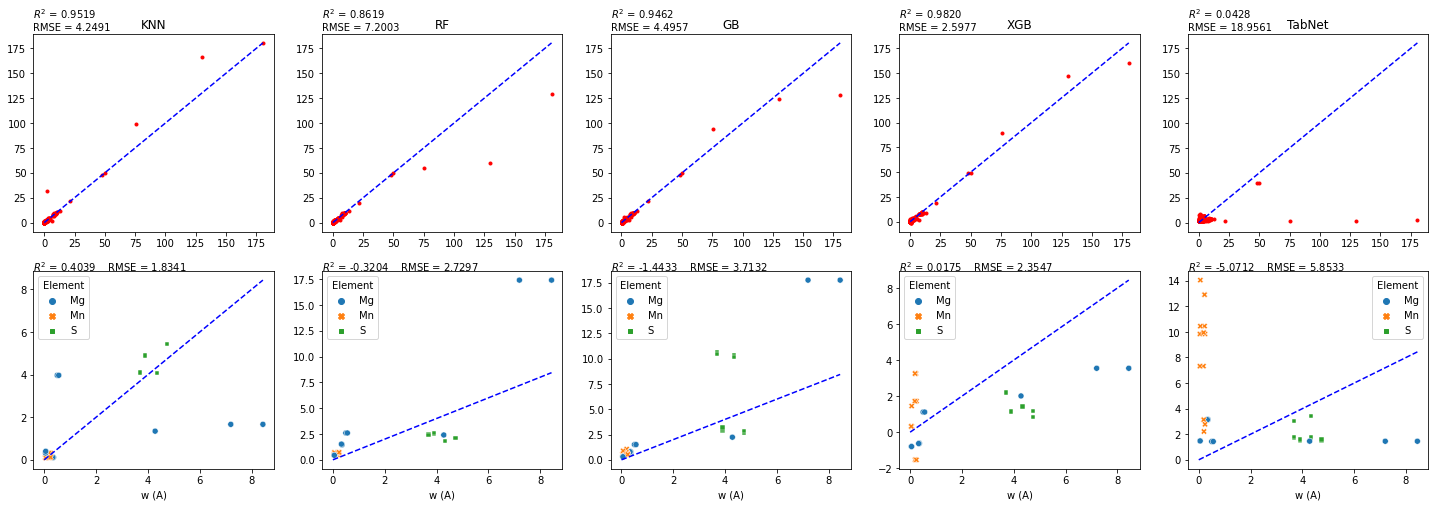

({'KNN': array([3.67868103e-02, 4.08068019e-02, 3.99337040e-02, 1.13916788e-01,
         6.80000000e-02, 7.83396520e-02, 1.51461483e+00, 1.37000000e-01,
         1.14496067e-01, 3.50000000e-02, 1.68074812e-01, 1.38350992e-01,
         7.81127322e-02, 2.69494766e-02, 6.46322026e-02, 3.67868112e-02,
         8.02871354e-01, 2.92527069e-02, 1.77744998e-02, 9.38872678e-02,
         7.83397679e-02, 7.80141870e-02, 7.80000000e-02, 2.63998371e-02,
         7.81127322e-02, 1.85304508e-01, 8.34955379e-03, 3.02411470e-02,
         8.64182604e-02, 1.65000000e+00, 7.80000000e-02, 1.36405436e-01,
         1.17162695e-01, 1.51803582e-01, 4.87878119e-03, 1.37000000e-01,
         8.31067011e-02, 3.80000000e-02, 3.72126113e-01, 6.32703303e-01,
         3.19809646e-01, 4.10000000e-01, 4.85695367e-01, 1.72332456e+00,
         2.50896854e-01, 1.28945062e+00, 7.01195472e-01, 1.57000000e+00,
         6.92207095e-01, 1.73724199e+00, 4.60000000e-01, 2.12000000e+00,
         3.79990290e-01, 3.66223979e-01, 4.0

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

plot_model_prediction(models_d, XW_train, YW_train, XW_test, YW_test, XW_elem, YW_elem, LW_elem)

## In case on scaled *targets*

In [346]:
YW_train.describe()

count    2229.000000
mean        4.339704
std        10.906263
min         0.001500
25%         0.196000
50%         1.451247
75%         4.016393
max       180.500000
dtype: float64

Getting KNN_Extended predictions
Getting XGB_Extended predictions
[16:54:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Getting TabNet_Scaled predictions

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 0.18961
Best weights from best epoch are automatically used!
Plotting KNN_Extended predictions
Plotting XGB_Extended predictions
Plotting TabNet_Scaled predictions


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


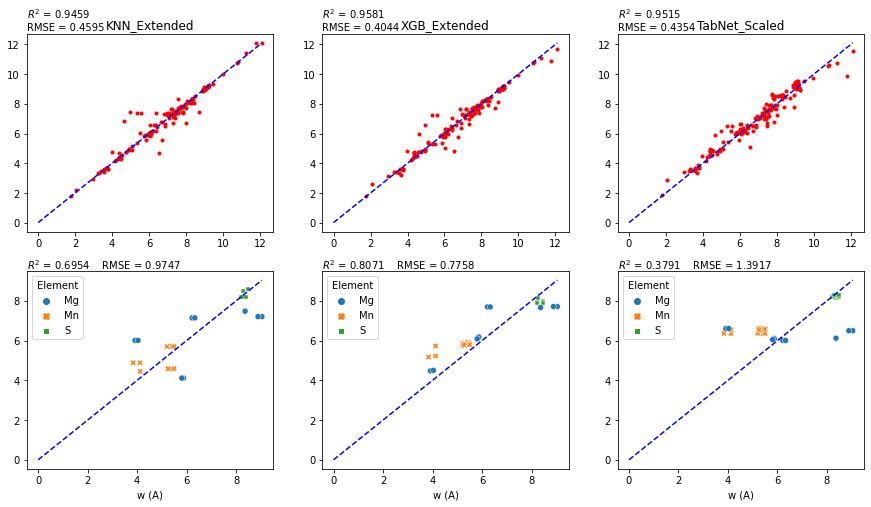

In [350]:
models = ['KNN_Extended', 'XGB_Extended', 'TabNet_Scaled']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d, XW_train, YW_train, XW_test, YW_test, XW_elem, YW_elem, LW_elem)

In [351]:
YW_train = (np.exp(YW_train) - 1) * epsilon
YW_test = (np.exp(YW_test) - 1) * epsilon
YW_elem = (np.exp(YW_elem) - 1) * epsilon
for name, values in preds.items():
    preds[name] = (np.exp(preds[name]) - 1) * epsilon
    preds_elem[name] = (np.exp(preds_elem[name]) -1) * epsilon

Plotting KNN_Extended predictions
Plotting XGB_Extended predictions
Plotting TabNet_Scaled predictions


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


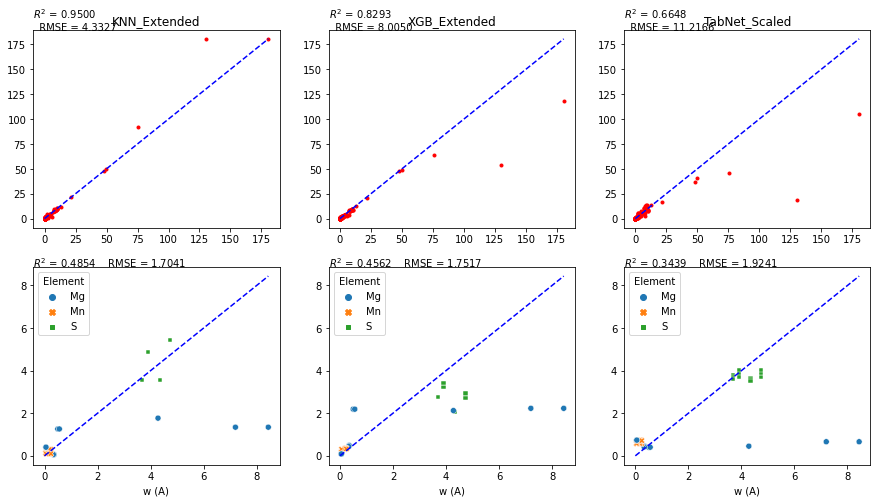

In [352]:
predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (5*len(models_d), 4*2))
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], 'r.')
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = 'b', ls = '--')
    ax[0, i].set_title(f'{name}')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}  \n  RMSE = {RMSE[name]:.4f}',  transform = ax[0, i].transAxes)
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(YW_elem, preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'])
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = 'b', ls = '--')
    ax[1, i].text(x = 0, y = 1, s = f'$R^2$ = {R2_elem[name]:.4f}    RMSE = {RMSE_elem[name]:.4f}',  transform = ax[1, i].transAxes)
    i += 1
plt.show()

## Shift

In [ ]:
print(XS_train.shape, XS_test.shape, XS_elem.shape)
print(XW_train.shape, XW_test.shape, XW_elem.shape)
#print(XS_elem)

(275, 50) (58, 50) (20, 50)
(743, 50) (154, 50) (34, 50)


In [ ]:
print(YS_elem)

2      0.350000
3      0.353000
4      0.330000
587    4.342105
588    3.687708
589    4.342105
590    3.687708
591    4.342105
592    3.687708
593    4.736842
594    3.903226
595    4.736842
596    3.903226
597    4.736842
598    3.903226
730    4.280000
731    8.440000
732    7.200000
733    0.500000
734    0.560000
Name: w (A), dtype: float64


Getting KNN_SHIFT predictions
Getting GB_SHIFT predictions
Getting XGB_SHIFT predictions
[10:03:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Getting TabNet_SHIFT predictions

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 21.197
Best weights from best epoch are automatically used!
Plotting KNN_SHIFT predictions


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Plotting GB_SHIFT predictions
Plotting XGB_SHIFT predictions
Plotting TabNet_SHIFT predictions


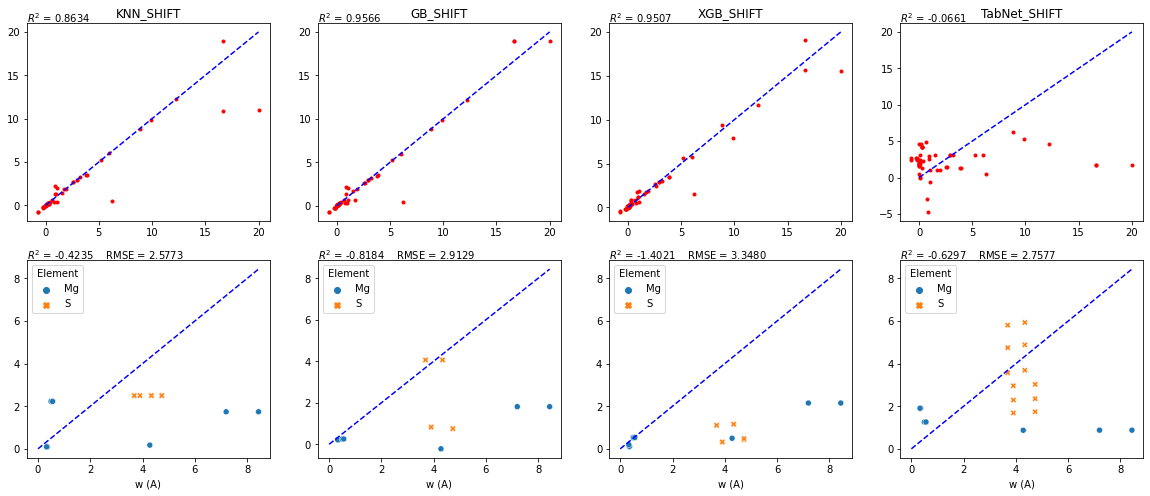

({'GB_SHIFT': array([-2.59310346e-01,  3.91666204e-02, -2.35672990e-01, -6.65330643e-01,
         -1.97868738e-01,  4.12027283e-02, -2.35810597e-01,  4.26402963e-02,
         -1.06844387e-02,  8.81676419e-02, -1.97868738e-01, -2.03051373e-02,
         -6.65468250e-01,  4.33106305e-02,  4.26402963e-02,  1.07328810e-01,
          1.59113465e-01,  1.59903665e-01,  4.36632002e-02,  3.01826828e-01,
          6.55451760e-02,  1.05224689e-01,  1.05224689e-01,  9.98871562e-02,
          4.01470207e-02,  1.94114458e-01,  1.46755968e-01,  2.47311336e-01,
          3.01826828e-01,  6.23425829e-01,  6.45440574e-01,  3.34044165e-01,
          1.92704852e+00,  2.02773660e+00,  2.88451743e-01,  1.32040544e+00,
          3.70799218e-01,  2.15029230e+00,  6.55432110e-01,  2.67965532e+00,
          4.32047723e-01,  2.67965532e+00,  1.70248872e+00,  3.01826828e-01,
          1.89490980e+01,  3.54710071e+00,  5.21354720e+00,  5.98792639e+00,
          1.89490980e+01,  3.21656767e+00,  4.51844911e-01,  2.9

In [ ]:
models = ['KNN_SHIFT', 'GB_SHIFT', 'XGB_SHIFT', 'TabNet_SHIFT']

models_d = create_models_dict(models)

plot_model_prediction(models_d, XS_train, YS_train, XS_test, YS_test, XS_elem, YS_elem, LS_elem)

## Comparing old (handmade/handtuned) and auto new TabNet

In [ ]:
models = ['TabNet', 'TabNet_handmade']
models_d = create_models_dict(models)

results = train_and_test_regressor(models_d, XW_train, YW_train, XW_test, YW_test)
plot_model_comparison(results)



models = ['TabNet', 'TabNet_handmade']
models_d = create_models_dict(models)

pr, elem, fig, ax = plot_model_prediction(models_d, XW_train, YW_train, XW_test, YW_test, XW_elem, YW_elem, LW_elem)

KeyError: ignored

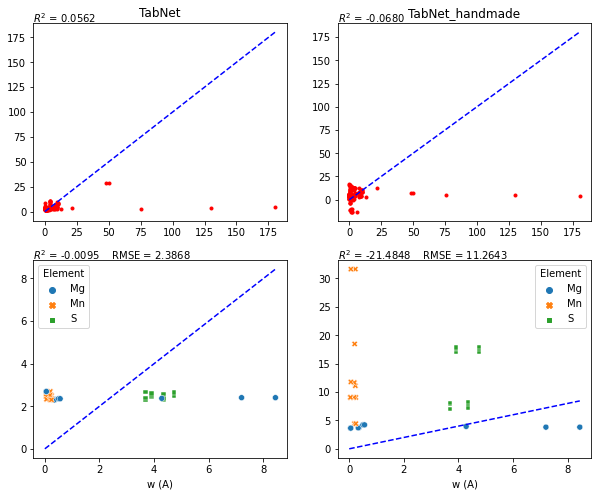

In [ ]:
#ax[0, 0].set_xlim(0, 15)
#ax[0, 0].set_ylim(0, 15)
#ax[0, 1].set_xlim(0, 15)
#ax[0, 1].set_ylim(0, 15)
fig

# Temperature dependence

In [359]:
target_width_extended.describe()

count    2691.000000
mean        4.564198
std        12.776243
min         0.001500
25%         0.204444
50%         1.451247
75%         4.016393
max       180.500000
dtype: float64

In [360]:
factor = 1.05
data_width_extended = data_width
target_width_extended = target_width
for index, row in data_width.iterrows():
    row['T'] = row['T']*factor
    data_width_extended = data_width_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_extended = target_width_extended.append(pd.Series(target_width.loc[index]), ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_extended = data_width_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_extended = target_width_extended.append(pd.Series(target_width.loc[index]), ignore_index=True)

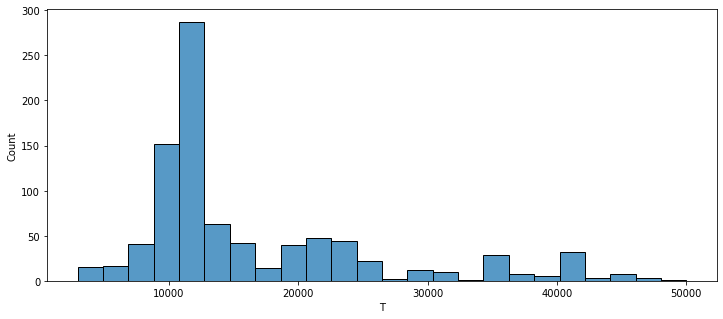

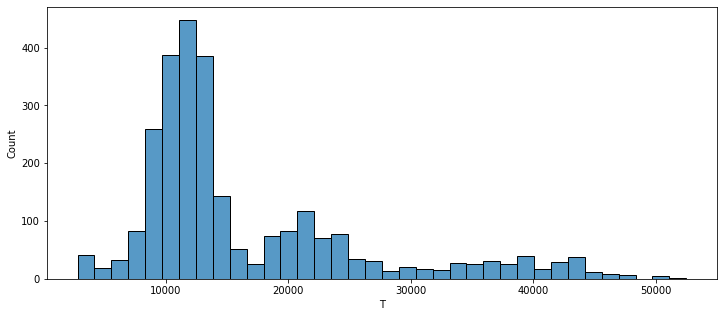

In [361]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.histplot(data = data_width, x = 'T')
plt.show()

fig, ax = plt.subplots(figsize = (12, 5))
sns.histplot(data = data_width_extended, x = 'T')
plt.show()

In [362]:
data_width_extended['Wavelength'].value_counts()

538.337000    114
667.815000     78
501.568000     69
471.313916     54
471.315614     54
             ... 
130.603000      3
132.656000      3
141.195000      3
141.193000      3
373.994000      3
Name: Wavelength, Length: 427, dtype: int64

In [363]:
data_width_extended = data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


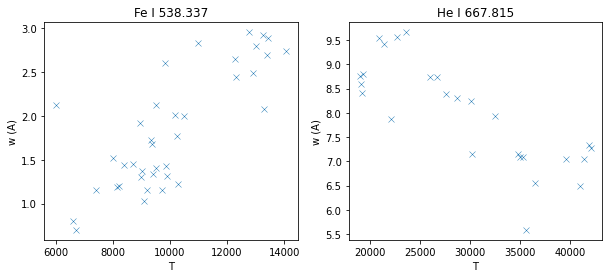

	Points plotted are only original data (without artificial points)


In [364]:
Fe_wavelength = 538.3370
He_wavelength = 667.8150

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
sns.scatterplot(data.loc[data['Wavelength'] == Fe_wavelength]['T'], data.loc[data['Wavelength'] == Fe_wavelength]['w (A)'], ax = ax[0], marker = 'x')
sns.scatterplot(data.loc[data['Wavelength'] == He_wavelength]['T'], data.loc[data['Wavelength'] == He_wavelength]['w (A)'], ax = ax[1], marker = 'x')

ax[0].set_title(f'Fe I {Fe_wavelength}')
ax[1].set_title(f'He I {He_wavelength}')

plt.show()

print(f'\tPoints plotted are only original data (without artificial points)')

In [365]:
#Define temperature range in each case

Fe_low, Fe_high = data.loc[data['Wavelength'] == Fe_wavelength]['T'].describe()['min'], data.loc[data['Wavelength'] == Fe_wavelength]['T'].describe()['max']
He_low, He_high = data.loc[data['Wavelength'] == He_wavelength]['T'].describe()['min'], data.loc[data['Wavelength'] == He_wavelength]['T'].describe()['max']

npoints = 1000
#Fe_temperatures = np.linspace(Fe_low, Fe_high, npoints)
#He_temperatures = np.linspace(He_low, He_high, npoints)

Fe_temperatures = np.linspace(5000, 15000, npoints)
He_temperatures = np.linspace(15000, 45000, npoints)

Fe_unit = data_width.loc[data_width['Wavelength'] == Fe_wavelength][data_width['Wavelength'].duplicated() == False]
He_unit = data_width.loc[data_width['Wavelength'] == He_wavelength][data_width['Wavelength'].duplicated() == False]

for i in range(npoints):
    Fe_unit['T'] = Fe_temperatures[i]
    if i == 0:
        temperature_test_data = Fe_unit
    else:
        temperature_test_data = pd.concat([temperature_test_data, Fe_unit])

for i in range(npoints):
    He_unit['T'] = He_temperatures[i]
    temperature_test_data = pd.concat([temperature_test_data, He_unit])

temperature_test_data = temperature_test_data.drop(columns=['Element', 'Wavelength', 'Z number'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [381]:
YW_test.describe()

count    154.000000
mean       5.647310
std       19.438067
min        0.004844
25%        0.217534
50%        1.493243
75%        4.016393
max      180.500000
Name: w (A), dtype: float64

In [384]:
models = ['KNN_Extended', 'XGB_Extended', 'TabNet_Scaled']
models_d = create_models_dict(models)

for name, model in models_d.items():
    print(f"Training {name} model")
    if 'TabNet' in name:
        print(type(target_width_extended))
        model.fit(data_width_extended, np.log(1 + target_width_extended / epsilon), XW_test, np.log(1 + YW_test / epsilon))
    else:
        model.fit(data_width_extended, np.log(1 + target_width_extended / epsilon))

temperature_test_predictions = {}
for name, model in models_d.items():
    temperature_test_predictions[name] = model.predict(temperature_test_data)

Training KNN_Extended model
Training XGB_Extended model
[17:27:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training TabNet_Scaled model
<class 'pandas.core.series.Series'>

Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 0.05608
Best weights from best epoch are automatically used!


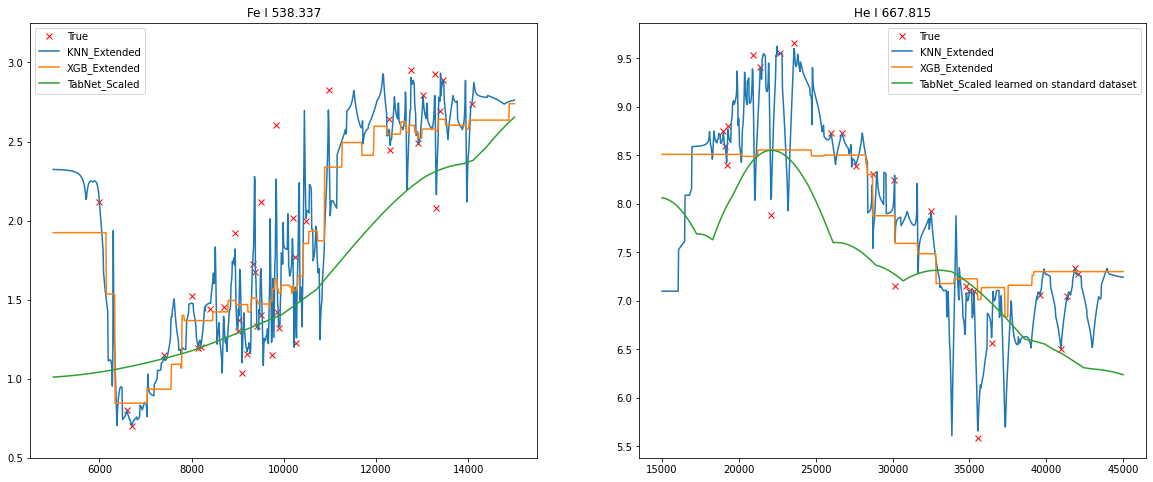

In [385]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(data.loc[data['Wavelength'] == Fe_wavelength]['T'], data.loc[data['Wavelength'] == Fe_wavelength]['w (A)'], 'rx', label = 'True')
ax[1].plot(data.loc[data['Wavelength'] == He_wavelength]['T'], data.loc[data['Wavelength'] == He_wavelength]['w (A)'], 'rx', label = 'True')

ax[0].plot(Fe_temperatures, (np.exp(temperature_test_predictions[models[0]][:1000]) - 1) * epsilon, label = f'{models[0]}')
ax[1].plot(He_temperatures, (np.exp(temperature_test_predictions[models[0]][1000:]) - 1) * epsilon, label = f'{models[0]}')

ax[0].plot(Fe_temperatures, (np.exp(temperature_test_predictions[models[1]][:1000]) - 1) * epsilon, label = f'{models[1]}')
ax[1].plot(He_temperatures, (np.exp(temperature_test_predictions[models[1]][1000:]) - 1) * epsilon, label = f'{models[1]}')

ax[0].plot(Fe_temperatures, (np.exp(temperature_test_predictions[models[2]][:1000]) - 1) * epsilon, label = f'{models[2]}')
ax[1].plot(He_temperatures, (np.exp(temperature_test_predictions[models[2]][1000:]) - 1) * epsilon, label = f'{models[2]} learned on standard dataset')

ax[0].set_title(f'Fe I {Fe_wavelength}')
ax[1].set_title(f'He I {He_wavelength}')

ax[0].legend()
ax[1].legend()

ax[0].set_ylim(0.5, 3.25)

plt.show()

# Debugging

In [358]:
target_width_extended.to_numpy().reshape(-1, 1)

(2691, 1)

In [310]:
models = ['TabNet_Scaled']
models_d = create_models_dict(models)

for name, models in models_d.items():
    print(f'Fitting model {name}')
    model.fit(XW_train, YW_train)

type(models_d['TabNet_Scaled'])

Fitting model TabNet_Scaled


ValueError: ignored

In [311]:
%debug

> /usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py(765)check_array()
    763                     "Reshape your data either using array.reshape(-1, 1) if "
    764                     "your data has a single feature or array.reshape(1, -1) "
--> 765                     "if it contains a single sample.".format(array)
    766                 )
    767             # If input is 1D raise error

ipdb> q


In [ ]:
LW_elem

,Element,Wavelength
2,Mg,518.36043
3,Mg,517.26844
4,Mg,516.73213
5,Mn,403.07530
6,Mn,403.30620
7,Mn,403.44830
8,Mn,279.48170
9,Mn,279.82690
10,Mn,280.10810
11,Mn,404.13550


Fitting KNN
Fitting RF
Fitting GB
Fitting XGB
[15:19:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting TabNet

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 359.33225
Best weights from best epoch are automatically used!
Calculating bootstrap score for KNN
Calculating bootstrap score for RF
Calculating bootstrap score for GB
Calculating bootstrap score for XGB
Calculating bootstrap score for TabNet


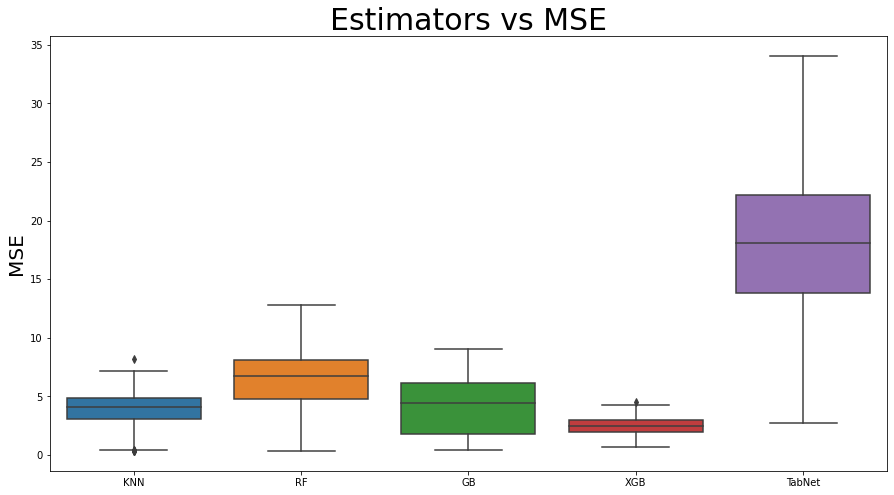

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

tuned_results = train_and_test_regressor(models_d, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(tuned_results)

[16:19:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 7.652456533356582
GB model 11.978170490764201
[16:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 85.67093351905685
GB model 67.74644926737481
[16:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 1.871245347868278
GB model 48.14135844210374
[16:19:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 2.3040662820980895
GB model 2.5558378882546395
[16:19:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 1.6383731338990246
GB model 2.1933960069613687

 XGB score 19.827414963255766
GB score 26.52304241909175
{'GB': Gradi

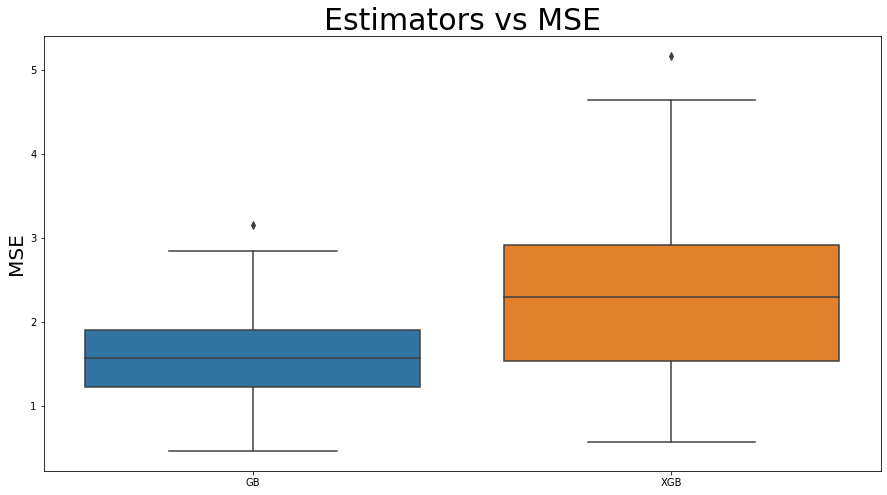

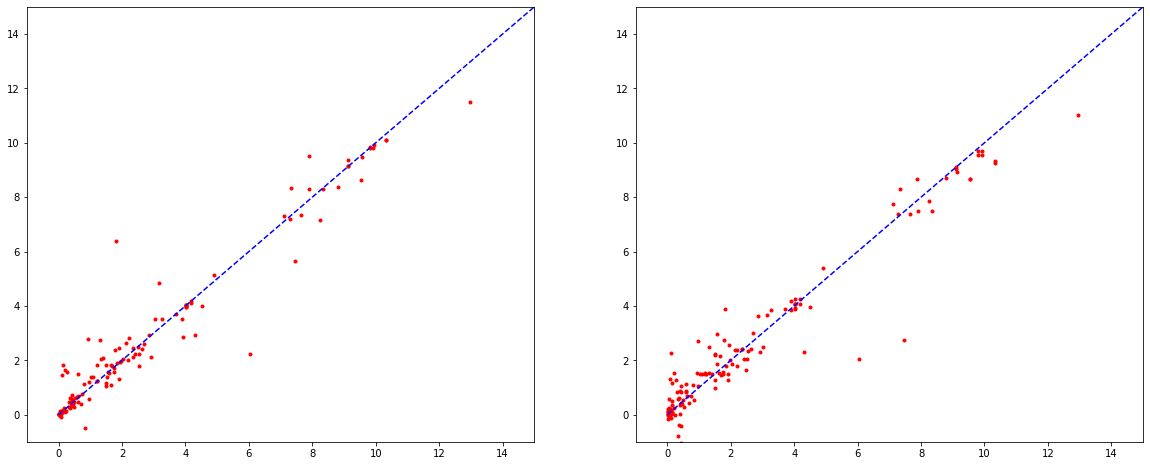

GB MSE: 2.699773000606855
XGB MSE: 5.888925800005179


In [ ]:
nfolds = 5
#kf = KFold(nfolds, shuffle = True, random_state=7)
kf = KFold(nfolds, shuffle = False)
score_XGB = 0
score_GB = 0

with open(path + f'/GB' + '_optimal_parameters', 'r') as fp:
    GB_params = json.load(fp)
with open(path + f'/XGB' + '_optimal_parameters', 'r') as fp:
    XGB_params = json.load(fp)

for train, test in kf.split(XW_train):
    #print(XW_train.iloc[test, :])
    #print(YW_train.iloc[test])
    #break

    model_XGB = xgboost.XGBRegressor(**XGB_params, n_estimators = 500, n_jobs = -1)
    model_GB = GradientBoostingRegressor(**GB_params, n_estimators = 500)
    
    model_XGB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    model_GB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    
    score_XGB += mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True)
    score_GB += mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True)
    print('\n', 'XGB model:', mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True))
    print('GB model', mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True))
score_XGB /= nfolds
score_GB /= nfolds

print(f"\n XGB score {score_XGB}")
print(f"GB score {score_GB}")

models = {
    'GB' : model_GB,
    'XGB' : model_XGB
}
print(models)
rrr = train_and_test_regressor(models,
                               XW_train,
                               YW_train,
                               XW_test.sample(frac = 1, random_state = 777),
                               YW_test.sample(frac = 1, random_state = 777))
plot_model_comparison(rrr)

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 15)
    i.set_ylim(-1, 15)
plt.show()


print(f'GB MSE: {mean_squared_error(YW_test, model_GB.predict(XW_test))}')
print(f'XGB MSE: {mean_squared_error(YW_test, model_XGB.predict(XW_test))}')


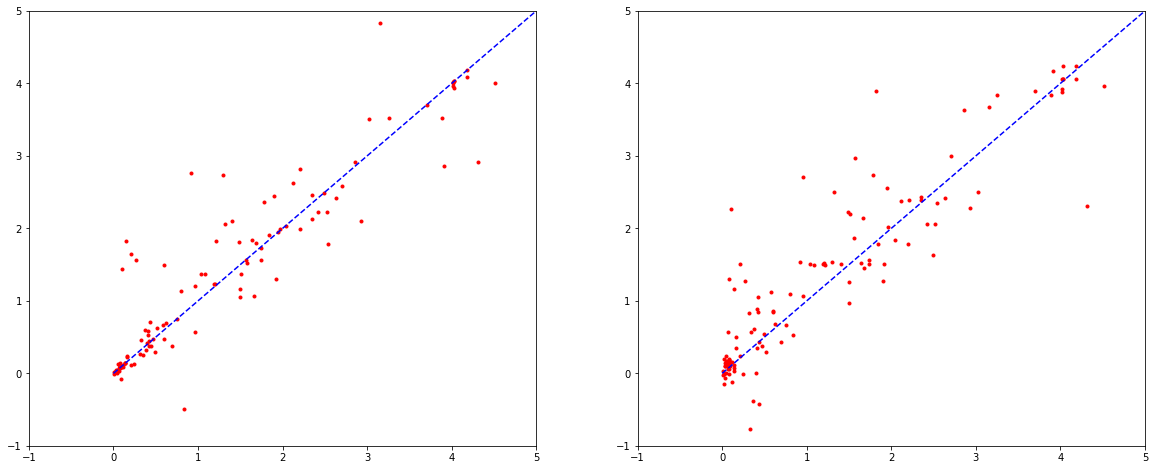

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 5)
    i.set_ylim(-1, 5)
plt.show()

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

In [ ]:
print(models_d.items())

TypeError: ignored

In [ ]:
abc = np.array([2, 3, 4])
abc = abc.flatten()
abc.shape

(3,)